##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Playing CartPole with the Actor-Critic Method


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.
The reader is assumed to have some familiarity with [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of reinforcement learning. 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function. 

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**CartPole-v0**

In the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0), a pole is attached to a cart moving along a frictionless track. 
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. 
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

<center>
  <figure>
    <image src="images/cartpole-v0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [2]:
!pip install -q gym

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install -q pyvirtualdisplay > /dev/null 2>&1
pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

## Model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and critic value respectively. We use model subclassing to define the model. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

Refer to [OpenAI Gym's CartPole-v0 wiki page](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) for more information.


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## Training

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, we need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

We collect training data for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the `run_episode` function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that `tf.TensorArray`s were used to support Tensor iteration on variable length arrays.

In [7]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. Computing expected returns

We convert the sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, we also standardize the resulting sequence of returns (i.e. to have zero mean and unit standard deviation).


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. The actor-critic loss

Since we are using a hybrid actor-critic model, we will use loss function that is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

We formulate the actor loss based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and compute single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

We add a negative term to the sum since we want to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Defining the training step to update parameters

We combine all of the steps above into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

We use the Adam optimizer to apply the gradients to the model parameters.

We also compute the sum of the undiscounted rewards, `episode_reward`, in this step which would be used later on to evaluate if we have met the success criterion.

We apply the `tf.function` context to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Run the training loop

We execute training by run the training step until either the success criterion or maximum number of episodes is reached.  

We keep a running record of episode rewards using a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [12]:
%%time

max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))

    running_reward = episode_reward*0.01 + running_reward*.99
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 0:   0%|          | 0/10000 [00:01<?, ?it/s]

Episode 0:   0%|          | 0/10000 [00:01<?, ?it/s, episode_reward=40, running_reward=0.4]

Episode 0:   0%|          | 1/10000 [00:01<5:23:58,  1.94s/it, episode_reward=40, running_reward=0.4]

Episode 1:   0%|          | 1/10000 [00:01<5:23:58,  1.94s/it, episode_reward=40, running_reward=0.4]

Episode 1:   0%|          | 1/10000 [00:01<5:23:58,  1.94s/it, episode_reward=25, running_reward=0.646]

Episode 2:   0%|          | 1/10000 [00:02<5:23:58,  1.94s/it, episode_reward=25, running_reward=0.646]

Episode 2:   0%|          | 1/10000 [00:02<5:23:58,  1.94s/it, episode_reward=59, running_reward=1.23] 

Episode 2:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=59, running_reward=1.23]

Episode 3:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=59, running_reward=1.23]

Episode 3:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=24, running_reward=1.46]

Episode 4:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=24, running_reward=1.46]

Episode 4:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=25, running_reward=1.69]

Episode 5:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=25, running_reward=1.69]

Episode 5:   0%|          | 3/10000 [00:02<3:50:52,  1.39s/it, episode_reward=54, running_reward=2.22]

Episode 5:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=54, running_reward=2.22]

Episode 6:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=54, running_reward=2.22]

Episode 6:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=29, running_reward=2.48]

Episode 7:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=29, running_reward=2.48]

Episode 7:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=20, running_reward=2.66]

Episode 8:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=20, running_reward=2.66]

Episode 8:   0%|          | 6/10000 [00:02<2:44:59,  1.01it/s, episode_reward=14, running_reward=2.77]

Episode 8:   0%|          | 9/10000 [00:02<1:57:36,  1.42it/s, episode_reward=14, running_reward=2.77]

Episode 9:   0%|          | 9/10000 [00:02<1:57:36,  1.42it/s, episode_reward=14, running_reward=2.77]

Episode 9:   0%|          | 9/10000 [00:02<1:57:36,  1.42it/s, episode_reward=44, running_reward=3.18]

Episode 10:   0%|          | 9/10000 [00:02<1:57:36,  1.42it/s, episode_reward=44, running_reward=3.18]

Episode 10:   0%|          | 9/10000 [00:02<1:57:36,  1.42it/s, episode_reward=42, running_reward=3.57]

Episode 10:   0%|          | 11/10000 [00:02<1:26:34,  1.92it/s, episode_reward=42, running_reward=3.57]

Episode 11:   0%|          | 11/10000 [00:02<1:26:34,  1.92it/s, episode_reward=42, running_reward=3.57]

Episode 11:   0%|          | 11/10000 [00:02<1:26:34,  1.92it/s, episode_reward=74, running_reward=4.28]

Episode 12:   0%|          | 11/10000 [00:02<1:26:34,  1.92it/s, episode_reward=74, running_reward=4.28]

Episode 12:   0%|          | 11/10000 [00:02<1:26:34,  1.92it/s, episode_reward=27, running_reward=4.5] 

Episode 12:   0%|          | 13/10000 [00:02<1:05:35,  2.54it/s, episode_reward=27, running_reward=4.5]

Episode 13:   0%|          | 13/10000 [00:03<1:05:35,  2.54it/s, episode_reward=27, running_reward=4.5]

Episode 13:   0%|          | 13/10000 [00:03<1:05:35,  2.54it/s, episode_reward=120, running_reward=5.66]

Episode 14:   0%|          | 13/10000 [00:03<1:05:35,  2.54it/s, episode_reward=120, running_reward=5.66]

Episode 14:   0%|          | 13/10000 [00:03<1:05:35,  2.54it/s, episode_reward=29, running_reward=5.89] 

Episode 14:   0%|          | 15/10000 [00:03<53:12,  3.13it/s, episode_reward=29, running_reward=5.89]  

Episode 15:   0%|          | 15/10000 [00:03<53:12,  3.13it/s, episode_reward=29, running_reward=5.89]

Episode 15:   0%|          | 15/10000 [00:03<53:12,  3.13it/s, episode_reward=13, running_reward=5.96]

Episode 16:   0%|          | 15/10000 [00:03<53:12,  3.13it/s, episode_reward=13, running_reward=5.96]

Episode 16:   0%|          | 15/10000 [00:03<53:12,  3.13it/s, episode_reward=45, running_reward=6.35]

Episode 16:   0%|          | 17/10000 [00:03<40:09,  4.14it/s, episode_reward=45, running_reward=6.35]

Episode 17:   0%|          | 17/10000 [00:03<40:09,  4.14it/s, episode_reward=45, running_reward=6.35]

Episode 17:   0%|          | 17/10000 [00:03<40:09,  4.14it/s, episode_reward=41, running_reward=6.7] 

Episode 18:   0%|          | 17/10000 [00:03<40:09,  4.14it/s, episode_reward=41, running_reward=6.7]

Episode 18:   0%|          | 17/10000 [00:03<40:09,  4.14it/s, episode_reward=19, running_reward=6.82]

Episode 18:   0%|          | 19/10000 [00:03<31:10,  5.34it/s, episode_reward=19, running_reward=6.82]

Episode 19:   0%|          | 19/10000 [00:03<31:10,  5.34it/s, episode_reward=19, running_reward=6.82]

Episode 19:   0%|          | 19/10000 [00:03<31:10,  5.34it/s, episode_reward=34, running_reward=7.1] 

Episode 20:   0%|          | 19/10000 [00:03<31:10,  5.34it/s, episode_reward=34, running_reward=7.1]

Episode 20:   0%|          | 19/10000 [00:03<31:10,  5.34it/s, episode_reward=43, running_reward=7.45]

Episode 20:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=43, running_reward=7.45]

Episode 21:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=43, running_reward=7.45]

Episode 21:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=22, running_reward=7.6] 

Episode 22:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=22, running_reward=7.6]

Episode 22:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=23, running_reward=7.75]

Episode 23:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=23, running_reward=7.75]

Episode 23:   0%|          | 21/10000 [00:03<25:39,  6.48it/s, episode_reward=21, running_reward=7.89]

Episode 23:   0%|          | 24/10000 [00:03<20:11,  8.24it/s, episode_reward=21, running_reward=7.89]

Episode 24:   0%|          | 24/10000 [00:03<20:11,  8.24it/s, episode_reward=21, running_reward=7.89]

Episode 24:   0%|          | 24/10000 [00:03<20:11,  8.24it/s, episode_reward=35, running_reward=8.16]

Episode 25:   0%|          | 24/10000 [00:03<20:11,  8.24it/s, episode_reward=35, running_reward=8.16]

Episode 25:   0%|          | 24/10000 [00:03<20:11,  8.24it/s, episode_reward=28, running_reward=8.36]

Episode 25:   0%|          | 26/10000 [00:03<17:11,  9.67it/s, episode_reward=28, running_reward=8.36]

Episode 26:   0%|          | 26/10000 [00:03<17:11,  9.67it/s, episode_reward=28, running_reward=8.36]

Episode 26:   0%|          | 26/10000 [00:03<17:11,  9.67it/s, episode_reward=81, running_reward=9.08]

Episode 27:   0%|          | 26/10000 [00:04<17:11,  9.67it/s, episode_reward=81, running_reward=9.08]

Episode 27:   0%|          | 26/10000 [00:04<17:11,  9.67it/s, episode_reward=112, running_reward=10.1]

Episode 27:   0%|          | 28/10000 [00:04<21:16,  7.81it/s, episode_reward=112, running_reward=10.1]

Episode 28:   0%|          | 28/10000 [00:04<21:16,  7.81it/s, episode_reward=112, running_reward=10.1]

Episode 28:   0%|          | 28/10000 [00:04<21:16,  7.81it/s, episode_reward=34, running_reward=10.4] 

Episode 29:   0%|          | 28/10000 [00:04<21:16,  7.81it/s, episode_reward=34, running_reward=10.4]

Episode 29:   0%|          | 28/10000 [00:04<21:16,  7.81it/s, episode_reward=58, running_reward=10.8]

Episode 29:   0%|          | 30/10000 [00:04<19:29,  8.53it/s, episode_reward=58, running_reward=10.8]

Episode 30:   0%|          | 30/10000 [00:04<19:29,  8.53it/s, episode_reward=58, running_reward=10.8]

Episode 30:   0%|          | 30/10000 [00:04<19:29,  8.53it/s, episode_reward=51, running_reward=11.2]

Episode 31:   0%|          | 30/10000 [00:04<19:29,  8.53it/s, episode_reward=51, running_reward=11.2]

Episode 31:   0%|          | 30/10000 [00:04<19:29,  8.53it/s, episode_reward=34, running_reward=11.5]

Episode 31:   0%|          | 32/10000 [00:04<17:59,  9.24it/s, episode_reward=34, running_reward=11.5]

Episode 32:   0%|          | 32/10000 [00:04<17:59,  9.24it/s, episode_reward=34, running_reward=11.5]

Episode 32:   0%|          | 32/10000 [00:04<17:59,  9.24it/s, episode_reward=26, running_reward=11.6]

Episode 33:   0%|          | 32/10000 [00:04<17:59,  9.24it/s, episode_reward=26, running_reward=11.6]

Episode 33:   0%|          | 32/10000 [00:04<17:59,  9.24it/s, episode_reward=24, running_reward=11.7]

Episode 33:   0%|          | 34/10000 [00:04<15:04, 11.01it/s, episode_reward=24, running_reward=11.7]

Episode 34:   0%|          | 34/10000 [00:04<15:04, 11.01it/s, episode_reward=24, running_reward=11.7]

Episode 34:   0%|          | 34/10000 [00:04<15:04, 11.01it/s, episode_reward=15, running_reward=11.8]

Episode 35:   0%|          | 34/10000 [00:04<15:04, 11.01it/s, episode_reward=15, running_reward=11.8]

Episode 35:   0%|          | 34/10000 [00:04<15:04, 11.01it/s, episode_reward=82, running_reward=12.5]

Episode 35:   0%|          | 36/10000 [00:04<15:18, 10.85it/s, episode_reward=82, running_reward=12.5]

Episode 36:   0%|          | 36/10000 [00:04<15:18, 10.85it/s, episode_reward=82, running_reward=12.5]

Episode 36:   0%|          | 36/10000 [00:04<15:18, 10.85it/s, episode_reward=68, running_reward=13]  

Episode 37:   0%|          | 36/10000 [00:04<15:18, 10.85it/s, episode_reward=68, running_reward=13]

Episode 37:   0%|          | 36/10000 [00:04<15:18, 10.85it/s, episode_reward=24, running_reward=13.1]

Episode 37:   0%|          | 38/10000 [00:04<15:15, 10.88it/s, episode_reward=24, running_reward=13.1]

Episode 38:   0%|          | 38/10000 [00:05<15:15, 10.88it/s, episode_reward=24, running_reward=13.1]

Episode 38:   0%|          | 38/10000 [00:05<15:15, 10.88it/s, episode_reward=25, running_reward=13.2]

Episode 39:   0%|          | 38/10000 [00:05<15:15, 10.88it/s, episode_reward=25, running_reward=13.2]

Episode 39:   0%|          | 38/10000 [00:05<15:15, 10.88it/s, episode_reward=64, running_reward=13.8]

Episode 39:   0%|          | 40/10000 [00:05<15:06, 10.99it/s, episode_reward=64, running_reward=13.8]

Episode 40:   0%|          | 40/10000 [00:05<15:06, 10.99it/s, episode_reward=64, running_reward=13.8]

Episode 40:   0%|          | 40/10000 [00:05<15:06, 10.99it/s, episode_reward=72, running_reward=14.3]

Episode 41:   0%|          | 40/10000 [00:05<15:06, 10.99it/s, episode_reward=72, running_reward=14.3]

Episode 41:   0%|          | 40/10000 [00:05<15:06, 10.99it/s, episode_reward=60, running_reward=14.8]

Episode 41:   0%|          | 42/10000 [00:05<17:09,  9.67it/s, episode_reward=60, running_reward=14.8]

Episode 42:   0%|          | 42/10000 [00:05<17:09,  9.67it/s, episode_reward=60, running_reward=14.8]

Episode 42:   0%|          | 42/10000 [00:05<17:09,  9.67it/s, episode_reward=61, running_reward=15.3]

Episode 43:   0%|          | 42/10000 [00:05<17:09,  9.67it/s, episode_reward=61, running_reward=15.3]

Episode 43:   0%|          | 42/10000 [00:05<17:09,  9.67it/s, episode_reward=72, running_reward=15.8]

Episode 43:   0%|          | 44/10000 [00:05<18:37,  8.91it/s, episode_reward=72, running_reward=15.8]

Episode 44:   0%|          | 44/10000 [00:05<18:37,  8.91it/s, episode_reward=72, running_reward=15.8]

Episode 44:   0%|          | 44/10000 [00:05<18:37,  8.91it/s, episode_reward=47, running_reward=16.1]

Episode 45:   0%|          | 44/10000 [00:05<18:37,  8.91it/s, episode_reward=47, running_reward=16.1]

Episode 45:   0%|          | 44/10000 [00:05<18:37,  8.91it/s, episode_reward=39, running_reward=16.4]

Episode 45:   0%|          | 46/10000 [00:05<17:24,  9.53it/s, episode_reward=39, running_reward=16.4]

Episode 46:   0%|          | 46/10000 [00:05<17:24,  9.53it/s, episode_reward=39, running_reward=16.4]

Episode 46:   0%|          | 46/10000 [00:05<17:24,  9.53it/s, episode_reward=53, running_reward=16.7]

Episode 47:   0%|          | 46/10000 [00:06<17:24,  9.53it/s, episode_reward=53, running_reward=16.7]

Episode 47:   0%|          | 46/10000 [00:06<17:24,  9.53it/s, episode_reward=31, running_reward=16.9]

Episode 47:   0%|          | 48/10000 [00:06<16:24, 10.11it/s, episode_reward=31, running_reward=16.9]

Episode 48:   0%|          | 48/10000 [00:06<16:24, 10.11it/s, episode_reward=31, running_reward=16.9]

Episode 48:   0%|          | 48/10000 [00:06<16:24, 10.11it/s, episode_reward=69, running_reward=17.4]

Episode 49:   0%|          | 48/10000 [00:06<16:24, 10.11it/s, episode_reward=69, running_reward=17.4]

Episode 49:   0%|          | 48/10000 [00:06<16:24, 10.11it/s, episode_reward=18, running_reward=17.4]

Episode 49:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 50:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 50:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 51:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 51:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 52:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=18, running_reward=17.4]

Episode 52:   0%|          | 50/10000 [00:06<15:48, 10.49it/s, episode_reward=49, running_reward=17.7]

Episode 52:   1%|          | 53/10000 [00:06<13:59, 11.84it/s, episode_reward=49, running_reward=17.7]

Episode 53:   1%|          | 53/10000 [00:06<13:59, 11.84it/s, episode_reward=49, running_reward=17.7]

Episode 53:   1%|          | 53/10000 [00:06<13:59, 11.84it/s, episode_reward=52, running_reward=18.1]

Episode 54:   1%|          | 53/10000 [00:06<13:59, 11.84it/s, episode_reward=52, running_reward=18.1]

Episode 54:   1%|          | 53/10000 [00:06<13:59, 11.84it/s, episode_reward=31, running_reward=18.2]

Episode 54:   1%|          | 55/10000 [00:06<13:57, 11.88it/s, episode_reward=31, running_reward=18.2]

Episode 55:   1%|          | 55/10000 [00:06<13:57, 11.88it/s, episode_reward=31, running_reward=18.2]

Episode 55:   1%|          | 55/10000 [00:06<13:57, 11.88it/s, episode_reward=34, running_reward=18.4]

Episode 56:   1%|          | 55/10000 [00:06<13:57, 11.88it/s, episode_reward=34, running_reward=18.4]

Episode 56:   1%|          | 55/10000 [00:06<13:57, 11.88it/s, episode_reward=58, running_reward=18.8]

Episode 56:   1%|          | 57/10000 [00:06<14:18, 11.58it/s, episode_reward=58, running_reward=18.8]

Episode 57:   1%|          | 57/10000 [00:06<14:18, 11.58it/s, episode_reward=58, running_reward=18.8]

Episode 57:   1%|          | 57/10000 [00:06<14:18, 11.58it/s, episode_reward=73, running_reward=19.3]

Episode 58:   1%|          | 57/10000 [00:07<14:18, 11.58it/s, episode_reward=73, running_reward=19.3]

Episode 58:   1%|          | 57/10000 [00:07<14:18, 11.58it/s, episode_reward=121, running_reward=20.3]

Episode 58:   1%|          | 59/10000 [00:07<19:30,  8.49it/s, episode_reward=121, running_reward=20.3]

Episode 59:   1%|          | 59/10000 [00:07<19:30,  8.49it/s, episode_reward=121, running_reward=20.3]

Episode 59:   1%|          | 59/10000 [00:07<19:30,  8.49it/s, episode_reward=136, running_reward=21.5]

Episode 60:   1%|          | 59/10000 [00:07<19:30,  8.49it/s, episode_reward=136, running_reward=21.5]

Episode 60:   1%|          | 59/10000 [00:07<19:30,  8.49it/s, episode_reward=59, running_reward=21.8] 

Episode 60:   1%|          | 61/10000 [00:07<23:04,  7.18it/s, episode_reward=59, running_reward=21.8]

Episode 61:   1%|          | 61/10000 [00:07<23:04,  7.18it/s, episode_reward=59, running_reward=21.8]

Episode 61:   1%|          | 61/10000 [00:07<23:04,  7.18it/s, episode_reward=55, running_reward=22.2]

Episode 61:   1%|          | 62/10000 [00:07<21:34,  7.68it/s, episode_reward=55, running_reward=22.2]

Episode 62:   1%|          | 62/10000 [00:07<21:34,  7.68it/s, episode_reward=55, running_reward=22.2]

Episode 62:   1%|          | 62/10000 [00:07<21:34,  7.68it/s, episode_reward=112, running_reward=23.1]

Episode 62:   1%|          | 63/10000 [00:07<25:50,  6.41it/s, episode_reward=112, running_reward=23.1]

Episode 63:   1%|          | 63/10000 [00:08<25:50,  6.41it/s, episode_reward=112, running_reward=23.1]

Episode 63:   1%|          | 63/10000 [00:08<25:50,  6.41it/s, episode_reward=140, running_reward=24.2]

Episode 63:   1%|          | 64/10000 [00:08<31:42,  5.22it/s, episode_reward=140, running_reward=24.2]

Episode 64:   1%|          | 64/10000 [00:08<31:42,  5.22it/s, episode_reward=140, running_reward=24.2]

Episode 64:   1%|          | 64/10000 [00:08<31:42,  5.22it/s, episode_reward=50, running_reward=24.5] 

Episode 64:   1%|          | 65/10000 [00:08<27:14,  6.08it/s, episode_reward=50, running_reward=24.5]

Episode 65:   1%|          | 65/10000 [00:08<27:14,  6.08it/s, episode_reward=50, running_reward=24.5]

Episode 65:   1%|          | 65/10000 [00:08<27:14,  6.08it/s, episode_reward=155, running_reward=25.8]

Episode 65:   1%|          | 66/10000 [00:08<34:00,  4.87it/s, episode_reward=155, running_reward=25.8]

Episode 66:   1%|          | 66/10000 [00:08<34:00,  4.87it/s, episode_reward=155, running_reward=25.8]

Episode 66:   1%|          | 66/10000 [00:08<34:00,  4.87it/s, episode_reward=116, running_reward=26.7]

Episode 66:   1%|          | 67/10000 [00:08<35:28,  4.67it/s, episode_reward=116, running_reward=26.7]

Episode 67:   1%|          | 67/10000 [00:08<35:28,  4.67it/s, episode_reward=116, running_reward=26.7]

Episode 67:   1%|          | 67/10000 [00:08<35:28,  4.67it/s, episode_reward=123, running_reward=27.7]

Episode 67:   1%|          | 68/10000 [00:08<36:51,  4.49it/s, episode_reward=123, running_reward=27.7]

Episode 68:   1%|          | 68/10000 [00:09<36:51,  4.49it/s, episode_reward=123, running_reward=27.7]

Episode 68:   1%|          | 68/10000 [00:09<36:51,  4.49it/s, episode_reward=24, running_reward=27.6] 

Episode 69:   1%|          | 68/10000 [00:09<36:51,  4.49it/s, episode_reward=24, running_reward=27.6]

Episode 69:   1%|          | 68/10000 [00:09<36:51,  4.49it/s, episode_reward=100, running_reward=28.4]

Episode 69:   1%|          | 70/10000 [00:09<32:05,  5.16it/s, episode_reward=100, running_reward=28.4]

Episode 70:   1%|          | 70/10000 [00:09<32:05,  5.16it/s, episode_reward=100, running_reward=28.4]

Episode 70:   1%|          | 70/10000 [00:09<32:05,  5.16it/s, episode_reward=130, running_reward=29.4]

Episode 70:   1%|          | 71/10000 [00:09<35:07,  4.71it/s, episode_reward=130, running_reward=29.4]

Episode 71:   1%|          | 71/10000 [00:09<35:07,  4.71it/s, episode_reward=130, running_reward=29.4]

Episode 71:   1%|          | 71/10000 [00:09<35:07,  4.71it/s, episode_reward=76, running_reward=29.8] 

Episode 71:   1%|          | 72/10000 [00:09<32:17,  5.12it/s, episode_reward=76, running_reward=29.8]

Episode 72:   1%|          | 72/10000 [00:09<32:17,  5.12it/s, episode_reward=76, running_reward=29.8]

Episode 72:   1%|          | 72/10000 [00:09<32:17,  5.12it/s, episode_reward=44, running_reward=30]  

Episode 73:   1%|          | 72/10000 [00:09<32:17,  5.12it/s, episode_reward=44, running_reward=30]

Episode 73:   1%|          | 72/10000 [00:09<32:17,  5.12it/s, episode_reward=98, running_reward=30.7]

Episode 73:   1%|          | 74/10000 [00:09<29:26,  5.62it/s, episode_reward=98, running_reward=30.7]

Episode 74:   1%|          | 74/10000 [00:09<29:26,  5.62it/s, episode_reward=98, running_reward=30.7]

Episode 74:   1%|          | 74/10000 [00:09<29:26,  5.62it/s, episode_reward=29, running_reward=30.6]

Episode 75:   1%|          | 74/10000 [00:10<29:26,  5.62it/s, episode_reward=29, running_reward=30.6]

Episode 75:   1%|          | 74/10000 [00:10<29:26,  5.62it/s, episode_reward=29, running_reward=30.6]

Episode 75:   1%|          | 76/10000 [00:10<23:30,  7.04it/s, episode_reward=29, running_reward=30.6]

Episode 76:   1%|          | 76/10000 [00:10<23:30,  7.04it/s, episode_reward=29, running_reward=30.6]

Episode 76:   1%|          | 76/10000 [00:10<23:30,  7.04it/s, episode_reward=41, running_reward=30.7]

Episode 77:   1%|          | 76/10000 [00:10<23:30,  7.04it/s, episode_reward=41, running_reward=30.7]

Episode 77:   1%|          | 76/10000 [00:10<23:30,  7.04it/s, episode_reward=141, running_reward=31.8]

Episode 77:   1%|          | 78/10000 [00:10<25:28,  6.49it/s, episode_reward=141, running_reward=31.8]

Episode 78:   1%|          | 78/10000 [00:10<25:28,  6.49it/s, episode_reward=141, running_reward=31.8]

Episode 78:   1%|          | 78/10000 [00:10<25:28,  6.49it/s, episode_reward=200, running_reward=33.5]

Episode 78:   1%|          | 79/10000 [00:10<37:26,  4.42it/s, episode_reward=200, running_reward=33.5]

Episode 79:   1%|          | 79/10000 [00:11<37:26,  4.42it/s, episode_reward=200, running_reward=33.5]

Episode 79:   1%|          | 79/10000 [00:11<37:26,  4.42it/s, episode_reward=200, running_reward=35.2]

Episode 79:   1%|          | 80/10000 [00:11<45:36,  3.62it/s, episode_reward=200, running_reward=35.2]

Episode 80:   1%|          | 80/10000 [00:11<45:36,  3.62it/s, episode_reward=200, running_reward=35.2]

Episode 80:   1%|          | 80/10000 [00:11<45:36,  3.62it/s, episode_reward=200, running_reward=36.8]

Episode 80:   1%|          | 81/10000 [00:11<51:24,  3.22it/s, episode_reward=200, running_reward=36.8]

Episode 81:   1%|          | 81/10000 [00:11<51:24,  3.22it/s, episode_reward=200, running_reward=36.8]

Episode 81:   1%|          | 81/10000 [00:11<51:24,  3.22it/s, episode_reward=158, running_reward=38]  

Episode 81:   1%|          | 82/10000 [00:11<51:31,  3.21it/s, episode_reward=158, running_reward=38]

Episode 82:   1%|          | 82/10000 [00:12<51:31,  3.21it/s, episode_reward=158, running_reward=38]

Episode 82:   1%|          | 82/10000 [00:12<51:31,  3.21it/s, episode_reward=200, running_reward=39.7]

Episode 82:   1%|          | 83/10000 [00:12<55:19,  2.99it/s, episode_reward=200, running_reward=39.7]

Episode 83:   1%|          | 83/10000 [00:12<55:19,  2.99it/s, episode_reward=200, running_reward=39.7]

Episode 83:   1%|          | 83/10000 [00:12<55:19,  2.99it/s, episode_reward=200, running_reward=41.3]

Episode 83:   1%|          | 84/10000 [00:12<58:18,  2.83it/s, episode_reward=200, running_reward=41.3]

Episode 84:   1%|          | 84/10000 [00:13<58:18,  2.83it/s, episode_reward=200, running_reward=41.3]

Episode 84:   1%|          | 84/10000 [00:13<58:18,  2.83it/s, episode_reward=200, running_reward=42.9]

Episode 84:   1%|          | 85/10000 [00:13<1:00:01,  2.75it/s, episode_reward=200, running_reward=42.9]

Episode 85:   1%|          | 85/10000 [00:13<1:00:01,  2.75it/s, episode_reward=200, running_reward=42.9]

Episode 85:   1%|          | 85/10000 [00:13<1:00:01,  2.75it/s, episode_reward=200, running_reward=44.4]

Episode 85:   1%|          | 86/10000 [00:13<1:01:13,  2.70it/s, episode_reward=200, running_reward=44.4]

Episode 86:   1%|          | 86/10000 [00:13<1:01:13,  2.70it/s, episode_reward=200, running_reward=44.4]

Episode 86:   1%|          | 86/10000 [00:13<1:01:13,  2.70it/s, episode_reward=200, running_reward=46]  

Episode 86:   1%|          | 87/10000 [00:13<1:02:10,  2.66it/s, episode_reward=200, running_reward=46]

Episode 87:   1%|          | 87/10000 [00:14<1:02:10,  2.66it/s, episode_reward=200, running_reward=46]

Episode 87:   1%|          | 87/10000 [00:14<1:02:10,  2.66it/s, episode_reward=200, running_reward=47.5]

Episode 87:   1%|          | 88/10000 [00:14<1:02:48,  2.63it/s, episode_reward=200, running_reward=47.5]

Episode 88:   1%|          | 88/10000 [00:14<1:02:48,  2.63it/s, episode_reward=200, running_reward=47.5]

Episode 88:   1%|          | 88/10000 [00:14<1:02:48,  2.63it/s, episode_reward=200, running_reward=49]  

Episode 88:   1%|          | 89/10000 [00:14<1:03:29,  2.60it/s, episode_reward=200, running_reward=49]

Episode 89:   1%|          | 89/10000 [00:14<1:03:29,  2.60it/s, episode_reward=200, running_reward=49]

Episode 89:   1%|          | 89/10000 [00:14<1:03:29,  2.60it/s, episode_reward=200, running_reward=50.6]

Episode 89:   1%|          | 90/10000 [00:14<1:04:00,  2.58it/s, episode_reward=200, running_reward=50.6]

Episode 90:   1%|          | 90/10000 [00:15<1:04:00,  2.58it/s, episode_reward=200, running_reward=50.6]

Episode 90:   1%|          | 90/10000 [00:15<1:04:00,  2.58it/s, episode_reward=200, running_reward=52]  

Episode 90:   1%|          | 91/10000 [00:15<1:04:08,  2.57it/s, episode_reward=200, running_reward=52]

Episode 91:   1%|          | 91/10000 [00:15<1:04:08,  2.57it/s, episode_reward=200, running_reward=52]

Episode 91:   1%|          | 91/10000 [00:15<1:04:08,  2.57it/s, episode_reward=200, running_reward=53.5]

Episode 91:   1%|          | 92/10000 [00:15<1:04:31,  2.56it/s, episode_reward=200, running_reward=53.5]

Episode 92:   1%|          | 92/10000 [00:16<1:04:31,  2.56it/s, episode_reward=200, running_reward=53.5]

Episode 92:   1%|          | 92/10000 [00:16<1:04:31,  2.56it/s, episode_reward=200, running_reward=55]  

Episode 92:   1%|          | 93/10000 [00:16<1:04:28,  2.56it/s, episode_reward=200, running_reward=55]

Episode 93:   1%|          | 93/10000 [00:16<1:04:28,  2.56it/s, episode_reward=200, running_reward=55]

Episode 93:   1%|          | 93/10000 [00:16<1:04:28,  2.56it/s, episode_reward=200, running_reward=56.4]

Episode 93:   1%|          | 94/10000 [00:16<1:04:42,  2.55it/s, episode_reward=200, running_reward=56.4]

Episode 94:   1%|          | 94/10000 [00:16<1:04:42,  2.55it/s, episode_reward=200, running_reward=56.4]

Episode 94:   1%|          | 94/10000 [00:16<1:04:42,  2.55it/s, episode_reward=200, running_reward=57.9]

Episode 94:   1%|          | 95/10000 [00:16<1:04:17,  2.57it/s, episode_reward=200, running_reward=57.9]

Episode 95:   1%|          | 95/10000 [00:17<1:04:17,  2.57it/s, episode_reward=200, running_reward=57.9]

Episode 95:   1%|          | 95/10000 [00:17<1:04:17,  2.57it/s, episode_reward=200, running_reward=59.3]

Episode 95:   1%|          | 96/10000 [00:17<1:04:14,  2.57it/s, episode_reward=200, running_reward=59.3]

Episode 96:   1%|          | 96/10000 [00:17<1:04:14,  2.57it/s, episode_reward=200, running_reward=59.3]

Episode 96:   1%|          | 96/10000 [00:17<1:04:14,  2.57it/s, episode_reward=178, running_reward=60.5]

Episode 96:   1%|          | 97/10000 [00:17<1:02:17,  2.65it/s, episode_reward=178, running_reward=60.5]

Episode 97:   1%|          | 97/10000 [00:18<1:02:17,  2.65it/s, episode_reward=178, running_reward=60.5]

Episode 97:   1%|          | 97/10000 [00:18<1:02:17,  2.65it/s, episode_reward=200, running_reward=61.9]

Episode 97:   1%|          | 98/10000 [00:18<1:02:38,  2.63it/s, episode_reward=200, running_reward=61.9]

Episode 98:   1%|          | 98/10000 [00:18<1:02:38,  2.63it/s, episode_reward=200, running_reward=61.9]

Episode 98:   1%|          | 98/10000 [00:18<1:02:38,  2.63it/s, episode_reward=200, running_reward=63.3]

Episode 98:   1%|          | 99/10000 [00:18<1:04:07,  2.57it/s, episode_reward=200, running_reward=63.3]

Episode 99:   1%|          | 99/10000 [00:18<1:04:07,  2.57it/s, episode_reward=200, running_reward=63.3]

Episode 99:   1%|          | 99/10000 [00:18<1:04:07,  2.57it/s, episode_reward=200, running_reward=64.6]

Episode 99:   1%|          | 100/10000 [00:18<1:04:53,  2.54it/s, episode_reward=200, running_reward=64.6]

Episode 100:   1%|          | 100/10000 [00:19<1:04:53,  2.54it/s, episode_reward=200, running_reward=64.6]

Episode 100:   1%|          | 100/10000 [00:19<1:04:53,  2.54it/s, episode_reward=200, running_reward=66]  

Episode 100:   1%|          | 101/10000 [00:19<1:05:23,  2.52it/s, episode_reward=200, running_reward=66]

Episode 101:   1%|          | 101/10000 [00:19<1:05:23,  2.52it/s, episode_reward=200, running_reward=66]

Episode 101:   1%|          | 101/10000 [00:19<1:05:23,  2.52it/s, episode_reward=200, running_reward=67.3]

Episode 101:   1%|          | 102/10000 [00:19<1:05:53,  2.50it/s, episode_reward=200, running_reward=67.3]

Episode 102:   1%|          | 102/10000 [00:19<1:05:53,  2.50it/s, episode_reward=200, running_reward=67.3]

Episode 102:   1%|          | 102/10000 [00:19<1:05:53,  2.50it/s, episode_reward=109, running_reward=67.7]

Episode 102:   1%|          | 103/10000 [00:19<57:05,  2.89it/s, episode_reward=109, running_reward=67.7]  

Episode 103:   1%|          | 103/10000 [00:20<57:05,  2.89it/s, episode_reward=109, running_reward=67.7]

Episode 103:   1%|          | 103/10000 [00:20<57:05,  2.89it/s, episode_reward=200, running_reward=69.1]

Episode 103:   1%|          | 104/10000 [00:20<1:00:11,  2.74it/s, episode_reward=200, running_reward=69.1]

Episode 104:   1%|          | 104/10000 [00:20<1:00:11,  2.74it/s, episode_reward=200, running_reward=69.1]

Episode 104:   1%|          | 104/10000 [00:20<1:00:11,  2.74it/s, episode_reward=200, running_reward=70.4]

Episode 104:   1%|          | 105/10000 [00:20<1:02:28,  2.64it/s, episode_reward=200, running_reward=70.4]

Episode 105:   1%|          | 105/10000 [00:20<1:02:28,  2.64it/s, episode_reward=200, running_reward=70.4]

Episode 105:   1%|          | 105/10000 [00:20<1:02:28,  2.64it/s, episode_reward=121, running_reward=70.9]

Episode 105:   1%|          | 106/10000 [00:20<56:25,  2.92it/s, episode_reward=121, running_reward=70.9]  

Episode 106:   1%|          | 106/10000 [00:21<56:25,  2.92it/s, episode_reward=121, running_reward=70.9]

Episode 106:   1%|          | 106/10000 [00:21<56:25,  2.92it/s, episode_reward=200, running_reward=72.2]

Episode 106:   1%|          | 107/10000 [00:21<59:50,  2.76it/s, episode_reward=200, running_reward=72.2]

Episode 107:   1%|          | 107/10000 [00:21<59:50,  2.76it/s, episode_reward=200, running_reward=72.2]

Episode 107:   1%|          | 107/10000 [00:21<59:50,  2.76it/s, episode_reward=200, running_reward=73.4]

Episode 107:   1%|          | 108/10000 [00:21<1:02:00,  2.66it/s, episode_reward=200, running_reward=73.4]

Episode 108:   1%|          | 108/10000 [00:22<1:02:00,  2.66it/s, episode_reward=200, running_reward=73.4]

Episode 108:   1%|          | 108/10000 [00:22<1:02:00,  2.66it/s, episode_reward=200, running_reward=74.7]

Episode 108:   1%|          | 109/10000 [00:22<1:03:38,  2.59it/s, episode_reward=200, running_reward=74.7]

Episode 109:   1%|          | 109/10000 [00:22<1:03:38,  2.59it/s, episode_reward=200, running_reward=74.7]

Episode 109:   1%|          | 109/10000 [00:22<1:03:38,  2.59it/s, episode_reward=200, running_reward=76]  

Episode 109:   1%|          | 110/10000 [00:22<1:03:49,  2.58it/s, episode_reward=200, running_reward=76]

Episode 110:   1%|          | 110/10000 [00:22<1:03:49,  2.58it/s, episode_reward=200, running_reward=76]

Episode 110:   1%|          | 110/10000 [00:22<1:03:49,  2.58it/s, episode_reward=200, running_reward=77.2]

Episode 110:   1%|          | 111/10000 [00:22<1:03:14,  2.61it/s, episode_reward=200, running_reward=77.2]

Episode 111:   1%|          | 111/10000 [00:23<1:03:14,  2.61it/s, episode_reward=200, running_reward=77.2]

Episode 111:   1%|          | 111/10000 [00:23<1:03:14,  2.61it/s, episode_reward=200, running_reward=78.4]

Episode 111:   1%|          | 112/10000 [00:23<1:03:15,  2.60it/s, episode_reward=200, running_reward=78.4]

Episode 112:   1%|          | 112/10000 [00:23<1:03:15,  2.60it/s, episode_reward=200, running_reward=78.4]

Episode 112:   1%|          | 112/10000 [00:23<1:03:15,  2.60it/s, episode_reward=200, running_reward=79.7]

Episode 112:   1%|          | 113/10000 [00:23<1:03:02,  2.61it/s, episode_reward=200, running_reward=79.7]

Episode 113:   1%|          | 113/10000 [00:24<1:03:02,  2.61it/s, episode_reward=200, running_reward=79.7]

Episode 113:   1%|          | 113/10000 [00:24<1:03:02,  2.61it/s, episode_reward=200, running_reward=80.9]

Episode 113:   1%|          | 114/10000 [00:24<1:03:13,  2.61it/s, episode_reward=200, running_reward=80.9]

Episode 114:   1%|          | 114/10000 [00:24<1:03:13,  2.61it/s, episode_reward=200, running_reward=80.9]

Episode 114:   1%|          | 114/10000 [00:24<1:03:13,  2.61it/s, episode_reward=117, running_reward=81.2]

Episode 114:   1%|          | 115/10000 [00:24<55:37,  2.96it/s, episode_reward=117, running_reward=81.2]  

Episode 115:   1%|          | 115/10000 [00:24<55:37,  2.96it/s, episode_reward=117, running_reward=81.2]

Episode 115:   1%|          | 115/10000 [00:24<55:37,  2.96it/s, episode_reward=42, running_reward=80.8] 

Episode 116:   1%|          | 115/10000 [00:24<55:37,  2.96it/s, episode_reward=42, running_reward=80.8]

Episode 116:   1%|          | 115/10000 [00:24<55:37,  2.96it/s, episode_reward=120, running_reward=81.2]

Episode 116:   1%|          | 117/10000 [00:24<46:47,  3.52it/s, episode_reward=120, running_reward=81.2]

Episode 117:   1%|          | 117/10000 [00:24<46:47,  3.52it/s, episode_reward=120, running_reward=81.2]

Episode 117:   1%|          | 117/10000 [00:24<46:47,  3.52it/s, episode_reward=117, running_reward=81.6]

Episode 117:   1%|          | 118/10000 [00:24<44:03,  3.74it/s, episode_reward=117, running_reward=81.6]

Episode 118:   1%|          | 118/10000 [00:24<44:03,  3.74it/s, episode_reward=117, running_reward=81.6]

Episode 118:   1%|          | 118/10000 [00:24<44:03,  3.74it/s, episode_reward=35, running_reward=81.1] 

Episode 119:   1%|          | 118/10000 [00:25<44:03,  3.74it/s, episode_reward=35, running_reward=81.1]

Episode 119:   1%|          | 118/10000 [00:25<44:03,  3.74it/s, episode_reward=26, running_reward=80.6]

Episode 119:   1%|          | 120/10000 [00:25<33:54,  4.86it/s, episode_reward=26, running_reward=80.6]

Episode 120:   1%|          | 120/10000 [00:25<33:54,  4.86it/s, episode_reward=26, running_reward=80.6]

Episode 120:   1%|          | 120/10000 [00:25<33:54,  4.86it/s, episode_reward=132, running_reward=81.1]

Episode 120:   1%|          | 121/10000 [00:25<36:07,  4.56it/s, episode_reward=132, running_reward=81.1]

Episode 121:   1%|          | 121/10000 [00:25<36:07,  4.56it/s, episode_reward=132, running_reward=81.1]

Episode 121:   1%|          | 121/10000 [00:25<36:07,  4.56it/s, episode_reward=200, running_reward=82.3]

Episode 121:   1%|          | 122/10000 [00:25<44:58,  3.66it/s, episode_reward=200, running_reward=82.3]

Episode 122:   1%|          | 122/10000 [00:25<44:58,  3.66it/s, episode_reward=200, running_reward=82.3]

Episode 122:   1%|          | 122/10000 [00:25<44:58,  3.66it/s, episode_reward=149, running_reward=82.9]

Episode 122:   1%|          | 123/10000 [00:25<45:44,  3.60it/s, episode_reward=149, running_reward=82.9]

Episode 123:   1%|          | 123/10000 [00:26<45:44,  3.60it/s, episode_reward=149, running_reward=82.9]

Episode 123:   1%|          | 123/10000 [00:26<45:44,  3.60it/s, episode_reward=200, running_reward=84.1]

Episode 123:   1%|          | 124/10000 [00:26<51:30,  3.20it/s, episode_reward=200, running_reward=84.1]

Episode 124:   1%|          | 124/10000 [00:26<51:30,  3.20it/s, episode_reward=200, running_reward=84.1]

Episode 124:   1%|          | 124/10000 [00:26<51:30,  3.20it/s, episode_reward=163, running_reward=84.9]

Episode 124:   1%|▏         | 125/10000 [00:26<51:44,  3.18it/s, episode_reward=163, running_reward=84.9]

Episode 125:   1%|▏         | 125/10000 [00:26<51:44,  3.18it/s, episode_reward=163, running_reward=84.9]

Episode 125:   1%|▏         | 125/10000 [00:26<51:44,  3.18it/s, episode_reward=105, running_reward=85.1]

Episode 125:   1%|▏         | 126/10000 [00:26<46:35,  3.53it/s, episode_reward=105, running_reward=85.1]

Episode 126:   1%|▏         | 126/10000 [00:27<46:35,  3.53it/s, episode_reward=105, running_reward=85.1]

Episode 126:   1%|▏         | 126/10000 [00:27<46:35,  3.53it/s, episode_reward=102, running_reward=85.3]

Episode 126:   1%|▏         | 127/10000 [00:27<42:33,  3.87it/s, episode_reward=102, running_reward=85.3]

Episode 127:   1%|▏         | 127/10000 [00:27<42:33,  3.87it/s, episode_reward=102, running_reward=85.3]

Episode 127:   1%|▏         | 127/10000 [00:27<42:33,  3.87it/s, episode_reward=146, running_reward=85.9]

Episode 127:   1%|▏         | 128/10000 [00:27<43:34,  3.78it/s, episode_reward=146, running_reward=85.9]

Episode 128:   1%|▏         | 128/10000 [00:27<43:34,  3.78it/s, episode_reward=146, running_reward=85.9]

Episode 128:   1%|▏         | 128/10000 [00:27<43:34,  3.78it/s, episode_reward=200, running_reward=87]  

Episode 128:   1%|▏         | 129/10000 [00:27<49:29,  3.32it/s, episode_reward=200, running_reward=87]

Episode 129:   1%|▏         | 129/10000 [00:28<49:29,  3.32it/s, episode_reward=200, running_reward=87]

Episode 129:   1%|▏         | 129/10000 [00:28<49:29,  3.32it/s, episode_reward=200, running_reward=88.1]

Episode 129:   1%|▏         | 130/10000 [00:28<53:26,  3.08it/s, episode_reward=200, running_reward=88.1]

Episode 130:   1%|▏         | 130/10000 [00:28<53:26,  3.08it/s, episode_reward=200, running_reward=88.1]

Episode 130:   1%|▏         | 130/10000 [00:28<53:26,  3.08it/s, episode_reward=200, running_reward=89.3]

Episode 130:   1%|▏         | 131/10000 [00:28<56:45,  2.90it/s, episode_reward=200, running_reward=89.3]

Episode 131:   1%|▏         | 131/10000 [00:28<56:45,  2.90it/s, episode_reward=200, running_reward=89.3]

Episode 131:   1%|▏         | 131/10000 [00:28<56:45,  2.90it/s, episode_reward=200, running_reward=90.4]

Episode 131:   1%|▏         | 132/10000 [00:28<59:01,  2.79it/s, episode_reward=200, running_reward=90.4]

Episode 132:   1%|▏         | 132/10000 [00:29<59:01,  2.79it/s, episode_reward=200, running_reward=90.4]

Episode 132:   1%|▏         | 132/10000 [00:29<59:01,  2.79it/s, episode_reward=200, running_reward=91.5]

Episode 132:   1%|▏         | 133/10000 [00:29<1:00:24,  2.72it/s, episode_reward=200, running_reward=91.5]

Episode 133:   1%|▏         | 133/10000 [00:29<1:00:24,  2.72it/s, episode_reward=200, running_reward=91.5]

Episode 133:   1%|▏         | 133/10000 [00:29<1:00:24,  2.72it/s, episode_reward=200, running_reward=92.5]

Episode 133:   1%|▏         | 134/10000 [00:29<1:01:27,  2.68it/s, episode_reward=200, running_reward=92.5]

Episode 134:   1%|▏         | 134/10000 [00:30<1:01:27,  2.68it/s, episode_reward=200, running_reward=92.5]

Episode 134:   1%|▏         | 134/10000 [00:30<1:01:27,  2.68it/s, episode_reward=200, running_reward=93.6]

Episode 134:   1%|▏         | 135/10000 [00:30<1:02:10,  2.64it/s, episode_reward=200, running_reward=93.6]

Episode 135:   1%|▏         | 135/10000 [00:30<1:02:10,  2.64it/s, episode_reward=200, running_reward=93.6]

Episode 135:   1%|▏         | 135/10000 [00:30<1:02:10,  2.64it/s, episode_reward=200, running_reward=94.7]

Episode 135:   1%|▏         | 136/10000 [00:30<1:02:38,  2.62it/s, episode_reward=200, running_reward=94.7]

Episode 136:   1%|▏         | 136/10000 [00:30<1:02:38,  2.62it/s, episode_reward=200, running_reward=94.7]

Episode 136:   1%|▏         | 136/10000 [00:30<1:02:38,  2.62it/s, episode_reward=200, running_reward=95.7]

Episode 136:   1%|▏         | 137/10000 [00:30<1:03:57,  2.57it/s, episode_reward=200, running_reward=95.7]

Episode 137:   1%|▏         | 137/10000 [00:31<1:03:57,  2.57it/s, episode_reward=200, running_reward=95.7]

Episode 137:   1%|▏         | 137/10000 [00:31<1:03:57,  2.57it/s, episode_reward=200, running_reward=96.8]

Episode 137:   1%|▏         | 138/10000 [00:31<1:04:40,  2.54it/s, episode_reward=200, running_reward=96.8]

Episode 138:   1%|▏         | 138/10000 [00:31<1:04:40,  2.54it/s, episode_reward=200, running_reward=96.8]

Episode 138:   1%|▏         | 138/10000 [00:31<1:04:40,  2.54it/s, episode_reward=200, running_reward=97.8]

Episode 138:   1%|▏         | 139/10000 [00:31<1:05:07,  2.52it/s, episode_reward=200, running_reward=97.8]

Episode 139:   1%|▏         | 139/10000 [00:32<1:05:07,  2.52it/s, episode_reward=200, running_reward=97.8]

Episode 139:   1%|▏         | 139/10000 [00:32<1:05:07,  2.52it/s, episode_reward=200, running_reward=98.8]

Episode 139:   1%|▏         | 140/10000 [00:32<1:05:42,  2.50it/s, episode_reward=200, running_reward=98.8]

Episode 140:   1%|▏         | 140/10000 [00:32<1:05:42,  2.50it/s, episode_reward=200, running_reward=98.8]

Episode 140:   1%|▏         | 140/10000 [00:32<1:05:42,  2.50it/s, episode_reward=200, running_reward=99.8]

Episode 140:   1%|▏         | 141/10000 [00:32<1:06:08,  2.48it/s, episode_reward=200, running_reward=99.8]

Episode 141:   1%|▏         | 141/10000 [00:32<1:06:08,  2.48it/s, episode_reward=200, running_reward=99.8]

Episode 141:   1%|▏         | 141/10000 [00:32<1:06:08,  2.48it/s, episode_reward=200, running_reward=101] 

Episode 141:   1%|▏         | 142/10000 [00:32<1:06:08,  2.48it/s, episode_reward=200, running_reward=101]

Episode 142:   1%|▏         | 142/10000 [00:33<1:06:08,  2.48it/s, episode_reward=200, running_reward=101]

Episode 142:   1%|▏         | 142/10000 [00:33<1:06:08,  2.48it/s, episode_reward=200, running_reward=102]

Episode 142:   1%|▏         | 143/10000 [00:33<1:06:32,  2.47it/s, episode_reward=200, running_reward=102]

Episode 143:   1%|▏         | 143/10000 [00:33<1:06:32,  2.47it/s, episode_reward=200, running_reward=102]

Episode 143:   1%|▏         | 143/10000 [00:33<1:06:32,  2.47it/s, episode_reward=200, running_reward=103]

Episode 143:   1%|▏         | 144/10000 [00:33<1:06:57,  2.45it/s, episode_reward=200, running_reward=103]

Episode 144:   1%|▏         | 144/10000 [00:34<1:06:57,  2.45it/s, episode_reward=200, running_reward=103]

Episode 144:   1%|▏         | 144/10000 [00:34<1:06:57,  2.45it/s, episode_reward=200, running_reward=104]

Episode 144:   1%|▏         | 145/10000 [00:34<1:06:34,  2.47it/s, episode_reward=200, running_reward=104]

Episode 145:   1%|▏         | 145/10000 [00:34<1:06:34,  2.47it/s, episode_reward=200, running_reward=104]

Episode 145:   1%|▏         | 145/10000 [00:34<1:06:34,  2.47it/s, episode_reward=200, running_reward=105]

Episode 145:   1%|▏         | 146/10000 [00:34<1:06:46,  2.46it/s, episode_reward=200, running_reward=105]

Episode 146:   1%|▏         | 146/10000 [00:34<1:06:46,  2.46it/s, episode_reward=200, running_reward=105]

Episode 146:   1%|▏         | 146/10000 [00:34<1:06:46,  2.46it/s, episode_reward=200, running_reward=106]

Episode 146:   1%|▏         | 147/10000 [00:34<1:06:46,  2.46it/s, episode_reward=200, running_reward=106]

Episode 147:   1%|▏         | 147/10000 [00:35<1:06:46,  2.46it/s, episode_reward=200, running_reward=106]

Episode 147:   1%|▏         | 147/10000 [00:35<1:06:46,  2.46it/s, episode_reward=189, running_reward=107]

Episode 147:   1%|▏         | 148/10000 [00:35<1:04:44,  2.54it/s, episode_reward=189, running_reward=107]

Episode 148:   1%|▏         | 148/10000 [00:35<1:04:44,  2.54it/s, episode_reward=189, running_reward=107]

Episode 148:   1%|▏         | 148/10000 [00:35<1:04:44,  2.54it/s, episode_reward=174, running_reward=107]

Episode 148:   1%|▏         | 149/10000 [00:35<1:02:19,  2.63it/s, episode_reward=174, running_reward=107]

Episode 149:   1%|▏         | 149/10000 [00:36<1:02:19,  2.63it/s, episode_reward=174, running_reward=107]

Episode 149:   1%|▏         | 149/10000 [00:36<1:02:19,  2.63it/s, episode_reward=172, running_reward=108]

Episode 149:   2%|▏         | 150/10000 [00:36<1:00:05,  2.73it/s, episode_reward=172, running_reward=108]

Episode 150:   2%|▏         | 150/10000 [00:36<1:00:05,  2.73it/s, episode_reward=172, running_reward=108]

Episode 150:   2%|▏         | 150/10000 [00:36<1:00:05,  2.73it/s, episode_reward=186, running_reward=109]

Episode 150:   2%|▏         | 151/10000 [00:36<59:30,  2.76it/s, episode_reward=186, running_reward=109]  

Episode 151:   2%|▏         | 151/10000 [00:36<59:30,  2.76it/s, episode_reward=186, running_reward=109]

Episode 151:   2%|▏         | 151/10000 [00:36<59:30,  2.76it/s, episode_reward=200, running_reward=110]

Episode 151:   2%|▏         | 152/10000 [00:36<1:00:26,  2.72it/s, episode_reward=200, running_reward=110]

Episode 152:   2%|▏         | 152/10000 [00:37<1:00:26,  2.72it/s, episode_reward=200, running_reward=110]

Episode 152:   2%|▏         | 152/10000 [00:37<1:00:26,  2.72it/s, episode_reward=200, running_reward=110]

Episode 152:   2%|▏         | 153/10000 [00:37<1:01:20,  2.68it/s, episode_reward=200, running_reward=110]

Episode 153:   2%|▏         | 153/10000 [00:37<1:01:20,  2.68it/s, episode_reward=200, running_reward=110]

Episode 153:   2%|▏         | 153/10000 [00:37<1:01:20,  2.68it/s, episode_reward=200, running_reward=111]

Episode 153:   2%|▏         | 154/10000 [00:37<1:01:43,  2.66it/s, episode_reward=200, running_reward=111]

Episode 154:   2%|▏         | 154/10000 [00:37<1:01:43,  2.66it/s, episode_reward=200, running_reward=111]

Episode 154:   2%|▏         | 154/10000 [00:37<1:01:43,  2.66it/s, episode_reward=195, running_reward=112]

Episode 154:   2%|▏         | 155/10000 [00:37<1:02:09,  2.64it/s, episode_reward=195, running_reward=112]

Episode 155:   2%|▏         | 155/10000 [00:38<1:02:09,  2.64it/s, episode_reward=195, running_reward=112]

Episode 155:   2%|▏         | 155/10000 [00:38<1:02:09,  2.64it/s, episode_reward=200, running_reward=113]

Episode 155:   2%|▏         | 156/10000 [00:38<1:02:58,  2.61it/s, episode_reward=200, running_reward=113]

Episode 156:   2%|▏         | 156/10000 [00:38<1:02:58,  2.61it/s, episode_reward=200, running_reward=113]

Episode 156:   2%|▏         | 156/10000 [00:38<1:02:58,  2.61it/s, episode_reward=191, running_reward=114]

Episode 156:   2%|▏         | 157/10000 [00:38<1:02:26,  2.63it/s, episode_reward=191, running_reward=114]

Episode 157:   2%|▏         | 157/10000 [00:39<1:02:26,  2.63it/s, episode_reward=191, running_reward=114]

Episode 157:   2%|▏         | 157/10000 [00:39<1:02:26,  2.63it/s, episode_reward=200, running_reward=115]

Episode 157:   2%|▏         | 158/10000 [00:39<1:02:38,  2.62it/s, episode_reward=200, running_reward=115]

Episode 158:   2%|▏         | 158/10000 [00:39<1:02:38,  2.62it/s, episode_reward=200, running_reward=115]

Episode 158:   2%|▏         | 158/10000 [00:39<1:02:38,  2.62it/s, episode_reward=200, running_reward=116]

Episode 158:   2%|▏         | 159/10000 [00:39<1:02:44,  2.61it/s, episode_reward=200, running_reward=116]

Episode 159:   2%|▏         | 159/10000 [00:39<1:02:44,  2.61it/s, episode_reward=200, running_reward=116]

Episode 159:   2%|▏         | 159/10000 [00:39<1:02:44,  2.61it/s, episode_reward=200, running_reward=116]

Episode 159:   2%|▏         | 160/10000 [00:39<1:03:41,  2.57it/s, episode_reward=200, running_reward=116]

Episode 160:   2%|▏         | 160/10000 [00:40<1:03:41,  2.57it/s, episode_reward=200, running_reward=116]

Episode 160:   2%|▏         | 160/10000 [00:40<1:03:41,  2.57it/s, episode_reward=200, running_reward=117]

Episode 160:   2%|▏         | 161/10000 [00:40<1:03:34,  2.58it/s, episode_reward=200, running_reward=117]

Episode 161:   2%|▏         | 161/10000 [00:40<1:03:34,  2.58it/s, episode_reward=200, running_reward=117]

Episode 161:   2%|▏         | 161/10000 [00:40<1:03:34,  2.58it/s, episode_reward=199, running_reward=118]

Episode 161:   2%|▏         | 162/10000 [00:40<1:03:50,  2.57it/s, episode_reward=199, running_reward=118]

Episode 162:   2%|▏         | 162/10000 [00:40<1:03:50,  2.57it/s, episode_reward=199, running_reward=118]

Episode 162:   2%|▏         | 162/10000 [00:41<1:03:50,  2.57it/s, episode_reward=200, running_reward=119]

Episode 162:   2%|▏         | 163/10000 [00:41<1:03:43,  2.57it/s, episode_reward=200, running_reward=119]

Episode 163:   2%|▏         | 163/10000 [00:41<1:03:43,  2.57it/s, episode_reward=200, running_reward=119]

Episode 163:   2%|▏         | 163/10000 [00:41<1:03:43,  2.57it/s, episode_reward=200, running_reward=120]

Episode 163:   2%|▏         | 164/10000 [00:41<1:04:14,  2.55it/s, episode_reward=200, running_reward=120]

Episode 164:   2%|▏         | 164/10000 [00:41<1:04:14,  2.55it/s, episode_reward=200, running_reward=120]

Episode 164:   2%|▏         | 164/10000 [00:41<1:04:14,  2.55it/s, episode_reward=200, running_reward=120]

Episode 164:   2%|▏         | 165/10000 [00:41<1:04:25,  2.54it/s, episode_reward=200, running_reward=120]

Episode 165:   2%|▏         | 165/10000 [00:42<1:04:25,  2.54it/s, episode_reward=200, running_reward=120]

Episode 165:   2%|▏         | 165/10000 [00:42<1:04:25,  2.54it/s, episode_reward=200, running_reward=121]

Episode 165:   2%|▏         | 166/10000 [00:42<1:04:17,  2.55it/s, episode_reward=200, running_reward=121]

Episode 166:   2%|▏         | 166/10000 [00:42<1:04:17,  2.55it/s, episode_reward=200, running_reward=121]

Episode 166:   2%|▏         | 166/10000 [00:42<1:04:17,  2.55it/s, episode_reward=200, running_reward=122]

Episode 166:   2%|▏         | 167/10000 [00:42<1:04:06,  2.56it/s, episode_reward=200, running_reward=122]

Episode 167:   2%|▏         | 167/10000 [00:42<1:04:06,  2.56it/s, episode_reward=200, running_reward=122]

Episode 167:   2%|▏         | 167/10000 [00:42<1:04:06,  2.56it/s, episode_reward=200, running_reward=123]

Episode 167:   2%|▏         | 168/10000 [00:42<1:03:49,  2.57it/s, episode_reward=200, running_reward=123]

Episode 168:   2%|▏         | 168/10000 [00:43<1:03:49,  2.57it/s, episode_reward=200, running_reward=123]

Episode 168:   2%|▏         | 168/10000 [00:43<1:03:49,  2.57it/s, episode_reward=200, running_reward=124]

Episode 168:   2%|▏         | 169/10000 [00:43<1:04:30,  2.54it/s, episode_reward=200, running_reward=124]

Episode 169:   2%|▏         | 169/10000 [00:43<1:04:30,  2.54it/s, episode_reward=200, running_reward=124]

Episode 169:   2%|▏         | 169/10000 [00:43<1:04:30,  2.54it/s, episode_reward=198, running_reward=124]

Episode 169:   2%|▏         | 170/10000 [00:43<1:04:05,  2.56it/s, episode_reward=198, running_reward=124]

Episode 170:   2%|▏         | 170/10000 [00:44<1:04:05,  2.56it/s, episode_reward=198, running_reward=124]

Episode 170:   2%|▏         | 170/10000 [00:44<1:04:05,  2.56it/s, episode_reward=200, running_reward=125]

Episode 170:   2%|▏         | 171/10000 [00:44<1:04:26,  2.54it/s, episode_reward=200, running_reward=125]

Episode 171:   2%|▏         | 171/10000 [00:44<1:04:26,  2.54it/s, episode_reward=200, running_reward=125]

Episode 171:   2%|▏         | 171/10000 [00:44<1:04:26,  2.54it/s, episode_reward=200, running_reward=126]

Episode 171:   2%|▏         | 172/10000 [00:44<1:04:18,  2.55it/s, episode_reward=200, running_reward=126]

Episode 172:   2%|▏         | 172/10000 [00:44<1:04:18,  2.55it/s, episode_reward=200, running_reward=126]

Episode 172:   2%|▏         | 172/10000 [00:44<1:04:18,  2.55it/s, episode_reward=200, running_reward=127]

Episode 172:   2%|▏         | 173/10000 [00:44<1:04:14,  2.55it/s, episode_reward=200, running_reward=127]

Episode 173:   2%|▏         | 173/10000 [00:45<1:04:14,  2.55it/s, episode_reward=200, running_reward=127]

Episode 173:   2%|▏         | 173/10000 [00:45<1:04:14,  2.55it/s, episode_reward=150, running_reward=127]

Episode 173:   2%|▏         | 174/10000 [00:45<59:16,  2.76it/s, episode_reward=150, running_reward=127]  

Episode 174:   2%|▏         | 174/10000 [00:45<59:16,  2.76it/s, episode_reward=150, running_reward=127]

Episode 174:   2%|▏         | 174/10000 [00:45<59:16,  2.76it/s, episode_reward=139, running_reward=127]

Episode 174:   2%|▏         | 175/10000 [00:45<55:05,  2.97it/s, episode_reward=139, running_reward=127]

Episode 175:   2%|▏         | 175/10000 [00:45<55:05,  2.97it/s, episode_reward=139, running_reward=127]

Episode 175:   2%|▏         | 175/10000 [00:45<55:05,  2.97it/s, episode_reward=144, running_reward=127]

Episode 175:   2%|▏         | 176/10000 [00:45<52:25,  3.12it/s, episode_reward=144, running_reward=127]

Episode 176:   2%|▏         | 176/10000 [00:46<52:25,  3.12it/s, episode_reward=144, running_reward=127]

Episode 176:   2%|▏         | 176/10000 [00:46<52:25,  3.12it/s, episode_reward=121, running_reward=127]

Episode 176:   2%|▏         | 177/10000 [00:46<48:22,  3.38it/s, episode_reward=121, running_reward=127]

Episode 177:   2%|▏         | 177/10000 [00:46<48:22,  3.38it/s, episode_reward=121, running_reward=127]

Episode 177:   2%|▏         | 177/10000 [00:46<48:22,  3.38it/s, episode_reward=132, running_reward=127]

Episode 177:   2%|▏         | 178/10000 [00:46<46:58,  3.49it/s, episode_reward=132, running_reward=127]

Episode 178:   2%|▏         | 178/10000 [00:46<46:58,  3.49it/s, episode_reward=132, running_reward=127]

Episode 178:   2%|▏         | 178/10000 [00:46<46:58,  3.49it/s, episode_reward=131, running_reward=127]

Episode 178:   2%|▏         | 179/10000 [00:46<45:15,  3.62it/s, episode_reward=131, running_reward=127]

Episode 179:   2%|▏         | 179/10000 [00:46<45:15,  3.62it/s, episode_reward=131, running_reward=127]

Episode 179:   2%|▏         | 179/10000 [00:46<45:15,  3.62it/s, episode_reward=182, running_reward=128]

Episode 179:   2%|▏         | 180/10000 [00:46<49:06,  3.33it/s, episode_reward=182, running_reward=128]

Episode 180:   2%|▏         | 180/10000 [00:47<49:06,  3.33it/s, episode_reward=182, running_reward=128]

Episode 180:   2%|▏         | 180/10000 [00:47<49:06,  3.33it/s, episode_reward=133, running_reward=128]

Episode 180:   2%|▏         | 181/10000 [00:47<47:08,  3.47it/s, episode_reward=133, running_reward=128]

Episode 181:   2%|▏         | 181/10000 [00:47<47:08,  3.47it/s, episode_reward=133, running_reward=128]

Episode 181:   2%|▏         | 181/10000 [00:47<47:08,  3.47it/s, episode_reward=129, running_reward=128]

Episode 181:   2%|▏         | 182/10000 [00:47<45:13,  3.62it/s, episode_reward=129, running_reward=128]

Episode 182:   2%|▏         | 182/10000 [00:47<45:13,  3.62it/s, episode_reward=129, running_reward=128]

Episode 182:   2%|▏         | 182/10000 [00:47<45:13,  3.62it/s, episode_reward=105, running_reward=128]

Episode 182:   2%|▏         | 183/10000 [00:47<41:51,  3.91it/s, episode_reward=105, running_reward=128]

Episode 183:   2%|▏         | 183/10000 [00:47<41:51,  3.91it/s, episode_reward=105, running_reward=128]

Episode 183:   2%|▏         | 183/10000 [00:47<41:51,  3.91it/s, episode_reward=135, running_reward=128]

Episode 183:   2%|▏         | 184/10000 [00:47<42:29,  3.85it/s, episode_reward=135, running_reward=128]

Episode 184:   2%|▏         | 184/10000 [00:48<42:29,  3.85it/s, episode_reward=135, running_reward=128]

Episode 184:   2%|▏         | 184/10000 [00:48<42:29,  3.85it/s, episode_reward=116, running_reward=128]

Episode 184:   2%|▏         | 185/10000 [00:48<40:55,  4.00it/s, episode_reward=116, running_reward=128]

Episode 185:   2%|▏         | 185/10000 [00:48<40:55,  4.00it/s, episode_reward=116, running_reward=128]

Episode 185:   2%|▏         | 185/10000 [00:48<40:55,  4.00it/s, episode_reward=149, running_reward=128]

Episode 185:   2%|▏         | 186/10000 [00:48<42:50,  3.82it/s, episode_reward=149, running_reward=128]

Episode 186:   2%|▏         | 186/10000 [00:48<42:50,  3.82it/s, episode_reward=149, running_reward=128]

Episode 186:   2%|▏         | 186/10000 [00:48<42:50,  3.82it/s, episode_reward=37, running_reward=127] 

Episode 187:   2%|▏         | 186/10000 [00:48<42:50,  3.82it/s, episode_reward=37, running_reward=127]

Episode 187:   2%|▏         | 186/10000 [00:48<42:50,  3.82it/s, episode_reward=131, running_reward=127]

Episode 187:   2%|▏         | 188/10000 [00:48<38:11,  4.28it/s, episode_reward=131, running_reward=127]

Episode 188:   2%|▏         | 188/10000 [00:48<38:11,  4.28it/s, episode_reward=131, running_reward=127]

Episode 188:   2%|▏         | 188/10000 [00:48<38:11,  4.28it/s, episode_reward=123, running_reward=127]

Episode 188:   2%|▏         | 189/10000 [00:48<38:22,  4.26it/s, episode_reward=123, running_reward=127]

Episode 189:   2%|▏         | 189/10000 [00:49<38:22,  4.26it/s, episode_reward=123, running_reward=127]

Episode 189:   2%|▏         | 189/10000 [00:49<38:22,  4.26it/s, episode_reward=34, running_reward=126] 

Episode 190:   2%|▏         | 189/10000 [00:49<38:22,  4.26it/s, episode_reward=34, running_reward=126]

Episode 190:   2%|▏         | 189/10000 [00:49<38:22,  4.26it/s, episode_reward=112, running_reward=126]

Episode 190:   2%|▏         | 191/10000 [00:49<33:53,  4.82it/s, episode_reward=112, running_reward=126]

Episode 191:   2%|▏         | 191/10000 [00:49<33:53,  4.82it/s, episode_reward=112, running_reward=126]

Episode 191:   2%|▏         | 191/10000 [00:49<33:53,  4.82it/s, episode_reward=144, running_reward=126]

Episode 191:   2%|▏         | 192/10000 [00:49<37:41,  4.34it/s, episode_reward=144, running_reward=126]

Episode 192:   2%|▏         | 192/10000 [00:49<37:41,  4.34it/s, episode_reward=144, running_reward=126]

Episode 192:   2%|▏         | 192/10000 [00:49<37:41,  4.34it/s, episode_reward=155, running_reward=126]

Episode 192:   2%|▏         | 193/10000 [00:49<41:10,  3.97it/s, episode_reward=155, running_reward=126]

Episode 193:   2%|▏         | 193/10000 [00:50<41:10,  3.97it/s, episode_reward=155, running_reward=126]

Episode 193:   2%|▏         | 193/10000 [00:50<41:10,  3.97it/s, episode_reward=140, running_reward=126]

Episode 193:   2%|▏         | 194/10000 [00:50<42:07,  3.88it/s, episode_reward=140, running_reward=126]

Episode 194:   2%|▏         | 194/10000 [00:50<42:07,  3.88it/s, episode_reward=140, running_reward=126]

Episode 194:   2%|▏         | 194/10000 [00:50<42:07,  3.88it/s, episode_reward=137, running_reward=126]

Episode 194:   2%|▏         | 195/10000 [00:50<42:40,  3.83it/s, episode_reward=137, running_reward=126]

Episode 195:   2%|▏         | 195/10000 [00:50<42:40,  3.83it/s, episode_reward=137, running_reward=126]

Episode 195:   2%|▏         | 195/10000 [00:50<42:40,  3.83it/s, episode_reward=153, running_reward=127]

Episode 195:   2%|▏         | 196/10000 [00:50<44:14,  3.69it/s, episode_reward=153, running_reward=127]

Episode 196:   2%|▏         | 196/10000 [00:50<44:14,  3.69it/s, episode_reward=153, running_reward=127]

Episode 196:   2%|▏         | 196/10000 [00:50<44:14,  3.69it/s, episode_reward=126, running_reward=127]

Episode 196:   2%|▏         | 197/10000 [00:50<43:10,  3.78it/s, episode_reward=126, running_reward=127]

Episode 197:   2%|▏         | 197/10000 [00:51<43:10,  3.78it/s, episode_reward=126, running_reward=127]

Episode 197:   2%|▏         | 197/10000 [00:51<43:10,  3.78it/s, episode_reward=131, running_reward=127]

Episode 197:   2%|▏         | 198/10000 [00:51<42:38,  3.83it/s, episode_reward=131, running_reward=127]

Episode 198:   2%|▏         | 198/10000 [00:51<42:38,  3.83it/s, episode_reward=131, running_reward=127]

Episode 198:   2%|▏         | 198/10000 [00:51<42:38,  3.83it/s, episode_reward=152, running_reward=127]

Episode 198:   2%|▏         | 199/10000 [00:51<44:42,  3.65it/s, episode_reward=152, running_reward=127]

Episode 199:   2%|▏         | 199/10000 [00:51<44:42,  3.65it/s, episode_reward=152, running_reward=127]

Episode 199:   2%|▏         | 199/10000 [00:51<44:42,  3.65it/s, episode_reward=139, running_reward=127]

Episode 199:   2%|▏         | 200/10000 [00:51<44:42,  3.65it/s, episode_reward=139, running_reward=127]

Episode 200:   2%|▏         | 200/10000 [00:52<44:42,  3.65it/s, episode_reward=139, running_reward=127]

Episode 200:   2%|▏         | 200/10000 [00:52<44:42,  3.65it/s, episode_reward=155, running_reward=127]

Episode 200:   2%|▏         | 201/10000 [00:52<46:37,  3.50it/s, episode_reward=155, running_reward=127]

Episode 201:   2%|▏         | 201/10000 [00:52<46:37,  3.50it/s, episode_reward=155, running_reward=127]

Episode 201:   2%|▏         | 201/10000 [00:52<46:37,  3.50it/s, episode_reward=193, running_reward=128]

Episode 201:   2%|▏         | 202/10000 [00:52<51:29,  3.17it/s, episode_reward=193, running_reward=128]

Episode 202:   2%|▏         | 202/10000 [00:52<51:29,  3.17it/s, episode_reward=193, running_reward=128]

Episode 202:   2%|▏         | 202/10000 [00:52<51:29,  3.17it/s, episode_reward=176, running_reward=129]

Episode 202:   2%|▏         | 203/10000 [00:52<52:54,  3.09it/s, episode_reward=176, running_reward=129]

Episode 203:   2%|▏         | 203/10000 [00:53<52:54,  3.09it/s, episode_reward=176, running_reward=129]

Episode 203:   2%|▏         | 203/10000 [00:53<52:54,  3.09it/s, episode_reward=167, running_reward=129]

Episode 203:   2%|▏         | 204/10000 [00:53<53:10,  3.07it/s, episode_reward=167, running_reward=129]

Episode 204:   2%|▏         | 204/10000 [00:53<53:10,  3.07it/s, episode_reward=167, running_reward=129]

Episode 204:   2%|▏         | 204/10000 [00:53<53:10,  3.07it/s, episode_reward=179, running_reward=129]

Episode 204:   2%|▏         | 205/10000 [00:53<54:05,  3.02it/s, episode_reward=179, running_reward=129]

Episode 205:   2%|▏         | 205/10000 [00:53<54:05,  3.02it/s, episode_reward=179, running_reward=129]

Episode 205:   2%|▏         | 205/10000 [00:53<54:05,  3.02it/s, episode_reward=200, running_reward=130]

Episode 205:   2%|▏         | 206/10000 [00:53<57:12,  2.85it/s, episode_reward=200, running_reward=130]

Episode 206:   2%|▏         | 206/10000 [00:54<57:12,  2.85it/s, episode_reward=200, running_reward=130]

Episode 206:   2%|▏         | 206/10000 [00:54<57:12,  2.85it/s, episode_reward=200, running_reward=131]

Episode 206:   2%|▏         | 207/10000 [00:54<59:37,  2.74it/s, episode_reward=200, running_reward=131]

Episode 207:   2%|▏         | 207/10000 [00:54<59:37,  2.74it/s, episode_reward=200, running_reward=131]

Episode 207:   2%|▏         | 207/10000 [00:54<59:37,  2.74it/s, episode_reward=200, running_reward=132]

Episode 207:   2%|▏         | 208/10000 [00:54<1:00:58,  2.68it/s, episode_reward=200, running_reward=132]

Episode 208:   2%|▏         | 208/10000 [00:55<1:00:58,  2.68it/s, episode_reward=200, running_reward=132]

Episode 208:   2%|▏         | 208/10000 [00:55<1:00:58,  2.68it/s, episode_reward=200, running_reward=132]

Episode 208:   2%|▏         | 209/10000 [00:55<1:01:36,  2.65it/s, episode_reward=200, running_reward=132]

Episode 209:   2%|▏         | 209/10000 [00:55<1:01:36,  2.65it/s, episode_reward=200, running_reward=132]

Episode 209:   2%|▏         | 209/10000 [00:55<1:01:36,  2.65it/s, episode_reward=200, running_reward=133]

Episode 209:   2%|▏         | 210/10000 [00:55<1:02:19,  2.62it/s, episode_reward=200, running_reward=133]

Episode 210:   2%|▏         | 210/10000 [00:55<1:02:19,  2.62it/s, episode_reward=200, running_reward=133]

Episode 210:   2%|▏         | 210/10000 [00:55<1:02:19,  2.62it/s, episode_reward=200, running_reward=134]

Episode 210:   2%|▏         | 211/10000 [00:55<1:03:00,  2.59it/s, episode_reward=200, running_reward=134]

Episode 211:   2%|▏         | 211/10000 [00:56<1:03:00,  2.59it/s, episode_reward=200, running_reward=134]

Episode 211:   2%|▏         | 211/10000 [00:56<1:03:00,  2.59it/s, episode_reward=200, running_reward=134]

Episode 211:   2%|▏         | 212/10000 [00:56<1:02:50,  2.60it/s, episode_reward=200, running_reward=134]

Episode 212:   2%|▏         | 212/10000 [00:56<1:02:50,  2.60it/s, episode_reward=200, running_reward=134]

Episode 212:   2%|▏         | 212/10000 [00:56<1:02:50,  2.60it/s, episode_reward=200, running_reward=135]

Episode 212:   2%|▏         | 213/10000 [00:56<1:03:16,  2.58it/s, episode_reward=200, running_reward=135]

Episode 213:   2%|▏         | 213/10000 [00:57<1:03:16,  2.58it/s, episode_reward=200, running_reward=135]

Episode 213:   2%|▏         | 213/10000 [00:57<1:03:16,  2.58it/s, episode_reward=200, running_reward=136]

Episode 213:   2%|▏         | 214/10000 [00:57<1:04:04,  2.55it/s, episode_reward=200, running_reward=136]

Episode 214:   2%|▏         | 214/10000 [00:57<1:04:04,  2.55it/s, episode_reward=200, running_reward=136]

Episode 214:   2%|▏         | 214/10000 [00:57<1:04:04,  2.55it/s, episode_reward=200, running_reward=136]

Episode 214:   2%|▏         | 215/10000 [00:57<1:03:48,  2.56it/s, episode_reward=200, running_reward=136]

Episode 215:   2%|▏         | 215/10000 [00:57<1:03:48,  2.56it/s, episode_reward=200, running_reward=136]

Episode 215:   2%|▏         | 215/10000 [00:57<1:03:48,  2.56it/s, episode_reward=200, running_reward=137]

Episode 215:   2%|▏         | 216/10000 [00:57<1:03:26,  2.57it/s, episode_reward=200, running_reward=137]

Episode 216:   2%|▏         | 216/10000 [00:58<1:03:26,  2.57it/s, episode_reward=200, running_reward=137]

Episode 216:   2%|▏         | 216/10000 [00:58<1:03:26,  2.57it/s, episode_reward=200, running_reward=137]

Episode 216:   2%|▏         | 217/10000 [00:58<1:03:52,  2.55it/s, episode_reward=200, running_reward=137]

Episode 217:   2%|▏         | 217/10000 [00:58<1:03:52,  2.55it/s, episode_reward=200, running_reward=137]

Episode 217:   2%|▏         | 217/10000 [00:58<1:03:52,  2.55it/s, episode_reward=200, running_reward=138]

Episode 217:   2%|▏         | 218/10000 [00:58<1:03:42,  2.56it/s, episode_reward=200, running_reward=138]

Episode 218:   2%|▏         | 218/10000 [00:58<1:03:42,  2.56it/s, episode_reward=200, running_reward=138]

Episode 218:   2%|▏         | 218/10000 [00:58<1:03:42,  2.56it/s, episode_reward=200, running_reward=139]

Episode 218:   2%|▏         | 219/10000 [00:58<1:03:00,  2.59it/s, episode_reward=200, running_reward=139]

Episode 219:   2%|▏         | 219/10000 [00:59<1:03:00,  2.59it/s, episode_reward=200, running_reward=139]

Episode 219:   2%|▏         | 219/10000 [00:59<1:03:00,  2.59it/s, episode_reward=200, running_reward=139]

Episode 219:   2%|▏         | 220/10000 [00:59<1:03:10,  2.58it/s, episode_reward=200, running_reward=139]

Episode 220:   2%|▏         | 220/10000 [00:59<1:03:10,  2.58it/s, episode_reward=200, running_reward=139]

Episode 220:   2%|▏         | 220/10000 [00:59<1:03:10,  2.58it/s, episode_reward=200, running_reward=140]

Episode 220:   2%|▏         | 221/10000 [00:59<1:03:25,  2.57it/s, episode_reward=200, running_reward=140]

Episode 221:   2%|▏         | 221/10000 [01:00<1:03:25,  2.57it/s, episode_reward=200, running_reward=140]

Episode 221:   2%|▏         | 221/10000 [01:00<1:03:25,  2.57it/s, episode_reward=200, running_reward=141]

Episode 221:   2%|▏         | 222/10000 [01:00<1:03:38,  2.56it/s, episode_reward=200, running_reward=141]

Episode 222:   2%|▏         | 222/10000 [01:00<1:03:38,  2.56it/s, episode_reward=200, running_reward=141]

Episode 222:   2%|▏         | 222/10000 [01:00<1:03:38,  2.56it/s, episode_reward=200, running_reward=141]

Episode 222:   2%|▏         | 223/10000 [01:00<1:03:46,  2.56it/s, episode_reward=200, running_reward=141]

Episode 223:   2%|▏         | 223/10000 [01:00<1:03:46,  2.56it/s, episode_reward=200, running_reward=141]

Episode 223:   2%|▏         | 223/10000 [01:00<1:03:46,  2.56it/s, episode_reward=200, running_reward=142]

Episode 223:   2%|▏         | 224/10000 [01:00<1:03:31,  2.57it/s, episode_reward=200, running_reward=142]

Episode 224:   2%|▏         | 224/10000 [01:01<1:03:31,  2.57it/s, episode_reward=200, running_reward=142]

Episode 224:   2%|▏         | 224/10000 [01:01<1:03:31,  2.57it/s, episode_reward=200, running_reward=142]

Episode 224:   2%|▏         | 225/10000 [01:01<1:03:09,  2.58it/s, episode_reward=200, running_reward=142]

Episode 225:   2%|▏         | 225/10000 [01:01<1:03:09,  2.58it/s, episode_reward=200, running_reward=142]

Episode 225:   2%|▏         | 225/10000 [01:01<1:03:09,  2.58it/s, episode_reward=200, running_reward=143]

Episode 225:   2%|▏         | 226/10000 [01:01<1:03:21,  2.57it/s, episode_reward=200, running_reward=143]

Episode 226:   2%|▏         | 226/10000 [01:02<1:03:21,  2.57it/s, episode_reward=200, running_reward=143]

Episode 226:   2%|▏         | 226/10000 [01:02<1:03:21,  2.57it/s, episode_reward=200, running_reward=143]

Episode 226:   2%|▏         | 227/10000 [01:02<1:03:16,  2.57it/s, episode_reward=200, running_reward=143]

Episode 227:   2%|▏         | 227/10000 [01:02<1:03:16,  2.57it/s, episode_reward=200, running_reward=143]

Episode 227:   2%|▏         | 227/10000 [01:02<1:03:16,  2.57it/s, episode_reward=200, running_reward=144]

Episode 227:   2%|▏         | 228/10000 [01:02<1:03:11,  2.58it/s, episode_reward=200, running_reward=144]

Episode 228:   2%|▏         | 228/10000 [01:02<1:03:11,  2.58it/s, episode_reward=200, running_reward=144]

Episode 228:   2%|▏         | 228/10000 [01:02<1:03:11,  2.58it/s, episode_reward=200, running_reward=145]

Episode 228:   2%|▏         | 229/10000 [01:02<1:03:36,  2.56it/s, episode_reward=200, running_reward=145]

Episode 229:   2%|▏         | 229/10000 [01:03<1:03:36,  2.56it/s, episode_reward=200, running_reward=145]

Episode 229:   2%|▏         | 229/10000 [01:03<1:03:36,  2.56it/s, episode_reward=200, running_reward=145]

Episode 229:   2%|▏         | 230/10000 [01:03<1:03:43,  2.56it/s, episode_reward=200, running_reward=145]

Episode 230:   2%|▏         | 230/10000 [01:03<1:03:43,  2.56it/s, episode_reward=200, running_reward=145]

Episode 230:   2%|▏         | 230/10000 [01:03<1:03:43,  2.56it/s, episode_reward=200, running_reward=146]

Episode 230:   2%|▏         | 231/10000 [01:03<1:03:43,  2.56it/s, episode_reward=200, running_reward=146]

Episode 231:   2%|▏         | 231/10000 [01:04<1:03:43,  2.56it/s, episode_reward=200, running_reward=146]

Episode 231:   2%|▏         | 231/10000 [01:04<1:03:43,  2.56it/s, episode_reward=200, running_reward=146]

Episode 231:   2%|▏         | 232/10000 [01:04<1:03:31,  2.56it/s, episode_reward=200, running_reward=146]

Episode 232:   2%|▏         | 232/10000 [01:04<1:03:31,  2.56it/s, episode_reward=200, running_reward=146]

Episode 232:   2%|▏         | 232/10000 [01:04<1:03:31,  2.56it/s, episode_reward=200, running_reward=147]

Episode 232:   2%|▏         | 233/10000 [01:04<1:03:22,  2.57it/s, episode_reward=200, running_reward=147]

Episode 233:   2%|▏         | 233/10000 [01:04<1:03:22,  2.57it/s, episode_reward=200, running_reward=147]

Episode 233:   2%|▏         | 233/10000 [01:04<1:03:22,  2.57it/s, episode_reward=200, running_reward=147]

Episode 233:   2%|▏         | 234/10000 [01:04<1:03:17,  2.57it/s, episode_reward=200, running_reward=147]

Episode 234:   2%|▏         | 234/10000 [01:05<1:03:17,  2.57it/s, episode_reward=200, running_reward=147]

Episode 234:   2%|▏         | 234/10000 [01:05<1:03:17,  2.57it/s, episode_reward=200, running_reward=148]

Episode 234:   2%|▏         | 235/10000 [01:05<1:02:53,  2.59it/s, episode_reward=200, running_reward=148]

Episode 235:   2%|▏         | 235/10000 [01:05<1:02:53,  2.59it/s, episode_reward=200, running_reward=148]

Episode 235:   2%|▏         | 235/10000 [01:05<1:02:53,  2.59it/s, episode_reward=200, running_reward=148]

Episode 235:   2%|▏         | 236/10000 [01:05<1:03:03,  2.58it/s, episode_reward=200, running_reward=148]

Episode 236:   2%|▏         | 236/10000 [01:05<1:03:03,  2.58it/s, episode_reward=200, running_reward=148]

Episode 236:   2%|▏         | 236/10000 [01:05<1:03:03,  2.58it/s, episode_reward=200, running_reward=149]

Episode 236:   2%|▏         | 237/10000 [01:05<1:03:07,  2.58it/s, episode_reward=200, running_reward=149]

Episode 237:   2%|▏         | 237/10000 [01:06<1:03:07,  2.58it/s, episode_reward=200, running_reward=149]

Episode 237:   2%|▏         | 237/10000 [01:06<1:03:07,  2.58it/s, episode_reward=200, running_reward=149]

Episode 237:   2%|▏         | 238/10000 [01:06<1:03:40,  2.56it/s, episode_reward=200, running_reward=149]

Episode 238:   2%|▏         | 238/10000 [01:06<1:03:40,  2.56it/s, episode_reward=200, running_reward=149]

Episode 238:   2%|▏         | 238/10000 [01:06<1:03:40,  2.56it/s, episode_reward=200, running_reward=150]

Episode 238:   2%|▏         | 239/10000 [01:06<1:03:32,  2.56it/s, episode_reward=200, running_reward=150]

Episode 239:   2%|▏         | 239/10000 [01:07<1:03:32,  2.56it/s, episode_reward=200, running_reward=150]

Episode 239:   2%|▏         | 239/10000 [01:07<1:03:32,  2.56it/s, episode_reward=200, running_reward=150]

Episode 239:   2%|▏         | 240/10000 [01:07<1:03:15,  2.57it/s, episode_reward=200, running_reward=150]

Episode 240:   2%|▏         | 240/10000 [01:07<1:03:15,  2.57it/s, episode_reward=200, running_reward=150]

Episode 240:   2%|▏         | 240/10000 [01:07<1:03:15,  2.57it/s, episode_reward=200, running_reward=151]

Episode 240:   2%|▏         | 241/10000 [01:07<1:03:36,  2.56it/s, episode_reward=200, running_reward=151]

Episode 241:   2%|▏         | 241/10000 [01:07<1:03:36,  2.56it/s, episode_reward=200, running_reward=151]

Episode 241:   2%|▏         | 241/10000 [01:07<1:03:36,  2.56it/s, episode_reward=200, running_reward=151]

Episode 241:   2%|▏         | 242/10000 [01:07<1:03:35,  2.56it/s, episode_reward=200, running_reward=151]

Episode 242:   2%|▏         | 242/10000 [01:08<1:03:35,  2.56it/s, episode_reward=200, running_reward=151]

Episode 242:   2%|▏         | 242/10000 [01:08<1:03:35,  2.56it/s, episode_reward=200, running_reward=152]

Episode 242:   2%|▏         | 243/10000 [01:08<1:03:20,  2.57it/s, episode_reward=200, running_reward=152]

Episode 243:   2%|▏         | 243/10000 [01:08<1:03:20,  2.57it/s, episode_reward=200, running_reward=152]

Episode 243:   2%|▏         | 243/10000 [01:08<1:03:20,  2.57it/s, episode_reward=200, running_reward=152]

Episode 243:   2%|▏         | 244/10000 [01:08<1:03:01,  2.58it/s, episode_reward=200, running_reward=152]

Episode 244:   2%|▏         | 244/10000 [01:09<1:03:01,  2.58it/s, episode_reward=200, running_reward=152]

Episode 244:   2%|▏         | 244/10000 [01:09<1:03:01,  2.58it/s, episode_reward=200, running_reward=153]

Episode 244:   2%|▏         | 245/10000 [01:09<1:02:57,  2.58it/s, episode_reward=200, running_reward=153]

Episode 245:   2%|▏         | 245/10000 [01:09<1:02:57,  2.58it/s, episode_reward=200, running_reward=153]

Episode 245:   2%|▏         | 245/10000 [01:09<1:02:57,  2.58it/s, episode_reward=200, running_reward=153]

Episode 245:   2%|▏         | 246/10000 [01:09<1:03:22,  2.57it/s, episode_reward=200, running_reward=153]

Episode 246:   2%|▏         | 246/10000 [01:09<1:03:22,  2.57it/s, episode_reward=200, running_reward=153]

Episode 246:   2%|▏         | 246/10000 [01:09<1:03:22,  2.57it/s, episode_reward=200, running_reward=154]

Episode 246:   2%|▏         | 247/10000 [01:09<1:03:06,  2.58it/s, episode_reward=200, running_reward=154]

Episode 247:   2%|▏         | 247/10000 [01:10<1:03:06,  2.58it/s, episode_reward=200, running_reward=154]

Episode 247:   2%|▏         | 247/10000 [01:10<1:03:06,  2.58it/s, episode_reward=200, running_reward=154]

Episode 247:   2%|▏         | 248/10000 [01:10<1:02:51,  2.59it/s, episode_reward=200, running_reward=154]

Episode 248:   2%|▏         | 248/10000 [01:10<1:02:51,  2.59it/s, episode_reward=200, running_reward=154]

Episode 248:   2%|▏         | 248/10000 [01:10<1:02:51,  2.59it/s, episode_reward=200, running_reward=155]

Episode 248:   2%|▏         | 249/10000 [01:10<1:02:59,  2.58it/s, episode_reward=200, running_reward=155]

Episode 249:   2%|▏         | 249/10000 [01:11<1:02:59,  2.58it/s, episode_reward=200, running_reward=155]

Episode 249:   2%|▏         | 249/10000 [01:11<1:02:59,  2.58it/s, episode_reward=200, running_reward=155]

Episode 249:   2%|▎         | 250/10000 [01:11<1:03:11,  2.57it/s, episode_reward=200, running_reward=155]

Episode 250:   2%|▎         | 250/10000 [01:11<1:03:11,  2.57it/s, episode_reward=200, running_reward=155]

Episode 250:   2%|▎         | 250/10000 [01:11<1:03:11,  2.57it/s, episode_reward=200, running_reward=156]

Episode 250:   3%|▎         | 251/10000 [01:11<1:03:27,  2.56it/s, episode_reward=200, running_reward=156]

Episode 251:   3%|▎         | 251/10000 [01:11<1:03:27,  2.56it/s, episode_reward=200, running_reward=156]

Episode 251:   3%|▎         | 251/10000 [01:11<1:03:27,  2.56it/s, episode_reward=200, running_reward=156]

Episode 251:   3%|▎         | 252/10000 [01:11<1:03:25,  2.56it/s, episode_reward=200, running_reward=156]

Episode 252:   3%|▎         | 252/10000 [01:12<1:03:25,  2.56it/s, episode_reward=200, running_reward=156]

Episode 252:   3%|▎         | 252/10000 [01:12<1:03:25,  2.56it/s, episode_reward=200, running_reward=156]

Episode 252:   3%|▎         | 253/10000 [01:12<1:03:30,  2.56it/s, episode_reward=200, running_reward=156]

Episode 253:   3%|▎         | 253/10000 [01:12<1:03:30,  2.56it/s, episode_reward=200, running_reward=156]

Episode 253:   3%|▎         | 253/10000 [01:12<1:03:30,  2.56it/s, episode_reward=200, running_reward=157]

Episode 253:   3%|▎         | 254/10000 [01:12<1:03:41,  2.55it/s, episode_reward=200, running_reward=157]

Episode 254:   3%|▎         | 254/10000 [01:12<1:03:41,  2.55it/s, episode_reward=200, running_reward=157]

Episode 254:   3%|▎         | 254/10000 [01:12<1:03:41,  2.55it/s, episode_reward=200, running_reward=157]

Episode 254:   3%|▎         | 255/10000 [01:12<1:03:50,  2.54it/s, episode_reward=200, running_reward=157]

Episode 255:   3%|▎         | 255/10000 [01:13<1:03:50,  2.54it/s, episode_reward=200, running_reward=157]

Episode 255:   3%|▎         | 255/10000 [01:13<1:03:50,  2.54it/s, episode_reward=200, running_reward=158]

Episode 255:   3%|▎         | 256/10000 [01:13<1:03:19,  2.56it/s, episode_reward=200, running_reward=158]

Episode 256:   3%|▎         | 256/10000 [01:13<1:03:19,  2.56it/s, episode_reward=200, running_reward=158]

Episode 256:   3%|▎         | 256/10000 [01:13<1:03:19,  2.56it/s, episode_reward=200, running_reward=158]

Episode 256:   3%|▎         | 257/10000 [01:13<1:02:57,  2.58it/s, episode_reward=200, running_reward=158]

Episode 257:   3%|▎         | 257/10000 [01:14<1:02:57,  2.58it/s, episode_reward=200, running_reward=158]

Episode 257:   3%|▎         | 257/10000 [01:14<1:02:57,  2.58it/s, episode_reward=200, running_reward=159]

Episode 257:   3%|▎         | 258/10000 [01:14<1:02:51,  2.58it/s, episode_reward=200, running_reward=159]

Episode 258:   3%|▎         | 258/10000 [01:14<1:02:51,  2.58it/s, episode_reward=200, running_reward=159]

Episode 258:   3%|▎         | 258/10000 [01:14<1:02:51,  2.58it/s, episode_reward=200, running_reward=159]

Episode 258:   3%|▎         | 259/10000 [01:14<1:03:13,  2.57it/s, episode_reward=200, running_reward=159]

Episode 259:   3%|▎         | 259/10000 [01:14<1:03:13,  2.57it/s, episode_reward=200, running_reward=159]

Episode 259:   3%|▎         | 259/10000 [01:14<1:03:13,  2.57it/s, episode_reward=173, running_reward=159]

Episode 259:   3%|▎         | 260/10000 [01:14<1:00:27,  2.69it/s, episode_reward=173, running_reward=159]

Episode 260:   3%|▎         | 260/10000 [01:15<1:00:27,  2.69it/s, episode_reward=173, running_reward=159]

Episode 260:   3%|▎         | 260/10000 [01:15<1:00:27,  2.69it/s, episode_reward=200, running_reward=160]

Episode 260:   3%|▎         | 261/10000 [01:15<1:01:16,  2.65it/s, episode_reward=200, running_reward=160]

Episode 261:   3%|▎         | 261/10000 [01:15<1:01:16,  2.65it/s, episode_reward=200, running_reward=160]

Episode 261:   3%|▎         | 261/10000 [01:15<1:01:16,  2.65it/s, episode_reward=192, running_reward=160]

Episode 261:   3%|▎         | 262/10000 [01:15<1:01:16,  2.65it/s, episode_reward=192, running_reward=160]

Episode 262:   3%|▎         | 262/10000 [01:16<1:01:16,  2.65it/s, episode_reward=192, running_reward=160]

Episode 262:   3%|▎         | 262/10000 [01:16<1:01:16,  2.65it/s, episode_reward=199, running_reward=160]

Episode 262:   3%|▎         | 263/10000 [01:16<1:01:51,  2.62it/s, episode_reward=199, running_reward=160]

Episode 263:   3%|▎         | 263/10000 [01:16<1:01:51,  2.62it/s, episode_reward=199, running_reward=160]

Episode 263:   3%|▎         | 263/10000 [01:16<1:01:51,  2.62it/s, episode_reward=186, running_reward=161]

Episode 263:   3%|▎         | 264/10000 [01:16<1:00:48,  2.67it/s, episode_reward=186, running_reward=161]

Episode 264:   3%|▎         | 264/10000 [01:16<1:00:48,  2.67it/s, episode_reward=186, running_reward=161]

Episode 264:   3%|▎         | 264/10000 [01:16<1:00:48,  2.67it/s, episode_reward=179, running_reward=161]

Episode 264:   3%|▎         | 265/10000 [01:16<59:30,  2.73it/s, episode_reward=179, running_reward=161]  

Episode 265:   3%|▎         | 265/10000 [01:16<59:30,  2.73it/s, episode_reward=179, running_reward=161]

Episode 265:   3%|▎         | 265/10000 [01:16<59:30,  2.73it/s, episode_reward=23, running_reward=159] 

Episode 266:   3%|▎         | 265/10000 [01:17<59:30,  2.73it/s, episode_reward=23, running_reward=159]

Episode 266:   3%|▎         | 265/10000 [01:17<59:30,  2.73it/s, episode_reward=181, running_reward=160]

Episode 266:   3%|▎         | 267/10000 [01:17<51:17,  3.16it/s, episode_reward=181, running_reward=160]

Episode 267:   3%|▎         | 267/10000 [01:17<51:17,  3.16it/s, episode_reward=181, running_reward=160]

Episode 267:   3%|▎         | 267/10000 [01:17<51:17,  3.16it/s, episode_reward=32, running_reward=158] 

Episode 268:   3%|▎         | 267/10000 [01:17<51:17,  3.16it/s, episode_reward=32, running_reward=158]

Episode 268:   3%|▎         | 267/10000 [01:17<51:17,  3.16it/s, episode_reward=117, running_reward=158]

Episode 268:   3%|▎         | 269/10000 [01:17<43:00,  3.77it/s, episode_reward=117, running_reward=158]

Episode 269:   3%|▎         | 269/10000 [01:17<43:00,  3.77it/s, episode_reward=117, running_reward=158]

Episode 269:   3%|▎         | 269/10000 [01:17<43:00,  3.77it/s, episode_reward=119, running_reward=157]

Episode 269:   3%|▎         | 270/10000 [01:17<41:12,  3.94it/s, episode_reward=119, running_reward=157]

Episode 270:   3%|▎         | 270/10000 [01:17<41:12,  3.94it/s, episode_reward=119, running_reward=157]

Episode 270:   3%|▎         | 270/10000 [01:17<41:12,  3.94it/s, episode_reward=101, running_reward=157]

Episode 270:   3%|▎         | 271/10000 [01:17<38:40,  4.19it/s, episode_reward=101, running_reward=157]

Episode 271:   3%|▎         | 271/10000 [01:18<38:40,  4.19it/s, episode_reward=101, running_reward=157]

Episode 271:   3%|▎         | 271/10000 [01:18<38:40,  4.19it/s, episode_reward=120, running_reward=157]

Episode 271:   3%|▎         | 272/10000 [01:18<38:41,  4.19it/s, episode_reward=120, running_reward=157]

Episode 272:   3%|▎         | 272/10000 [01:18<38:41,  4.19it/s, episode_reward=120, running_reward=157]

Episode 272:   3%|▎         | 272/10000 [01:18<38:41,  4.19it/s, episode_reward=34, running_reward=155] 

Episode 273:   3%|▎         | 272/10000 [01:18<38:41,  4.19it/s, episode_reward=34, running_reward=155]

Episode 273:   3%|▎         | 272/10000 [01:18<38:41,  4.19it/s, episode_reward=126, running_reward=155]

Episode 273:   3%|▎         | 274/10000 [01:18<34:52,  4.65it/s, episode_reward=126, running_reward=155]

Episode 274:   3%|▎         | 274/10000 [01:18<34:52,  4.65it/s, episode_reward=126, running_reward=155]

Episode 274:   3%|▎         | 274/10000 [01:18<34:52,  4.65it/s, episode_reward=41, running_reward=154] 

Episode 275:   3%|▎         | 274/10000 [01:18<34:52,  4.65it/s, episode_reward=41, running_reward=154]

Episode 275:   3%|▎         | 274/10000 [01:18<34:52,  4.65it/s, episode_reward=103, running_reward=153]

Episode 275:   3%|▎         | 276/10000 [01:18<31:16,  5.18it/s, episode_reward=103, running_reward=153]

Episode 276:   3%|▎         | 276/10000 [01:18<31:16,  5.18it/s, episode_reward=103, running_reward=153]

Episode 276:   3%|▎         | 276/10000 [01:18<31:16,  5.18it/s, episode_reward=135, running_reward=153]

Episode 276:   3%|▎         | 277/10000 [01:18<34:45,  4.66it/s, episode_reward=135, running_reward=153]

Episode 277:   3%|▎         | 277/10000 [01:19<34:45,  4.66it/s, episode_reward=135, running_reward=153]

Episode 277:   3%|▎         | 277/10000 [01:19<34:45,  4.66it/s, episode_reward=105, running_reward=153]

Episode 277:   3%|▎         | 278/10000 [01:19<34:16,  4.73it/s, episode_reward=105, running_reward=153]

Episode 278:   3%|▎         | 278/10000 [01:19<34:16,  4.73it/s, episode_reward=105, running_reward=153]

Episode 278:   3%|▎         | 278/10000 [01:19<34:16,  4.73it/s, episode_reward=118, running_reward=152]

Episode 278:   3%|▎         | 279/10000 [01:19<35:38,  4.55it/s, episode_reward=118, running_reward=152]

Episode 279:   3%|▎         | 279/10000 [01:19<35:38,  4.55it/s, episode_reward=118, running_reward=152]

Episode 279:   3%|▎         | 279/10000 [01:19<35:38,  4.55it/s, episode_reward=31, running_reward=151] 

Episode 280:   3%|▎         | 279/10000 [01:19<35:38,  4.55it/s, episode_reward=31, running_reward=151]

Episode 280:   3%|▎         | 279/10000 [01:19<35:38,  4.55it/s, episode_reward=19, running_reward=150]

Episode 280:   3%|▎         | 281/10000 [01:19<27:28,  5.90it/s, episode_reward=19, running_reward=150]

Episode 281:   3%|▎         | 281/10000 [01:19<27:28,  5.90it/s, episode_reward=19, running_reward=150]

Episode 281:   3%|▎         | 281/10000 [01:19<27:28,  5.90it/s, episode_reward=35, running_reward=149]

Episode 282:   3%|▎         | 281/10000 [01:19<27:28,  5.90it/s, episode_reward=35, running_reward=149]

Episode 282:   3%|▎         | 281/10000 [01:19<27:28,  5.90it/s, episode_reward=125, running_reward=148]

Episode 282:   3%|▎         | 283/10000 [01:19<27:13,  5.95it/s, episode_reward=125, running_reward=148]

Episode 283:   3%|▎         | 283/10000 [01:20<27:13,  5.95it/s, episode_reward=125, running_reward=148]

Episode 283:   3%|▎         | 283/10000 [01:20<27:13,  5.95it/s, episode_reward=109, running_reward=148]

Episode 283:   3%|▎         | 284/10000 [01:20<30:11,  5.36it/s, episode_reward=109, running_reward=148]

Episode 284:   3%|▎         | 284/10000 [01:20<30:11,  5.36it/s, episode_reward=109, running_reward=148]

Episode 284:   3%|▎         | 284/10000 [01:20<30:11,  5.36it/s, episode_reward=120, running_reward=148]

Episode 284:   3%|▎         | 285/10000 [01:20<33:26,  4.84it/s, episode_reward=120, running_reward=148]

Episode 285:   3%|▎         | 285/10000 [01:20<33:26,  4.84it/s, episode_reward=120, running_reward=148]

Episode 285:   3%|▎         | 285/10000 [01:20<33:26,  4.84it/s, episode_reward=117, running_reward=147]

Episode 285:   3%|▎         | 286/10000 [01:20<35:20,  4.58it/s, episode_reward=117, running_reward=147]

Episode 286:   3%|▎         | 286/10000 [01:20<35:20,  4.58it/s, episode_reward=117, running_reward=147]

Episode 286:   3%|▎         | 286/10000 [01:20<35:20,  4.58it/s, episode_reward=135, running_reward=147]

Episode 286:   3%|▎         | 287/10000 [01:20<38:17,  4.23it/s, episode_reward=135, running_reward=147]

Episode 287:   3%|▎         | 287/10000 [01:21<38:17,  4.23it/s, episode_reward=135, running_reward=147]

Episode 287:   3%|▎         | 287/10000 [01:21<38:17,  4.23it/s, episode_reward=128, running_reward=147]

Episode 287:   3%|▎         | 288/10000 [01:21<39:38,  4.08it/s, episode_reward=128, running_reward=147]

Episode 288:   3%|▎         | 288/10000 [01:21<39:38,  4.08it/s, episode_reward=128, running_reward=147]

Episode 288:   3%|▎         | 288/10000 [01:21<39:38,  4.08it/s, episode_reward=138, running_reward=147]

Episode 288:   3%|▎         | 289/10000 [01:21<41:38,  3.89it/s, episode_reward=138, running_reward=147]

Episode 289:   3%|▎         | 289/10000 [01:21<41:38,  3.89it/s, episode_reward=138, running_reward=147]

Episode 289:   3%|▎         | 289/10000 [01:21<41:38,  3.89it/s, episode_reward=162, running_reward=147]

Episode 289:   3%|▎         | 290/10000 [01:21<45:15,  3.58it/s, episode_reward=162, running_reward=147]

Episode 290:   3%|▎         | 290/10000 [01:22<45:15,  3.58it/s, episode_reward=162, running_reward=147]

Episode 290:   3%|▎         | 290/10000 [01:22<45:15,  3.58it/s, episode_reward=155, running_reward=147]

Episode 290:   3%|▎         | 291/10000 [01:22<46:56,  3.45it/s, episode_reward=155, running_reward=147]

Episode 291:   3%|▎         | 291/10000 [01:22<46:56,  3.45it/s, episode_reward=155, running_reward=147]

Episode 291:   3%|▎         | 291/10000 [01:22<46:56,  3.45it/s, episode_reward=121, running_reward=147]

Episode 291:   3%|▎         | 292/10000 [01:22<45:00,  3.59it/s, episode_reward=121, running_reward=147]

Episode 292:   3%|▎         | 292/10000 [01:22<45:00,  3.59it/s, episode_reward=121, running_reward=147]

Episode 292:   3%|▎         | 292/10000 [01:22<45:00,  3.59it/s, episode_reward=112, running_reward=147]

Episode 292:   3%|▎         | 293/10000 [01:22<43:01,  3.76it/s, episode_reward=112, running_reward=147]

Episode 293:   3%|▎         | 293/10000 [01:22<43:01,  3.76it/s, episode_reward=112, running_reward=147]

Episode 293:   3%|▎         | 293/10000 [01:22<43:01,  3.76it/s, episode_reward=40, running_reward=146] 

Episode 294:   3%|▎         | 293/10000 [01:22<43:01,  3.76it/s, episode_reward=40, running_reward=146]

Episode 294:   3%|▎         | 293/10000 [01:22<43:01,  3.76it/s, episode_reward=147, running_reward=146]

Episode 294:   3%|▎         | 295/10000 [01:22<39:43,  4.07it/s, episode_reward=147, running_reward=146]

Episode 295:   3%|▎         | 295/10000 [01:23<39:43,  4.07it/s, episode_reward=147, running_reward=146]

Episode 295:   3%|▎         | 295/10000 [01:23<39:43,  4.07it/s, episode_reward=119, running_reward=145]

Episode 295:   3%|▎         | 296/10000 [01:23<39:13,  4.12it/s, episode_reward=119, running_reward=145]

Episode 296:   3%|▎         | 296/10000 [01:23<39:13,  4.12it/s, episode_reward=119, running_reward=145]

Episode 296:   3%|▎         | 296/10000 [01:23<39:13,  4.12it/s, episode_reward=137, running_reward=145]

Episode 296:   3%|▎         | 297/10000 [01:23<41:03,  3.94it/s, episode_reward=137, running_reward=145]

Episode 297:   3%|▎         | 297/10000 [01:23<41:03,  3.94it/s, episode_reward=137, running_reward=145]

Episode 297:   3%|▎         | 297/10000 [01:23<41:03,  3.94it/s, episode_reward=145, running_reward=145]

Episode 297:   3%|▎         | 298/10000 [01:23<43:21,  3.73it/s, episode_reward=145, running_reward=145]

Episode 298:   3%|▎         | 298/10000 [01:23<43:21,  3.73it/s, episode_reward=145, running_reward=145]

Episode 298:   3%|▎         | 298/10000 [01:23<43:21,  3.73it/s, episode_reward=120, running_reward=145]

Episode 298:   3%|▎         | 299/10000 [01:23<42:38,  3.79it/s, episode_reward=120, running_reward=145]

Episode 299:   3%|▎         | 299/10000 [01:24<42:38,  3.79it/s, episode_reward=120, running_reward=145]

Episode 299:   3%|▎         | 299/10000 [01:24<42:38,  3.79it/s, episode_reward=144, running_reward=145]

Episode 299:   3%|▎         | 300/10000 [01:24<44:21,  3.64it/s, episode_reward=144, running_reward=145]

Episode 300:   3%|▎         | 300/10000 [01:24<44:21,  3.64it/s, episode_reward=144, running_reward=145]

Episode 300:   3%|▎         | 300/10000 [01:24<44:21,  3.64it/s, episode_reward=162, running_reward=145]

Episode 300:   3%|▎         | 301/10000 [01:24<47:19,  3.42it/s, episode_reward=162, running_reward=145]

Episode 301:   3%|▎         | 301/10000 [01:24<47:19,  3.42it/s, episode_reward=162, running_reward=145]

Episode 301:   3%|▎         | 301/10000 [01:24<47:19,  3.42it/s, episode_reward=153, running_reward=145]

Episode 301:   3%|▎         | 302/10000 [01:24<48:11,  3.35it/s, episode_reward=153, running_reward=145]

Episode 302:   3%|▎         | 302/10000 [01:25<48:11,  3.35it/s, episode_reward=153, running_reward=145]

Episode 302:   3%|▎         | 302/10000 [01:25<48:11,  3.35it/s, episode_reward=127, running_reward=145]

Episode 302:   3%|▎         | 303/10000 [01:25<46:03,  3.51it/s, episode_reward=127, running_reward=145]

Episode 303:   3%|▎         | 303/10000 [01:25<46:03,  3.51it/s, episode_reward=127, running_reward=145]

Episode 303:   3%|▎         | 303/10000 [01:25<46:03,  3.51it/s, episode_reward=165, running_reward=145]

Episode 303:   3%|▎         | 304/10000 [01:25<47:38,  3.39it/s, episode_reward=165, running_reward=145]

Episode 304:   3%|▎         | 304/10000 [01:25<47:38,  3.39it/s, episode_reward=165, running_reward=145]

Episode 304:   3%|▎         | 304/10000 [01:25<47:38,  3.39it/s, episode_reward=179, running_reward=146]

Episode 304:   3%|▎         | 305/10000 [01:25<50:04,  3.23it/s, episode_reward=179, running_reward=146]

Episode 305:   3%|▎         | 305/10000 [01:26<50:04,  3.23it/s, episode_reward=179, running_reward=146]

Episode 305:   3%|▎         | 305/10000 [01:26<50:04,  3.23it/s, episode_reward=195, running_reward=146]

Episode 305:   3%|▎         | 306/10000 [01:26<53:21,  3.03it/s, episode_reward=195, running_reward=146]

Episode 306:   3%|▎         | 306/10000 [01:26<53:21,  3.03it/s, episode_reward=195, running_reward=146]

Episode 306:   3%|▎         | 306/10000 [01:26<53:21,  3.03it/s, episode_reward=200, running_reward=147]

Episode 306:   3%|▎         | 307/10000 [01:26<56:31,  2.86it/s, episode_reward=200, running_reward=147]

Episode 307:   3%|▎         | 307/10000 [01:27<56:31,  2.86it/s, episode_reward=200, running_reward=147]

Episode 307:   3%|▎         | 307/10000 [01:27<56:31,  2.86it/s, episode_reward=200, running_reward=147]

Episode 307:   3%|▎         | 308/10000 [01:27<58:17,  2.77it/s, episode_reward=200, running_reward=147]

Episode 308:   3%|▎         | 308/10000 [01:27<58:17,  2.77it/s, episode_reward=200, running_reward=147]

Episode 308:   3%|▎         | 308/10000 [01:27<58:17,  2.77it/s, episode_reward=200, running_reward=148]

Episode 308:   3%|▎         | 309/10000 [01:27<59:55,  2.70it/s, episode_reward=200, running_reward=148]

Episode 309:   3%|▎         | 309/10000 [01:27<59:55,  2.70it/s, episode_reward=200, running_reward=148]

Episode 309:   3%|▎         | 309/10000 [01:27<59:55,  2.70it/s, episode_reward=200, running_reward=148]

Episode 309:   3%|▎         | 310/10000 [01:27<1:01:21,  2.63it/s, episode_reward=200, running_reward=148]

Episode 310:   3%|▎         | 310/10000 [01:28<1:01:21,  2.63it/s, episode_reward=200, running_reward=148]

Episode 310:   3%|▎         | 310/10000 [01:28<1:01:21,  2.63it/s, episode_reward=200, running_reward=149]

Episode 310:   3%|▎         | 311/10000 [01:28<1:02:01,  2.60it/s, episode_reward=200, running_reward=149]

Episode 311:   3%|▎         | 311/10000 [01:28<1:02:01,  2.60it/s, episode_reward=200, running_reward=149]

Episode 311:   3%|▎         | 311/10000 [01:28<1:02:01,  2.60it/s, episode_reward=158, running_reward=149]

Episode 311:   3%|▎         | 312/10000 [01:28<58:26,  2.76it/s, episode_reward=158, running_reward=149]  

Episode 312:   3%|▎         | 312/10000 [01:28<58:26,  2.76it/s, episode_reward=158, running_reward=149]

Episode 312:   3%|▎         | 312/10000 [01:28<58:26,  2.76it/s, episode_reward=200, running_reward=149]

Episode 312:   3%|▎         | 313/10000 [01:28<1:00:00,  2.69it/s, episode_reward=200, running_reward=149]

Episode 313:   3%|▎         | 313/10000 [01:29<1:00:00,  2.69it/s, episode_reward=200, running_reward=149]

Episode 313:   3%|▎         | 313/10000 [01:29<1:00:00,  2.69it/s, episode_reward=200, running_reward=150]

Episode 313:   3%|▎         | 314/10000 [01:29<1:01:25,  2.63it/s, episode_reward=200, running_reward=150]

Episode 314:   3%|▎         | 314/10000 [01:29<1:01:25,  2.63it/s, episode_reward=200, running_reward=150]

Episode 314:   3%|▎         | 314/10000 [01:29<1:01:25,  2.63it/s, episode_reward=184, running_reward=150]

Episode 314:   3%|▎         | 315/10000 [01:29<1:01:28,  2.63it/s, episode_reward=184, running_reward=150]

Episode 315:   3%|▎         | 315/10000 [01:30<1:01:28,  2.63it/s, episode_reward=184, running_reward=150]

Episode 315:   3%|▎         | 315/10000 [01:30<1:01:28,  2.63it/s, episode_reward=200, running_reward=151]

Episode 315:   3%|▎         | 316/10000 [01:30<1:01:38,  2.62it/s, episode_reward=200, running_reward=151]

Episode 316:   3%|▎         | 316/10000 [01:30<1:01:38,  2.62it/s, episode_reward=200, running_reward=151]

Episode 316:   3%|▎         | 316/10000 [01:30<1:01:38,  2.62it/s, episode_reward=186, running_reward=151]

Episode 316:   3%|▎         | 317/10000 [01:30<1:00:20,  2.67it/s, episode_reward=186, running_reward=151]

Episode 317:   3%|▎         | 317/10000 [01:30<1:00:20,  2.67it/s, episode_reward=186, running_reward=151]

Episode 317:   3%|▎         | 317/10000 [01:30<1:00:20,  2.67it/s, episode_reward=200, running_reward=152]

Episode 317:   3%|▎         | 318/10000 [01:30<1:01:01,  2.64it/s, episode_reward=200, running_reward=152]

Episode 318:   3%|▎         | 318/10000 [01:31<1:01:01,  2.64it/s, episode_reward=200, running_reward=152]

Episode 318:   3%|▎         | 318/10000 [01:31<1:01:01,  2.64it/s, episode_reward=200, running_reward=152]

Episode 318:   3%|▎         | 319/10000 [01:31<1:01:22,  2.63it/s, episode_reward=200, running_reward=152]

Episode 319:   3%|▎         | 319/10000 [01:31<1:01:22,  2.63it/s, episode_reward=200, running_reward=152]

Episode 319:   3%|▎         | 319/10000 [01:31<1:01:22,  2.63it/s, episode_reward=200, running_reward=152]

Episode 319:   3%|▎         | 320/10000 [01:31<1:01:47,  2.61it/s, episode_reward=200, running_reward=152]

Episode 320:   3%|▎         | 320/10000 [01:31<1:01:47,  2.61it/s, episode_reward=200, running_reward=152]

Episode 320:   3%|▎         | 320/10000 [01:31<1:01:47,  2.61it/s, episode_reward=200, running_reward=153]

Episode 320:   3%|▎         | 321/10000 [01:31<1:02:04,  2.60it/s, episode_reward=200, running_reward=153]

Episode 321:   3%|▎         | 321/10000 [01:32<1:02:04,  2.60it/s, episode_reward=200, running_reward=153]

Episode 321:   3%|▎         | 321/10000 [01:32<1:02:04,  2.60it/s, episode_reward=200, running_reward=153]

Episode 321:   3%|▎         | 322/10000 [01:32<1:02:20,  2.59it/s, episode_reward=200, running_reward=153]

Episode 322:   3%|▎         | 322/10000 [01:32<1:02:20,  2.59it/s, episode_reward=200, running_reward=153]

Episode 322:   3%|▎         | 322/10000 [01:32<1:02:20,  2.59it/s, episode_reward=200, running_reward=154]

Episode 322:   3%|▎         | 323/10000 [01:32<1:03:01,  2.56it/s, episode_reward=200, running_reward=154]

Episode 323:   3%|▎         | 323/10000 [01:33<1:03:01,  2.56it/s, episode_reward=200, running_reward=154]

Episode 323:   3%|▎         | 323/10000 [01:33<1:03:01,  2.56it/s, episode_reward=200, running_reward=154]

Episode 323:   3%|▎         | 324/10000 [01:33<1:03:39,  2.53it/s, episode_reward=200, running_reward=154]

Episode 324:   3%|▎         | 324/10000 [01:33<1:03:39,  2.53it/s, episode_reward=200, running_reward=154]

Episode 324:   3%|▎         | 324/10000 [01:33<1:03:39,  2.53it/s, episode_reward=200, running_reward=155]

Episode 324:   3%|▎         | 325/10000 [01:33<1:04:14,  2.51it/s, episode_reward=200, running_reward=155]

Episode 325:   3%|▎         | 325/10000 [01:33<1:04:14,  2.51it/s, episode_reward=200, running_reward=155]

Episode 325:   3%|▎         | 325/10000 [01:33<1:04:14,  2.51it/s, episode_reward=200, running_reward=155]

Episode 325:   3%|▎         | 326/10000 [01:33<1:04:28,  2.50it/s, episode_reward=200, running_reward=155]

Episode 326:   3%|▎         | 326/10000 [01:34<1:04:28,  2.50it/s, episode_reward=200, running_reward=155]

Episode 326:   3%|▎         | 326/10000 [01:34<1:04:28,  2.50it/s, episode_reward=200, running_reward=156]

Episode 326:   3%|▎         | 327/10000 [01:34<1:03:47,  2.53it/s, episode_reward=200, running_reward=156]

Episode 327:   3%|▎         | 327/10000 [01:34<1:03:47,  2.53it/s, episode_reward=200, running_reward=156]

Episode 327:   3%|▎         | 327/10000 [01:34<1:03:47,  2.53it/s, episode_reward=200, running_reward=156]

Episode 327:   3%|▎         | 328/10000 [01:34<1:03:15,  2.55it/s, episode_reward=200, running_reward=156]

Episode 328:   3%|▎         | 328/10000 [01:35<1:03:15,  2.55it/s, episode_reward=200, running_reward=156]

Episode 328:   3%|▎         | 328/10000 [01:35<1:03:15,  2.55it/s, episode_reward=177, running_reward=156]

Episode 328:   3%|▎         | 329/10000 [01:35<1:01:09,  2.64it/s, episode_reward=177, running_reward=156]

Episode 329:   3%|▎         | 329/10000 [01:35<1:01:09,  2.64it/s, episode_reward=177, running_reward=156]

Episode 329:   3%|▎         | 329/10000 [01:35<1:01:09,  2.64it/s, episode_reward=191, running_reward=157]

Episode 329:   3%|▎         | 330/10000 [01:35<1:02:45,  2.57it/s, episode_reward=191, running_reward=157]

Episode 330:   3%|▎         | 330/10000 [01:35<1:02:45,  2.57it/s, episode_reward=191, running_reward=157]

Episode 330:   3%|▎         | 330/10000 [01:35<1:02:45,  2.57it/s, episode_reward=180, running_reward=157]

Episode 330:   3%|▎         | 331/10000 [01:35<1:02:23,  2.58it/s, episode_reward=180, running_reward=157]

Episode 331:   3%|▎         | 331/10000 [01:36<1:02:23,  2.58it/s, episode_reward=180, running_reward=157]

Episode 331:   3%|▎         | 331/10000 [01:36<1:02:23,  2.58it/s, episode_reward=200, running_reward=157]

Episode 331:   3%|▎         | 332/10000 [01:36<1:03:08,  2.55it/s, episode_reward=200, running_reward=157]

Episode 332:   3%|▎         | 332/10000 [01:36<1:03:08,  2.55it/s, episode_reward=200, running_reward=157]

Episode 332:   3%|▎         | 332/10000 [01:36<1:03:08,  2.55it/s, episode_reward=179, running_reward=158]

Episode 332:   3%|▎         | 333/10000 [01:36<1:01:31,  2.62it/s, episode_reward=179, running_reward=158]

Episode 333:   3%|▎         | 333/10000 [01:37<1:01:31,  2.62it/s, episode_reward=179, running_reward=158]

Episode 333:   3%|▎         | 333/10000 [01:37<1:01:31,  2.62it/s, episode_reward=200, running_reward=158]

Episode 333:   3%|▎         | 334/10000 [01:37<1:01:48,  2.61it/s, episode_reward=200, running_reward=158]

Episode 334:   3%|▎         | 334/10000 [01:37<1:01:48,  2.61it/s, episode_reward=200, running_reward=158]

Episode 334:   3%|▎         | 334/10000 [01:37<1:01:48,  2.61it/s, episode_reward=200, running_reward=158]

Episode 334:   3%|▎         | 335/10000 [01:37<1:02:37,  2.57it/s, episode_reward=200, running_reward=158]

Episode 335:   3%|▎         | 335/10000 [01:37<1:02:37,  2.57it/s, episode_reward=200, running_reward=158]

Episode 335:   3%|▎         | 335/10000 [01:37<1:02:37,  2.57it/s, episode_reward=200, running_reward=159]

Episode 335:   3%|▎         | 336/10000 [01:37<1:02:37,  2.57it/s, episode_reward=200, running_reward=159]

Episode 336:   3%|▎         | 336/10000 [01:38<1:02:37,  2.57it/s, episode_reward=200, running_reward=159]

Episode 336:   3%|▎         | 336/10000 [01:38<1:02:37,  2.57it/s, episode_reward=150, running_reward=159]

Episode 336:   3%|▎         | 337/10000 [01:38<58:04,  2.77it/s, episode_reward=150, running_reward=159]  

Episode 337:   3%|▎         | 337/10000 [01:38<58:04,  2.77it/s, episode_reward=150, running_reward=159]

Episode 337:   3%|▎         | 337/10000 [01:38<58:04,  2.77it/s, episode_reward=196, running_reward=159]

Episode 337:   3%|▎         | 338/10000 [01:38<59:02,  2.73it/s, episode_reward=196, running_reward=159]

Episode 338:   3%|▎         | 338/10000 [01:38<59:02,  2.73it/s, episode_reward=196, running_reward=159]

Episode 338:   3%|▎         | 338/10000 [01:38<59:02,  2.73it/s, episode_reward=166, running_reward=159]

Episode 338:   3%|▎         | 339/10000 [01:38<56:48,  2.83it/s, episode_reward=166, running_reward=159]

Episode 339:   3%|▎         | 339/10000 [01:39<56:48,  2.83it/s, episode_reward=166, running_reward=159]

Episode 339:   3%|▎         | 339/10000 [01:39<56:48,  2.83it/s, episode_reward=200, running_reward=160]

Episode 339:   3%|▎         | 340/10000 [01:39<58:51,  2.74it/s, episode_reward=200, running_reward=160]

Episode 340:   3%|▎         | 340/10000 [01:39<58:51,  2.74it/s, episode_reward=200, running_reward=160]

Episode 340:   3%|▎         | 340/10000 [01:39<58:51,  2.74it/s, episode_reward=179, running_reward=160]

Episode 340:   3%|▎         | 341/10000 [01:39<57:51,  2.78it/s, episode_reward=179, running_reward=160]

Episode 341:   3%|▎         | 341/10000 [01:39<57:51,  2.78it/s, episode_reward=179, running_reward=160]

Episode 341:   3%|▎         | 341/10000 [01:39<57:51,  2.78it/s, episode_reward=168, running_reward=160]

Episode 341:   3%|▎         | 342/10000 [01:39<56:12,  2.86it/s, episode_reward=168, running_reward=160]

Episode 342:   3%|▎         | 342/10000 [01:40<56:12,  2.86it/s, episode_reward=168, running_reward=160]

Episode 342:   3%|▎         | 342/10000 [01:40<56:12,  2.86it/s, episode_reward=195, running_reward=160]

Episode 342:   3%|▎         | 343/10000 [01:40<57:29,  2.80it/s, episode_reward=195, running_reward=160]

Episode 343:   3%|▎         | 343/10000 [01:40<57:29,  2.80it/s, episode_reward=195, running_reward=160]

Episode 343:   3%|▎         | 343/10000 [01:40<57:29,  2.80it/s, episode_reward=200, running_reward=161]

Episode 343:   3%|▎         | 344/10000 [01:40<59:27,  2.71it/s, episode_reward=200, running_reward=161]

Episode 344:   3%|▎         | 344/10000 [01:41<59:27,  2.71it/s, episode_reward=200, running_reward=161]

Episode 344:   3%|▎         | 344/10000 [01:41<59:27,  2.71it/s, episode_reward=200, running_reward=161]

Episode 344:   3%|▎         | 345/10000 [01:41<1:00:21,  2.67it/s, episode_reward=200, running_reward=161]

Episode 345:   3%|▎         | 345/10000 [01:41<1:00:21,  2.67it/s, episode_reward=200, running_reward=161]

Episode 345:   3%|▎         | 345/10000 [01:41<1:00:21,  2.67it/s, episode_reward=200, running_reward=161]

Episode 345:   3%|▎         | 346/10000 [01:41<1:01:15,  2.63it/s, episode_reward=200, running_reward=161]

Episode 346:   3%|▎         | 346/10000 [01:41<1:01:15,  2.63it/s, episode_reward=200, running_reward=161]

Episode 346:   3%|▎         | 346/10000 [01:41<1:01:15,  2.63it/s, episode_reward=200, running_reward=162]

Episode 346:   3%|▎         | 347/10000 [01:41<1:01:53,  2.60it/s, episode_reward=200, running_reward=162]

Episode 347:   3%|▎         | 347/10000 [01:42<1:01:53,  2.60it/s, episode_reward=200, running_reward=162]

Episode 347:   3%|▎         | 347/10000 [01:42<1:01:53,  2.60it/s, episode_reward=200, running_reward=162]

Episode 347:   3%|▎         | 348/10000 [01:42<1:01:44,  2.61it/s, episode_reward=200, running_reward=162]

Episode 348:   3%|▎         | 348/10000 [01:42<1:01:44,  2.61it/s, episode_reward=200, running_reward=162]

Episode 348:   3%|▎         | 348/10000 [01:42<1:01:44,  2.61it/s, episode_reward=200, running_reward=163]

Episode 348:   3%|▎         | 349/10000 [01:42<1:01:50,  2.60it/s, episode_reward=200, running_reward=163]

Episode 349:   3%|▎         | 349/10000 [01:43<1:01:50,  2.60it/s, episode_reward=200, running_reward=163]

Episode 349:   3%|▎         | 349/10000 [01:43<1:01:50,  2.60it/s, episode_reward=200, running_reward=163]

Episode 349:   4%|▎         | 350/10000 [01:43<1:02:09,  2.59it/s, episode_reward=200, running_reward=163]

Episode 350:   4%|▎         | 350/10000 [01:43<1:02:09,  2.59it/s, episode_reward=200, running_reward=163]

Episode 350:   4%|▎         | 350/10000 [01:43<1:02:09,  2.59it/s, episode_reward=200, running_reward=163]

Episode 350:   4%|▎         | 351/10000 [01:43<1:02:01,  2.59it/s, episode_reward=200, running_reward=163]

Episode 351:   4%|▎         | 351/10000 [01:43<1:02:01,  2.59it/s, episode_reward=200, running_reward=163]

Episode 351:   4%|▎         | 351/10000 [01:43<1:02:01,  2.59it/s, episode_reward=200, running_reward=164]

Episode 351:   4%|▎         | 352/10000 [01:43<1:02:03,  2.59it/s, episode_reward=200, running_reward=164]

Episode 352:   4%|▎         | 352/10000 [01:44<1:02:03,  2.59it/s, episode_reward=200, running_reward=164]

Episode 352:   4%|▎         | 352/10000 [01:44<1:02:03,  2.59it/s, episode_reward=200, running_reward=164]

Episode 352:   4%|▎         | 353/10000 [01:44<1:01:51,  2.60it/s, episode_reward=200, running_reward=164]

Episode 353:   4%|▎         | 353/10000 [01:44<1:01:51,  2.60it/s, episode_reward=200, running_reward=164]

Episode 353:   4%|▎         | 353/10000 [01:44<1:01:51,  2.60it/s, episode_reward=200, running_reward=164]

Episode 353:   4%|▎         | 354/10000 [01:44<1:02:16,  2.58it/s, episode_reward=200, running_reward=164]

Episode 354:   4%|▎         | 354/10000 [01:44<1:02:16,  2.58it/s, episode_reward=200, running_reward=164]

Episode 354:   4%|▎         | 354/10000 [01:44<1:02:16,  2.58it/s, episode_reward=200, running_reward=165]

Episode 354:   4%|▎         | 355/10000 [01:44<1:02:07,  2.59it/s, episode_reward=200, running_reward=165]

Episode 355:   4%|▎         | 355/10000 [01:45<1:02:07,  2.59it/s, episode_reward=200, running_reward=165]

Episode 355:   4%|▎         | 355/10000 [01:45<1:02:07,  2.59it/s, episode_reward=200, running_reward=165]

Episode 355:   4%|▎         | 356/10000 [01:45<1:02:06,  2.59it/s, episode_reward=200, running_reward=165]

Episode 356:   4%|▎         | 356/10000 [01:45<1:02:06,  2.59it/s, episode_reward=200, running_reward=165]

Episode 356:   4%|▎         | 356/10000 [01:45<1:02:06,  2.59it/s, episode_reward=200, running_reward=165]

Episode 356:   4%|▎         | 357/10000 [01:45<1:02:04,  2.59it/s, episode_reward=200, running_reward=165]

Episode 357:   4%|▎         | 357/10000 [01:46<1:02:04,  2.59it/s, episode_reward=200, running_reward=165]

Episode 357:   4%|▎         | 357/10000 [01:46<1:02:04,  2.59it/s, episode_reward=200, running_reward=166]

Episode 357:   4%|▎         | 358/10000 [01:46<1:02:00,  2.59it/s, episode_reward=200, running_reward=166]

Episode 358:   4%|▎         | 358/10000 [01:46<1:02:00,  2.59it/s, episode_reward=200, running_reward=166]

Episode 358:   4%|▎         | 358/10000 [01:46<1:02:00,  2.59it/s, episode_reward=200, running_reward=166]

Episode 358:   4%|▎         | 359/10000 [01:46<1:02:29,  2.57it/s, episode_reward=200, running_reward=166]

Episode 359:   4%|▎         | 359/10000 [01:46<1:02:29,  2.57it/s, episode_reward=200, running_reward=166]

Episode 359:   4%|▎         | 359/10000 [01:46<1:02:29,  2.57it/s, episode_reward=200, running_reward=166]

Episode 359:   4%|▎         | 360/10000 [01:46<1:02:33,  2.57it/s, episode_reward=200, running_reward=166]

Episode 360:   4%|▎         | 360/10000 [01:47<1:02:33,  2.57it/s, episode_reward=200, running_reward=166]

Episode 360:   4%|▎         | 360/10000 [01:47<1:02:33,  2.57it/s, episode_reward=200, running_reward=167]

Episode 360:   4%|▎         | 361/10000 [01:47<1:02:11,  2.58it/s, episode_reward=200, running_reward=167]

Episode 361:   4%|▎         | 361/10000 [01:47<1:02:11,  2.58it/s, episode_reward=200, running_reward=167]

Episode 361:   4%|▎         | 361/10000 [01:47<1:02:11,  2.58it/s, episode_reward=200, running_reward=167]

Episode 361:   4%|▎         | 362/10000 [01:47<1:02:21,  2.58it/s, episode_reward=200, running_reward=167]

Episode 362:   4%|▎         | 362/10000 [01:48<1:02:21,  2.58it/s, episode_reward=200, running_reward=167]

Episode 362:   4%|▎         | 362/10000 [01:48<1:02:21,  2.58it/s, episode_reward=200, running_reward=167]

Episode 362:   4%|▎         | 363/10000 [01:48<1:02:11,  2.58it/s, episode_reward=200, running_reward=167]

Episode 363:   4%|▎         | 363/10000 [01:48<1:02:11,  2.58it/s, episode_reward=200, running_reward=167]

Episode 363:   4%|▎         | 363/10000 [01:48<1:02:11,  2.58it/s, episode_reward=200, running_reward=168]

Episode 363:   4%|▎         | 364/10000 [01:48<1:02:34,  2.57it/s, episode_reward=200, running_reward=168]

Episode 364:   4%|▎         | 364/10000 [01:48<1:02:34,  2.57it/s, episode_reward=200, running_reward=168]

Episode 364:   4%|▎         | 364/10000 [01:48<1:02:34,  2.57it/s, episode_reward=200, running_reward=168]

Episode 364:   4%|▎         | 365/10000 [01:48<1:02:19,  2.58it/s, episode_reward=200, running_reward=168]

Episode 365:   4%|▎         | 365/10000 [01:49<1:02:19,  2.58it/s, episode_reward=200, running_reward=168]

Episode 365:   4%|▎         | 365/10000 [01:49<1:02:19,  2.58it/s, episode_reward=200, running_reward=168]

Episode 365:   4%|▎         | 366/10000 [01:49<1:02:15,  2.58it/s, episode_reward=200, running_reward=168]

Episode 366:   4%|▎         | 366/10000 [01:49<1:02:15,  2.58it/s, episode_reward=200, running_reward=168]

Episode 366:   4%|▎         | 366/10000 [01:49<1:02:15,  2.58it/s, episode_reward=200, running_reward=169]

Episode 366:   4%|▎         | 367/10000 [01:49<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 367:   4%|▎         | 367/10000 [01:49<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 367:   4%|▎         | 367/10000 [01:49<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 367:   4%|▎         | 368/10000 [01:49<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 368:   4%|▎         | 368/10000 [01:50<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 368:   4%|▎         | 368/10000 [01:50<1:02:11,  2.58it/s, episode_reward=200, running_reward=169]

Episode 368:   4%|▎         | 369/10000 [01:50<1:02:13,  2.58it/s, episode_reward=200, running_reward=169]

Episode 369:   4%|▎         | 369/10000 [01:50<1:02:13,  2.58it/s, episode_reward=200, running_reward=169]

Episode 369:   4%|▎         | 369/10000 [01:50<1:02:13,  2.58it/s, episode_reward=200, running_reward=170]

Episode 369:   4%|▎         | 370/10000 [01:50<1:02:39,  2.56it/s, episode_reward=200, running_reward=170]

Episode 370:   4%|▎         | 370/10000 [01:51<1:02:39,  2.56it/s, episode_reward=200, running_reward=170]

Episode 370:   4%|▎         | 370/10000 [01:51<1:02:39,  2.56it/s, episode_reward=200, running_reward=170]

Episode 370:   4%|▎         | 371/10000 [01:51<1:02:00,  2.59it/s, episode_reward=200, running_reward=170]

Episode 371:   4%|▎         | 371/10000 [01:51<1:02:00,  2.59it/s, episode_reward=200, running_reward=170]

Episode 371:   4%|▎         | 371/10000 [01:51<1:02:00,  2.59it/s, episode_reward=200, running_reward=170]

Episode 371:   4%|▎         | 372/10000 [01:51<1:02:07,  2.58it/s, episode_reward=200, running_reward=170]

Episode 372:   4%|▎         | 372/10000 [01:51<1:02:07,  2.58it/s, episode_reward=200, running_reward=170]

Episode 372:   4%|▎         | 372/10000 [01:51<1:02:07,  2.58it/s, episode_reward=200, running_reward=171]

Episode 372:   4%|▎         | 373/10000 [01:51<1:01:49,  2.60it/s, episode_reward=200, running_reward=171]

Episode 373:   4%|▎         | 373/10000 [01:52<1:01:49,  2.60it/s, episode_reward=200, running_reward=171]

Episode 373:   4%|▎         | 373/10000 [01:52<1:01:49,  2.60it/s, episode_reward=200, running_reward=171]

Episode 373:   4%|▎         | 374/10000 [01:52<1:01:46,  2.60it/s, episode_reward=200, running_reward=171]

Episode 374:   4%|▎         | 374/10000 [01:52<1:01:46,  2.60it/s, episode_reward=200, running_reward=171]

Episode 374:   4%|▎         | 374/10000 [01:52<1:01:46,  2.60it/s, episode_reward=200, running_reward=171]

Episode 374:   4%|▍         | 375/10000 [01:52<1:01:40,  2.60it/s, episode_reward=200, running_reward=171]

Episode 375:   4%|▍         | 375/10000 [01:53<1:01:40,  2.60it/s, episode_reward=200, running_reward=171]

Episode 375:   4%|▍         | 375/10000 [01:53<1:01:40,  2.60it/s, episode_reward=200, running_reward=171]

Episode 375:   4%|▍         | 376/10000 [01:53<1:01:31,  2.61it/s, episode_reward=200, running_reward=171]

Episode 376:   4%|▍         | 376/10000 [01:53<1:01:31,  2.61it/s, episode_reward=200, running_reward=171]

Episode 376:   4%|▍         | 376/10000 [01:53<1:01:31,  2.61it/s, episode_reward=200, running_reward=172]

Episode 376:   4%|▍         | 377/10000 [01:53<1:01:20,  2.61it/s, episode_reward=200, running_reward=172]

Episode 377:   4%|▍         | 377/10000 [01:53<1:01:20,  2.61it/s, episode_reward=200, running_reward=172]

Episode 377:   4%|▍         | 377/10000 [01:53<1:01:20,  2.61it/s, episode_reward=200, running_reward=172]

Episode 377:   4%|▍         | 378/10000 [01:53<1:01:00,  2.63it/s, episode_reward=200, running_reward=172]

Episode 378:   4%|▍         | 378/10000 [01:54<1:01:00,  2.63it/s, episode_reward=200, running_reward=172]

Episode 378:   4%|▍         | 378/10000 [01:54<1:01:00,  2.63it/s, episode_reward=200, running_reward=172]

Episode 378:   4%|▍         | 379/10000 [01:54<1:00:53,  2.63it/s, episode_reward=200, running_reward=172]

Episode 379:   4%|▍         | 379/10000 [01:54<1:00:53,  2.63it/s, episode_reward=200, running_reward=172]

Episode 379:   4%|▍         | 379/10000 [01:54<1:00:53,  2.63it/s, episode_reward=200, running_reward=173]

Episode 379:   4%|▍         | 380/10000 [01:54<1:01:19,  2.61it/s, episode_reward=200, running_reward=173]

Episode 380:   4%|▍         | 380/10000 [01:54<1:01:19,  2.61it/s, episode_reward=200, running_reward=173]

Episode 380:   4%|▍         | 380/10000 [01:54<1:01:19,  2.61it/s, episode_reward=200, running_reward=173]

Episode 380:   4%|▍         | 381/10000 [01:54<1:01:33,  2.60it/s, episode_reward=200, running_reward=173]

Episode 381:   4%|▍         | 381/10000 [01:55<1:01:33,  2.60it/s, episode_reward=200, running_reward=173]

Episode 381:   4%|▍         | 381/10000 [01:55<1:01:33,  2.60it/s, episode_reward=200, running_reward=173]

Episode 381:   4%|▍         | 382/10000 [01:55<1:01:32,  2.60it/s, episode_reward=200, running_reward=173]

Episode 382:   4%|▍         | 382/10000 [01:55<1:01:32,  2.60it/s, episode_reward=200, running_reward=173]

Episode 382:   4%|▍         | 382/10000 [01:55<1:01:32,  2.60it/s, episode_reward=200, running_reward=173]

Episode 382:   4%|▍         | 383/10000 [01:55<1:01:49,  2.59it/s, episode_reward=200, running_reward=173]

Episode 383:   4%|▍         | 383/10000 [01:56<1:01:49,  2.59it/s, episode_reward=200, running_reward=173]

Episode 383:   4%|▍         | 383/10000 [01:56<1:01:49,  2.59it/s, episode_reward=200, running_reward=174]

Episode 383:   4%|▍         | 384/10000 [01:56<1:01:31,  2.60it/s, episode_reward=200, running_reward=174]

Episode 384:   4%|▍         | 384/10000 [01:56<1:01:31,  2.60it/s, episode_reward=200, running_reward=174]

Episode 384:   4%|▍         | 384/10000 [01:56<1:01:31,  2.60it/s, episode_reward=200, running_reward=174]

Episode 384:   4%|▍         | 385/10000 [01:56<1:01:52,  2.59it/s, episode_reward=200, running_reward=174]

Episode 385:   4%|▍         | 385/10000 [01:56<1:01:52,  2.59it/s, episode_reward=200, running_reward=174]

Episode 385:   4%|▍         | 385/10000 [01:56<1:01:52,  2.59it/s, episode_reward=200, running_reward=174]

Episode 385:   4%|▍         | 386/10000 [01:56<1:01:26,  2.61it/s, episode_reward=200, running_reward=174]

Episode 386:   4%|▍         | 386/10000 [01:57<1:01:26,  2.61it/s, episode_reward=200, running_reward=174]

Episode 386:   4%|▍         | 386/10000 [01:57<1:01:26,  2.61it/s, episode_reward=200, running_reward=174]

Episode 386:   4%|▍         | 387/10000 [01:57<1:01:36,  2.60it/s, episode_reward=200, running_reward=174]

Episode 387:   4%|▍         | 387/10000 [01:57<1:01:36,  2.60it/s, episode_reward=200, running_reward=174]

Episode 387:   4%|▍         | 387/10000 [01:57<1:01:36,  2.60it/s, episode_reward=200, running_reward=175]

Episode 387:   4%|▍         | 388/10000 [01:57<1:01:25,  2.61it/s, episode_reward=200, running_reward=175]

Episode 388:   4%|▍         | 388/10000 [01:58<1:01:25,  2.61it/s, episode_reward=200, running_reward=175]

Episode 388:   4%|▍         | 388/10000 [01:58<1:01:25,  2.61it/s, episode_reward=200, running_reward=175]

Episode 388:   4%|▍         | 389/10000 [01:58<1:01:20,  2.61it/s, episode_reward=200, running_reward=175]

Episode 389:   4%|▍         | 389/10000 [01:58<1:01:20,  2.61it/s, episode_reward=200, running_reward=175]

Episode 389:   4%|▍         | 389/10000 [01:58<1:01:20,  2.61it/s, episode_reward=200, running_reward=175]

Episode 389:   4%|▍         | 390/10000 [01:58<1:01:28,  2.61it/s, episode_reward=200, running_reward=175]

Episode 390:   4%|▍         | 390/10000 [01:58<1:01:28,  2.61it/s, episode_reward=200, running_reward=175]

Episode 390:   4%|▍         | 390/10000 [01:58<1:01:28,  2.61it/s, episode_reward=200, running_reward=175]

Episode 390:   4%|▍         | 391/10000 [01:58<1:00:51,  2.63it/s, episode_reward=200, running_reward=175]

Episode 391:   4%|▍         | 391/10000 [01:59<1:00:51,  2.63it/s, episode_reward=200, running_reward=175]

Episode 391:   4%|▍         | 391/10000 [01:59<1:00:51,  2.63it/s, episode_reward=200, running_reward=176]

Episode 391:   4%|▍         | 392/10000 [01:59<1:00:53,  2.63it/s, episode_reward=200, running_reward=176]

Episode 392:   4%|▍         | 392/10000 [01:59<1:00:53,  2.63it/s, episode_reward=200, running_reward=176]

Episode 392:   4%|▍         | 392/10000 [01:59<1:00:53,  2.63it/s, episode_reward=200, running_reward=176]

Episode 392:   4%|▍         | 393/10000 [01:59<1:01:14,  2.61it/s, episode_reward=200, running_reward=176]

Episode 393:   4%|▍         | 393/10000 [01:59<1:01:14,  2.61it/s, episode_reward=200, running_reward=176]

Episode 393:   4%|▍         | 393/10000 [01:59<1:01:14,  2.61it/s, episode_reward=200, running_reward=176]

Episode 393:   4%|▍         | 394/10000 [01:59<1:01:35,  2.60it/s, episode_reward=200, running_reward=176]

Episode 394:   4%|▍         | 394/10000 [02:00<1:01:35,  2.60it/s, episode_reward=200, running_reward=176]

Episode 394:   4%|▍         | 394/10000 [02:00<1:01:35,  2.60it/s, episode_reward=200, running_reward=176]

Episode 394:   4%|▍         | 395/10000 [02:00<1:01:37,  2.60it/s, episode_reward=200, running_reward=176]

Episode 395:   4%|▍         | 395/10000 [02:00<1:01:37,  2.60it/s, episode_reward=200, running_reward=176]

Episode 395:   4%|▍         | 395/10000 [02:00<1:01:37,  2.60it/s, episode_reward=200, running_reward=177]

Episode 395:   4%|▍         | 396/10000 [02:00<1:01:34,  2.60it/s, episode_reward=200, running_reward=177]

Episode 396:   4%|▍         | 396/10000 [02:01<1:01:34,  2.60it/s, episode_reward=200, running_reward=177]

Episode 396:   4%|▍         | 396/10000 [02:01<1:01:34,  2.60it/s, episode_reward=200, running_reward=177]

Episode 396:   4%|▍         | 397/10000 [02:01<1:01:39,  2.60it/s, episode_reward=200, running_reward=177]

Episode 397:   4%|▍         | 397/10000 [02:01<1:01:39,  2.60it/s, episode_reward=200, running_reward=177]

Episode 397:   4%|▍         | 397/10000 [02:01<1:01:39,  2.60it/s, episode_reward=200, running_reward=177]

Episode 397:   4%|▍         | 398/10000 [02:01<1:01:56,  2.58it/s, episode_reward=200, running_reward=177]

Episode 398:   4%|▍         | 398/10000 [02:01<1:01:56,  2.58it/s, episode_reward=200, running_reward=177]

Episode 398:   4%|▍         | 398/10000 [02:01<1:01:56,  2.58it/s, episode_reward=200, running_reward=177]

Episode 398:   4%|▍         | 399/10000 [02:01<1:01:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 399:   4%|▍         | 399/10000 [02:02<1:01:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 399:   4%|▍         | 399/10000 [02:02<1:01:47,  2.59it/s, episode_reward=200, running_reward=178]

Episode 399:   4%|▍         | 400/10000 [02:02<1:01:43,  2.59it/s, episode_reward=200, running_reward=178]

Episode 400:   4%|▍         | 400/10000 [02:02<1:01:43,  2.59it/s, episode_reward=200, running_reward=178]

Episode 400:   4%|▍         | 400/10000 [02:02<1:01:43,  2.59it/s, episode_reward=200, running_reward=178]

Episode 400:   4%|▍         | 401/10000 [02:02<1:01:37,  2.60it/s, episode_reward=200, running_reward=178]

Episode 401:   4%|▍         | 401/10000 [02:03<1:01:37,  2.60it/s, episode_reward=200, running_reward=178]

Episode 401:   4%|▍         | 401/10000 [02:03<1:01:37,  2.60it/s, episode_reward=200, running_reward=178]

Episode 401:   4%|▍         | 402/10000 [02:03<1:01:44,  2.59it/s, episode_reward=200, running_reward=178]

Episode 402:   4%|▍         | 402/10000 [02:03<1:01:44,  2.59it/s, episode_reward=200, running_reward=178]

Episode 402:   4%|▍         | 402/10000 [02:03<1:01:44,  2.59it/s, episode_reward=200, running_reward=178]

Episode 402:   4%|▍         | 403/10000 [02:03<1:02:27,  2.56it/s, episode_reward=200, running_reward=178]

Episode 403:   4%|▍         | 403/10000 [02:03<1:02:27,  2.56it/s, episode_reward=200, running_reward=178]

Episode 403:   4%|▍         | 403/10000 [02:03<1:02:27,  2.56it/s, episode_reward=200, running_reward=178]

Episode 403:   4%|▍         | 404/10000 [02:03<1:02:51,  2.54it/s, episode_reward=200, running_reward=178]

Episode 404:   4%|▍         | 404/10000 [02:04<1:02:51,  2.54it/s, episode_reward=200, running_reward=178]

Episode 404:   4%|▍         | 404/10000 [02:04<1:02:51,  2.54it/s, episode_reward=200, running_reward=179]

Episode 404:   4%|▍         | 405/10000 [02:04<1:02:22,  2.56it/s, episode_reward=200, running_reward=179]

Episode 405:   4%|▍         | 405/10000 [02:04<1:02:22,  2.56it/s, episode_reward=200, running_reward=179]

Episode 405:   4%|▍         | 405/10000 [02:04<1:02:22,  2.56it/s, episode_reward=200, running_reward=179]

Episode 405:   4%|▍         | 406/10000 [02:04<1:02:01,  2.58it/s, episode_reward=200, running_reward=179]

Episode 406:   4%|▍         | 406/10000 [02:04<1:02:01,  2.58it/s, episode_reward=200, running_reward=179]

Episode 406:   4%|▍         | 406/10000 [02:04<1:02:01,  2.58it/s, episode_reward=200, running_reward=179]

Episode 406:   4%|▍         | 407/10000 [02:04<1:01:35,  2.60it/s, episode_reward=200, running_reward=179]

Episode 407:   4%|▍         | 407/10000 [02:05<1:01:35,  2.60it/s, episode_reward=200, running_reward=179]

Episode 407:   4%|▍         | 407/10000 [02:05<1:01:35,  2.60it/s, episode_reward=200, running_reward=179]

Episode 407:   4%|▍         | 408/10000 [02:05<1:01:29,  2.60it/s, episode_reward=200, running_reward=179]

Episode 408:   4%|▍         | 408/10000 [02:05<1:01:29,  2.60it/s, episode_reward=200, running_reward=179]

Episode 408:   4%|▍         | 408/10000 [02:05<1:01:29,  2.60it/s, episode_reward=200, running_reward=180]

Episode 408:   4%|▍         | 409/10000 [02:05<1:01:19,  2.61it/s, episode_reward=200, running_reward=180]

Episode 409:   4%|▍         | 409/10000 [02:06<1:01:19,  2.61it/s, episode_reward=200, running_reward=180]

Episode 409:   4%|▍         | 409/10000 [02:06<1:01:19,  2.61it/s, episode_reward=200, running_reward=180]

Episode 409:   4%|▍         | 410/10000 [02:06<1:01:12,  2.61it/s, episode_reward=200, running_reward=180]

Episode 410:   4%|▍         | 410/10000 [02:06<1:01:12,  2.61it/s, episode_reward=200, running_reward=180]

Episode 410:   4%|▍         | 410/10000 [02:06<1:01:12,  2.61it/s, episode_reward=200, running_reward=180]

Episode 410:   4%|▍         | 411/10000 [02:06<1:01:22,  2.60it/s, episode_reward=200, running_reward=180]

Episode 411:   4%|▍         | 411/10000 [02:06<1:01:22,  2.60it/s, episode_reward=200, running_reward=180]

Episode 411:   4%|▍         | 411/10000 [02:06<1:01:22,  2.60it/s, episode_reward=200, running_reward=180]

Episode 411:   4%|▍         | 412/10000 [02:06<1:01:21,  2.60it/s, episode_reward=200, running_reward=180]

Episode 412:   4%|▍         | 412/10000 [02:07<1:01:21,  2.60it/s, episode_reward=200, running_reward=180]

Episode 412:   4%|▍         | 412/10000 [02:07<1:01:21,  2.60it/s, episode_reward=200, running_reward=180]

Episode 412:   4%|▍         | 413/10000 [02:07<1:01:20,  2.60it/s, episode_reward=200, running_reward=180]

Episode 413:   4%|▍         | 413/10000 [02:07<1:01:20,  2.60it/s, episode_reward=200, running_reward=180]

Episode 413:   4%|▍         | 413/10000 [02:07<1:01:20,  2.60it/s, episode_reward=200, running_reward=181]

Episode 413:   4%|▍         | 414/10000 [02:07<1:01:32,  2.60it/s, episode_reward=200, running_reward=181]

Episode 414:   4%|▍         | 414/10000 [02:08<1:01:32,  2.60it/s, episode_reward=200, running_reward=181]

Episode 414:   4%|▍         | 414/10000 [02:08<1:01:32,  2.60it/s, episode_reward=200, running_reward=181]

Episode 414:   4%|▍         | 415/10000 [02:08<1:01:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 415:   4%|▍         | 415/10000 [02:08<1:01:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 415:   4%|▍         | 415/10000 [02:08<1:01:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 415:   4%|▍         | 416/10000 [02:08<1:01:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 416:   4%|▍         | 416/10000 [02:08<1:01:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 416:   4%|▍         | 416/10000 [02:08<1:01:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 416:   4%|▍         | 417/10000 [02:08<1:02:06,  2.57it/s, episode_reward=200, running_reward=181]

Episode 417:   4%|▍         | 417/10000 [02:09<1:02:06,  2.57it/s, episode_reward=200, running_reward=181]

Episode 417:   4%|▍         | 417/10000 [02:09<1:02:06,  2.57it/s, episode_reward=200, running_reward=181]

Episode 417:   4%|▍         | 418/10000 [02:09<1:02:43,  2.55it/s, episode_reward=200, running_reward=181]

Episode 418:   4%|▍         | 418/10000 [02:09<1:02:43,  2.55it/s, episode_reward=200, running_reward=181]

Episode 418:   4%|▍         | 418/10000 [02:09<1:02:43,  2.55it/s, episode_reward=200, running_reward=181]

Episode 418:   4%|▍         | 419/10000 [02:09<1:02:43,  2.55it/s, episode_reward=200, running_reward=181]

Episode 419:   4%|▍         | 419/10000 [02:10<1:02:43,  2.55it/s, episode_reward=200, running_reward=181]

Episode 419:   4%|▍         | 419/10000 [02:10<1:02:43,  2.55it/s, episode_reward=200, running_reward=182]

Episode 419:   4%|▍         | 420/10000 [02:10<1:02:18,  2.56it/s, episode_reward=200, running_reward=182]

Episode 420:   4%|▍         | 420/10000 [02:10<1:02:18,  2.56it/s, episode_reward=200, running_reward=182]

Episode 420:   4%|▍         | 420/10000 [02:10<1:02:18,  2.56it/s, episode_reward=200, running_reward=182]

Episode 420:   4%|▍         | 421/10000 [02:10<1:02:37,  2.55it/s, episode_reward=200, running_reward=182]

Episode 421:   4%|▍         | 421/10000 [02:10<1:02:37,  2.55it/s, episode_reward=200, running_reward=182]

Episode 421:   4%|▍         | 421/10000 [02:10<1:02:37,  2.55it/s, episode_reward=200, running_reward=182]

Episode 421:   4%|▍         | 422/10000 [02:10<1:02:24,  2.56it/s, episode_reward=200, running_reward=182]

Episode 422:   4%|▍         | 422/10000 [02:11<1:02:24,  2.56it/s, episode_reward=200, running_reward=182]

Episode 422:   4%|▍         | 422/10000 [02:11<1:02:24,  2.56it/s, episode_reward=200, running_reward=182]

Episode 422:   4%|▍         | 423/10000 [02:11<1:02:14,  2.56it/s, episode_reward=200, running_reward=182]

Episode 423:   4%|▍         | 423/10000 [02:11<1:02:14,  2.56it/s, episode_reward=200, running_reward=182]

Episode 423:   4%|▍         | 423/10000 [02:11<1:02:14,  2.56it/s, episode_reward=200, running_reward=182]

Episode 423:   4%|▍         | 424/10000 [02:11<1:02:06,  2.57it/s, episode_reward=200, running_reward=182]

Episode 424:   4%|▍         | 424/10000 [02:11<1:02:06,  2.57it/s, episode_reward=200, running_reward=182]

Episode 424:   4%|▍         | 424/10000 [02:11<1:02:06,  2.57it/s, episode_reward=200, running_reward=183]

Episode 424:   4%|▍         | 425/10000 [02:11<1:02:03,  2.57it/s, episode_reward=200, running_reward=183]

Episode 425:   4%|▍         | 425/10000 [02:12<1:02:03,  2.57it/s, episode_reward=200, running_reward=183]

Episode 425:   4%|▍         | 425/10000 [02:12<1:02:03,  2.57it/s, episode_reward=200, running_reward=183]

Episode 425:   4%|▍         | 426/10000 [02:12<1:02:07,  2.57it/s, episode_reward=200, running_reward=183]

Episode 426:   4%|▍         | 426/10000 [02:12<1:02:07,  2.57it/s, episode_reward=200, running_reward=183]

Episode 426:   4%|▍         | 426/10000 [02:12<1:02:07,  2.57it/s, episode_reward=200, running_reward=183]

Episode 426:   4%|▍         | 427/10000 [02:12<1:01:48,  2.58it/s, episode_reward=200, running_reward=183]

Episode 427:   4%|▍         | 427/10000 [02:13<1:01:48,  2.58it/s, episode_reward=200, running_reward=183]

Episode 427:   4%|▍         | 427/10000 [02:13<1:01:48,  2.58it/s, episode_reward=200, running_reward=183]

Episode 427:   4%|▍         | 428/10000 [02:13<1:01:59,  2.57it/s, episode_reward=200, running_reward=183]

Episode 428:   4%|▍         | 428/10000 [02:13<1:01:59,  2.57it/s, episode_reward=200, running_reward=183]

Episode 428:   4%|▍         | 428/10000 [02:13<1:01:59,  2.57it/s, episode_reward=200, running_reward=183]

Episode 428:   4%|▍         | 429/10000 [02:13<1:01:44,  2.58it/s, episode_reward=200, running_reward=183]

Episode 429:   4%|▍         | 429/10000 [02:13<1:01:44,  2.58it/s, episode_reward=200, running_reward=183]

Episode 429:   4%|▍         | 429/10000 [02:13<1:01:44,  2.58it/s, episode_reward=200, running_reward=183]

Episode 429:   4%|▍         | 430/10000 [02:13<1:01:47,  2.58it/s, episode_reward=200, running_reward=183]

Episode 430:   4%|▍         | 430/10000 [02:14<1:01:47,  2.58it/s, episode_reward=200, running_reward=183]

Episode 430:   4%|▍         | 430/10000 [02:14<1:01:47,  2.58it/s, episode_reward=200, running_reward=184]

Episode 430:   4%|▍         | 431/10000 [02:14<1:01:49,  2.58it/s, episode_reward=200, running_reward=184]

Episode 431:   4%|▍         | 431/10000 [02:14<1:01:49,  2.58it/s, episode_reward=200, running_reward=184]

Episode 431:   4%|▍         | 431/10000 [02:14<1:01:49,  2.58it/s, episode_reward=200, running_reward=184]

Episode 431:   4%|▍         | 432/10000 [02:14<1:02:24,  2.56it/s, episode_reward=200, running_reward=184]

Episode 432:   4%|▍         | 432/10000 [02:15<1:02:24,  2.56it/s, episode_reward=200, running_reward=184]

Episode 432:   4%|▍         | 432/10000 [02:15<1:02:24,  2.56it/s, episode_reward=200, running_reward=184]

Episode 432:   4%|▍         | 433/10000 [02:15<1:02:17,  2.56it/s, episode_reward=200, running_reward=184]

Episode 433:   4%|▍         | 433/10000 [02:15<1:02:17,  2.56it/s, episode_reward=200, running_reward=184]

Episode 433:   4%|▍         | 433/10000 [02:15<1:02:17,  2.56it/s, episode_reward=200, running_reward=184]

Episode 433:   4%|▍         | 434/10000 [02:15<1:02:19,  2.56it/s, episode_reward=200, running_reward=184]

Episode 434:   4%|▍         | 434/10000 [02:15<1:02:19,  2.56it/s, episode_reward=200, running_reward=184]

Episode 434:   4%|▍         | 434/10000 [02:15<1:02:19,  2.56it/s, episode_reward=200, running_reward=184]

Episode 434:   4%|▍         | 435/10000 [02:15<1:02:05,  2.57it/s, episode_reward=200, running_reward=184]

Episode 435:   4%|▍         | 435/10000 [02:16<1:02:05,  2.57it/s, episode_reward=200, running_reward=184]

Episode 435:   4%|▍         | 435/10000 [02:16<1:02:05,  2.57it/s, episode_reward=200, running_reward=184]

Episode 435:   4%|▍         | 436/10000 [02:16<1:01:36,  2.59it/s, episode_reward=200, running_reward=184]

Episode 436:   4%|▍         | 436/10000 [02:16<1:01:36,  2.59it/s, episode_reward=200, running_reward=184]

Episode 436:   4%|▍         | 436/10000 [02:16<1:01:36,  2.59it/s, episode_reward=200, running_reward=185]

Episode 436:   4%|▍         | 437/10000 [02:16<1:01:34,  2.59it/s, episode_reward=200, running_reward=185]

Episode 437:   4%|▍         | 437/10000 [02:17<1:01:34,  2.59it/s, episode_reward=200, running_reward=185]

Episode 437:   4%|▍         | 437/10000 [02:17<1:01:34,  2.59it/s, episode_reward=200, running_reward=185]

Episode 437:   4%|▍         | 438/10000 [02:17<1:02:00,  2.57it/s, episode_reward=200, running_reward=185]

Episode 438:   4%|▍         | 438/10000 [02:17<1:02:00,  2.57it/s, episode_reward=200, running_reward=185]

Episode 438:   4%|▍         | 438/10000 [02:17<1:02:00,  2.57it/s, episode_reward=162, running_reward=184]

Episode 438:   4%|▍         | 439/10000 [02:17<58:33,  2.72it/s, episode_reward=162, running_reward=184]  

Episode 439:   4%|▍         | 439/10000 [02:17<58:33,  2.72it/s, episode_reward=162, running_reward=184]

Episode 439:   4%|▍         | 439/10000 [02:17<58:33,  2.72it/s, episode_reward=191, running_reward=185]

Episode 439:   4%|▍         | 440/10000 [02:17<58:23,  2.73it/s, episode_reward=191, running_reward=185]

Episode 440:   4%|▍         | 440/10000 [02:18<58:23,  2.73it/s, episode_reward=191, running_reward=185]

Episode 440:   4%|▍         | 440/10000 [02:18<58:23,  2.73it/s, episode_reward=168, running_reward=184]

Episode 440:   4%|▍         | 441/10000 [02:18<56:39,  2.81it/s, episode_reward=168, running_reward=184]

Episode 441:   4%|▍         | 441/10000 [02:18<56:39,  2.81it/s, episode_reward=168, running_reward=184]

Episode 441:   4%|▍         | 441/10000 [02:18<56:39,  2.81it/s, episode_reward=149, running_reward=184]

Episode 441:   4%|▍         | 442/10000 [02:18<53:18,  2.99it/s, episode_reward=149, running_reward=184]

Episode 442:   4%|▍         | 442/10000 [02:18<53:18,  2.99it/s, episode_reward=149, running_reward=184]

Episode 442:   4%|▍         | 442/10000 [02:18<53:18,  2.99it/s, episode_reward=166, running_reward=184]

Episode 442:   4%|▍         | 443/10000 [02:18<52:47,  3.02it/s, episode_reward=166, running_reward=184]

Episode 443:   4%|▍         | 443/10000 [02:18<52:47,  3.02it/s, episode_reward=166, running_reward=184]

Episode 443:   4%|▍         | 443/10000 [02:18<52:47,  3.02it/s, episode_reward=143, running_reward=183]

Episode 443:   4%|▍         | 444/10000 [02:18<50:08,  3.18it/s, episode_reward=143, running_reward=183]

Episode 444:   4%|▍         | 444/10000 [02:19<50:08,  3.18it/s, episode_reward=143, running_reward=183]

Episode 444:   4%|▍         | 444/10000 [02:19<50:08,  3.18it/s, episode_reward=122, running_reward=183]

Episode 444:   4%|▍         | 445/10000 [02:19<46:39,  3.41it/s, episode_reward=122, running_reward=183]

Episode 445:   4%|▍         | 445/10000 [02:19<46:39,  3.41it/s, episode_reward=122, running_reward=183]

Episode 445:   4%|▍         | 445/10000 [02:19<46:39,  3.41it/s, episode_reward=135, running_reward=182]

Episode 445:   4%|▍         | 446/10000 [02:19<45:11,  3.52it/s, episode_reward=135, running_reward=182]

Episode 446:   4%|▍         | 446/10000 [02:19<45:11,  3.52it/s, episode_reward=135, running_reward=182]

Episode 446:   4%|▍         | 446/10000 [02:19<45:11,  3.52it/s, episode_reward=114, running_reward=182]

Episode 446:   4%|▍         | 447/10000 [02:19<42:29,  3.75it/s, episode_reward=114, running_reward=182]

Episode 447:   4%|▍         | 447/10000 [02:19<42:29,  3.75it/s, episode_reward=114, running_reward=182]

Episode 447:   4%|▍         | 447/10000 [02:19<42:29,  3.75it/s, episode_reward=85, running_reward=181] 

Episode 447:   4%|▍         | 448/10000 [02:19<37:44,  4.22it/s, episode_reward=85, running_reward=181]

Episode 448:   4%|▍         | 448/10000 [02:20<37:44,  4.22it/s, episode_reward=85, running_reward=181]

Episode 448:   4%|▍         | 448/10000 [02:20<37:44,  4.22it/s, episode_reward=96, running_reward=180]

Episode 448:   4%|▍         | 449/10000 [02:20<35:29,  4.49it/s, episode_reward=96, running_reward=180]

Episode 449:   4%|▍         | 449/10000 [02:20<35:29,  4.49it/s, episode_reward=96, running_reward=180]

Episode 449:   4%|▍         | 449/10000 [02:20<35:29,  4.49it/s, episode_reward=66, running_reward=179]

Episode 449:   4%|▍         | 450/10000 [02:20<31:11,  5.10it/s, episode_reward=66, running_reward=179]

Episode 450:   4%|▍         | 450/10000 [02:20<31:11,  5.10it/s, episode_reward=66, running_reward=179]

Episode 450:   4%|▍         | 450/10000 [02:20<31:11,  5.10it/s, episode_reward=73, running_reward=178]

Episode 450:   5%|▍         | 451/10000 [02:20<28:48,  5.52it/s, episode_reward=73, running_reward=178]

Episode 451:   5%|▍         | 451/10000 [02:20<28:48,  5.52it/s, episode_reward=73, running_reward=178]

Episode 451:   5%|▍         | 451/10000 [02:20<28:48,  5.52it/s, episode_reward=58, running_reward=176]

Episode 451:   5%|▍         | 452/10000 [02:20<25:52,  6.15it/s, episode_reward=58, running_reward=176]

Episode 452:   5%|▍         | 452/10000 [02:20<25:52,  6.15it/s, episode_reward=58, running_reward=176]

Episode 452:   5%|▍         | 452/10000 [02:20<25:52,  6.15it/s, episode_reward=50, running_reward=175]

Episode 452:   5%|▍         | 453/10000 [02:20<23:04,  6.89it/s, episode_reward=50, running_reward=175]

Episode 453:   5%|▍         | 453/10000 [02:20<23:04,  6.89it/s, episode_reward=50, running_reward=175]

Episode 453:   5%|▍         | 453/10000 [02:20<23:04,  6.89it/s, episode_reward=41, running_reward=174]

Episode 454:   5%|▍         | 453/10000 [02:20<23:04,  6.89it/s, episode_reward=41, running_reward=174]

Episode 454:   5%|▍         | 453/10000 [02:20<23:04,  6.89it/s, episode_reward=42, running_reward=173]

Episode 454:   5%|▍         | 455/10000 [02:20<20:06,  7.91it/s, episode_reward=42, running_reward=173]

Episode 455:   5%|▍         | 455/10000 [02:20<20:06,  7.91it/s, episode_reward=42, running_reward=173]

Episode 455:   5%|▍         | 455/10000 [02:20<20:06,  7.91it/s, episode_reward=49, running_reward=171]

Episode 456:   5%|▍         | 455/10000 [02:20<20:06,  7.91it/s, episode_reward=49, running_reward=171]

Episode 456:   5%|▍         | 455/10000 [02:20<20:06,  7.91it/s, episode_reward=50, running_reward=170]

Episode 456:   5%|▍         | 457/10000 [02:20<18:46,  8.47it/s, episode_reward=50, running_reward=170]

Episode 457:   5%|▍         | 457/10000 [02:20<18:46,  8.47it/s, episode_reward=50, running_reward=170]

Episode 457:   5%|▍         | 457/10000 [02:20<18:46,  8.47it/s, episode_reward=25, running_reward=169]

Episode 458:   5%|▍         | 457/10000 [02:21<18:46,  8.47it/s, episode_reward=25, running_reward=169]

Episode 458:   5%|▍         | 457/10000 [02:21<18:46,  8.47it/s, episode_reward=49, running_reward=167]

Episode 458:   5%|▍         | 459/10000 [02:21<16:37,  9.57it/s, episode_reward=49, running_reward=167]

Episode 459:   5%|▍         | 459/10000 [02:21<16:37,  9.57it/s, episode_reward=49, running_reward=167]

Episode 459:   5%|▍         | 459/10000 [02:21<16:37,  9.57it/s, episode_reward=52, running_reward=166]

Episode 460:   5%|▍         | 459/10000 [02:21<16:37,  9.57it/s, episode_reward=52, running_reward=166]

Episode 460:   5%|▍         | 459/10000 [02:21<16:37,  9.57it/s, episode_reward=31, running_reward=165]

Episode 460:   5%|▍         | 461/10000 [02:21<15:33, 10.22it/s, episode_reward=31, running_reward=165]

Episode 461:   5%|▍         | 461/10000 [02:21<15:33, 10.22it/s, episode_reward=31, running_reward=165]

Episode 461:   5%|▍         | 461/10000 [02:21<15:33, 10.22it/s, episode_reward=43, running_reward=164]

Episode 462:   5%|▍         | 461/10000 [02:21<15:33, 10.22it/s, episode_reward=43, running_reward=164]

Episode 462:   5%|▍         | 461/10000 [02:21<15:33, 10.22it/s, episode_reward=40, running_reward=162]

Episode 462:   5%|▍         | 463/10000 [02:21<14:54, 10.66it/s, episode_reward=40, running_reward=162]

Episode 463:   5%|▍         | 463/10000 [02:21<14:54, 10.66it/s, episode_reward=40, running_reward=162]

Episode 463:   5%|▍         | 463/10000 [02:21<14:54, 10.66it/s, episode_reward=30, running_reward=161]

Episode 464:   5%|▍         | 463/10000 [02:21<14:54, 10.66it/s, episode_reward=30, running_reward=161]

Episode 464:   5%|▍         | 463/10000 [02:21<14:54, 10.66it/s, episode_reward=28, running_reward=160]

Episode 464:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=28, running_reward=160]

Episode 465:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=28, running_reward=160]

Episode 465:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=26, running_reward=158]

Episode 466:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=26, running_reward=158]

Episode 466:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=21, running_reward=157]

Episode 467:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=21, running_reward=157]

Episode 467:   5%|▍         | 465/10000 [02:21<13:16, 11.97it/s, episode_reward=33, running_reward=156]

Episode 467:   5%|▍         | 468/10000 [02:21<11:54, 13.35it/s, episode_reward=33, running_reward=156]

Episode 468:   5%|▍         | 468/10000 [02:21<11:54, 13.35it/s, episode_reward=33, running_reward=156]

Episode 468:   5%|▍         | 468/10000 [02:21<11:54, 13.35it/s, episode_reward=25, running_reward=155]

Episode 469:   5%|▍         | 468/10000 [02:21<11:54, 13.35it/s, episode_reward=25, running_reward=155]

Episode 469:   5%|▍         | 468/10000 [02:21<11:54, 13.35it/s, episode_reward=34, running_reward=153]

Episode 469:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=34, running_reward=153]

Episode 470:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=34, running_reward=153]

Episode 470:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=28, running_reward=152]

Episode 471:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=28, running_reward=152]

Episode 471:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=21, running_reward=151]

Episode 472:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=21, running_reward=151]

Episode 472:   5%|▍         | 470/10000 [02:21<11:08, 14.26it/s, episode_reward=31, running_reward=150]

Episode 472:   5%|▍         | 473/10000 [02:21<10:18, 15.39it/s, episode_reward=31, running_reward=150]

Episode 473:   5%|▍         | 473/10000 [02:21<10:18, 15.39it/s, episode_reward=31, running_reward=150]

Episode 473:   5%|▍         | 473/10000 [02:21<10:18, 15.39it/s, episode_reward=31, running_reward=148]

Episode 474:   5%|▍         | 473/10000 [02:22<10:18, 15.39it/s, episode_reward=31, running_reward=148]

Episode 474:   5%|▍         | 473/10000 [02:22<10:18, 15.39it/s, episode_reward=23, running_reward=147]

Episode 474:   5%|▍         | 475/10000 [02:22<09:53, 16.04it/s, episode_reward=23, running_reward=147]

Episode 475:   5%|▍         | 475/10000 [02:22<09:53, 16.04it/s, episode_reward=23, running_reward=147]

Episode 475:   5%|▍         | 475/10000 [02:22<09:53, 16.04it/s, episode_reward=38, running_reward=146]

Episode 476:   5%|▍         | 475/10000 [02:22<09:53, 16.04it/s, episode_reward=38, running_reward=146]

Episode 476:   5%|▍         | 475/10000 [02:22<09:53, 16.04it/s, episode_reward=39, running_reward=145]

Episode 476:   5%|▍         | 477/10000 [02:22<10:37, 14.94it/s, episode_reward=39, running_reward=145]

Episode 477:   5%|▍         | 477/10000 [02:22<10:37, 14.94it/s, episode_reward=39, running_reward=145]

Episode 477:   5%|▍         | 477/10000 [02:22<10:37, 14.94it/s, episode_reward=38, running_reward=144]

Episode 478:   5%|▍         | 477/10000 [02:22<10:37, 14.94it/s, episode_reward=38, running_reward=144]

Episode 478:   5%|▍         | 477/10000 [02:22<10:37, 14.94it/s, episode_reward=38, running_reward=143]

Episode 478:   5%|▍         | 479/10000 [02:22<11:02, 14.38it/s, episode_reward=38, running_reward=143]

Episode 479:   5%|▍         | 479/10000 [02:22<11:02, 14.38it/s, episode_reward=38, running_reward=143]

Episode 479:   5%|▍         | 479/10000 [02:22<11:02, 14.38it/s, episode_reward=26, running_reward=142]

Episode 480:   5%|▍         | 479/10000 [02:22<11:02, 14.38it/s, episode_reward=26, running_reward=142]

Episode 480:   5%|▍         | 479/10000 [02:22<11:02, 14.38it/s, episode_reward=29, running_reward=141]

Episode 480:   5%|▍         | 481/10000 [02:22<10:28, 15.15it/s, episode_reward=29, running_reward=141]

Episode 481:   5%|▍         | 481/10000 [02:22<10:28, 15.15it/s, episode_reward=29, running_reward=141]

Episode 481:   5%|▍         | 481/10000 [02:22<10:28, 15.15it/s, episode_reward=32, running_reward=139]

Episode 482:   5%|▍         | 481/10000 [02:22<10:28, 15.15it/s, episode_reward=32, running_reward=139]

Episode 482:   5%|▍         | 481/10000 [02:22<10:28, 15.15it/s, episode_reward=33, running_reward=138]

Episode 482:   5%|▍         | 483/10000 [02:22<10:24, 15.24it/s, episode_reward=33, running_reward=138]

Episode 483:   5%|▍         | 483/10000 [02:22<10:24, 15.24it/s, episode_reward=33, running_reward=138]

Episode 483:   5%|▍         | 483/10000 [02:22<10:24, 15.24it/s, episode_reward=35, running_reward=137]

Episode 484:   5%|▍         | 483/10000 [02:22<10:24, 15.24it/s, episode_reward=35, running_reward=137]

Episode 484:   5%|▍         | 483/10000 [02:22<10:24, 15.24it/s, episode_reward=28, running_reward=136]

Episode 484:   5%|▍         | 485/10000 [02:22<10:25, 15.21it/s, episode_reward=28, running_reward=136]

Episode 485:   5%|▍         | 485/10000 [02:22<10:25, 15.21it/s, episode_reward=28, running_reward=136]

Episode 485:   5%|▍         | 485/10000 [02:22<10:25, 15.21it/s, episode_reward=27, running_reward=135]

Episode 486:   5%|▍         | 485/10000 [02:22<10:25, 15.21it/s, episode_reward=27, running_reward=135]

Episode 486:   5%|▍         | 485/10000 [02:22<10:25, 15.21it/s, episode_reward=25, running_reward=134]

Episode 486:   5%|▍         | 487/10000 [02:22<09:50, 16.12it/s, episode_reward=25, running_reward=134]

Episode 487:   5%|▍         | 487/10000 [02:22<09:50, 16.12it/s, episode_reward=25, running_reward=134]

Episode 487:   5%|▍         | 487/10000 [02:22<09:50, 16.12it/s, episode_reward=38, running_reward=133]

Episode 488:   5%|▍         | 487/10000 [02:22<09:50, 16.12it/s, episode_reward=38, running_reward=133]

Episode 488:   5%|▍         | 487/10000 [02:22<09:50, 16.12it/s, episode_reward=38, running_reward=132]

Episode 488:   5%|▍         | 489/10000 [02:22<10:31, 15.05it/s, episode_reward=38, running_reward=132]

Episode 489:   5%|▍         | 489/10000 [02:23<10:31, 15.05it/s, episode_reward=38, running_reward=132]

Episode 489:   5%|▍         | 489/10000 [02:23<10:31, 15.05it/s, episode_reward=30, running_reward=131]

Episode 490:   5%|▍         | 489/10000 [02:23<10:31, 15.05it/s, episode_reward=30, running_reward=131]

Episode 490:   5%|▍         | 489/10000 [02:23<10:31, 15.05it/s, episode_reward=40, running_reward=130]

Episode 490:   5%|▍         | 491/10000 [02:23<10:40, 14.84it/s, episode_reward=40, running_reward=130]

Episode 491:   5%|▍         | 491/10000 [02:23<10:40, 14.84it/s, episode_reward=40, running_reward=130]

Episode 491:   5%|▍         | 491/10000 [02:23<10:40, 14.84it/s, episode_reward=26, running_reward=129]

Episode 492:   5%|▍         | 491/10000 [02:23<10:40, 14.84it/s, episode_reward=26, running_reward=129]

Episode 492:   5%|▍         | 491/10000 [02:23<10:40, 14.84it/s, episode_reward=31, running_reward=128]

Episode 492:   5%|▍         | 493/10000 [02:23<10:14, 15.47it/s, episode_reward=31, running_reward=128]

Episode 493:   5%|▍         | 493/10000 [02:23<10:14, 15.47it/s, episode_reward=31, running_reward=128]

Episode 493:   5%|▍         | 493/10000 [02:23<10:14, 15.47it/s, episode_reward=40, running_reward=127]

Episode 494:   5%|▍         | 493/10000 [02:23<10:14, 15.47it/s, episode_reward=40, running_reward=127]

Episode 494:   5%|▍         | 493/10000 [02:23<10:14, 15.47it/s, episode_reward=32, running_reward=126]

Episode 494:   5%|▍         | 495/10000 [02:23<10:41, 14.82it/s, episode_reward=32, running_reward=126]

Episode 495:   5%|▍         | 495/10000 [02:23<10:41, 14.82it/s, episode_reward=32, running_reward=126]

Episode 495:   5%|▍         | 495/10000 [02:23<10:41, 14.82it/s, episode_reward=42, running_reward=126]

Episode 496:   5%|▍         | 495/10000 [02:23<10:41, 14.82it/s, episode_reward=42, running_reward=126]

Episode 496:   5%|▍         | 495/10000 [02:23<10:41, 14.82it/s, episode_reward=30, running_reward=125]

Episode 496:   5%|▍         | 497/10000 [02:23<11:00, 14.40it/s, episode_reward=30, running_reward=125]

Episode 497:   5%|▍         | 497/10000 [02:23<11:00, 14.40it/s, episode_reward=30, running_reward=125]

Episode 497:   5%|▍         | 497/10000 [02:23<11:00, 14.40it/s, episode_reward=36, running_reward=124]

Episode 498:   5%|▍         | 497/10000 [02:23<11:00, 14.40it/s, episode_reward=36, running_reward=124]

Episode 498:   5%|▍         | 497/10000 [02:23<11:00, 14.40it/s, episode_reward=43, running_reward=123]

Episode 498:   5%|▍         | 499/10000 [02:23<11:26, 13.85it/s, episode_reward=43, running_reward=123]

Episode 499:   5%|▍         | 499/10000 [02:23<11:26, 13.85it/s, episode_reward=43, running_reward=123]

Episode 499:   5%|▍         | 499/10000 [02:23<11:26, 13.85it/s, episode_reward=41, running_reward=122]

Episode 500:   5%|▍         | 499/10000 [02:23<11:26, 13.85it/s, episode_reward=41, running_reward=122]

Episode 500:   5%|▍         | 499/10000 [02:23<11:26, 13.85it/s, episode_reward=46, running_reward=121]

Episode 500:   5%|▌         | 501/10000 [02:23<12:11, 12.98it/s, episode_reward=46, running_reward=121]

Episode 501:   5%|▌         | 501/10000 [02:23<12:11, 12.98it/s, episode_reward=46, running_reward=121]

Episode 501:   5%|▌         | 501/10000 [02:23<12:11, 12.98it/s, episode_reward=37, running_reward=120]

Episode 502:   5%|▌         | 501/10000 [02:24<12:11, 12.98it/s, episode_reward=37, running_reward=120]

Episode 502:   5%|▌         | 501/10000 [02:24<12:11, 12.98it/s, episode_reward=60, running_reward=120]

Episode 502:   5%|▌         | 503/10000 [02:24<13:13, 11.97it/s, episode_reward=60, running_reward=120]

Episode 503:   5%|▌         | 503/10000 [02:24<13:13, 11.97it/s, episode_reward=60, running_reward=120]

Episode 503:   5%|▌         | 503/10000 [02:24<13:13, 11.97it/s, episode_reward=62, running_reward=119]

Episode 504:   5%|▌         | 503/10000 [02:24<13:13, 11.97it/s, episode_reward=62, running_reward=119]

Episode 504:   5%|▌         | 503/10000 [02:24<13:13, 11.97it/s, episode_reward=54, running_reward=119]

Episode 504:   5%|▌         | 505/10000 [02:24<14:47, 10.70it/s, episode_reward=54, running_reward=119]

Episode 505:   5%|▌         | 505/10000 [02:24<14:47, 10.70it/s, episode_reward=54, running_reward=119]

Episode 505:   5%|▌         | 505/10000 [02:24<14:47, 10.70it/s, episode_reward=33, running_reward=118]

Episode 506:   5%|▌         | 505/10000 [02:24<14:47, 10.70it/s, episode_reward=33, running_reward=118]

Episode 506:   5%|▌         | 505/10000 [02:24<14:47, 10.70it/s, episode_reward=47, running_reward=117]

Episode 506:   5%|▌         | 507/10000 [02:24<14:15, 11.10it/s, episode_reward=47, running_reward=117]

Episode 507:   5%|▌         | 507/10000 [02:24<14:15, 11.10it/s, episode_reward=47, running_reward=117]

Episode 507:   5%|▌         | 507/10000 [02:24<14:15, 11.10it/s, episode_reward=46, running_reward=116]

Episode 508:   5%|▌         | 507/10000 [02:24<14:15, 11.10it/s, episode_reward=46, running_reward=116]

Episode 508:   5%|▌         | 507/10000 [02:24<14:15, 11.10it/s, episode_reward=53, running_reward=116]

Episode 508:   5%|▌         | 509/10000 [02:24<14:36, 10.83it/s, episode_reward=53, running_reward=116]

Episode 509:   5%|▌         | 509/10000 [02:24<14:36, 10.83it/s, episode_reward=53, running_reward=116]

Episode 509:   5%|▌         | 509/10000 [02:24<14:36, 10.83it/s, episode_reward=52, running_reward=115]

Episode 510:   5%|▌         | 509/10000 [02:24<14:36, 10.83it/s, episode_reward=52, running_reward=115]

Episode 510:   5%|▌         | 509/10000 [02:24<14:36, 10.83it/s, episode_reward=46, running_reward=114]

Episode 510:   5%|▌         | 511/10000 [02:24<14:57, 10.58it/s, episode_reward=46, running_reward=114]

Episode 511:   5%|▌         | 511/10000 [02:24<14:57, 10.58it/s, episode_reward=46, running_reward=114]

Episode 511:   5%|▌         | 511/10000 [02:24<14:57, 10.58it/s, episode_reward=34, running_reward=114]

Episode 512:   5%|▌         | 511/10000 [02:24<14:57, 10.58it/s, episode_reward=34, running_reward=114]

Episode 512:   5%|▌         | 511/10000 [02:24<14:57, 10.58it/s, episode_reward=37, running_reward=113]

Episode 512:   5%|▌         | 513/10000 [02:24<13:50, 11.42it/s, episode_reward=37, running_reward=113]

Episode 513:   5%|▌         | 513/10000 [02:25<13:50, 11.42it/s, episode_reward=37, running_reward=113]

Episode 513:   5%|▌         | 513/10000 [02:25<13:50, 11.42it/s, episode_reward=64, running_reward=112]

Episode 514:   5%|▌         | 513/10000 [02:25<13:50, 11.42it/s, episode_reward=64, running_reward=112]

Episode 514:   5%|▌         | 513/10000 [02:25<13:50, 11.42it/s, episode_reward=42, running_reward=112]

Episode 514:   5%|▌         | 515/10000 [02:25<14:40, 10.77it/s, episode_reward=42, running_reward=112]

Episode 515:   5%|▌         | 515/10000 [02:25<14:40, 10.77it/s, episode_reward=42, running_reward=112]

Episode 515:   5%|▌         | 515/10000 [02:25<14:40, 10.77it/s, episode_reward=42, running_reward=111]

Episode 516:   5%|▌         | 515/10000 [02:25<14:40, 10.77it/s, episode_reward=42, running_reward=111]

Episode 516:   5%|▌         | 515/10000 [02:25<14:40, 10.77it/s, episode_reward=40, running_reward=110]

Episode 516:   5%|▌         | 517/10000 [02:25<14:13, 11.11it/s, episode_reward=40, running_reward=110]

Episode 517:   5%|▌         | 517/10000 [02:25<14:13, 11.11it/s, episode_reward=40, running_reward=110]

Episode 517:   5%|▌         | 517/10000 [02:25<14:13, 11.11it/s, episode_reward=54, running_reward=110]

Episode 518:   5%|▌         | 517/10000 [02:25<14:13, 11.11it/s, episode_reward=54, running_reward=110]

Episode 518:   5%|▌         | 517/10000 [02:25<14:13, 11.11it/s, episode_reward=40, running_reward=109]

Episode 518:   5%|▌         | 519/10000 [02:25<14:31, 10.88it/s, episode_reward=40, running_reward=109]

Episode 519:   5%|▌         | 519/10000 [02:25<14:31, 10.88it/s, episode_reward=40, running_reward=109]

Episode 519:   5%|▌         | 519/10000 [02:25<14:31, 10.88it/s, episode_reward=59, running_reward=108]

Episode 520:   5%|▌         | 519/10000 [02:25<14:31, 10.88it/s, episode_reward=59, running_reward=108]

Episode 520:   5%|▌         | 519/10000 [02:25<14:31, 10.88it/s, episode_reward=59, running_reward=108]

Episode 520:   5%|▌         | 521/10000 [02:25<15:44, 10.04it/s, episode_reward=59, running_reward=108]

Episode 521:   5%|▌         | 521/10000 [02:25<15:44, 10.04it/s, episode_reward=59, running_reward=108]

Episode 521:   5%|▌         | 521/10000 [02:25<15:44, 10.04it/s, episode_reward=79, running_reward=108]

Episode 522:   5%|▌         | 521/10000 [02:26<15:44, 10.04it/s, episode_reward=79, running_reward=108]

Episode 522:   5%|▌         | 521/10000 [02:26<15:44, 10.04it/s, episode_reward=50, running_reward=107]

Episode 522:   5%|▌         | 523/10000 [02:26<17:03,  9.26it/s, episode_reward=50, running_reward=107]

Episode 523:   5%|▌         | 523/10000 [02:26<17:03,  9.26it/s, episode_reward=50, running_reward=107]

Episode 523:   5%|▌         | 523/10000 [02:26<17:03,  9.26it/s, episode_reward=72, running_reward=107]

Episode 523:   5%|▌         | 524/10000 [02:26<18:53,  8.36it/s, episode_reward=72, running_reward=107]

Episode 524:   5%|▌         | 524/10000 [02:26<18:53,  8.36it/s, episode_reward=72, running_reward=107]

Episode 524:   5%|▌         | 524/10000 [02:26<18:53,  8.36it/s, episode_reward=65, running_reward=106]

Episode 524:   5%|▌         | 525/10000 [02:26<19:18,  8.18it/s, episode_reward=65, running_reward=106]

Episode 525:   5%|▌         | 525/10000 [02:26<19:18,  8.18it/s, episode_reward=65, running_reward=106]

Episode 525:   5%|▌         | 525/10000 [02:26<19:18,  8.18it/s, episode_reward=70, running_reward=106]

Episode 525:   5%|▌         | 526/10000 [02:26<20:13,  7.81it/s, episode_reward=70, running_reward=106]

Episode 526:   5%|▌         | 526/10000 [02:26<20:13,  7.81it/s, episode_reward=70, running_reward=106]

Episode 526:   5%|▌         | 526/10000 [02:26<20:13,  7.81it/s, episode_reward=50, running_reward=105]

Episode 526:   5%|▌         | 527/10000 [02:26<18:53,  8.36it/s, episode_reward=50, running_reward=105]

Episode 527:   5%|▌         | 527/10000 [02:26<18:53,  8.36it/s, episode_reward=50, running_reward=105]

Episode 527:   5%|▌         | 527/10000 [02:26<18:53,  8.36it/s, episode_reward=78, running_reward=105]

Episode 527:   5%|▌         | 528/10000 [02:26<20:39,  7.64it/s, episode_reward=78, running_reward=105]

Episode 528:   5%|▌         | 528/10000 [02:26<20:39,  7.64it/s, episode_reward=78, running_reward=105]

Episode 528:   5%|▌         | 528/10000 [02:26<20:39,  7.64it/s, episode_reward=63, running_reward=105]

Episode 528:   5%|▌         | 529/10000 [02:26<20:28,  7.71it/s, episode_reward=63, running_reward=105]

Episode 529:   5%|▌         | 529/10000 [02:27<20:28,  7.71it/s, episode_reward=63, running_reward=105]

Episode 529:   5%|▌         | 529/10000 [02:27<20:28,  7.71it/s, episode_reward=83, running_reward=104]

Episode 529:   5%|▌         | 530/10000 [02:27<22:02,  7.16it/s, episode_reward=83, running_reward=104]

Episode 530:   5%|▌         | 530/10000 [02:27<22:02,  7.16it/s, episode_reward=83, running_reward=104]

Episode 530:   5%|▌         | 530/10000 [02:27<22:02,  7.16it/s, episode_reward=73, running_reward=104]

Episode 530:   5%|▌         | 531/10000 [02:27<22:20,  7.06it/s, episode_reward=73, running_reward=104]

Episode 531:   5%|▌         | 531/10000 [02:27<22:20,  7.06it/s, episode_reward=73, running_reward=104]

Episode 531:   5%|▌         | 531/10000 [02:27<22:20,  7.06it/s, episode_reward=69, running_reward=104]

Episode 531:   5%|▌         | 532/10000 [02:27<22:14,  7.09it/s, episode_reward=69, running_reward=104]

Episode 532:   5%|▌         | 532/10000 [02:27<22:14,  7.09it/s, episode_reward=69, running_reward=104]

Episode 532:   5%|▌         | 532/10000 [02:27<22:14,  7.09it/s, episode_reward=87, running_reward=104]

Episode 532:   5%|▌         | 533/10000 [02:27<23:36,  6.69it/s, episode_reward=87, running_reward=104]

Episode 533:   5%|▌         | 533/10000 [02:27<23:36,  6.69it/s, episode_reward=87, running_reward=104]

Episode 533:   5%|▌         | 533/10000 [02:27<23:36,  6.69it/s, episode_reward=86, running_reward=103]

Episode 533:   5%|▌         | 534/10000 [02:27<24:29,  6.44it/s, episode_reward=86, running_reward=103]

Episode 534:   5%|▌         | 534/10000 [02:27<24:29,  6.44it/s, episode_reward=86, running_reward=103]

Episode 534:   5%|▌         | 534/10000 [02:27<24:29,  6.44it/s, episode_reward=89, running_reward=103]

Episode 534:   5%|▌         | 535/10000 [02:27<25:21,  6.22it/s, episode_reward=89, running_reward=103]

Episode 535:   5%|▌         | 535/10000 [02:27<25:21,  6.22it/s, episode_reward=89, running_reward=103]

Episode 535:   5%|▌         | 535/10000 [02:27<25:21,  6.22it/s, episode_reward=93, running_reward=103]

Episode 535:   5%|▌         | 536/10000 [02:27<26:18,  5.99it/s, episode_reward=93, running_reward=103]

Episode 536:   5%|▌         | 536/10000 [02:28<26:18,  5.99it/s, episode_reward=93, running_reward=103]

Episode 536:   5%|▌         | 536/10000 [02:28<26:18,  5.99it/s, episode_reward=122, running_reward=103]

Episode 536:   5%|▌         | 537/10000 [02:28<29:52,  5.28it/s, episode_reward=122, running_reward=103]

Episode 537:   5%|▌         | 537/10000 [02:28<29:52,  5.28it/s, episode_reward=122, running_reward=103]

Episode 537:   5%|▌         | 537/10000 [02:28<29:52,  5.28it/s, episode_reward=94, running_reward=103] 

Episode 537:   5%|▌         | 538/10000 [02:28<29:37,  5.32it/s, episode_reward=94, running_reward=103]

Episode 538:   5%|▌         | 538/10000 [02:28<29:37,  5.32it/s, episode_reward=94, running_reward=103]

Episode 538:   5%|▌         | 538/10000 [02:28<29:37,  5.32it/s, episode_reward=108, running_reward=103]

Episode 538:   5%|▌         | 539/10000 [02:28<30:43,  5.13it/s, episode_reward=108, running_reward=103]

Episode 539:   5%|▌         | 539/10000 [02:28<30:43,  5.13it/s, episode_reward=108, running_reward=103]

Episode 539:   5%|▌         | 539/10000 [02:28<30:43,  5.13it/s, episode_reward=86, running_reward=103] 

Episode 539:   5%|▌         | 540/10000 [02:28<29:36,  5.33it/s, episode_reward=86, running_reward=103]

Episode 540:   5%|▌         | 540/10000 [02:28<29:36,  5.33it/s, episode_reward=86, running_reward=103]

Episode 540:   5%|▌         | 540/10000 [02:28<29:36,  5.33it/s, episode_reward=97, running_reward=103]

Episode 540:   5%|▌         | 541/10000 [02:28<29:43,  5.30it/s, episode_reward=97, running_reward=103]

Episode 541:   5%|▌         | 541/10000 [02:29<29:43,  5.30it/s, episode_reward=97, running_reward=103]

Episode 541:   5%|▌         | 541/10000 [02:29<29:43,  5.30it/s, episode_reward=93, running_reward=103]

Episode 541:   5%|▌         | 542/10000 [02:29<29:59,  5.26it/s, episode_reward=93, running_reward=103]

Episode 542:   5%|▌         | 542/10000 [02:29<29:59,  5.26it/s, episode_reward=93, running_reward=103]

Episode 542:   5%|▌         | 542/10000 [02:29<29:59,  5.26it/s, episode_reward=87, running_reward=103]

Episode 542:   5%|▌         | 543/10000 [02:29<29:31,  5.34it/s, episode_reward=87, running_reward=103]

Episode 543:   5%|▌         | 543/10000 [02:29<29:31,  5.34it/s, episode_reward=87, running_reward=103]

Episode 543:   5%|▌         | 543/10000 [02:29<29:31,  5.34it/s, episode_reward=113, running_reward=103]

Episode 543:   5%|▌         | 544/10000 [02:29<31:49,  4.95it/s, episode_reward=113, running_reward=103]

Episode 544:   5%|▌         | 544/10000 [02:29<31:49,  4.95it/s, episode_reward=113, running_reward=103]

Episode 544:   5%|▌         | 544/10000 [02:29<31:49,  4.95it/s, episode_reward=99, running_reward=103] 

Episode 544:   5%|▌         | 545/10000 [02:29<31:41,  4.97it/s, episode_reward=99, running_reward=103]

Episode 545:   5%|▌         | 545/10000 [02:29<31:41,  4.97it/s, episode_reward=99, running_reward=103]

Episode 545:   5%|▌         | 545/10000 [02:29<31:41,  4.97it/s, episode_reward=87, running_reward=103]

Episode 545:   5%|▌         | 546/10000 [02:29<30:35,  5.15it/s, episode_reward=87, running_reward=103]

Episode 546:   5%|▌         | 546/10000 [02:30<30:35,  5.15it/s, episode_reward=87, running_reward=103]

Episode 546:   5%|▌         | 546/10000 [02:30<30:35,  5.15it/s, episode_reward=104, running_reward=103]

Episode 546:   5%|▌         | 547/10000 [02:30<31:30,  5.00it/s, episode_reward=104, running_reward=103]

Episode 547:   5%|▌         | 547/10000 [02:30<31:30,  5.00it/s, episode_reward=104, running_reward=103]

Episode 547:   5%|▌         | 547/10000 [02:30<31:30,  5.00it/s, episode_reward=112, running_reward=103]

Episode 547:   5%|▌         | 548/10000 [02:30<32:27,  4.85it/s, episode_reward=112, running_reward=103]

Episode 548:   5%|▌         | 548/10000 [02:30<32:27,  4.85it/s, episode_reward=112, running_reward=103]

Episode 548:   5%|▌         | 548/10000 [02:30<32:27,  4.85it/s, episode_reward=97, running_reward=103] 

Episode 548:   5%|▌         | 549/10000 [02:30<31:33,  4.99it/s, episode_reward=97, running_reward=103]

Episode 549:   5%|▌         | 549/10000 [02:30<31:33,  4.99it/s, episode_reward=97, running_reward=103]

Episode 549:   5%|▌         | 549/10000 [02:30<31:33,  4.99it/s, episode_reward=94, running_reward=103]

Episode 549:   6%|▌         | 550/10000 [02:30<30:45,  5.12it/s, episode_reward=94, running_reward=103]

Episode 550:   6%|▌         | 550/10000 [02:30<30:45,  5.12it/s, episode_reward=94, running_reward=103]

Episode 550:   6%|▌         | 550/10000 [02:30<30:45,  5.12it/s, episode_reward=87, running_reward=103]

Episode 550:   6%|▌         | 551/10000 [02:30<29:39,  5.31it/s, episode_reward=87, running_reward=103]

Episode 551:   6%|▌         | 551/10000 [02:31<29:39,  5.31it/s, episode_reward=87, running_reward=103]

Episode 551:   6%|▌         | 551/10000 [02:31<29:39,  5.31it/s, episode_reward=111, running_reward=103]

Episode 551:   6%|▌         | 552/10000 [02:31<30:49,  5.11it/s, episode_reward=111, running_reward=103]

Episode 552:   6%|▌         | 552/10000 [02:31<30:49,  5.11it/s, episode_reward=111, running_reward=103]

Episode 552:   6%|▌         | 552/10000 [02:31<30:49,  5.11it/s, episode_reward=101, running_reward=103]

Episode 552:   6%|▌         | 553/10000 [02:31<31:04,  5.07it/s, episode_reward=101, running_reward=103]

Episode 553:   6%|▌         | 553/10000 [02:31<31:04,  5.07it/s, episode_reward=101, running_reward=103]

Episode 553:   6%|▌         | 553/10000 [02:31<31:04,  5.07it/s, episode_reward=107, running_reward=103]

Episode 553:   6%|▌         | 554/10000 [02:31<31:28,  5.00it/s, episode_reward=107, running_reward=103]

Episode 554:   6%|▌         | 554/10000 [02:31<31:28,  5.00it/s, episode_reward=107, running_reward=103]

Episode 554:   6%|▌         | 554/10000 [02:31<31:28,  5.00it/s, episode_reward=95, running_reward=103] 

Episode 554:   6%|▌         | 555/10000 [02:31<30:38,  5.14it/s, episode_reward=95, running_reward=103]

Episode 555:   6%|▌         | 555/10000 [02:31<30:38,  5.14it/s, episode_reward=95, running_reward=103]

Episode 555:   6%|▌         | 555/10000 [02:31<30:38,  5.14it/s, episode_reward=110, running_reward=103]

Episode 555:   6%|▌         | 556/10000 [02:31<31:26,  5.01it/s, episode_reward=110, running_reward=103]

Episode 556:   6%|▌         | 556/10000 [02:32<31:26,  5.01it/s, episode_reward=110, running_reward=103]

Episode 556:   6%|▌         | 556/10000 [02:32<31:26,  5.01it/s, episode_reward=84, running_reward=103] 

Episode 556:   6%|▌         | 557/10000 [02:32<29:50,  5.27it/s, episode_reward=84, running_reward=103]

Episode 557:   6%|▌         | 557/10000 [02:32<29:50,  5.27it/s, episode_reward=84, running_reward=103]

Episode 557:   6%|▌         | 557/10000 [02:32<29:50,  5.27it/s, episode_reward=99, running_reward=102]

Episode 557:   6%|▌         | 558/10000 [02:32<30:00,  5.25it/s, episode_reward=99, running_reward=102]

Episode 558:   6%|▌         | 558/10000 [02:32<30:00,  5.25it/s, episode_reward=99, running_reward=102]

Episode 558:   6%|▌         | 558/10000 [02:32<30:00,  5.25it/s, episode_reward=82, running_reward=102]

Episode 558:   6%|▌         | 559/10000 [02:32<28:46,  5.47it/s, episode_reward=82, running_reward=102]

Episode 559:   6%|▌         | 559/10000 [02:32<28:46,  5.47it/s, episode_reward=82, running_reward=102]

Episode 559:   6%|▌         | 559/10000 [02:32<28:46,  5.47it/s, episode_reward=101, running_reward=102]

Episode 559:   6%|▌         | 560/10000 [02:32<29:28,  5.34it/s, episode_reward=101, running_reward=102]

Episode 560:   6%|▌         | 560/10000 [02:32<29:28,  5.34it/s, episode_reward=101, running_reward=102]

Episode 560:   6%|▌         | 560/10000 [02:32<29:28,  5.34it/s, episode_reward=82, running_reward=102] 

Episode 560:   6%|▌         | 561/10000 [02:32<28:20,  5.55it/s, episode_reward=82, running_reward=102]

Episode 561:   6%|▌         | 561/10000 [02:33<28:20,  5.55it/s, episode_reward=82, running_reward=102]

Episode 561:   6%|▌         | 561/10000 [02:33<28:20,  5.55it/s, episode_reward=76, running_reward=102]

Episode 561:   6%|▌         | 562/10000 [02:33<26:43,  5.89it/s, episode_reward=76, running_reward=102]

Episode 562:   6%|▌         | 562/10000 [02:33<26:43,  5.89it/s, episode_reward=76, running_reward=102]

Episode 562:   6%|▌         | 562/10000 [02:33<26:43,  5.89it/s, episode_reward=87, running_reward=102]

Episode 562:   6%|▌         | 563/10000 [02:33<26:54,  5.85it/s, episode_reward=87, running_reward=102]

Episode 563:   6%|▌         | 563/10000 [02:33<26:54,  5.85it/s, episode_reward=87, running_reward=102]

Episode 563:   6%|▌         | 563/10000 [02:33<26:54,  5.85it/s, episode_reward=93, running_reward=102]

Episode 563:   6%|▌         | 564/10000 [02:33<27:24,  5.74it/s, episode_reward=93, running_reward=102]

Episode 564:   6%|▌         | 564/10000 [02:33<27:24,  5.74it/s, episode_reward=93, running_reward=102]

Episode 564:   6%|▌         | 564/10000 [02:33<27:24,  5.74it/s, episode_reward=103, running_reward=102]

Episode 564:   6%|▌         | 565/10000 [02:33<28:42,  5.48it/s, episode_reward=103, running_reward=102]

Episode 565:   6%|▌         | 565/10000 [02:33<28:42,  5.48it/s, episode_reward=103, running_reward=102]

Episode 565:   6%|▌         | 565/10000 [02:33<28:42,  5.48it/s, episode_reward=107, running_reward=102]

Episode 565:   6%|▌         | 566/10000 [02:33<30:05,  5.22it/s, episode_reward=107, running_reward=102]

Episode 566:   6%|▌         | 566/10000 [02:33<30:05,  5.22it/s, episode_reward=107, running_reward=102]

Episode 566:   6%|▌         | 566/10000 [02:33<30:05,  5.22it/s, episode_reward=108, running_reward=102]

Episode 566:   6%|▌         | 567/10000 [02:33<31:03,  5.06it/s, episode_reward=108, running_reward=102]

Episode 567:   6%|▌         | 567/10000 [02:34<31:03,  5.06it/s, episode_reward=108, running_reward=102]

Episode 567:   6%|▌         | 567/10000 [02:34<31:03,  5.06it/s, episode_reward=84, running_reward=102] 

Episode 567:   6%|▌         | 568/10000 [02:34<29:29,  5.33it/s, episode_reward=84, running_reward=102]

Episode 568:   6%|▌         | 568/10000 [02:34<29:29,  5.33it/s, episode_reward=84, running_reward=102]

Episode 568:   6%|▌         | 568/10000 [02:34<29:29,  5.33it/s, episode_reward=107, running_reward=102]

Episode 568:   6%|▌         | 569/10000 [02:34<30:31,  5.15it/s, episode_reward=107, running_reward=102]

Episode 569:   6%|▌         | 569/10000 [02:34<30:31,  5.15it/s, episode_reward=107, running_reward=102]

Episode 569:   6%|▌         | 569/10000 [02:34<30:31,  5.15it/s, episode_reward=92, running_reward=101] 

Episode 569:   6%|▌         | 570/10000 [02:34<29:50,  5.27it/s, episode_reward=92, running_reward=101]

Episode 570:   6%|▌         | 570/10000 [02:34<29:50,  5.27it/s, episode_reward=92, running_reward=101]

Episode 570:   6%|▌         | 570/10000 [02:34<29:50,  5.27it/s, episode_reward=107, running_reward=102]

Episode 570:   6%|▌         | 571/10000 [02:34<30:47,  5.10it/s, episode_reward=107, running_reward=102]

Episode 571:   6%|▌         | 571/10000 [02:34<30:47,  5.10it/s, episode_reward=107, running_reward=102]

Episode 571:   6%|▌         | 571/10000 [02:34<30:47,  5.10it/s, episode_reward=117, running_reward=102]

Episode 571:   6%|▌         | 572/10000 [02:34<32:32,  4.83it/s, episode_reward=117, running_reward=102]

Episode 572:   6%|▌         | 572/10000 [02:35<32:32,  4.83it/s, episode_reward=117, running_reward=102]

Episode 572:   6%|▌         | 572/10000 [02:35<32:32,  4.83it/s, episode_reward=143, running_reward=102]

Episode 572:   6%|▌         | 573/10000 [02:35<35:52,  4.38it/s, episode_reward=143, running_reward=102]

Episode 573:   6%|▌         | 573/10000 [02:35<35:52,  4.38it/s, episode_reward=143, running_reward=102]

Episode 573:   6%|▌         | 573/10000 [02:35<35:52,  4.38it/s, episode_reward=96, running_reward=102] 

Episode 573:   6%|▌         | 574/10000 [02:35<33:53,  4.64it/s, episode_reward=96, running_reward=102]

Episode 574:   6%|▌         | 574/10000 [02:35<33:53,  4.64it/s, episode_reward=96, running_reward=102]

Episode 574:   6%|▌         | 574/10000 [02:35<33:53,  4.64it/s, episode_reward=111, running_reward=102]

Episode 574:   6%|▌         | 575/10000 [02:35<33:44,  4.66it/s, episode_reward=111, running_reward=102]

Episode 575:   6%|▌         | 575/10000 [02:35<33:44,  4.66it/s, episode_reward=111, running_reward=102]

Episode 575:   6%|▌         | 575/10000 [02:35<33:44,  4.66it/s, episode_reward=103, running_reward=102]

Episode 575:   6%|▌         | 576/10000 [02:35<33:19,  4.71it/s, episode_reward=103, running_reward=102]

Episode 576:   6%|▌         | 576/10000 [02:36<33:19,  4.71it/s, episode_reward=103, running_reward=102]

Episode 576:   6%|▌         | 576/10000 [02:36<33:19,  4.71it/s, episode_reward=129, running_reward=102]

Episode 576:   6%|▌         | 577/10000 [02:36<35:03,  4.48it/s, episode_reward=129, running_reward=102]

Episode 577:   6%|▌         | 577/10000 [02:36<35:03,  4.48it/s, episode_reward=129, running_reward=102]

Episode 577:   6%|▌         | 577/10000 [02:36<35:03,  4.48it/s, episode_reward=102, running_reward=102]

Episode 577:   6%|▌         | 578/10000 [02:36<33:58,  4.62it/s, episode_reward=102, running_reward=102]

Episode 578:   6%|▌         | 578/10000 [02:36<33:58,  4.62it/s, episode_reward=102, running_reward=102]

Episode 578:   6%|▌         | 578/10000 [02:36<33:58,  4.62it/s, episode_reward=92, running_reward=102] 

Episode 578:   6%|▌         | 579/10000 [02:36<32:15,  4.87it/s, episode_reward=92, running_reward=102]

Episode 579:   6%|▌         | 579/10000 [02:36<32:15,  4.87it/s, episode_reward=92, running_reward=102]

Episode 579:   6%|▌         | 579/10000 [02:36<32:15,  4.87it/s, episode_reward=113, running_reward=102]

Episode 579:   6%|▌         | 580/10000 [02:36<32:39,  4.81it/s, episode_reward=113, running_reward=102]

Episode 580:   6%|▌         | 580/10000 [02:36<32:39,  4.81it/s, episode_reward=113, running_reward=102]

Episode 580:   6%|▌         | 580/10000 [02:36<32:39,  4.81it/s, episode_reward=100, running_reward=102]

Episode 580:   6%|▌         | 581/10000 [02:36<32:09,  4.88it/s, episode_reward=100, running_reward=102]

Episode 581:   6%|▌         | 581/10000 [02:37<32:09,  4.88it/s, episode_reward=100, running_reward=102]

Episode 581:   6%|▌         | 581/10000 [02:37<32:09,  4.88it/s, episode_reward=139, running_reward=103]

Episode 581:   6%|▌         | 582/10000 [02:37<34:56,  4.49it/s, episode_reward=139, running_reward=103]

Episode 582:   6%|▌         | 582/10000 [02:37<34:56,  4.49it/s, episode_reward=139, running_reward=103]

Episode 582:   6%|▌         | 582/10000 [02:37<34:56,  4.49it/s, episode_reward=128, running_reward=103]

Episode 582:   6%|▌         | 583/10000 [02:37<36:10,  4.34it/s, episode_reward=128, running_reward=103]

Episode 583:   6%|▌         | 583/10000 [02:37<36:10,  4.34it/s, episode_reward=128, running_reward=103]

Episode 583:   6%|▌         | 583/10000 [02:37<36:10,  4.34it/s, episode_reward=123, running_reward=103]

Episode 583:   6%|▌         | 584/10000 [02:37<36:36,  4.29it/s, episode_reward=123, running_reward=103]

Episode 584:   6%|▌         | 584/10000 [02:37<36:36,  4.29it/s, episode_reward=123, running_reward=103]

Episode 584:   6%|▌         | 584/10000 [02:37<36:36,  4.29it/s, episode_reward=122, running_reward=103]

Episode 584:   6%|▌         | 585/10000 [02:37<36:55,  4.25it/s, episode_reward=122, running_reward=103]

Episode 585:   6%|▌         | 585/10000 [02:38<36:55,  4.25it/s, episode_reward=122, running_reward=103]

Episode 585:   6%|▌         | 585/10000 [02:38<36:55,  4.25it/s, episode_reward=119, running_reward=104]

Episode 585:   6%|▌         | 586/10000 [02:38<36:41,  4.28it/s, episode_reward=119, running_reward=104]

Episode 586:   6%|▌         | 586/10000 [02:38<36:41,  4.28it/s, episode_reward=119, running_reward=104]

Episode 586:   6%|▌         | 586/10000 [02:38<36:41,  4.28it/s, episode_reward=123, running_reward=104]

Episode 586:   6%|▌         | 587/10000 [02:38<36:45,  4.27it/s, episode_reward=123, running_reward=104]

Episode 587:   6%|▌         | 587/10000 [02:38<36:45,  4.27it/s, episode_reward=123, running_reward=104]

Episode 587:   6%|▌         | 587/10000 [02:38<36:45,  4.27it/s, episode_reward=131, running_reward=104]

Episode 587:   6%|▌         | 588/10000 [02:38<37:33,  4.18it/s, episode_reward=131, running_reward=104]

Episode 588:   6%|▌         | 588/10000 [02:38<37:33,  4.18it/s, episode_reward=131, running_reward=104]

Episode 588:   6%|▌         | 588/10000 [02:38<37:33,  4.18it/s, episode_reward=140, running_reward=104]

Episode 588:   6%|▌         | 589/10000 [02:38<39:02,  4.02it/s, episode_reward=140, running_reward=104]

Episode 589:   6%|▌         | 589/10000 [02:39<39:02,  4.02it/s, episode_reward=140, running_reward=104]

Episode 589:   6%|▌         | 589/10000 [02:39<39:02,  4.02it/s, episode_reward=142, running_reward=105]

Episode 589:   6%|▌         | 590/10000 [02:39<40:37,  3.86it/s, episode_reward=142, running_reward=105]

Episode 590:   6%|▌         | 590/10000 [02:39<40:37,  3.86it/s, episode_reward=142, running_reward=105]

Episode 590:   6%|▌         | 590/10000 [02:39<40:37,  3.86it/s, episode_reward=147, running_reward=105]

Episode 590:   6%|▌         | 591/10000 [02:39<41:58,  3.74it/s, episode_reward=147, running_reward=105]

Episode 591:   6%|▌         | 591/10000 [02:39<41:58,  3.74it/s, episode_reward=147, running_reward=105]

Episode 591:   6%|▌         | 591/10000 [02:39<41:58,  3.74it/s, episode_reward=115, running_reward=105]

Episode 591:   6%|▌         | 592/10000 [02:39<39:48,  3.94it/s, episode_reward=115, running_reward=105]

Episode 592:   6%|▌         | 592/10000 [02:39<39:48,  3.94it/s, episode_reward=115, running_reward=105]

Episode 592:   6%|▌         | 592/10000 [02:39<39:48,  3.94it/s, episode_reward=124, running_reward=105]

Episode 592:   6%|▌         | 593/10000 [02:39<39:10,  4.00it/s, episode_reward=124, running_reward=105]

Episode 593:   6%|▌         | 593/10000 [02:40<39:10,  4.00it/s, episode_reward=124, running_reward=105]

Episode 593:   6%|▌         | 593/10000 [02:40<39:10,  4.00it/s, episode_reward=143, running_reward=106]

Episode 593:   6%|▌         | 594/10000 [02:40<40:21,  3.88it/s, episode_reward=143, running_reward=106]

Episode 594:   6%|▌         | 594/10000 [02:40<40:21,  3.88it/s, episode_reward=143, running_reward=106]

Episode 594:   6%|▌         | 594/10000 [02:40<40:21,  3.88it/s, episode_reward=105, running_reward=106]

Episode 594:   6%|▌         | 595/10000 [02:40<37:39,  4.16it/s, episode_reward=105, running_reward=106]

Episode 595:   6%|▌         | 595/10000 [02:40<37:39,  4.16it/s, episode_reward=105, running_reward=106]

Episode 595:   6%|▌         | 595/10000 [02:40<37:39,  4.16it/s, episode_reward=121, running_reward=106]

Episode 595:   6%|▌         | 596/10000 [02:40<37:17,  4.20it/s, episode_reward=121, running_reward=106]

Episode 596:   6%|▌         | 596/10000 [02:40<37:17,  4.20it/s, episode_reward=121, running_reward=106]

Episode 596:   6%|▌         | 596/10000 [02:40<37:17,  4.20it/s, episode_reward=133, running_reward=106]

Episode 596:   6%|▌         | 597/10000 [02:40<37:49,  4.14it/s, episode_reward=133, running_reward=106]

Episode 597:   6%|▌         | 597/10000 [02:41<37:49,  4.14it/s, episode_reward=133, running_reward=106]

Episode 597:   6%|▌         | 597/10000 [02:41<37:49,  4.14it/s, episode_reward=133, running_reward=107]

Episode 597:   6%|▌         | 598/10000 [02:41<38:24,  4.08it/s, episode_reward=133, running_reward=107]

Episode 598:   6%|▌         | 598/10000 [02:41<38:24,  4.08it/s, episode_reward=133, running_reward=107]

Episode 598:   6%|▌         | 598/10000 [02:41<38:24,  4.08it/s, episode_reward=130, running_reward=107]

Episode 598:   6%|▌         | 599/10000 [02:41<39:09,  4.00it/s, episode_reward=130, running_reward=107]

Episode 599:   6%|▌         | 599/10000 [02:41<39:09,  4.00it/s, episode_reward=130, running_reward=107]

Episode 599:   6%|▌         | 599/10000 [02:41<39:09,  4.00it/s, episode_reward=122, running_reward=107]

Episode 599:   6%|▌         | 600/10000 [02:41<38:26,  4.08it/s, episode_reward=122, running_reward=107]

Episode 600:   6%|▌         | 600/10000 [02:41<38:26,  4.08it/s, episode_reward=122, running_reward=107]

Episode 600:   6%|▌         | 600/10000 [02:41<38:26,  4.08it/s, episode_reward=128, running_reward=107]

Episode 600:   6%|▌         | 601/10000 [02:41<38:14,  4.10it/s, episode_reward=128, running_reward=107]

Episode 601:   6%|▌         | 601/10000 [02:42<38:14,  4.10it/s, episode_reward=128, running_reward=107]

Episode 601:   6%|▌         | 601/10000 [02:42<38:14,  4.10it/s, episode_reward=133, running_reward=107]

Episode 601:   6%|▌         | 602/10000 [02:42<38:47,  4.04it/s, episode_reward=133, running_reward=107]

Episode 602:   6%|▌         | 602/10000 [02:42<38:47,  4.04it/s, episode_reward=133, running_reward=107]

Episode 602:   6%|▌         | 602/10000 [02:42<38:47,  4.04it/s, episode_reward=123, running_reward=108]

Episode 602:   6%|▌         | 603/10000 [02:42<38:40,  4.05it/s, episode_reward=123, running_reward=108]

Episode 603:   6%|▌         | 603/10000 [02:42<38:40,  4.05it/s, episode_reward=123, running_reward=108]

Episode 603:   6%|▌         | 603/10000 [02:42<38:40,  4.05it/s, episode_reward=161, running_reward=108]

Episode 603:   6%|▌         | 604/10000 [02:42<41:41,  3.76it/s, episode_reward=161, running_reward=108]

Episode 604:   6%|▌         | 604/10000 [02:42<41:41,  3.76it/s, episode_reward=161, running_reward=108]

Episode 604:   6%|▌         | 604/10000 [02:42<41:41,  3.76it/s, episode_reward=141, running_reward=108]

Episode 604:   6%|▌         | 605/10000 [02:42<42:03,  3.72it/s, episode_reward=141, running_reward=108]

Episode 605:   6%|▌         | 605/10000 [02:43<42:03,  3.72it/s, episode_reward=141, running_reward=108]

Episode 605:   6%|▌         | 605/10000 [02:43<42:03,  3.72it/s, episode_reward=130, running_reward=109]

Episode 605:   6%|▌         | 606/10000 [02:43<40:53,  3.83it/s, episode_reward=130, running_reward=109]

Episode 606:   6%|▌         | 606/10000 [02:43<40:53,  3.83it/s, episode_reward=130, running_reward=109]

Episode 606:   6%|▌         | 606/10000 [02:43<40:53,  3.83it/s, episode_reward=160, running_reward=109]

Episode 606:   6%|▌         | 607/10000 [02:43<43:11,  3.63it/s, episode_reward=160, running_reward=109]

Episode 607:   6%|▌         | 607/10000 [02:43<43:11,  3.63it/s, episode_reward=160, running_reward=109]

Episode 607:   6%|▌         | 607/10000 [02:43<43:11,  3.63it/s, episode_reward=159, running_reward=110]

Episode 607:   6%|▌         | 608/10000 [02:43<44:23,  3.53it/s, episode_reward=159, running_reward=110]

Episode 608:   6%|▌         | 608/10000 [02:44<44:23,  3.53it/s, episode_reward=159, running_reward=110]

Episode 608:   6%|▌         | 608/10000 [02:44<44:23,  3.53it/s, episode_reward=149, running_reward=110]

Episode 608:   6%|▌         | 609/10000 [02:44<44:48,  3.49it/s, episode_reward=149, running_reward=110]

Episode 609:   6%|▌         | 609/10000 [02:44<44:48,  3.49it/s, episode_reward=149, running_reward=110]

Episode 609:   6%|▌         | 609/10000 [02:44<44:48,  3.49it/s, episode_reward=132, running_reward=110]

Episode 609:   6%|▌         | 610/10000 [02:44<43:13,  3.62it/s, episode_reward=132, running_reward=110]

Episode 610:   6%|▌         | 610/10000 [02:44<43:13,  3.62it/s, episode_reward=132, running_reward=110]

Episode 610:   6%|▌         | 610/10000 [02:44<43:13,  3.62it/s, episode_reward=129, running_reward=110]

Episode 610:   6%|▌         | 611/10000 [02:44<42:01,  3.72it/s, episode_reward=129, running_reward=110]

Episode 611:   6%|▌         | 611/10000 [02:44<42:01,  3.72it/s, episode_reward=129, running_reward=110]

Episode 611:   6%|▌         | 611/10000 [02:44<42:01,  3.72it/s, episode_reward=199, running_reward=111]

Episode 611:   6%|▌         | 612/10000 [02:44<47:00,  3.33it/s, episode_reward=199, running_reward=111]

Episode 612:   6%|▌         | 612/10000 [02:45<47:00,  3.33it/s, episode_reward=199, running_reward=111]

Episode 612:   6%|▌         | 612/10000 [02:45<47:00,  3.33it/s, episode_reward=171, running_reward=112]

Episode 612:   6%|▌         | 613/10000 [02:45<48:37,  3.22it/s, episode_reward=171, running_reward=112]

Episode 613:   6%|▌         | 613/10000 [02:45<48:37,  3.22it/s, episode_reward=171, running_reward=112]

Episode 613:   6%|▌         | 613/10000 [02:45<48:37,  3.22it/s, episode_reward=150, running_reward=112]

Episode 613:   6%|▌         | 614/10000 [02:45<47:45,  3.28it/s, episode_reward=150, running_reward=112]

Episode 614:   6%|▌         | 614/10000 [02:45<47:45,  3.28it/s, episode_reward=150, running_reward=112]

Episode 614:   6%|▌         | 614/10000 [02:45<47:45,  3.28it/s, episode_reward=146, running_reward=113]

Episode 614:   6%|▌         | 615/10000 [02:45<47:03,  3.32it/s, episode_reward=146, running_reward=113]

Episode 615:   6%|▌         | 615/10000 [02:46<47:03,  3.32it/s, episode_reward=146, running_reward=113]

Episode 615:   6%|▌         | 615/10000 [02:46<47:03,  3.32it/s, episode_reward=166, running_reward=113]

Episode 615:   6%|▌         | 616/10000 [02:46<47:57,  3.26it/s, episode_reward=166, running_reward=113]

Episode 616:   6%|▌         | 616/10000 [02:46<47:57,  3.26it/s, episode_reward=166, running_reward=113]

Episode 616:   6%|▌         | 616/10000 [02:46<47:57,  3.26it/s, episode_reward=133, running_reward=113]

Episode 616:   6%|▌         | 617/10000 [02:46<45:47,  3.42it/s, episode_reward=133, running_reward=113]

Episode 617:   6%|▌         | 617/10000 [02:46<45:47,  3.42it/s, episode_reward=133, running_reward=113]

Episode 617:   6%|▌         | 617/10000 [02:46<45:47,  3.42it/s, episode_reward=161, running_reward=114]

Episode 617:   6%|▌         | 618/10000 [02:46<46:34,  3.36it/s, episode_reward=161, running_reward=114]

Episode 618:   6%|▌         | 618/10000 [02:47<46:34,  3.36it/s, episode_reward=161, running_reward=114]

Episode 618:   6%|▌         | 618/10000 [02:47<46:34,  3.36it/s, episode_reward=166, running_reward=114]

Episode 618:   6%|▌         | 619/10000 [02:47<47:46,  3.27it/s, episode_reward=166, running_reward=114]

Episode 619:   6%|▌         | 619/10000 [02:47<47:46,  3.27it/s, episode_reward=166, running_reward=114]

Episode 619:   6%|▌         | 619/10000 [02:47<47:46,  3.27it/s, episode_reward=148, running_reward=115]

Episode 619:   6%|▌         | 620/10000 [02:47<47:13,  3.31it/s, episode_reward=148, running_reward=115]

Episode 620:   6%|▌         | 620/10000 [02:47<47:13,  3.31it/s, episode_reward=148, running_reward=115]

Episode 620:   6%|▌         | 620/10000 [02:47<47:13,  3.31it/s, episode_reward=169, running_reward=115]

Episode 620:   6%|▌         | 621/10000 [02:47<48:45,  3.21it/s, episode_reward=169, running_reward=115]

Episode 621:   6%|▌         | 621/10000 [02:48<48:45,  3.21it/s, episode_reward=169, running_reward=115]

Episode 621:   6%|▌         | 621/10000 [02:48<48:45,  3.21it/s, episode_reward=139, running_reward=115]

Episode 621:   6%|▌         | 622/10000 [02:48<47:22,  3.30it/s, episode_reward=139, running_reward=115]

Episode 622:   6%|▌         | 622/10000 [02:48<47:22,  3.30it/s, episode_reward=139, running_reward=115]

Episode 622:   6%|▌         | 622/10000 [02:48<47:22,  3.30it/s, episode_reward=164, running_reward=116]

Episode 622:   6%|▌         | 623/10000 [02:48<48:00,  3.25it/s, episode_reward=164, running_reward=116]

Episode 623:   6%|▌         | 623/10000 [02:48<48:00,  3.25it/s, episode_reward=164, running_reward=116]

Episode 623:   6%|▌         | 623/10000 [02:48<48:00,  3.25it/s, episode_reward=142, running_reward=116]

Episode 623:   6%|▌         | 624/10000 [02:48<46:39,  3.35it/s, episode_reward=142, running_reward=116]

Episode 624:   6%|▌         | 624/10000 [02:48<46:39,  3.35it/s, episode_reward=142, running_reward=116]

Episode 624:   6%|▌         | 624/10000 [02:48<46:39,  3.35it/s, episode_reward=160, running_reward=117]

Episode 624:   6%|▋         | 625/10000 [02:48<47:09,  3.31it/s, episode_reward=160, running_reward=117]

Episode 625:   6%|▋         | 625/10000 [02:49<47:09,  3.31it/s, episode_reward=160, running_reward=117]

Episode 625:   6%|▋         | 625/10000 [02:49<47:09,  3.31it/s, episode_reward=172, running_reward=117]

Episode 625:   6%|▋         | 626/10000 [02:49<48:44,  3.21it/s, episode_reward=172, running_reward=117]

Episode 626:   6%|▋         | 626/10000 [02:49<48:44,  3.21it/s, episode_reward=172, running_reward=117]

Episode 626:   6%|▋         | 626/10000 [02:49<48:44,  3.21it/s, episode_reward=184, running_reward=118]

Episode 626:   6%|▋         | 627/10000 [02:49<51:00,  3.06it/s, episode_reward=184, running_reward=118]

Episode 627:   6%|▋         | 627/10000 [02:49<51:00,  3.06it/s, episode_reward=184, running_reward=118]

Episode 627:   6%|▋         | 627/10000 [02:49<51:00,  3.06it/s, episode_reward=168, running_reward=118]

Episode 627:   6%|▋         | 628/10000 [02:49<51:12,  3.05it/s, episode_reward=168, running_reward=118]

Episode 628:   6%|▋         | 628/10000 [02:50<51:12,  3.05it/s, episode_reward=168, running_reward=118]

Episode 628:   6%|▋         | 628/10000 [02:50<51:12,  3.05it/s, episode_reward=169, running_reward=119]

Episode 628:   6%|▋         | 629/10000 [02:50<51:09,  3.05it/s, episode_reward=169, running_reward=119]

Episode 629:   6%|▋         | 629/10000 [02:50<51:09,  3.05it/s, episode_reward=169, running_reward=119]

Episode 629:   6%|▋         | 629/10000 [02:50<51:09,  3.05it/s, episode_reward=200, running_reward=120]

Episode 629:   6%|▋         | 630/10000 [02:50<54:18,  2.88it/s, episode_reward=200, running_reward=120]

Episode 630:   6%|▋         | 630/10000 [02:51<54:18,  2.88it/s, episode_reward=200, running_reward=120]

Episode 630:   6%|▋         | 630/10000 [02:51<54:18,  2.88it/s, episode_reward=200, running_reward=120]

Episode 630:   6%|▋         | 631/10000 [02:51<55:55,  2.79it/s, episode_reward=200, running_reward=120]

Episode 631:   6%|▋         | 631/10000 [02:51<55:55,  2.79it/s, episode_reward=200, running_reward=120]

Episode 631:   6%|▋         | 631/10000 [02:51<55:55,  2.79it/s, episode_reward=194, running_reward=121]

Episode 631:   6%|▋         | 632/10000 [02:51<56:48,  2.75it/s, episode_reward=194, running_reward=121]

Episode 632:   6%|▋         | 632/10000 [02:51<56:48,  2.75it/s, episode_reward=194, running_reward=121]

Episode 632:   6%|▋         | 632/10000 [02:51<56:48,  2.75it/s, episode_reward=200, running_reward=122]

Episode 632:   6%|▋         | 633/10000 [02:51<58:13,  2.68it/s, episode_reward=200, running_reward=122]

Episode 633:   6%|▋         | 633/10000 [02:52<58:13,  2.68it/s, episode_reward=200, running_reward=122]

Episode 633:   6%|▋         | 633/10000 [02:52<58:13,  2.68it/s, episode_reward=200, running_reward=123]

Episode 633:   6%|▋         | 634/10000 [02:52<58:38,  2.66it/s, episode_reward=200, running_reward=123]

Episode 634:   6%|▋         | 634/10000 [02:52<58:38,  2.66it/s, episode_reward=200, running_reward=123]

Episode 634:   6%|▋         | 634/10000 [02:52<58:38,  2.66it/s, episode_reward=200, running_reward=124]

Episode 634:   6%|▋         | 635/10000 [02:52<59:24,  2.63it/s, episode_reward=200, running_reward=124]

Episode 635:   6%|▋         | 635/10000 [02:52<59:24,  2.63it/s, episode_reward=200, running_reward=124]

Episode 635:   6%|▋         | 635/10000 [02:52<59:24,  2.63it/s, episode_reward=200, running_reward=124]

Episode 635:   6%|▋         | 636/10000 [02:52<59:46,  2.61it/s, episode_reward=200, running_reward=124]

Episode 636:   6%|▋         | 636/10000 [02:53<59:46,  2.61it/s, episode_reward=200, running_reward=124]

Episode 636:   6%|▋         | 636/10000 [02:53<59:46,  2.61it/s, episode_reward=200, running_reward=125]

Episode 636:   6%|▋         | 637/10000 [02:53<59:48,  2.61it/s, episode_reward=200, running_reward=125]

Episode 637:   6%|▋         | 637/10000 [02:53<59:48,  2.61it/s, episode_reward=200, running_reward=125]

Episode 637:   6%|▋         | 637/10000 [02:53<59:48,  2.61it/s, episode_reward=200, running_reward=126]

Episode 637:   6%|▋         | 638/10000 [02:53<59:56,  2.60it/s, episode_reward=200, running_reward=126]

Episode 638:   6%|▋         | 638/10000 [02:54<59:56,  2.60it/s, episode_reward=200, running_reward=126]

Episode 638:   6%|▋         | 638/10000 [02:54<59:56,  2.60it/s, episode_reward=200, running_reward=127]

Episode 638:   6%|▋         | 639/10000 [02:54<59:48,  2.61it/s, episode_reward=200, running_reward=127]

Episode 639:   6%|▋         | 639/10000 [02:54<59:48,  2.61it/s, episode_reward=200, running_reward=127]

Episode 639:   6%|▋         | 639/10000 [02:54<59:48,  2.61it/s, episode_reward=200, running_reward=127]

Episode 639:   6%|▋         | 640/10000 [02:54<59:44,  2.61it/s, episode_reward=200, running_reward=127]

Episode 640:   6%|▋         | 640/10000 [02:54<59:44,  2.61it/s, episode_reward=200, running_reward=127]

Episode 640:   6%|▋         | 640/10000 [02:54<59:44,  2.61it/s, episode_reward=200, running_reward=128]

Episode 640:   6%|▋         | 641/10000 [02:54<59:16,  2.63it/s, episode_reward=200, running_reward=128]

Episode 641:   6%|▋         | 641/10000 [02:55<59:16,  2.63it/s, episode_reward=200, running_reward=128]

Episode 641:   6%|▋         | 641/10000 [02:55<59:16,  2.63it/s, episode_reward=200, running_reward=129]

Episode 641:   6%|▋         | 642/10000 [02:55<59:51,  2.61it/s, episode_reward=200, running_reward=129]

Episode 642:   6%|▋         | 642/10000 [02:55<59:51,  2.61it/s, episode_reward=200, running_reward=129]

Episode 642:   6%|▋         | 642/10000 [02:55<59:51,  2.61it/s, episode_reward=200, running_reward=129]

Episode 642:   6%|▋         | 643/10000 [02:55<1:00:10,  2.59it/s, episode_reward=200, running_reward=129]

Episode 643:   6%|▋         | 643/10000 [02:56<1:00:10,  2.59it/s, episode_reward=200, running_reward=129]

Episode 643:   6%|▋         | 643/10000 [02:56<1:00:10,  2.59it/s, episode_reward=200, running_reward=130]

Episode 643:   6%|▋         | 644/10000 [02:56<1:00:19,  2.58it/s, episode_reward=200, running_reward=130]

Episode 644:   6%|▋         | 644/10000 [02:56<1:00:19,  2.58it/s, episode_reward=200, running_reward=130]

Episode 644:   6%|▋         | 644/10000 [02:56<1:00:19,  2.58it/s, episode_reward=200, running_reward=131]

Episode 644:   6%|▋         | 645/10000 [02:56<1:00:31,  2.58it/s, episode_reward=200, running_reward=131]

Episode 645:   6%|▋         | 645/10000 [02:56<1:00:31,  2.58it/s, episode_reward=200, running_reward=131]

Episode 645:   6%|▋         | 645/10000 [02:56<1:00:31,  2.58it/s, episode_reward=200, running_reward=132]

Episode 645:   6%|▋         | 646/10000 [02:56<1:00:56,  2.56it/s, episode_reward=200, running_reward=132]

Episode 646:   6%|▋         | 646/10000 [02:57<1:00:56,  2.56it/s, episode_reward=200, running_reward=132]

Episode 646:   6%|▋         | 646/10000 [02:57<1:00:56,  2.56it/s, episode_reward=200, running_reward=132]

Episode 646:   6%|▋         | 647/10000 [02:57<1:01:41,  2.53it/s, episode_reward=200, running_reward=132]

Episode 647:   6%|▋         | 647/10000 [02:57<1:01:41,  2.53it/s, episode_reward=200, running_reward=132]

Episode 647:   6%|▋         | 647/10000 [02:57<1:01:41,  2.53it/s, episode_reward=200, running_reward=133]

Episode 647:   6%|▋         | 648/10000 [02:57<1:01:41,  2.53it/s, episode_reward=200, running_reward=133]

Episode 648:   6%|▋         | 648/10000 [02:58<1:01:41,  2.53it/s, episode_reward=200, running_reward=133]

Episode 648:   6%|▋         | 648/10000 [02:58<1:01:41,  2.53it/s, episode_reward=200, running_reward=134]

Episode 648:   6%|▋         | 649/10000 [02:58<1:01:39,  2.53it/s, episode_reward=200, running_reward=134]

Episode 649:   6%|▋         | 649/10000 [02:58<1:01:39,  2.53it/s, episode_reward=200, running_reward=134]

Episode 649:   6%|▋         | 649/10000 [02:58<1:01:39,  2.53it/s, episode_reward=200, running_reward=134]

Episode 649:   6%|▋         | 650/10000 [02:58<1:01:21,  2.54it/s, episode_reward=200, running_reward=134]

Episode 650:   6%|▋         | 650/10000 [02:58<1:01:21,  2.54it/s, episode_reward=200, running_reward=134]

Episode 650:   6%|▋         | 650/10000 [02:58<1:01:21,  2.54it/s, episode_reward=200, running_reward=135]

Episode 650:   7%|▋         | 651/10000 [02:58<1:00:56,  2.56it/s, episode_reward=200, running_reward=135]

Episode 651:   7%|▋         | 651/10000 [02:59<1:00:56,  2.56it/s, episode_reward=200, running_reward=135]

Episode 651:   7%|▋         | 651/10000 [02:59<1:00:56,  2.56it/s, episode_reward=200, running_reward=136]

Episode 651:   7%|▋         | 652/10000 [02:59<1:00:07,  2.59it/s, episode_reward=200, running_reward=136]

Episode 652:   7%|▋         | 652/10000 [02:59<1:00:07,  2.59it/s, episode_reward=200, running_reward=136]

Episode 652:   7%|▋         | 652/10000 [02:59<1:00:07,  2.59it/s, episode_reward=200, running_reward=136]

Episode 652:   7%|▋         | 653/10000 [02:59<1:00:23,  2.58it/s, episode_reward=200, running_reward=136]

Episode 653:   7%|▋         | 653/10000 [02:59<1:00:23,  2.58it/s, episode_reward=200, running_reward=136]

Episode 653:   7%|▋         | 653/10000 [02:59<1:00:23,  2.58it/s, episode_reward=200, running_reward=137]

Episode 653:   7%|▋         | 654/10000 [02:59<1:00:13,  2.59it/s, episode_reward=200, running_reward=137]

Episode 654:   7%|▋         | 654/10000 [03:00<1:00:13,  2.59it/s, episode_reward=200, running_reward=137]

Episode 654:   7%|▋         | 654/10000 [03:00<1:00:13,  2.59it/s, episode_reward=200, running_reward=137]

Episode 654:   7%|▋         | 655/10000 [03:00<1:00:27,  2.58it/s, episode_reward=200, running_reward=137]

Episode 655:   7%|▋         | 655/10000 [03:00<1:00:27,  2.58it/s, episode_reward=200, running_reward=137]

Episode 655:   7%|▋         | 655/10000 [03:00<1:00:27,  2.58it/s, episode_reward=200, running_reward=138]

Episode 655:   7%|▋         | 656/10000 [03:00<1:00:32,  2.57it/s, episode_reward=200, running_reward=138]

Episode 656:   7%|▋         | 656/10000 [03:01<1:00:32,  2.57it/s, episode_reward=200, running_reward=138]

Episode 656:   7%|▋         | 656/10000 [03:01<1:00:32,  2.57it/s, episode_reward=200, running_reward=139]

Episode 656:   7%|▋         | 657/10000 [03:01<1:00:21,  2.58it/s, episode_reward=200, running_reward=139]

Episode 657:   7%|▋         | 657/10000 [03:01<1:00:21,  2.58it/s, episode_reward=200, running_reward=139]

Episode 657:   7%|▋         | 657/10000 [03:01<1:00:21,  2.58it/s, episode_reward=200, running_reward=139]

Episode 657:   7%|▋         | 658/10000 [03:01<1:00:18,  2.58it/s, episode_reward=200, running_reward=139]

Episode 658:   7%|▋         | 658/10000 [03:01<1:00:18,  2.58it/s, episode_reward=200, running_reward=139]

Episode 658:   7%|▋         | 658/10000 [03:01<1:00:18,  2.58it/s, episode_reward=200, running_reward=140]

Episode 658:   7%|▋         | 659/10000 [03:01<1:00:28,  2.57it/s, episode_reward=200, running_reward=140]

Episode 659:   7%|▋         | 659/10000 [03:02<1:00:28,  2.57it/s, episode_reward=200, running_reward=140]

Episode 659:   7%|▋         | 659/10000 [03:02<1:00:28,  2.57it/s, episode_reward=200, running_reward=141]

Episode 659:   7%|▋         | 660/10000 [03:02<1:00:49,  2.56it/s, episode_reward=200, running_reward=141]

Episode 660:   7%|▋         | 660/10000 [03:02<1:00:49,  2.56it/s, episode_reward=200, running_reward=141]

Episode 660:   7%|▋         | 660/10000 [03:02<1:00:49,  2.56it/s, episode_reward=200, running_reward=141]

Episode 660:   7%|▋         | 661/10000 [03:02<1:01:02,  2.55it/s, episode_reward=200, running_reward=141]

Episode 661:   7%|▋         | 661/10000 [03:03<1:01:02,  2.55it/s, episode_reward=200, running_reward=141]

Episode 661:   7%|▋         | 661/10000 [03:03<1:01:02,  2.55it/s, episode_reward=200, running_reward=142]

Episode 661:   7%|▋         | 662/10000 [03:03<1:00:57,  2.55it/s, episode_reward=200, running_reward=142]

Episode 662:   7%|▋         | 662/10000 [03:03<1:00:57,  2.55it/s, episode_reward=200, running_reward=142]

Episode 662:   7%|▋         | 662/10000 [03:03<1:00:57,  2.55it/s, episode_reward=200, running_reward=142]

Episode 662:   7%|▋         | 663/10000 [03:03<1:01:06,  2.55it/s, episode_reward=200, running_reward=142]

Episode 663:   7%|▋         | 663/10000 [03:03<1:01:06,  2.55it/s, episode_reward=200, running_reward=142]

Episode 663:   7%|▋         | 663/10000 [03:03<1:01:06,  2.55it/s, episode_reward=200, running_reward=143]

Episode 663:   7%|▋         | 664/10000 [03:03<1:01:07,  2.55it/s, episode_reward=200, running_reward=143]

Episode 664:   7%|▋         | 664/10000 [03:04<1:01:07,  2.55it/s, episode_reward=200, running_reward=143]

Episode 664:   7%|▋         | 664/10000 [03:04<1:01:07,  2.55it/s, episode_reward=200, running_reward=143]

Episode 664:   7%|▋         | 665/10000 [03:04<1:00:43,  2.56it/s, episode_reward=200, running_reward=143]

Episode 665:   7%|▋         | 665/10000 [03:04<1:00:43,  2.56it/s, episode_reward=200, running_reward=143]

Episode 665:   7%|▋         | 665/10000 [03:04<1:00:43,  2.56it/s, episode_reward=200, running_reward=144]

Episode 665:   7%|▋         | 666/10000 [03:04<1:01:00,  2.55it/s, episode_reward=200, running_reward=144]

Episode 666:   7%|▋         | 666/10000 [03:05<1:01:00,  2.55it/s, episode_reward=200, running_reward=144]

Episode 666:   7%|▋         | 666/10000 [03:05<1:01:00,  2.55it/s, episode_reward=200, running_reward=145]

Episode 666:   7%|▋         | 667/10000 [03:05<1:00:54,  2.55it/s, episode_reward=200, running_reward=145]

Episode 667:   7%|▋         | 667/10000 [03:05<1:00:54,  2.55it/s, episode_reward=200, running_reward=145]

Episode 667:   7%|▋         | 667/10000 [03:05<1:00:54,  2.55it/s, episode_reward=200, running_reward=145]

Episode 667:   7%|▋         | 668/10000 [03:05<1:00:47,  2.56it/s, episode_reward=200, running_reward=145]

Episode 668:   7%|▋         | 668/10000 [03:05<1:00:47,  2.56it/s, episode_reward=200, running_reward=145]

Episode 668:   7%|▋         | 668/10000 [03:05<1:00:47,  2.56it/s, episode_reward=200, running_reward=146]

Episode 668:   7%|▋         | 669/10000 [03:05<1:00:22,  2.58it/s, episode_reward=200, running_reward=146]

Episode 669:   7%|▋         | 669/10000 [03:06<1:00:22,  2.58it/s, episode_reward=200, running_reward=146]

Episode 669:   7%|▋         | 669/10000 [03:06<1:00:22,  2.58it/s, episode_reward=200, running_reward=146]

Episode 669:   7%|▋         | 670/10000 [03:06<1:00:23,  2.57it/s, episode_reward=200, running_reward=146]

Episode 670:   7%|▋         | 670/10000 [03:06<1:00:23,  2.57it/s, episode_reward=200, running_reward=146]

Episode 670:   7%|▋         | 670/10000 [03:06<1:00:23,  2.57it/s, episode_reward=200, running_reward=147]

Episode 670:   7%|▋         | 671/10000 [03:06<1:00:27,  2.57it/s, episode_reward=200, running_reward=147]

Episode 671:   7%|▋         | 671/10000 [03:07<1:00:27,  2.57it/s, episode_reward=200, running_reward=147]

Episode 671:   7%|▋         | 671/10000 [03:07<1:00:27,  2.57it/s, episode_reward=200, running_reward=147]

Episode 671:   7%|▋         | 672/10000 [03:07<1:00:34,  2.57it/s, episode_reward=200, running_reward=147]

Episode 672:   7%|▋         | 672/10000 [03:07<1:00:34,  2.57it/s, episode_reward=200, running_reward=147]

Episode 672:   7%|▋         | 672/10000 [03:07<1:00:34,  2.57it/s, episode_reward=200, running_reward=148]

Episode 672:   7%|▋         | 673/10000 [03:07<1:00:28,  2.57it/s, episode_reward=200, running_reward=148]

Episode 673:   7%|▋         | 673/10000 [03:07<1:00:28,  2.57it/s, episode_reward=200, running_reward=148]

Episode 673:   7%|▋         | 673/10000 [03:07<1:00:28,  2.57it/s, episode_reward=200, running_reward=148]

Episode 673:   7%|▋         | 674/10000 [03:07<59:50,  2.60it/s, episode_reward=200, running_reward=148]  

Episode 674:   7%|▋         | 674/10000 [03:08<59:50,  2.60it/s, episode_reward=200, running_reward=148]

Episode 674:   7%|▋         | 674/10000 [03:08<59:50,  2.60it/s, episode_reward=200, running_reward=149]

Episode 674:   7%|▋         | 675/10000 [03:08<1:00:00,  2.59it/s, episode_reward=200, running_reward=149]

Episode 675:   7%|▋         | 675/10000 [03:08<1:00:00,  2.59it/s, episode_reward=200, running_reward=149]

Episode 675:   7%|▋         | 675/10000 [03:08<1:00:00,  2.59it/s, episode_reward=200, running_reward=149]

Episode 675:   7%|▋         | 676/10000 [03:08<1:00:19,  2.58it/s, episode_reward=200, running_reward=149]

Episode 676:   7%|▋         | 676/10000 [03:08<1:00:19,  2.58it/s, episode_reward=200, running_reward=149]

Episode 676:   7%|▋         | 676/10000 [03:08<1:00:19,  2.58it/s, episode_reward=200, running_reward=150]

Episode 676:   7%|▋         | 677/10000 [03:08<1:00:11,  2.58it/s, episode_reward=200, running_reward=150]

Episode 677:   7%|▋         | 677/10000 [03:09<1:00:11,  2.58it/s, episode_reward=200, running_reward=150]

Episode 677:   7%|▋         | 677/10000 [03:09<1:00:11,  2.58it/s, episode_reward=200, running_reward=150]

Episode 677:   7%|▋         | 678/10000 [03:09<1:00:36,  2.56it/s, episode_reward=200, running_reward=150]

Episode 678:   7%|▋         | 678/10000 [03:09<1:00:36,  2.56it/s, episode_reward=200, running_reward=150]

Episode 678:   7%|▋         | 678/10000 [03:09<1:00:36,  2.56it/s, episode_reward=200, running_reward=151]

Episode 678:   7%|▋         | 679/10000 [03:09<1:00:30,  2.57it/s, episode_reward=200, running_reward=151]

Episode 679:   7%|▋         | 679/10000 [03:10<1:00:30,  2.57it/s, episode_reward=200, running_reward=151]

Episode 679:   7%|▋         | 679/10000 [03:10<1:00:30,  2.57it/s, episode_reward=200, running_reward=151]

Episode 679:   7%|▋         | 680/10000 [03:10<1:00:19,  2.58it/s, episode_reward=200, running_reward=151]

Episode 680:   7%|▋         | 680/10000 [03:10<1:00:19,  2.58it/s, episode_reward=200, running_reward=151]

Episode 680:   7%|▋         | 680/10000 [03:10<1:00:19,  2.58it/s, episode_reward=200, running_reward=152]

Episode 680:   7%|▋         | 681/10000 [03:10<1:00:30,  2.57it/s, episode_reward=200, running_reward=152]

Episode 681:   7%|▋         | 681/10000 [03:10<1:00:30,  2.57it/s, episode_reward=200, running_reward=152]

Episode 681:   7%|▋         | 681/10000 [03:10<1:00:30,  2.57it/s, episode_reward=200, running_reward=152]

Episode 681:   7%|▋         | 682/10000 [03:10<1:00:11,  2.58it/s, episode_reward=200, running_reward=152]

Episode 682:   7%|▋         | 682/10000 [03:11<1:00:11,  2.58it/s, episode_reward=200, running_reward=152]

Episode 682:   7%|▋         | 682/10000 [03:11<1:00:11,  2.58it/s, episode_reward=200, running_reward=153]

Episode 682:   7%|▋         | 683/10000 [03:11<59:56,  2.59it/s, episode_reward=200, running_reward=153]  

Episode 683:   7%|▋         | 683/10000 [03:11<59:56,  2.59it/s, episode_reward=200, running_reward=153]

Episode 683:   7%|▋         | 683/10000 [03:11<59:56,  2.59it/s, episode_reward=200, running_reward=153]

Episode 683:   7%|▋         | 684/10000 [03:11<59:20,  2.62it/s, episode_reward=200, running_reward=153]

Episode 684:   7%|▋         | 684/10000 [03:12<59:20,  2.62it/s, episode_reward=200, running_reward=153]

Episode 684:   7%|▋         | 684/10000 [03:12<59:20,  2.62it/s, episode_reward=200, running_reward=154]

Episode 684:   7%|▋         | 685/10000 [03:12<59:08,  2.63it/s, episode_reward=200, running_reward=154]

Episode 685:   7%|▋         | 685/10000 [03:12<59:08,  2.63it/s, episode_reward=200, running_reward=154]

Episode 685:   7%|▋         | 685/10000 [03:12<59:08,  2.63it/s, episode_reward=200, running_reward=154]

Episode 685:   7%|▋         | 686/10000 [03:12<59:29,  2.61it/s, episode_reward=200, running_reward=154]

Episode 686:   7%|▋         | 686/10000 [03:12<59:29,  2.61it/s, episode_reward=200, running_reward=154]

Episode 686:   7%|▋         | 686/10000 [03:12<59:29,  2.61it/s, episode_reward=200, running_reward=155]

Episode 686:   7%|▋         | 687/10000 [03:12<59:40,  2.60it/s, episode_reward=200, running_reward=155]

Episode 687:   7%|▋         | 687/10000 [03:13<59:40,  2.60it/s, episode_reward=200, running_reward=155]

Episode 687:   7%|▋         | 687/10000 [03:13<59:40,  2.60it/s, episode_reward=200, running_reward=155]

Episode 687:   7%|▋         | 688/10000 [03:13<59:26,  2.61it/s, episode_reward=200, running_reward=155]

Episode 688:   7%|▋         | 688/10000 [03:13<59:26,  2.61it/s, episode_reward=200, running_reward=155]

Episode 688:   7%|▋         | 688/10000 [03:13<59:26,  2.61it/s, episode_reward=200, running_reward=156]

Episode 688:   7%|▋         | 689/10000 [03:13<59:30,  2.61it/s, episode_reward=200, running_reward=156]

Episode 689:   7%|▋         | 689/10000 [03:13<59:30,  2.61it/s, episode_reward=200, running_reward=156]

Episode 689:   7%|▋         | 689/10000 [03:13<59:30,  2.61it/s, episode_reward=200, running_reward=156]

Episode 689:   7%|▋         | 690/10000 [03:13<59:18,  2.62it/s, episode_reward=200, running_reward=156]

Episode 690:   7%|▋         | 690/10000 [03:14<59:18,  2.62it/s, episode_reward=200, running_reward=156]

Episode 690:   7%|▋         | 690/10000 [03:14<59:18,  2.62it/s, episode_reward=200, running_reward=156]

Episode 690:   7%|▋         | 691/10000 [03:14<59:35,  2.60it/s, episode_reward=200, running_reward=156]

Episode 691:   7%|▋         | 691/10000 [03:14<59:35,  2.60it/s, episode_reward=200, running_reward=156]

Episode 691:   7%|▋         | 691/10000 [03:14<59:35,  2.60it/s, episode_reward=200, running_reward=157]

Episode 691:   7%|▋         | 692/10000 [03:14<1:00:02,  2.58it/s, episode_reward=200, running_reward=157]

Episode 692:   7%|▋         | 692/10000 [03:15<1:00:02,  2.58it/s, episode_reward=200, running_reward=157]

Episode 692:   7%|▋         | 692/10000 [03:15<1:00:02,  2.58it/s, episode_reward=200, running_reward=157]

Episode 692:   7%|▋         | 693/10000 [03:15<59:53,  2.59it/s, episode_reward=200, running_reward=157]  

Episode 693:   7%|▋         | 693/10000 [03:15<59:53,  2.59it/s, episode_reward=200, running_reward=157]

Episode 693:   7%|▋         | 693/10000 [03:15<59:53,  2.59it/s, episode_reward=200, running_reward=158]

Episode 693:   7%|▋         | 694/10000 [03:15<59:42,  2.60it/s, episode_reward=200, running_reward=158]

Episode 694:   7%|▋         | 694/10000 [03:15<59:42,  2.60it/s, episode_reward=200, running_reward=158]

Episode 694:   7%|▋         | 694/10000 [03:15<59:42,  2.60it/s, episode_reward=200, running_reward=158]

Episode 694:   7%|▋         | 695/10000 [03:15<59:04,  2.63it/s, episode_reward=200, running_reward=158]

Episode 695:   7%|▋         | 695/10000 [03:16<59:04,  2.63it/s, episode_reward=200, running_reward=158]

Episode 695:   7%|▋         | 695/10000 [03:16<59:04,  2.63it/s, episode_reward=200, running_reward=159]

Episode 695:   7%|▋         | 696/10000 [03:16<59:18,  2.61it/s, episode_reward=200, running_reward=159]

Episode 696:   7%|▋         | 696/10000 [03:16<59:18,  2.61it/s, episode_reward=200, running_reward=159]

Episode 696:   7%|▋         | 696/10000 [03:16<59:18,  2.61it/s, episode_reward=200, running_reward=159]

Episode 696:   7%|▋         | 697/10000 [03:16<59:33,  2.60it/s, episode_reward=200, running_reward=159]

Episode 697:   7%|▋         | 697/10000 [03:17<59:33,  2.60it/s, episode_reward=200, running_reward=159]

Episode 697:   7%|▋         | 697/10000 [03:17<59:33,  2.60it/s, episode_reward=200, running_reward=159]

Episode 697:   7%|▋         | 698/10000 [03:17<59:25,  2.61it/s, episode_reward=200, running_reward=159]

Episode 698:   7%|▋         | 698/10000 [03:17<59:25,  2.61it/s, episode_reward=200, running_reward=159]

Episode 698:   7%|▋         | 698/10000 [03:17<59:25,  2.61it/s, episode_reward=200, running_reward=160]

Episode 698:   7%|▋         | 699/10000 [03:17<59:49,  2.59it/s, episode_reward=200, running_reward=160]

Episode 699:   7%|▋         | 699/10000 [03:17<59:49,  2.59it/s, episode_reward=200, running_reward=160]

Episode 699:   7%|▋         | 699/10000 [03:17<59:49,  2.59it/s, episode_reward=200, running_reward=160]

Episode 699:   7%|▋         | 700/10000 [03:17<1:00:00,  2.58it/s, episode_reward=200, running_reward=160]

Episode 700:   7%|▋         | 700/10000 [03:18<1:00:00,  2.58it/s, episode_reward=200, running_reward=160]

Episode 700:   7%|▋         | 700/10000 [03:18<1:00:00,  2.58it/s, episode_reward=200, running_reward=161]

Episode 700:   7%|▋         | 701/10000 [03:18<59:54,  2.59it/s, episode_reward=200, running_reward=161]  

Episode 701:   7%|▋         | 701/10000 [03:18<59:54,  2.59it/s, episode_reward=200, running_reward=161]

Episode 701:   7%|▋         | 701/10000 [03:18<59:54,  2.59it/s, episode_reward=200, running_reward=161]

Episode 701:   7%|▋         | 702/10000 [03:18<1:00:04,  2.58it/s, episode_reward=200, running_reward=161]

Episode 702:   7%|▋         | 702/10000 [03:18<1:00:04,  2.58it/s, episode_reward=200, running_reward=161]

Episode 702:   7%|▋         | 702/10000 [03:18<1:00:04,  2.58it/s, episode_reward=200, running_reward=161]

Episode 702:   7%|▋         | 703/10000 [03:18<1:00:14,  2.57it/s, episode_reward=200, running_reward=161]

Episode 703:   7%|▋         | 703/10000 [03:19<1:00:14,  2.57it/s, episode_reward=200, running_reward=161]

Episode 703:   7%|▋         | 703/10000 [03:19<1:00:14,  2.57it/s, episode_reward=200, running_reward=162]

Episode 703:   7%|▋         | 704/10000 [03:19<1:00:18,  2.57it/s, episode_reward=200, running_reward=162]

Episode 704:   7%|▋         | 704/10000 [03:19<1:00:18,  2.57it/s, episode_reward=200, running_reward=162]

Episode 704:   7%|▋         | 704/10000 [03:19<1:00:18,  2.57it/s, episode_reward=200, running_reward=162]

Episode 704:   7%|▋         | 705/10000 [03:19<1:00:07,  2.58it/s, episode_reward=200, running_reward=162]

Episode 705:   7%|▋         | 705/10000 [03:20<1:00:07,  2.58it/s, episode_reward=200, running_reward=162]

Episode 705:   7%|▋         | 705/10000 [03:20<1:00:07,  2.58it/s, episode_reward=164, running_reward=162]

Episode 705:   7%|▋         | 706/10000 [03:20<56:56,  2.72it/s, episode_reward=164, running_reward=162]  

Episode 706:   7%|▋         | 706/10000 [03:20<56:56,  2.72it/s, episode_reward=164, running_reward=162]

Episode 706:   7%|▋         | 706/10000 [03:20<56:56,  2.72it/s, episode_reward=200, running_reward=163]

Episode 706:   7%|▋         | 707/10000 [03:20<58:09,  2.66it/s, episode_reward=200, running_reward=163]

Episode 707:   7%|▋         | 707/10000 [03:20<58:09,  2.66it/s, episode_reward=200, running_reward=163]

Episode 707:   7%|▋         | 707/10000 [03:20<58:09,  2.66it/s, episode_reward=200, running_reward=163]

Episode 707:   7%|▋         | 708/10000 [03:20<58:46,  2.63it/s, episode_reward=200, running_reward=163]

Episode 708:   7%|▋         | 708/10000 [03:21<58:46,  2.63it/s, episode_reward=200, running_reward=163]

Episode 708:   7%|▋         | 708/10000 [03:21<58:46,  2.63it/s, episode_reward=200, running_reward=163]

Episode 708:   7%|▋         | 709/10000 [03:21<59:51,  2.59it/s, episode_reward=200, running_reward=163]

Episode 709:   7%|▋         | 709/10000 [03:21<59:51,  2.59it/s, episode_reward=200, running_reward=163]

Episode 709:   7%|▋         | 709/10000 [03:21<59:51,  2.59it/s, episode_reward=200, running_reward=164]

Episode 709:   7%|▋         | 710/10000 [03:21<1:00:01,  2.58it/s, episode_reward=200, running_reward=164]

Episode 710:   7%|▋         | 710/10000 [03:21<1:00:01,  2.58it/s, episode_reward=200, running_reward=164]

Episode 710:   7%|▋         | 710/10000 [03:21<1:00:01,  2.58it/s, episode_reward=145, running_reward=163]

Episode 710:   7%|▋         | 711/10000 [03:21<55:02,  2.81it/s, episode_reward=145, running_reward=163]  

Episode 711:   7%|▋         | 711/10000 [03:22<55:02,  2.81it/s, episode_reward=145, running_reward=163]

Episode 711:   7%|▋         | 711/10000 [03:22<55:02,  2.81it/s, episode_reward=200, running_reward=164]

Episode 711:   7%|▋         | 712/10000 [03:22<56:24,  2.74it/s, episode_reward=200, running_reward=164]

Episode 712:   7%|▋         | 712/10000 [03:22<56:24,  2.74it/s, episode_reward=200, running_reward=164]

Episode 712:   7%|▋         | 712/10000 [03:22<56:24,  2.74it/s, episode_reward=164, running_reward=164]

Episode 712:   7%|▋         | 713/10000 [03:22<54:38,  2.83it/s, episode_reward=164, running_reward=164]

Episode 713:   7%|▋         | 713/10000 [03:22<54:38,  2.83it/s, episode_reward=164, running_reward=164]

Episode 713:   7%|▋         | 713/10000 [03:22<54:38,  2.83it/s, episode_reward=131, running_reward=164]

Episode 713:   7%|▋         | 714/10000 [03:22<50:18,  3.08it/s, episode_reward=131, running_reward=164]

Episode 714:   7%|▋         | 714/10000 [03:23<50:18,  3.08it/s, episode_reward=131, running_reward=164]

Episode 714:   7%|▋         | 714/10000 [03:23<50:18,  3.08it/s, episode_reward=123, running_reward=163]

Episode 714:   7%|▋         | 715/10000 [03:23<46:16,  3.34it/s, episode_reward=123, running_reward=163]

Episode 715:   7%|▋         | 715/10000 [03:23<46:16,  3.34it/s, episode_reward=123, running_reward=163]

Episode 715:   7%|▋         | 715/10000 [03:23<46:16,  3.34it/s, episode_reward=200, running_reward=163]

Episode 715:   7%|▋         | 716/10000 [03:23<50:32,  3.06it/s, episode_reward=200, running_reward=163]

Episode 716:   7%|▋         | 716/10000 [03:23<50:32,  3.06it/s, episode_reward=200, running_reward=163]

Episode 716:   7%|▋         | 716/10000 [03:23<50:32,  3.06it/s, episode_reward=129, running_reward=163]

Episode 716:   7%|▋         | 717/10000 [03:23<47:23,  3.26it/s, episode_reward=129, running_reward=163]

Episode 717:   7%|▋         | 717/10000 [03:24<47:23,  3.26it/s, episode_reward=129, running_reward=163]

Episode 717:   7%|▋         | 717/10000 [03:24<47:23,  3.26it/s, episode_reward=156, running_reward=163]

Episode 717:   7%|▋         | 718/10000 [03:24<47:21,  3.27it/s, episode_reward=156, running_reward=163]

Episode 718:   7%|▋         | 718/10000 [03:24<47:21,  3.27it/s, episode_reward=156, running_reward=163]

Episode 718:   7%|▋         | 718/10000 [03:24<47:21,  3.27it/s, episode_reward=115, running_reward=163]

Episode 718:   7%|▋         | 719/10000 [03:24<43:36,  3.55it/s, episode_reward=115, running_reward=163]

Episode 719:   7%|▋         | 719/10000 [03:24<43:36,  3.55it/s, episode_reward=115, running_reward=163]

Episode 719:   7%|▋         | 719/10000 [03:24<43:36,  3.55it/s, episode_reward=200, running_reward=163]

Episode 719:   7%|▋         | 720/10000 [03:24<48:28,  3.19it/s, episode_reward=200, running_reward=163]

Episode 720:   7%|▋         | 720/10000 [03:25<48:28,  3.19it/s, episode_reward=200, running_reward=163]

Episode 720:   7%|▋         | 720/10000 [03:25<48:28,  3.19it/s, episode_reward=200, running_reward=163]

Episode 720:   7%|▋         | 721/10000 [03:25<51:46,  2.99it/s, episode_reward=200, running_reward=163]

Episode 721:   7%|▋         | 721/10000 [03:25<51:46,  2.99it/s, episode_reward=200, running_reward=163]

Episode 721:   7%|▋         | 721/10000 [03:25<51:46,  2.99it/s, episode_reward=126, running_reward=163]

Episode 721:   7%|▋         | 722/10000 [03:25<47:52,  3.23it/s, episode_reward=126, running_reward=163]

Episode 722:   7%|▋         | 722/10000 [03:25<47:52,  3.23it/s, episode_reward=126, running_reward=163]

Episode 722:   7%|▋         | 722/10000 [03:25<47:52,  3.23it/s, episode_reward=138, running_reward=163]

Episode 722:   7%|▋         | 723/10000 [03:25<45:58,  3.36it/s, episode_reward=138, running_reward=163]

Episode 723:   7%|▋         | 723/10000 [03:25<45:58,  3.36it/s, episode_reward=138, running_reward=163]

Episode 723:   7%|▋         | 723/10000 [03:25<45:58,  3.36it/s, episode_reward=119, running_reward=162]

Episode 723:   7%|▋         | 724/10000 [03:25<42:48,  3.61it/s, episode_reward=119, running_reward=162]

Episode 724:   7%|▋         | 724/10000 [03:26<42:48,  3.61it/s, episode_reward=119, running_reward=162]

Episode 724:   7%|▋         | 724/10000 [03:26<42:48,  3.61it/s, episode_reward=144, running_reward=162]

Episode 724:   7%|▋         | 725/10000 [03:26<43:03,  3.59it/s, episode_reward=144, running_reward=162]

Episode 725:   7%|▋         | 725/10000 [03:26<43:03,  3.59it/s, episode_reward=144, running_reward=162]

Episode 725:   7%|▋         | 725/10000 [03:26<43:03,  3.59it/s, episode_reward=132, running_reward=162]

Episode 725:   7%|▋         | 726/10000 [03:26<41:54,  3.69it/s, episode_reward=132, running_reward=162]

Episode 726:   7%|▋         | 726/10000 [03:26<41:54,  3.69it/s, episode_reward=132, running_reward=162]

Episode 726:   7%|▋         | 726/10000 [03:26<41:54,  3.69it/s, episode_reward=200, running_reward=162]

Episode 726:   7%|▋         | 727/10000 [03:26<47:14,  3.27it/s, episode_reward=200, running_reward=162]

Episode 727:   7%|▋         | 727/10000 [03:27<47:14,  3.27it/s, episode_reward=200, running_reward=162]

Episode 727:   7%|▋         | 727/10000 [03:27<47:14,  3.27it/s, episode_reward=151, running_reward=162]

Episode 727:   7%|▋         | 728/10000 [03:27<46:44,  3.31it/s, episode_reward=151, running_reward=162]

Episode 728:   7%|▋         | 728/10000 [03:27<46:44,  3.31it/s, episode_reward=151, running_reward=162]

Episode 728:   7%|▋         | 728/10000 [03:27<46:44,  3.31it/s, episode_reward=156, running_reward=162]

Episode 728:   7%|▋         | 729/10000 [03:27<46:51,  3.30it/s, episode_reward=156, running_reward=162]

Episode 729:   7%|▋         | 729/10000 [03:27<46:51,  3.30it/s, episode_reward=156, running_reward=162]

Episode 729:   7%|▋         | 729/10000 [03:27<46:51,  3.30it/s, episode_reward=154, running_reward=162]

Episode 729:   7%|▋         | 730/10000 [03:27<46:33,  3.32it/s, episode_reward=154, running_reward=162]

Episode 730:   7%|▋         | 730/10000 [03:27<46:33,  3.32it/s, episode_reward=154, running_reward=162]

Episode 730:   7%|▋         | 730/10000 [03:27<46:33,  3.32it/s, episode_reward=134, running_reward=162]

Episode 730:   7%|▋         | 731/10000 [03:27<44:42,  3.46it/s, episode_reward=134, running_reward=162]

Episode 731:   7%|▋         | 731/10000 [03:28<44:42,  3.46it/s, episode_reward=134, running_reward=162]

Episode 731:   7%|▋         | 731/10000 [03:28<44:42,  3.46it/s, episode_reward=194, running_reward=162]

Episode 731:   7%|▋         | 732/10000 [03:28<48:58,  3.15it/s, episode_reward=194, running_reward=162]

Episode 732:   7%|▋         | 732/10000 [03:28<48:58,  3.15it/s, episode_reward=194, running_reward=162]

Episode 732:   7%|▋         | 732/10000 [03:28<48:58,  3.15it/s, episode_reward=117, running_reward=162]

Episode 732:   7%|▋         | 733/10000 [03:28<44:55,  3.44it/s, episode_reward=117, running_reward=162]

Episode 733:   7%|▋         | 733/10000 [03:28<44:55,  3.44it/s, episode_reward=117, running_reward=162]

Episode 733:   7%|▋         | 733/10000 [03:28<44:55,  3.44it/s, episode_reward=178, running_reward=162]

Episode 733:   7%|▋         | 734/10000 [03:28<47:20,  3.26it/s, episode_reward=178, running_reward=162]

Episode 734:   7%|▋         | 734/10000 [03:29<47:20,  3.26it/s, episode_reward=178, running_reward=162]

Episode 734:   7%|▋         | 734/10000 [03:29<47:20,  3.26it/s, episode_reward=147, running_reward=162]

Episode 734:   7%|▋         | 735/10000 [03:29<46:07,  3.35it/s, episode_reward=147, running_reward=162]

Episode 735:   7%|▋         | 735/10000 [03:29<46:07,  3.35it/s, episode_reward=147, running_reward=162]

Episode 735:   7%|▋         | 735/10000 [03:29<46:07,  3.35it/s, episode_reward=160, running_reward=162]

Episode 735:   7%|▋         | 736/10000 [03:29<46:32,  3.32it/s, episode_reward=160, running_reward=162]

Episode 736:   7%|▋         | 736/10000 [03:29<46:32,  3.32it/s, episode_reward=160, running_reward=162]

Episode 736:   7%|▋         | 736/10000 [03:29<46:32,  3.32it/s, episode_reward=135, running_reward=161]

Episode 736:   7%|▋         | 737/10000 [03:29<44:55,  3.44it/s, episode_reward=135, running_reward=161]

Episode 737:   7%|▋         | 737/10000 [03:30<44:55,  3.44it/s, episode_reward=135, running_reward=161]

Episode 737:   7%|▋         | 737/10000 [03:30<44:55,  3.44it/s, episode_reward=156, running_reward=161]

Episode 737:   7%|▋         | 738/10000 [03:30<45:22,  3.40it/s, episode_reward=156, running_reward=161]

Episode 738:   7%|▋         | 738/10000 [03:30<45:22,  3.40it/s, episode_reward=156, running_reward=161]

Episode 738:   7%|▋         | 738/10000 [03:30<45:22,  3.40it/s, episode_reward=128, running_reward=161]

Episode 738:   7%|▋         | 739/10000 [03:30<43:22,  3.56it/s, episode_reward=128, running_reward=161]

Episode 739:   7%|▋         | 739/10000 [03:30<43:22,  3.56it/s, episode_reward=128, running_reward=161]

Episode 739:   7%|▋         | 739/10000 [03:30<43:22,  3.56it/s, episode_reward=133, running_reward=161]

Episode 739:   7%|▋         | 740/10000 [03:30<42:33,  3.63it/s, episode_reward=133, running_reward=161]

Episode 740:   7%|▋         | 740/10000 [03:30<42:33,  3.63it/s, episode_reward=133, running_reward=161]

Episode 740:   7%|▋         | 740/10000 [03:30<42:33,  3.63it/s, episode_reward=200, running_reward=161]

Episode 740:   7%|▋         | 741/10000 [03:30<47:41,  3.24it/s, episode_reward=200, running_reward=161]

Episode 741:   7%|▋         | 741/10000 [03:31<47:41,  3.24it/s, episode_reward=200, running_reward=161]

Episode 741:   7%|▋         | 741/10000 [03:31<47:41,  3.24it/s, episode_reward=117, running_reward=161]

Episode 741:   7%|▋         | 742/10000 [03:31<43:53,  3.52it/s, episode_reward=117, running_reward=161]

Episode 742:   7%|▋         | 742/10000 [03:31<43:53,  3.52it/s, episode_reward=117, running_reward=161]

Episode 742:   7%|▋         | 742/10000 [03:31<43:53,  3.52it/s, episode_reward=124, running_reward=160]

Episode 742:   7%|▋         | 743/10000 [03:31<41:51,  3.69it/s, episode_reward=124, running_reward=160]

Episode 743:   7%|▋         | 743/10000 [03:31<41:51,  3.69it/s, episode_reward=124, running_reward=160]

Episode 743:   7%|▋         | 743/10000 [03:31<41:51,  3.69it/s, episode_reward=105, running_reward=160]

Episode 743:   7%|▋         | 744/10000 [03:31<38:31,  4.00it/s, episode_reward=105, running_reward=160]

Episode 744:   7%|▋         | 744/10000 [03:31<38:31,  4.00it/s, episode_reward=105, running_reward=160]

Episode 744:   7%|▋         | 744/10000 [03:31<38:31,  4.00it/s, episode_reward=132, running_reward=159]

Episode 744:   7%|▋         | 745/10000 [03:31<38:42,  3.99it/s, episode_reward=132, running_reward=159]

Episode 745:   7%|▋         | 745/10000 [03:32<38:42,  3.99it/s, episode_reward=132, running_reward=159]

Episode 745:   7%|▋         | 745/10000 [03:32<38:42,  3.99it/s, episode_reward=200, running_reward=160]

Episode 745:   7%|▋         | 746/10000 [03:32<45:23,  3.40it/s, episode_reward=200, running_reward=160]

Episode 746:   7%|▋         | 746/10000 [03:32<45:23,  3.40it/s, episode_reward=200, running_reward=160]

Episode 746:   7%|▋         | 746/10000 [03:32<45:23,  3.40it/s, episode_reward=140, running_reward=160]

Episode 746:   7%|▋         | 747/10000 [03:32<44:38,  3.45it/s, episode_reward=140, running_reward=160]

Episode 747:   7%|▋         | 747/10000 [03:32<44:38,  3.45it/s, episode_reward=140, running_reward=160]

Episode 747:   7%|▋         | 747/10000 [03:32<44:38,  3.45it/s, episode_reward=200, running_reward=160]

Episode 747:   7%|▋         | 748/10000 [03:32<49:04,  3.14it/s, episode_reward=200, running_reward=160]

Episode 748:   7%|▋         | 748/10000 [03:33<49:04,  3.14it/s, episode_reward=200, running_reward=160]

Episode 748:   7%|▋         | 748/10000 [03:33<49:04,  3.14it/s, episode_reward=141, running_reward=160]

Episode 748:   7%|▋         | 749/10000 [03:33<47:02,  3.28it/s, episode_reward=141, running_reward=160]

Episode 749:   7%|▋         | 749/10000 [03:33<47:02,  3.28it/s, episode_reward=141, running_reward=160]

Episode 749:   7%|▋         | 749/10000 [03:33<47:02,  3.28it/s, episode_reward=110, running_reward=159]

Episode 749:   8%|▊         | 750/10000 [03:33<42:59,  3.59it/s, episode_reward=110, running_reward=159]

Episode 750:   8%|▊         | 750/10000 [03:33<42:59,  3.59it/s, episode_reward=110, running_reward=159]

Episode 750:   8%|▊         | 750/10000 [03:33<42:59,  3.59it/s, episode_reward=131, running_reward=159]

Episode 750:   8%|▊         | 751/10000 [03:33<41:56,  3.68it/s, episode_reward=131, running_reward=159]

Episode 751:   8%|▊         | 751/10000 [03:33<41:56,  3.68it/s, episode_reward=131, running_reward=159]

Episode 751:   8%|▊         | 751/10000 [03:33<41:56,  3.68it/s, episode_reward=117, running_reward=159]

Episode 751:   8%|▊         | 752/10000 [03:33<40:17,  3.83it/s, episode_reward=117, running_reward=159]

Episode 752:   8%|▊         | 752/10000 [03:34<40:17,  3.83it/s, episode_reward=117, running_reward=159]

Episode 752:   8%|▊         | 752/10000 [03:34<40:17,  3.83it/s, episode_reward=129, running_reward=158]

Episode 752:   8%|▊         | 753/10000 [03:34<39:39,  3.89it/s, episode_reward=129, running_reward=158]

Episode 753:   8%|▊         | 753/10000 [03:34<39:39,  3.89it/s, episode_reward=129, running_reward=158]

Episode 753:   8%|▊         | 753/10000 [03:34<39:39,  3.89it/s, episode_reward=152, running_reward=158]

Episode 753:   8%|▊         | 754/10000 [03:34<41:21,  3.73it/s, episode_reward=152, running_reward=158]

Episode 754:   8%|▊         | 754/10000 [03:34<41:21,  3.73it/s, episode_reward=152, running_reward=158]

Episode 754:   8%|▊         | 754/10000 [03:34<41:21,  3.73it/s, episode_reward=122, running_reward=158]

Episode 754:   8%|▊         | 755/10000 [03:34<39:56,  3.86it/s, episode_reward=122, running_reward=158]

Episode 755:   8%|▊         | 755/10000 [03:34<39:56,  3.86it/s, episode_reward=122, running_reward=158]

Episode 755:   8%|▊         | 755/10000 [03:34<39:56,  3.86it/s, episode_reward=117, running_reward=157]

Episode 755:   8%|▊         | 756/10000 [03:34<38:24,  4.01it/s, episode_reward=117, running_reward=157]

Episode 756:   8%|▊         | 756/10000 [03:35<38:24,  4.01it/s, episode_reward=117, running_reward=157]

Episode 756:   8%|▊         | 756/10000 [03:35<38:24,  4.01it/s, episode_reward=128, running_reward=157]

Episode 756:   8%|▊         | 757/10000 [03:35<38:22,  4.01it/s, episode_reward=128, running_reward=157]

Episode 757:   8%|▊         | 757/10000 [03:35<38:22,  4.01it/s, episode_reward=128, running_reward=157]

Episode 757:   8%|▊         | 757/10000 [03:35<38:22,  4.01it/s, episode_reward=117, running_reward=157]

Episode 757:   8%|▊         | 758/10000 [03:35<37:30,  4.11it/s, episode_reward=117, running_reward=157]

Episode 758:   8%|▊         | 758/10000 [03:35<37:30,  4.11it/s, episode_reward=117, running_reward=157]

Episode 758:   8%|▊         | 758/10000 [03:35<37:30,  4.11it/s, episode_reward=200, running_reward=157]

Episode 758:   8%|▊         | 759/10000 [03:35<44:08,  3.49it/s, episode_reward=200, running_reward=157]

Episode 759:   8%|▊         | 759/10000 [03:36<44:08,  3.49it/s, episode_reward=200, running_reward=157]

Episode 759:   8%|▊         | 759/10000 [03:36<44:08,  3.49it/s, episode_reward=200, running_reward=158]

Episode 759:   8%|▊         | 760/10000 [03:36<48:53,  3.15it/s, episode_reward=200, running_reward=158]

Episode 760:   8%|▊         | 760/10000 [03:36<48:53,  3.15it/s, episode_reward=200, running_reward=158]

Episode 760:   8%|▊         | 760/10000 [03:36<48:53,  3.15it/s, episode_reward=127, running_reward=157]

Episode 760:   8%|▊         | 761/10000 [03:36<45:20,  3.40it/s, episode_reward=127, running_reward=157]

Episode 761:   8%|▊         | 761/10000 [03:36<45:20,  3.40it/s, episode_reward=127, running_reward=157]

Episode 761:   8%|▊         | 761/10000 [03:36<45:20,  3.40it/s, episode_reward=200, running_reward=158]

Episode 761:   8%|▊         | 762/10000 [03:36<49:38,  3.10it/s, episode_reward=200, running_reward=158]

Episode 762:   8%|▊         | 762/10000 [03:37<49:38,  3.10it/s, episode_reward=200, running_reward=158]

Episode 762:   8%|▊         | 762/10000 [03:37<49:38,  3.10it/s, episode_reward=200, running_reward=158]

Episode 762:   8%|▊         | 763/10000 [03:37<52:37,  2.93it/s, episode_reward=200, running_reward=158]

Episode 763:   8%|▊         | 763/10000 [03:37<52:37,  2.93it/s, episode_reward=200, running_reward=158]

Episode 763:   8%|▊         | 763/10000 [03:37<52:37,  2.93it/s, episode_reward=135, running_reward=158]

Episode 763:   8%|▊         | 764/10000 [03:37<49:00,  3.14it/s, episode_reward=135, running_reward=158]

Episode 764:   8%|▊         | 764/10000 [03:37<49:00,  3.14it/s, episode_reward=135, running_reward=158]

Episode 764:   8%|▊         | 764/10000 [03:37<49:00,  3.14it/s, episode_reward=200, running_reward=158]

Episode 764:   8%|▊         | 765/10000 [03:37<52:12,  2.95it/s, episode_reward=200, running_reward=158]

Episode 765:   8%|▊         | 765/10000 [03:38<52:12,  2.95it/s, episode_reward=200, running_reward=158]

Episode 765:   8%|▊         | 765/10000 [03:38<52:12,  2.95it/s, episode_reward=200, running_reward=159]

Episode 765:   8%|▊         | 766/10000 [03:38<55:54,  2.75it/s, episode_reward=200, running_reward=159]

Episode 766:   8%|▊         | 766/10000 [03:38<55:54,  2.75it/s, episode_reward=200, running_reward=159]

Episode 766:   8%|▊         | 766/10000 [03:38<55:54,  2.75it/s, episode_reward=134, running_reward=159]

Episode 766:   8%|▊         | 767/10000 [03:38<53:11,  2.89it/s, episode_reward=134, running_reward=159]

Episode 767:   8%|▊         | 767/10000 [03:38<53:11,  2.89it/s, episode_reward=134, running_reward=159]

Episode 767:   8%|▊         | 767/10000 [03:38<53:11,  2.89it/s, episode_reward=200, running_reward=159]

Episode 767:   8%|▊         | 768/10000 [03:38<57:28,  2.68it/s, episode_reward=200, running_reward=159]

Episode 768:   8%|▊         | 768/10000 [03:39<57:28,  2.68it/s, episode_reward=200, running_reward=159]

Episode 768:   8%|▊         | 768/10000 [03:39<57:28,  2.68it/s, episode_reward=130, running_reward=159]

Episode 768:   8%|▊         | 769/10000 [03:39<53:23,  2.88it/s, episode_reward=130, running_reward=159]

Episode 769:   8%|▊         | 769/10000 [03:39<53:23,  2.88it/s, episode_reward=130, running_reward=159]

Episode 769:   8%|▊         | 769/10000 [03:39<53:23,  2.88it/s, episode_reward=132, running_reward=158]

Episode 769:   8%|▊         | 770/10000 [03:39<51:20,  3.00it/s, episode_reward=132, running_reward=158]

Episode 770:   8%|▊         | 770/10000 [03:40<51:20,  3.00it/s, episode_reward=132, running_reward=158]

Episode 770:   8%|▊         | 770/10000 [03:40<51:20,  3.00it/s, episode_reward=200, running_reward=159]

Episode 770:   8%|▊         | 771/10000 [03:40<57:14,  2.69it/s, episode_reward=200, running_reward=159]

Episode 771:   8%|▊         | 771/10000 [03:40<57:14,  2.69it/s, episode_reward=200, running_reward=159]

Episode 771:   8%|▊         | 771/10000 [03:40<57:14,  2.69it/s, episode_reward=158, running_reward=159]

Episode 771:   8%|▊         | 772/10000 [03:40<56:10,  2.74it/s, episode_reward=158, running_reward=159]

Episode 772:   8%|▊         | 772/10000 [03:40<56:10,  2.74it/s, episode_reward=158, running_reward=159]

Episode 772:   8%|▊         | 772/10000 [03:40<56:10,  2.74it/s, episode_reward=161, running_reward=159]

Episode 772:   8%|▊         | 773/10000 [03:40<56:10,  2.74it/s, episode_reward=161, running_reward=159]

Episode 773:   8%|▊         | 773/10000 [03:41<56:10,  2.74it/s, episode_reward=161, running_reward=159]

Episode 773:   8%|▊         | 773/10000 [03:41<56:10,  2.74it/s, episode_reward=175, running_reward=159]

Episode 773:   8%|▊         | 774/10000 [03:41<57:03,  2.70it/s, episode_reward=175, running_reward=159]

Episode 774:   8%|▊         | 774/10000 [03:41<57:03,  2.70it/s, episode_reward=175, running_reward=159]

Episode 774:   8%|▊         | 774/10000 [03:41<57:03,  2.70it/s, episode_reward=200, running_reward=159]

Episode 774:   8%|▊         | 775/10000 [03:41<1:00:46,  2.53it/s, episode_reward=200, running_reward=159]

Episode 775:   8%|▊         | 775/10000 [03:41<1:00:46,  2.53it/s, episode_reward=200, running_reward=159]

Episode 775:   8%|▊         | 775/10000 [03:41<1:00:46,  2.53it/s, episode_reward=183, running_reward=160]

Episode 775:   8%|▊         | 776/10000 [03:41<1:00:55,  2.52it/s, episode_reward=183, running_reward=160]

Episode 776:   8%|▊         | 776/10000 [03:42<1:00:55,  2.52it/s, episode_reward=183, running_reward=160]

Episode 776:   8%|▊         | 776/10000 [03:42<1:00:55,  2.52it/s, episode_reward=200, running_reward=160]

Episode 776:   8%|▊         | 777/10000 [03:42<1:03:33,  2.42it/s, episode_reward=200, running_reward=160]

Episode 777:   8%|▊         | 777/10000 [03:42<1:03:33,  2.42it/s, episode_reward=200, running_reward=160]

Episode 777:   8%|▊         | 777/10000 [03:42<1:03:33,  2.42it/s, episode_reward=200, running_reward=160]

Episode 777:   8%|▊         | 778/10000 [03:42<1:05:21,  2.35it/s, episode_reward=200, running_reward=160]

Episode 778:   8%|▊         | 778/10000 [03:43<1:05:21,  2.35it/s, episode_reward=200, running_reward=160]

Episode 778:   8%|▊         | 778/10000 [03:43<1:05:21,  2.35it/s, episode_reward=200, running_reward=161]

Episode 778:   8%|▊         | 779/10000 [03:43<1:06:03,  2.33it/s, episode_reward=200, running_reward=161]

Episode 779:   8%|▊         | 779/10000 [03:43<1:06:03,  2.33it/s, episode_reward=200, running_reward=161]

Episode 779:   8%|▊         | 779/10000 [03:43<1:06:03,  2.33it/s, episode_reward=194, running_reward=161]

Episode 779:   8%|▊         | 780/10000 [03:43<1:06:23,  2.31it/s, episode_reward=194, running_reward=161]

Episode 780:   8%|▊         | 780/10000 [03:44<1:06:23,  2.31it/s, episode_reward=194, running_reward=161]

Episode 780:   8%|▊         | 780/10000 [03:44<1:06:23,  2.31it/s, episode_reward=200, running_reward=162]

Episode 780:   8%|▊         | 781/10000 [03:44<1:07:04,  2.29it/s, episode_reward=200, running_reward=162]

Episode 781:   8%|▊         | 781/10000 [03:44<1:07:04,  2.29it/s, episode_reward=200, running_reward=162]

Episode 781:   8%|▊         | 781/10000 [03:44<1:07:04,  2.29it/s, episode_reward=153, running_reward=161]

Episode 781:   8%|▊         | 782/10000 [03:44<1:03:05,  2.44it/s, episode_reward=153, running_reward=161]

Episode 782:   8%|▊         | 782/10000 [03:44<1:03:05,  2.44it/s, episode_reward=153, running_reward=161]

Episode 782:   8%|▊         | 782/10000 [03:44<1:03:05,  2.44it/s, episode_reward=153, running_reward=161]

Episode 782:   8%|▊         | 783/10000 [03:44<1:00:28,  2.54it/s, episode_reward=153, running_reward=161]

Episode 783:   8%|▊         | 783/10000 [03:45<1:00:28,  2.54it/s, episode_reward=153, running_reward=161]

Episode 783:   8%|▊         | 783/10000 [03:45<1:00:28,  2.54it/s, episode_reward=160, running_reward=161]

Episode 783:   8%|▊         | 784/10000 [03:45<58:33,  2.62it/s, episode_reward=160, running_reward=161]  

Episode 784:   8%|▊         | 784/10000 [03:45<58:33,  2.62it/s, episode_reward=160, running_reward=161]

Episode 784:   8%|▊         | 784/10000 [03:45<58:33,  2.62it/s, episode_reward=135, running_reward=161]

Episode 784:   8%|▊         | 785/10000 [03:45<55:05,  2.79it/s, episode_reward=135, running_reward=161]

Episode 785:   8%|▊         | 785/10000 [03:45<55:05,  2.79it/s, episode_reward=135, running_reward=161]

Episode 785:   8%|▊         | 785/10000 [03:45<55:05,  2.79it/s, episode_reward=156, running_reward=161]

Episode 785:   8%|▊         | 786/10000 [03:45<54:14,  2.83it/s, episode_reward=156, running_reward=161]

Episode 786:   8%|▊         | 786/10000 [03:46<54:14,  2.83it/s, episode_reward=156, running_reward=161]

Episode 786:   8%|▊         | 786/10000 [03:46<54:14,  2.83it/s, episode_reward=138, running_reward=161]

Episode 786:   8%|▊         | 787/10000 [03:46<52:33,  2.92it/s, episode_reward=138, running_reward=161]

Episode 787:   8%|▊         | 787/10000 [03:46<52:33,  2.92it/s, episode_reward=138, running_reward=161]

Episode 787:   8%|▊         | 787/10000 [03:46<52:33,  2.92it/s, episode_reward=139, running_reward=161]

Episode 787:   8%|▊         | 788/10000 [03:46<51:35,  2.98it/s, episode_reward=139, running_reward=161]

Episode 788:   8%|▊         | 788/10000 [03:46<51:35,  2.98it/s, episode_reward=139, running_reward=161]

Episode 788:   8%|▊         | 788/10000 [03:46<51:35,  2.98it/s, episode_reward=146, running_reward=160]

Episode 788:   8%|▊         | 789/10000 [03:46<51:27,  2.98it/s, episode_reward=146, running_reward=160]

Episode 789:   8%|▊         | 789/10000 [03:47<51:27,  2.98it/s, episode_reward=146, running_reward=160]

Episode 789:   8%|▊         | 789/10000 [03:47<51:27,  2.98it/s, episode_reward=151, running_reward=160]

Episode 789:   8%|▊         | 790/10000 [03:47<51:30,  2.98it/s, episode_reward=151, running_reward=160]

Episode 790:   8%|▊         | 790/10000 [03:47<51:30,  2.98it/s, episode_reward=151, running_reward=160]

Episode 790:   8%|▊         | 790/10000 [03:47<51:30,  2.98it/s, episode_reward=179, running_reward=161]

Episode 790:   8%|▊         | 791/10000 [03:47<54:50,  2.80it/s, episode_reward=179, running_reward=161]

Episode 791:   8%|▊         | 791/10000 [03:48<54:50,  2.80it/s, episode_reward=179, running_reward=161]

Episode 791:   8%|▊         | 791/10000 [03:48<54:50,  2.80it/s, episode_reward=190, running_reward=161]

Episode 791:   8%|▊         | 792/10000 [03:48<58:04,  2.64it/s, episode_reward=190, running_reward=161]

Episode 792:   8%|▊         | 792/10000 [03:48<58:04,  2.64it/s, episode_reward=190, running_reward=161]

Episode 792:   8%|▊         | 792/10000 [03:48<58:04,  2.64it/s, episode_reward=155, running_reward=161]

Episode 792:   8%|▊         | 793/10000 [03:48<57:08,  2.69it/s, episode_reward=155, running_reward=161]

Episode 793:   8%|▊         | 793/10000 [03:48<57:08,  2.69it/s, episode_reward=155, running_reward=161]

Episode 793:   8%|▊         | 793/10000 [03:48<57:08,  2.69it/s, episode_reward=156, running_reward=161]

Episode 793:   8%|▊         | 794/10000 [03:48<54:09,  2.83it/s, episode_reward=156, running_reward=161]

Episode 794:   8%|▊         | 794/10000 [03:49<54:09,  2.83it/s, episode_reward=156, running_reward=161]

Episode 794:   8%|▊         | 794/10000 [03:49<54:09,  2.83it/s, episode_reward=200, running_reward=161]

Episode 794:   8%|▊         | 795/10000 [03:49<56:03,  2.74it/s, episode_reward=200, running_reward=161]

Episode 795:   8%|▊         | 795/10000 [03:49<56:03,  2.74it/s, episode_reward=200, running_reward=161]

Episode 795:   8%|▊         | 795/10000 [03:49<56:03,  2.74it/s, episode_reward=200, running_reward=162]

Episode 795:   8%|▊         | 796/10000 [03:49<57:06,  2.69it/s, episode_reward=200, running_reward=162]

Episode 796:   8%|▊         | 796/10000 [03:49<57:06,  2.69it/s, episode_reward=200, running_reward=162]

Episode 796:   8%|▊         | 796/10000 [03:49<57:06,  2.69it/s, episode_reward=200, running_reward=162]

Episode 796:   8%|▊         | 797/10000 [03:49<57:29,  2.67it/s, episode_reward=200, running_reward=162]

Episode 797:   8%|▊         | 797/10000 [03:50<57:29,  2.67it/s, episode_reward=200, running_reward=162]

Episode 797:   8%|▊         | 797/10000 [03:50<57:29,  2.67it/s, episode_reward=200, running_reward=162]

Episode 797:   8%|▊         | 798/10000 [03:50<58:24,  2.63it/s, episode_reward=200, running_reward=162]

Episode 798:   8%|▊         | 798/10000 [03:50<58:24,  2.63it/s, episode_reward=200, running_reward=162]

Episode 798:   8%|▊         | 798/10000 [03:50<58:24,  2.63it/s, episode_reward=188, running_reward=163]

Episode 798:   8%|▊         | 799/10000 [03:50<58:02,  2.64it/s, episode_reward=188, running_reward=163]

Episode 799:   8%|▊         | 799/10000 [03:51<58:02,  2.64it/s, episode_reward=188, running_reward=163]

Episode 799:   8%|▊         | 799/10000 [03:51<58:02,  2.64it/s, episode_reward=197, running_reward=163]

Episode 799:   8%|▊         | 800/10000 [03:51<58:32,  2.62it/s, episode_reward=197, running_reward=163]

Episode 800:   8%|▊         | 800/10000 [03:51<58:32,  2.62it/s, episode_reward=197, running_reward=163]

Episode 800:   8%|▊         | 800/10000 [03:51<58:32,  2.62it/s, episode_reward=180, running_reward=163]

Episode 800:   8%|▊         | 801/10000 [03:51<57:20,  2.67it/s, episode_reward=180, running_reward=163]

Episode 801:   8%|▊         | 801/10000 [03:51<57:20,  2.67it/s, episode_reward=180, running_reward=163]

Episode 801:   8%|▊         | 801/10000 [03:51<57:20,  2.67it/s, episode_reward=181, running_reward=163]

Episode 801:   8%|▊         | 802/10000 [03:51<56:41,  2.70it/s, episode_reward=181, running_reward=163]

Episode 802:   8%|▊         | 802/10000 [03:52<56:41,  2.70it/s, episode_reward=181, running_reward=163]

Episode 802:   8%|▊         | 802/10000 [03:52<56:41,  2.70it/s, episode_reward=200, running_reward=164]

Episode 802:   8%|▊         | 803/10000 [03:52<57:47,  2.65it/s, episode_reward=200, running_reward=164]

Episode 803:   8%|▊         | 803/10000 [03:52<57:47,  2.65it/s, episode_reward=200, running_reward=164]

Episode 803:   8%|▊         | 803/10000 [03:52<57:47,  2.65it/s, episode_reward=187, running_reward=164]

Episode 803:   8%|▊         | 804/10000 [03:52<57:22,  2.67it/s, episode_reward=187, running_reward=164]

Episode 804:   8%|▊         | 804/10000 [03:52<57:22,  2.67it/s, episode_reward=187, running_reward=164]

Episode 804:   8%|▊         | 804/10000 [03:52<57:22,  2.67it/s, episode_reward=184, running_reward=164]

Episode 804:   8%|▊         | 805/10000 [03:52<56:16,  2.72it/s, episode_reward=184, running_reward=164]

Episode 805:   8%|▊         | 805/10000 [03:53<56:16,  2.72it/s, episode_reward=184, running_reward=164]

Episode 805:   8%|▊         | 805/10000 [03:53<56:16,  2.72it/s, episode_reward=188, running_reward=164]

Episode 805:   8%|▊         | 806/10000 [03:53<56:17,  2.72it/s, episode_reward=188, running_reward=164]

Episode 806:   8%|▊         | 806/10000 [03:53<56:17,  2.72it/s, episode_reward=188, running_reward=164]

Episode 806:   8%|▊         | 806/10000 [03:53<56:17,  2.72it/s, episode_reward=200, running_reward=165]

Episode 806:   8%|▊         | 807/10000 [03:53<57:16,  2.68it/s, episode_reward=200, running_reward=165]

Episode 807:   8%|▊         | 807/10000 [03:54<57:16,  2.68it/s, episode_reward=200, running_reward=165]

Episode 807:   8%|▊         | 807/10000 [03:54<57:16,  2.68it/s, episode_reward=200, running_reward=165]

Episode 807:   8%|▊         | 808/10000 [03:54<57:40,  2.66it/s, episode_reward=200, running_reward=165]

Episode 808:   8%|▊         | 808/10000 [03:54<57:40,  2.66it/s, episode_reward=200, running_reward=165]

Episode 808:   8%|▊         | 808/10000 [03:54<57:40,  2.66it/s, episode_reward=183, running_reward=165]

Episode 808:   8%|▊         | 809/10000 [03:54<56:59,  2.69it/s, episode_reward=183, running_reward=165]

Episode 809:   8%|▊         | 809/10000 [03:54<56:59,  2.69it/s, episode_reward=183, running_reward=165]

Episode 809:   8%|▊         | 809/10000 [03:54<56:59,  2.69it/s, episode_reward=200, running_reward=166]

Episode 809:   8%|▊         | 810/10000 [03:54<58:00,  2.64it/s, episode_reward=200, running_reward=166]

Episode 810:   8%|▊         | 810/10000 [03:55<58:00,  2.64it/s, episode_reward=200, running_reward=166]

Episode 810:   8%|▊         | 810/10000 [03:55<58:00,  2.64it/s, episode_reward=200, running_reward=166]

Episode 810:   8%|▊         | 811/10000 [03:55<58:21,  2.62it/s, episode_reward=200, running_reward=166]

Episode 811:   8%|▊         | 811/10000 [03:55<58:21,  2.62it/s, episode_reward=200, running_reward=166]

Episode 811:   8%|▊         | 811/10000 [03:55<58:21,  2.62it/s, episode_reward=174, running_reward=166]

Episode 811:   8%|▊         | 812/10000 [03:55<56:46,  2.70it/s, episode_reward=174, running_reward=166]

Episode 812:   8%|▊         | 812/10000 [03:55<56:46,  2.70it/s, episode_reward=174, running_reward=166]

Episode 812:   8%|▊         | 812/10000 [03:55<56:46,  2.70it/s, episode_reward=200, running_reward=166]

Episode 812:   8%|▊         | 813/10000 [03:55<58:04,  2.64it/s, episode_reward=200, running_reward=166]

Episode 813:   8%|▊         | 813/10000 [03:56<58:04,  2.64it/s, episode_reward=200, running_reward=166]

Episode 813:   8%|▊         | 813/10000 [03:56<58:04,  2.64it/s, episode_reward=199, running_reward=167]

Episode 813:   8%|▊         | 814/10000 [03:56<58:41,  2.61it/s, episode_reward=199, running_reward=167]

Episode 814:   8%|▊         | 814/10000 [03:56<58:41,  2.61it/s, episode_reward=199, running_reward=167]

Episode 814:   8%|▊         | 814/10000 [03:56<58:41,  2.61it/s, episode_reward=200, running_reward=167]

Episode 814:   8%|▊         | 815/10000 [03:56<59:07,  2.59it/s, episode_reward=200, running_reward=167]

Episode 815:   8%|▊         | 815/10000 [03:57<59:07,  2.59it/s, episode_reward=200, running_reward=167]

Episode 815:   8%|▊         | 815/10000 [03:57<59:07,  2.59it/s, episode_reward=180, running_reward=167]

Episode 815:   8%|▊         | 816/10000 [03:57<57:52,  2.64it/s, episode_reward=180, running_reward=167]

Episode 816:   8%|▊         | 816/10000 [03:57<57:52,  2.64it/s, episode_reward=180, running_reward=167]

Episode 816:   8%|▊         | 816/10000 [03:57<57:52,  2.64it/s, episode_reward=160, running_reward=167]

Episode 816:   8%|▊         | 817/10000 [03:57<55:01,  2.78it/s, episode_reward=160, running_reward=167]

Episode 817:   8%|▊         | 817/10000 [03:57<55:01,  2.78it/s, episode_reward=160, running_reward=167]

Episode 817:   8%|▊         | 817/10000 [03:57<55:01,  2.78it/s, episode_reward=177, running_reward=167]

Episode 817:   8%|▊         | 818/10000 [03:57<54:38,  2.80it/s, episode_reward=177, running_reward=167]

Episode 818:   8%|▊         | 818/10000 [03:57<54:38,  2.80it/s, episode_reward=177, running_reward=167]

Episode 818:   8%|▊         | 818/10000 [03:57<54:38,  2.80it/s, episode_reward=148, running_reward=167]

Episode 818:   8%|▊         | 819/10000 [03:57<51:24,  2.98it/s, episode_reward=148, running_reward=167]

Episode 819:   8%|▊         | 819/10000 [03:58<51:24,  2.98it/s, episode_reward=148, running_reward=167]

Episode 819:   8%|▊         | 819/10000 [03:58<51:24,  2.98it/s, episode_reward=175, running_reward=167]

Episode 819:   8%|▊         | 820/10000 [03:58<51:34,  2.97it/s, episode_reward=175, running_reward=167]

Episode 820:   8%|▊         | 820/10000 [03:58<51:34,  2.97it/s, episode_reward=175, running_reward=167]

Episode 820:   8%|▊         | 820/10000 [03:58<51:34,  2.97it/s, episode_reward=195, running_reward=167]

Episode 820:   8%|▊         | 821/10000 [03:58<53:31,  2.86it/s, episode_reward=195, running_reward=167]

Episode 821:   8%|▊         | 821/10000 [03:59<53:31,  2.86it/s, episode_reward=195, running_reward=167]

Episode 821:   8%|▊         | 821/10000 [03:59<53:31,  2.86it/s, episode_reward=200, running_reward=168]

Episode 821:   8%|▊         | 822/10000 [03:59<55:37,  2.75it/s, episode_reward=200, running_reward=168]

Episode 822:   8%|▊         | 822/10000 [03:59<55:37,  2.75it/s, episode_reward=200, running_reward=168]

Episode 822:   8%|▊         | 822/10000 [03:59<55:37,  2.75it/s, episode_reward=180, running_reward=168]

Episode 822:   8%|▊         | 823/10000 [03:59<55:22,  2.76it/s, episode_reward=180, running_reward=168]

Episode 823:   8%|▊         | 823/10000 [03:59<55:22,  2.76it/s, episode_reward=180, running_reward=168]

Episode 823:   8%|▊         | 823/10000 [03:59<55:22,  2.76it/s, episode_reward=200, running_reward=168]

Episode 823:   8%|▊         | 824/10000 [03:59<56:44,  2.70it/s, episode_reward=200, running_reward=168]

Episode 824:   8%|▊         | 824/10000 [04:00<56:44,  2.70it/s, episode_reward=200, running_reward=168]

Episode 824:   8%|▊         | 824/10000 [04:00<56:44,  2.70it/s, episode_reward=200, running_reward=168]

Episode 824:   8%|▊         | 825/10000 [04:00<57:20,  2.67it/s, episode_reward=200, running_reward=168]

Episode 825:   8%|▊         | 825/10000 [04:00<57:20,  2.67it/s, episode_reward=200, running_reward=168]

Episode 825:   8%|▊         | 825/10000 [04:00<57:20,  2.67it/s, episode_reward=200, running_reward=169]

Episode 825:   8%|▊         | 826/10000 [04:00<58:05,  2.63it/s, episode_reward=200, running_reward=169]

Episode 826:   8%|▊         | 826/10000 [04:01<58:05,  2.63it/s, episode_reward=200, running_reward=169]

Episode 826:   8%|▊         | 826/10000 [04:01<58:05,  2.63it/s, episode_reward=200, running_reward=169]

Episode 826:   8%|▊         | 827/10000 [04:01<58:19,  2.62it/s, episode_reward=200, running_reward=169]

Episode 827:   8%|▊         | 827/10000 [04:01<58:19,  2.62it/s, episode_reward=200, running_reward=169]

Episode 827:   8%|▊         | 827/10000 [04:01<58:19,  2.62it/s, episode_reward=200, running_reward=169]

Episode 827:   8%|▊         | 828/10000 [04:01<58:43,  2.60it/s, episode_reward=200, running_reward=169]

Episode 828:   8%|▊         | 828/10000 [04:01<58:43,  2.60it/s, episode_reward=200, running_reward=169]

Episode 828:   8%|▊         | 828/10000 [04:01<58:43,  2.60it/s, episode_reward=199, running_reward=170]

Episode 828:   8%|▊         | 829/10000 [04:01<58:44,  2.60it/s, episode_reward=199, running_reward=170]

Episode 829:   8%|▊         | 829/10000 [04:02<58:44,  2.60it/s, episode_reward=199, running_reward=170]

Episode 829:   8%|▊         | 829/10000 [04:02<58:44,  2.60it/s, episode_reward=200, running_reward=170]

Episode 829:   8%|▊         | 830/10000 [04:02<58:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 830:   8%|▊         | 830/10000 [04:02<58:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 830:   8%|▊         | 830/10000 [04:02<58:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 830:   8%|▊         | 831/10000 [04:02<58:53,  2.59it/s, episode_reward=200, running_reward=170]

Episode 831:   8%|▊         | 831/10000 [04:02<58:53,  2.59it/s, episode_reward=200, running_reward=170]

Episode 831:   8%|▊         | 831/10000 [04:02<58:53,  2.59it/s, episode_reward=200, running_reward=170]

Episode 831:   8%|▊         | 832/10000 [04:02<59:10,  2.58it/s, episode_reward=200, running_reward=170]

Episode 832:   8%|▊         | 832/10000 [04:03<59:10,  2.58it/s, episode_reward=200, running_reward=170]

Episode 832:   8%|▊         | 832/10000 [04:03<59:10,  2.58it/s, episode_reward=200, running_reward=171]

Episode 832:   8%|▊         | 833/10000 [04:03<59:16,  2.58it/s, episode_reward=200, running_reward=171]

Episode 833:   8%|▊         | 833/10000 [04:03<59:16,  2.58it/s, episode_reward=200, running_reward=171]

Episode 833:   8%|▊         | 833/10000 [04:03<59:16,  2.58it/s, episode_reward=200, running_reward=171]

Episode 833:   8%|▊         | 834/10000 [04:03<59:06,  2.58it/s, episode_reward=200, running_reward=171]

Episode 834:   8%|▊         | 834/10000 [04:04<59:06,  2.58it/s, episode_reward=200, running_reward=171]

Episode 834:   8%|▊         | 834/10000 [04:04<59:06,  2.58it/s, episode_reward=200, running_reward=171]

Episode 834:   8%|▊         | 835/10000 [04:04<58:48,  2.60it/s, episode_reward=200, running_reward=171]

Episode 835:   8%|▊         | 835/10000 [04:04<58:48,  2.60it/s, episode_reward=200, running_reward=171]

Episode 835:   8%|▊         | 835/10000 [04:04<58:48,  2.60it/s, episode_reward=200, running_reward=172]

Episode 835:   8%|▊         | 836/10000 [04:04<58:54,  2.59it/s, episode_reward=200, running_reward=172]

Episode 836:   8%|▊         | 836/10000 [04:04<58:54,  2.59it/s, episode_reward=200, running_reward=172]

Episode 836:   8%|▊         | 836/10000 [04:04<58:54,  2.59it/s, episode_reward=200, running_reward=172]

Episode 836:   8%|▊         | 837/10000 [04:04<59:07,  2.58it/s, episode_reward=200, running_reward=172]

Episode 837:   8%|▊         | 837/10000 [04:05<59:07,  2.58it/s, episode_reward=200, running_reward=172]

Episode 837:   8%|▊         | 837/10000 [04:05<59:07,  2.58it/s, episode_reward=200, running_reward=172]

Episode 837:   8%|▊         | 838/10000 [04:05<58:50,  2.59it/s, episode_reward=200, running_reward=172]

Episode 838:   8%|▊         | 838/10000 [04:05<58:50,  2.59it/s, episode_reward=200, running_reward=172]

Episode 838:   8%|▊         | 838/10000 [04:05<58:50,  2.59it/s, episode_reward=200, running_reward=173]

Episode 838:   8%|▊         | 839/10000 [04:05<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 839:   8%|▊         | 839/10000 [04:06<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 839:   8%|▊         | 839/10000 [04:06<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 839:   8%|▊         | 840/10000 [04:06<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 840:   8%|▊         | 840/10000 [04:06<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 840:   8%|▊         | 840/10000 [04:06<58:46,  2.60it/s, episode_reward=200, running_reward=173]

Episode 840:   8%|▊         | 841/10000 [04:06<58:56,  2.59it/s, episode_reward=200, running_reward=173]

Episode 841:   8%|▊         | 841/10000 [04:06<58:56,  2.59it/s, episode_reward=200, running_reward=173]

Episode 841:   8%|▊         | 841/10000 [04:06<58:56,  2.59it/s, episode_reward=200, running_reward=173]

Episode 841:   8%|▊         | 842/10000 [04:06<59:12,  2.58it/s, episode_reward=200, running_reward=173]

Episode 842:   8%|▊         | 842/10000 [04:07<59:12,  2.58it/s, episode_reward=200, running_reward=173]

Episode 842:   8%|▊         | 842/10000 [04:07<59:12,  2.58it/s, episode_reward=200, running_reward=174]

Episode 842:   8%|▊         | 843/10000 [04:07<59:29,  2.57it/s, episode_reward=200, running_reward=174]

Episode 843:   8%|▊         | 843/10000 [04:07<59:29,  2.57it/s, episode_reward=200, running_reward=174]

Episode 843:   8%|▊         | 843/10000 [04:07<59:29,  2.57it/s, episode_reward=200, running_reward=174]

Episode 843:   8%|▊         | 844/10000 [04:07<59:38,  2.56it/s, episode_reward=200, running_reward=174]

Episode 844:   8%|▊         | 844/10000 [04:08<59:38,  2.56it/s, episode_reward=200, running_reward=174]

Episode 844:   8%|▊         | 844/10000 [04:08<59:38,  2.56it/s, episode_reward=200, running_reward=174]

Episode 844:   8%|▊         | 845/10000 [04:08<59:30,  2.56it/s, episode_reward=200, running_reward=174]

Episode 845:   8%|▊         | 845/10000 [04:08<59:30,  2.56it/s, episode_reward=200, running_reward=174]

Episode 845:   8%|▊         | 845/10000 [04:08<59:30,  2.56it/s, episode_reward=200, running_reward=174]

Episode 845:   8%|▊         | 846/10000 [04:08<59:39,  2.56it/s, episode_reward=200, running_reward=174]

Episode 846:   8%|▊         | 846/10000 [04:08<59:39,  2.56it/s, episode_reward=200, running_reward=174]

Episode 846:   8%|▊         | 846/10000 [04:08<59:39,  2.56it/s, episode_reward=200, running_reward=175]

Episode 846:   8%|▊         | 847/10000 [04:08<59:04,  2.58it/s, episode_reward=200, running_reward=175]

Episode 847:   8%|▊         | 847/10000 [04:09<59:04,  2.58it/s, episode_reward=200, running_reward=175]

Episode 847:   8%|▊         | 847/10000 [04:09<59:04,  2.58it/s, episode_reward=200, running_reward=175]

Episode 847:   8%|▊         | 848/10000 [04:09<58:53,  2.59it/s, episode_reward=200, running_reward=175]

Episode 848:   8%|▊         | 848/10000 [04:09<58:53,  2.59it/s, episode_reward=200, running_reward=175]

Episode 848:   8%|▊         | 848/10000 [04:09<58:53,  2.59it/s, episode_reward=200, running_reward=175]

Episode 848:   8%|▊         | 849/10000 [04:09<59:42,  2.55it/s, episode_reward=200, running_reward=175]

Episode 849:   8%|▊         | 849/10000 [04:09<59:42,  2.55it/s, episode_reward=200, running_reward=175]

Episode 849:   8%|▊         | 849/10000 [04:09<59:42,  2.55it/s, episode_reward=200, running_reward=175]

Episode 849:   8%|▊         | 850/10000 [04:09<59:33,  2.56it/s, episode_reward=200, running_reward=175]

Episode 850:   8%|▊         | 850/10000 [04:10<59:33,  2.56it/s, episode_reward=200, running_reward=175]

Episode 850:   8%|▊         | 850/10000 [04:10<59:33,  2.56it/s, episode_reward=200, running_reward=176]

Episode 850:   9%|▊         | 851/10000 [04:10<59:26,  2.57it/s, episode_reward=200, running_reward=176]

Episode 851:   9%|▊         | 851/10000 [04:10<59:26,  2.57it/s, episode_reward=200, running_reward=176]

Episode 851:   9%|▊         | 851/10000 [04:10<59:26,  2.57it/s, episode_reward=200, running_reward=176]

Episode 851:   9%|▊         | 852/10000 [04:10<59:20,  2.57it/s, episode_reward=200, running_reward=176]

Episode 852:   9%|▊         | 852/10000 [04:11<59:20,  2.57it/s, episode_reward=200, running_reward=176]

Episode 852:   9%|▊         | 852/10000 [04:11<59:20,  2.57it/s, episode_reward=200, running_reward=176]

Episode 852:   9%|▊         | 853/10000 [04:11<59:17,  2.57it/s, episode_reward=200, running_reward=176]

Episode 853:   9%|▊         | 853/10000 [04:11<59:17,  2.57it/s, episode_reward=200, running_reward=176]

Episode 853:   9%|▊         | 853/10000 [04:11<59:17,  2.57it/s, episode_reward=200, running_reward=176]

Episode 853:   9%|▊         | 854/10000 [04:11<58:56,  2.59it/s, episode_reward=200, running_reward=176]

Episode 854:   9%|▊         | 854/10000 [04:11<58:56,  2.59it/s, episode_reward=200, running_reward=176]

Episode 854:   9%|▊         | 854/10000 [04:11<58:56,  2.59it/s, episode_reward=200, running_reward=177]

Episode 854:   9%|▊         | 855/10000 [04:11<58:54,  2.59it/s, episode_reward=200, running_reward=177]

Episode 855:   9%|▊         | 855/10000 [04:12<58:54,  2.59it/s, episode_reward=200, running_reward=177]

Episode 855:   9%|▊         | 855/10000 [04:12<58:54,  2.59it/s, episode_reward=200, running_reward=177]

Episode 855:   9%|▊         | 856/10000 [04:12<58:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 856:   9%|▊         | 856/10000 [04:12<58:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 856:   9%|▊         | 856/10000 [04:12<58:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 856:   9%|▊         | 857/10000 [04:12<58:48,  2.59it/s, episode_reward=200, running_reward=177]

Episode 857:   9%|▊         | 857/10000 [04:13<58:48,  2.59it/s, episode_reward=200, running_reward=177]

Episode 857:   9%|▊         | 857/10000 [04:13<58:48,  2.59it/s, episode_reward=200, running_reward=177]

Episode 857:   9%|▊         | 858/10000 [04:13<58:08,  2.62it/s, episode_reward=200, running_reward=177]

Episode 858:   9%|▊         | 858/10000 [04:13<58:08,  2.62it/s, episode_reward=200, running_reward=177]

Episode 858:   9%|▊         | 858/10000 [04:13<58:08,  2.62it/s, episode_reward=200, running_reward=178]

Episode 858:   9%|▊         | 859/10000 [04:13<58:13,  2.62it/s, episode_reward=200, running_reward=178]

Episode 859:   9%|▊         | 859/10000 [04:13<58:13,  2.62it/s, episode_reward=200, running_reward=178]

Episode 859:   9%|▊         | 859/10000 [04:13<58:13,  2.62it/s, episode_reward=200, running_reward=178]

Episode 859:   9%|▊         | 860/10000 [04:13<57:59,  2.63it/s, episode_reward=200, running_reward=178]

Episode 860:   9%|▊         | 860/10000 [04:14<57:59,  2.63it/s, episode_reward=200, running_reward=178]

Episode 860:   9%|▊         | 860/10000 [04:14<57:59,  2.63it/s, episode_reward=200, running_reward=178]

Episode 860:   9%|▊         | 861/10000 [04:14<58:16,  2.61it/s, episode_reward=200, running_reward=178]

Episode 861:   9%|▊         | 861/10000 [04:14<58:16,  2.61it/s, episode_reward=200, running_reward=178]

Episode 861:   9%|▊         | 861/10000 [04:14<58:16,  2.61it/s, episode_reward=200, running_reward=178]

Episode 861:   9%|▊         | 862/10000 [04:14<58:33,  2.60it/s, episode_reward=200, running_reward=178]

Episode 862:   9%|▊         | 862/10000 [04:14<58:33,  2.60it/s, episode_reward=200, running_reward=178]

Episode 862:   9%|▊         | 862/10000 [04:14<58:33,  2.60it/s, episode_reward=200, running_reward=178]

Episode 862:   9%|▊         | 863/10000 [04:14<57:58,  2.63it/s, episode_reward=200, running_reward=178]

Episode 863:   9%|▊         | 863/10000 [04:15<57:58,  2.63it/s, episode_reward=200, running_reward=178]

Episode 863:   9%|▊         | 863/10000 [04:15<57:58,  2.63it/s, episode_reward=200, running_reward=179]

Episode 863:   9%|▊         | 864/10000 [04:15<58:00,  2.63it/s, episode_reward=200, running_reward=179]

Episode 864:   9%|▊         | 864/10000 [04:15<58:00,  2.63it/s, episode_reward=200, running_reward=179]

Episode 864:   9%|▊         | 864/10000 [04:15<58:00,  2.63it/s, episode_reward=200, running_reward=179]

Episode 864:   9%|▊         | 865/10000 [04:15<58:33,  2.60it/s, episode_reward=200, running_reward=179]

Episode 865:   9%|▊         | 865/10000 [04:16<58:33,  2.60it/s, episode_reward=200, running_reward=179]

Episode 865:   9%|▊         | 865/10000 [04:16<58:33,  2.60it/s, episode_reward=200, running_reward=179]

Episode 865:   9%|▊         | 866/10000 [04:16<58:05,  2.62it/s, episode_reward=200, running_reward=179]

Episode 866:   9%|▊         | 866/10000 [04:16<58:05,  2.62it/s, episode_reward=200, running_reward=179]

Episode 866:   9%|▊         | 866/10000 [04:16<58:05,  2.62it/s, episode_reward=200, running_reward=179]

Episode 866:   9%|▊         | 867/10000 [04:16<57:48,  2.63it/s, episode_reward=200, running_reward=179]

Episode 867:   9%|▊         | 867/10000 [04:16<57:48,  2.63it/s, episode_reward=200, running_reward=179]

Episode 867:   9%|▊         | 867/10000 [04:16<57:48,  2.63it/s, episode_reward=200, running_reward=179]

Episode 867:   9%|▊         | 868/10000 [04:16<57:29,  2.65it/s, episode_reward=200, running_reward=179]

Episode 868:   9%|▊         | 868/10000 [04:17<57:29,  2.65it/s, episode_reward=200, running_reward=179]

Episode 868:   9%|▊         | 868/10000 [04:17<57:29,  2.65it/s, episode_reward=200, running_reward=180]

Episode 868:   9%|▊         | 869/10000 [04:17<57:15,  2.66it/s, episode_reward=200, running_reward=180]

Episode 869:   9%|▊         | 869/10000 [04:17<57:15,  2.66it/s, episode_reward=200, running_reward=180]

Episode 869:   9%|▊         | 869/10000 [04:17<57:15,  2.66it/s, episode_reward=200, running_reward=180]

Episode 869:   9%|▊         | 870/10000 [04:17<57:34,  2.64it/s, episode_reward=200, running_reward=180]

Episode 870:   9%|▊         | 870/10000 [04:17<57:34,  2.64it/s, episode_reward=200, running_reward=180]

Episode 870:   9%|▊         | 870/10000 [04:17<57:34,  2.64it/s, episode_reward=200, running_reward=180]

Episode 870:   9%|▊         | 871/10000 [04:17<57:29,  2.65it/s, episode_reward=200, running_reward=180]

Episode 871:   9%|▊         | 871/10000 [04:18<57:29,  2.65it/s, episode_reward=200, running_reward=180]

Episode 871:   9%|▊         | 871/10000 [04:18<57:29,  2.65it/s, episode_reward=200, running_reward=180]

Episode 871:   9%|▊         | 872/10000 [04:18<57:30,  2.65it/s, episode_reward=200, running_reward=180]

Episode 872:   9%|▊         | 872/10000 [04:18<57:30,  2.65it/s, episode_reward=200, running_reward=180]

Episode 872:   9%|▊         | 872/10000 [04:18<57:30,  2.65it/s, episode_reward=200, running_reward=180]

Episode 872:   9%|▊         | 873/10000 [04:18<57:58,  2.62it/s, episode_reward=200, running_reward=180]

Episode 873:   9%|▊         | 873/10000 [04:19<57:58,  2.62it/s, episode_reward=200, running_reward=180]

Episode 873:   9%|▊         | 873/10000 [04:19<57:58,  2.62it/s, episode_reward=200, running_reward=181]

Episode 873:   9%|▊         | 874/10000 [04:19<58:03,  2.62it/s, episode_reward=200, running_reward=181]

Episode 874:   9%|▊         | 874/10000 [04:19<58:03,  2.62it/s, episode_reward=200, running_reward=181]

Episode 874:   9%|▊         | 874/10000 [04:19<58:03,  2.62it/s, episode_reward=200, running_reward=181]

Episode 874:   9%|▉         | 875/10000 [04:19<57:49,  2.63it/s, episode_reward=200, running_reward=181]

Episode 875:   9%|▉         | 875/10000 [04:19<57:49,  2.63it/s, episode_reward=200, running_reward=181]

Episode 875:   9%|▉         | 875/10000 [04:19<57:49,  2.63it/s, episode_reward=200, running_reward=181]

Episode 875:   9%|▉         | 876/10000 [04:19<57:42,  2.63it/s, episode_reward=200, running_reward=181]

Episode 876:   9%|▉         | 876/10000 [04:20<57:42,  2.63it/s, episode_reward=200, running_reward=181]

Episode 876:   9%|▉         | 876/10000 [04:20<57:42,  2.63it/s, episode_reward=200, running_reward=181]

Episode 876:   9%|▉         | 877/10000 [04:20<57:58,  2.62it/s, episode_reward=200, running_reward=181]

Episode 877:   9%|▉         | 877/10000 [04:20<57:58,  2.62it/s, episode_reward=200, running_reward=181]

Episode 877:   9%|▉         | 877/10000 [04:20<57:58,  2.62it/s, episode_reward=200, running_reward=181]

Episode 877:   9%|▉         | 878/10000 [04:20<58:59,  2.58it/s, episode_reward=200, running_reward=181]

Episode 878:   9%|▉         | 878/10000 [04:21<58:59,  2.58it/s, episode_reward=200, running_reward=181]

Episode 878:   9%|▉         | 878/10000 [04:21<58:59,  2.58it/s, episode_reward=200, running_reward=182]

Episode 878:   9%|▉         | 879/10000 [04:21<58:35,  2.59it/s, episode_reward=200, running_reward=182]

Episode 879:   9%|▉         | 879/10000 [04:21<58:35,  2.59it/s, episode_reward=200, running_reward=182]

Episode 879:   9%|▉         | 879/10000 [04:21<58:35,  2.59it/s, episode_reward=200, running_reward=182]

Episode 879:   9%|▉         | 880/10000 [04:21<58:37,  2.59it/s, episode_reward=200, running_reward=182]

Episode 880:   9%|▉         | 880/10000 [04:21<58:37,  2.59it/s, episode_reward=200, running_reward=182]

Episode 880:   9%|▉         | 880/10000 [04:21<58:37,  2.59it/s, episode_reward=200, running_reward=182]

Episode 880:   9%|▉         | 881/10000 [04:21<58:47,  2.59it/s, episode_reward=200, running_reward=182]

Episode 881:   9%|▉         | 881/10000 [04:22<58:47,  2.59it/s, episode_reward=200, running_reward=182]

Episode 881:   9%|▉         | 881/10000 [04:22<58:47,  2.59it/s, episode_reward=200, running_reward=182]

Episode 881:   9%|▉         | 882/10000 [04:22<58:29,  2.60it/s, episode_reward=200, running_reward=182]

Episode 882:   9%|▉         | 882/10000 [04:22<58:29,  2.60it/s, episode_reward=200, running_reward=182]

Episode 882:   9%|▉         | 882/10000 [04:22<58:29,  2.60it/s, episode_reward=200, running_reward=182]

Episode 882:   9%|▉         | 883/10000 [04:22<58:27,  2.60it/s, episode_reward=200, running_reward=182]

Episode 883:   9%|▉         | 883/10000 [04:22<58:27,  2.60it/s, episode_reward=200, running_reward=182]

Episode 883:   9%|▉         | 883/10000 [04:22<58:27,  2.60it/s, episode_reward=200, running_reward=183]

Episode 883:   9%|▉         | 884/10000 [04:22<58:25,  2.60it/s, episode_reward=200, running_reward=183]

Episode 884:   9%|▉         | 884/10000 [04:23<58:25,  2.60it/s, episode_reward=200, running_reward=183]

Episode 884:   9%|▉         | 884/10000 [04:23<58:25,  2.60it/s, episode_reward=200, running_reward=183]

Episode 884:   9%|▉         | 885/10000 [04:23<57:56,  2.62it/s, episode_reward=200, running_reward=183]

Episode 885:   9%|▉         | 885/10000 [04:23<57:56,  2.62it/s, episode_reward=200, running_reward=183]

Episode 885:   9%|▉         | 885/10000 [04:23<57:56,  2.62it/s, episode_reward=200, running_reward=183]

Episode 885:   9%|▉         | 886/10000 [04:23<57:52,  2.62it/s, episode_reward=200, running_reward=183]

Episode 886:   9%|▉         | 886/10000 [04:24<57:52,  2.62it/s, episode_reward=200, running_reward=183]

Episode 886:   9%|▉         | 886/10000 [04:24<57:52,  2.62it/s, episode_reward=200, running_reward=183]

Episode 886:   9%|▉         | 887/10000 [04:24<57:44,  2.63it/s, episode_reward=200, running_reward=183]

Episode 887:   9%|▉         | 887/10000 [04:24<57:44,  2.63it/s, episode_reward=200, running_reward=183]

Episode 887:   9%|▉         | 887/10000 [04:24<57:44,  2.63it/s, episode_reward=200, running_reward=183]

Episode 887:   9%|▉         | 888/10000 [04:24<57:48,  2.63it/s, episode_reward=200, running_reward=183]

Episode 888:   9%|▉         | 888/10000 [04:24<57:48,  2.63it/s, episode_reward=200, running_reward=183]

Episode 888:   9%|▉         | 888/10000 [04:24<57:48,  2.63it/s, episode_reward=200, running_reward=183]

Episode 888:   9%|▉         | 889/10000 [04:24<57:35,  2.64it/s, episode_reward=200, running_reward=183]

Episode 889:   9%|▉         | 889/10000 [04:25<57:35,  2.64it/s, episode_reward=200, running_reward=183]

Episode 889:   9%|▉         | 889/10000 [04:25<57:35,  2.64it/s, episode_reward=200, running_reward=184]

Episode 889:   9%|▉         | 890/10000 [04:25<58:06,  2.61it/s, episode_reward=200, running_reward=184]

Episode 890:   9%|▉         | 890/10000 [04:25<58:06,  2.61it/s, episode_reward=200, running_reward=184]

Episode 890:   9%|▉         | 890/10000 [04:25<58:06,  2.61it/s, episode_reward=200, running_reward=184]

Episode 890:   9%|▉         | 891/10000 [04:25<57:43,  2.63it/s, episode_reward=200, running_reward=184]

Episode 891:   9%|▉         | 891/10000 [04:25<57:43,  2.63it/s, episode_reward=200, running_reward=184]

Episode 891:   9%|▉         | 891/10000 [04:25<57:43,  2.63it/s, episode_reward=200, running_reward=184]

Episode 891:   9%|▉         | 892/10000 [04:25<57:40,  2.63it/s, episode_reward=200, running_reward=184]

Episode 892:   9%|▉         | 892/10000 [04:26<57:40,  2.63it/s, episode_reward=200, running_reward=184]

Episode 892:   9%|▉         | 892/10000 [04:26<57:40,  2.63it/s, episode_reward=200, running_reward=184]

Episode 892:   9%|▉         | 893/10000 [04:26<58:01,  2.62it/s, episode_reward=200, running_reward=184]

Episode 893:   9%|▉         | 893/10000 [04:26<58:01,  2.62it/s, episode_reward=200, running_reward=184]

Episode 893:   9%|▉         | 893/10000 [04:26<58:01,  2.62it/s, episode_reward=200, running_reward=184]

Episode 893:   9%|▉         | 894/10000 [04:26<57:46,  2.63it/s, episode_reward=200, running_reward=184]

Episode 894:   9%|▉         | 894/10000 [04:27<57:46,  2.63it/s, episode_reward=200, running_reward=184]

Episode 894:   9%|▉         | 894/10000 [04:27<57:46,  2.63it/s, episode_reward=200, running_reward=184]

Episode 894:   9%|▉         | 895/10000 [04:27<57:54,  2.62it/s, episode_reward=200, running_reward=184]

Episode 895:   9%|▉         | 895/10000 [04:27<57:54,  2.62it/s, episode_reward=200, running_reward=184]

Episode 895:   9%|▉         | 895/10000 [04:27<57:54,  2.62it/s, episode_reward=200, running_reward=184]

Episode 895:   9%|▉         | 896/10000 [04:27<58:03,  2.61it/s, episode_reward=200, running_reward=184]

Episode 896:   9%|▉         | 896/10000 [04:27<58:03,  2.61it/s, episode_reward=200, running_reward=184]

Episode 896:   9%|▉         | 896/10000 [04:27<58:03,  2.61it/s, episode_reward=200, running_reward=185]

Episode 896:   9%|▉         | 897/10000 [04:27<57:51,  2.62it/s, episode_reward=200, running_reward=185]

Episode 897:   9%|▉         | 897/10000 [04:28<57:51,  2.62it/s, episode_reward=200, running_reward=185]

Episode 897:   9%|▉         | 897/10000 [04:28<57:51,  2.62it/s, episode_reward=200, running_reward=185]

Episode 897:   9%|▉         | 898/10000 [04:28<57:47,  2.63it/s, episode_reward=200, running_reward=185]

Episode 898:   9%|▉         | 898/10000 [04:28<57:47,  2.63it/s, episode_reward=200, running_reward=185]

Episode 898:   9%|▉         | 898/10000 [04:28<57:47,  2.63it/s, episode_reward=200, running_reward=185]

Episode 898:   9%|▉         | 899/10000 [04:28<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 899:   9%|▉         | 899/10000 [04:29<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 899:   9%|▉         | 899/10000 [04:29<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 899:   9%|▉         | 900/10000 [04:29<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 900:   9%|▉         | 900/10000 [04:29<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 900:   9%|▉         | 900/10000 [04:29<57:53,  2.62it/s, episode_reward=200, running_reward=185]

Episode 900:   9%|▉         | 901/10000 [04:29<57:52,  2.62it/s, episode_reward=200, running_reward=185]

Episode 901:   9%|▉         | 901/10000 [04:29<57:52,  2.62it/s, episode_reward=200, running_reward=185]

Episode 901:   9%|▉         | 901/10000 [04:29<57:52,  2.62it/s, episode_reward=187, running_reward=185]

Episode 901:   9%|▉         | 902/10000 [04:29<56:43,  2.67it/s, episode_reward=187, running_reward=185]

Episode 902:   9%|▉         | 902/10000 [04:30<56:43,  2.67it/s, episode_reward=187, running_reward=185]

Episode 902:   9%|▉         | 902/10000 [04:30<56:43,  2.67it/s, episode_reward=183, running_reward=185]

Episode 902:   9%|▉         | 903/10000 [04:30<55:42,  2.72it/s, episode_reward=183, running_reward=185]

Episode 903:   9%|▉         | 903/10000 [04:30<55:42,  2.72it/s, episode_reward=183, running_reward=185]

Episode 903:   9%|▉         | 903/10000 [04:30<55:42,  2.72it/s, episode_reward=178, running_reward=185]

Episode 903:   9%|▉         | 904/10000 [04:30<54:20,  2.79it/s, episode_reward=178, running_reward=185]

Episode 904:   9%|▉         | 904/10000 [04:30<54:20,  2.79it/s, episode_reward=178, running_reward=185]

Episode 904:   9%|▉         | 904/10000 [04:30<54:20,  2.79it/s, episode_reward=174, running_reward=185]

Episode 904:   9%|▉         | 905/10000 [04:30<53:06,  2.85it/s, episode_reward=174, running_reward=185]

Episode 905:   9%|▉         | 905/10000 [04:31<53:06,  2.85it/s, episode_reward=174, running_reward=185]

Episode 905:   9%|▉         | 905/10000 [04:31<53:06,  2.85it/s, episode_reward=175, running_reward=185]

Episode 905:   9%|▉         | 906/10000 [04:31<52:08,  2.91it/s, episode_reward=175, running_reward=185]

Episode 906:   9%|▉         | 906/10000 [04:31<52:08,  2.91it/s, episode_reward=175, running_reward=185]

Episode 906:   9%|▉         | 906/10000 [04:31<52:08,  2.91it/s, episode_reward=163, running_reward=185]

Episode 906:   9%|▉         | 907/10000 [04:31<50:38,  2.99it/s, episode_reward=163, running_reward=185]

Episode 907:   9%|▉         | 907/10000 [04:31<50:38,  2.99it/s, episode_reward=163, running_reward=185]

Episode 907:   9%|▉         | 907/10000 [04:31<50:38,  2.99it/s, episode_reward=173, running_reward=185]

Episode 907:   9%|▉         | 908/10000 [04:31<50:22,  3.01it/s, episode_reward=173, running_reward=185]

Episode 908:   9%|▉         | 908/10000 [04:32<50:22,  3.01it/s, episode_reward=173, running_reward=185]

Episode 908:   9%|▉         | 908/10000 [04:32<50:22,  3.01it/s, episode_reward=167, running_reward=184]

Episode 908:   9%|▉         | 909/10000 [04:32<49:19,  3.07it/s, episode_reward=167, running_reward=184]

Episode 909:   9%|▉         | 909/10000 [04:32<49:19,  3.07it/s, episode_reward=167, running_reward=184]

Episode 909:   9%|▉         | 909/10000 [04:32<49:19,  3.07it/s, episode_reward=183, running_reward=184]

Episode 909:   9%|▉         | 910/10000 [04:32<50:20,  3.01it/s, episode_reward=183, running_reward=184]

Episode 910:   9%|▉         | 910/10000 [04:32<50:20,  3.01it/s, episode_reward=183, running_reward=184]

Episode 910:   9%|▉         | 910/10000 [04:32<50:20,  3.01it/s, episode_reward=182, running_reward=184]

Episode 910:   9%|▉         | 911/10000 [04:32<51:01,  2.97it/s, episode_reward=182, running_reward=184]

Episode 911:   9%|▉         | 911/10000 [04:33<51:01,  2.97it/s, episode_reward=182, running_reward=184]

Episode 911:   9%|▉         | 911/10000 [04:33<51:01,  2.97it/s, episode_reward=176, running_reward=184]

Episode 911:   9%|▉         | 912/10000 [04:33<50:23,  3.01it/s, episode_reward=176, running_reward=184]

Episode 912:   9%|▉         | 912/10000 [04:33<50:23,  3.01it/s, episode_reward=176, running_reward=184]

Episode 912:   9%|▉         | 912/10000 [04:33<50:23,  3.01it/s, episode_reward=200, running_reward=184]

Episode 912:   9%|▉         | 913/10000 [04:33<52:40,  2.87it/s, episode_reward=200, running_reward=184]

Episode 913:   9%|▉         | 913/10000 [04:33<52:40,  2.87it/s, episode_reward=200, running_reward=184]

Episode 913:   9%|▉         | 913/10000 [04:33<52:40,  2.87it/s, episode_reward=200, running_reward=185]

Episode 913:   9%|▉         | 914/10000 [04:33<54:01,  2.80it/s, episode_reward=200, running_reward=185]

Episode 914:   9%|▉         | 914/10000 [04:34<54:01,  2.80it/s, episode_reward=200, running_reward=185]

Episode 914:   9%|▉         | 914/10000 [04:34<54:01,  2.80it/s, episode_reward=200, running_reward=185]

Episode 914:   9%|▉         | 915/10000 [04:34<54:51,  2.76it/s, episode_reward=200, running_reward=185]

Episode 915:   9%|▉         | 915/10000 [04:34<54:51,  2.76it/s, episode_reward=200, running_reward=185]

Episode 915:   9%|▉         | 915/10000 [04:34<54:51,  2.76it/s, episode_reward=200, running_reward=185]

Episode 915:   9%|▉         | 916/10000 [04:34<55:27,  2.73it/s, episode_reward=200, running_reward=185]

Episode 916:   9%|▉         | 916/10000 [04:34<55:27,  2.73it/s, episode_reward=200, running_reward=185]

Episode 916:   9%|▉         | 916/10000 [04:34<55:27,  2.73it/s, episode_reward=200, running_reward=185]

Episode 916:   9%|▉         | 917/10000 [04:34<56:05,  2.70it/s, episode_reward=200, running_reward=185]

Episode 917:   9%|▉         | 917/10000 [04:35<56:05,  2.70it/s, episode_reward=200, running_reward=185]

Episode 917:   9%|▉         | 917/10000 [04:35<56:05,  2.70it/s, episode_reward=200, running_reward=185]

Episode 917:   9%|▉         | 918/10000 [04:35<56:40,  2.67it/s, episode_reward=200, running_reward=185]

Episode 918:   9%|▉         | 918/10000 [04:35<56:40,  2.67it/s, episode_reward=200, running_reward=185]

Episode 918:   9%|▉         | 918/10000 [04:35<56:40,  2.67it/s, episode_reward=200, running_reward=185]

Episode 918:   9%|▉         | 919/10000 [04:35<57:19,  2.64it/s, episode_reward=200, running_reward=185]

Episode 919:   9%|▉         | 919/10000 [04:36<57:19,  2.64it/s, episode_reward=200, running_reward=185]

Episode 919:   9%|▉         | 919/10000 [04:36<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 919:   9%|▉         | 920/10000 [04:36<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 920:   9%|▉         | 920/10000 [04:36<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 920:   9%|▉         | 920/10000 [04:36<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 920:   9%|▉         | 921/10000 [04:36<57:03,  2.65it/s, episode_reward=200, running_reward=186]

Episode 921:   9%|▉         | 921/10000 [04:36<57:03,  2.65it/s, episode_reward=200, running_reward=186]

Episode 921:   9%|▉         | 921/10000 [04:36<57:03,  2.65it/s, episode_reward=200, running_reward=186]

Episode 921:   9%|▉         | 922/10000 [04:36<57:09,  2.65it/s, episode_reward=200, running_reward=186]

Episode 922:   9%|▉         | 922/10000 [04:37<57:09,  2.65it/s, episode_reward=200, running_reward=186]

Episode 922:   9%|▉         | 922/10000 [04:37<57:09,  2.65it/s, episode_reward=200, running_reward=186]

Episode 922:   9%|▉         | 923/10000 [04:37<57:16,  2.64it/s, episode_reward=200, running_reward=186]

Episode 923:   9%|▉         | 923/10000 [04:37<57:16,  2.64it/s, episode_reward=200, running_reward=186]

Episode 923:   9%|▉         | 923/10000 [04:37<57:16,  2.64it/s, episode_reward=200, running_reward=186]

Episode 923:   9%|▉         | 924/10000 [04:37<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 924:   9%|▉         | 924/10000 [04:38<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 924:   9%|▉         | 924/10000 [04:38<57:19,  2.64it/s, episode_reward=200, running_reward=186]

Episode 924:   9%|▉         | 925/10000 [04:38<57:02,  2.65it/s, episode_reward=200, running_reward=186]

Episode 925:   9%|▉         | 925/10000 [04:38<57:02,  2.65it/s, episode_reward=200, running_reward=186]

Episode 925:   9%|▉         | 925/10000 [04:38<57:02,  2.65it/s, episode_reward=200, running_reward=186]

Episode 925:   9%|▉         | 926/10000 [04:38<57:18,  2.64it/s, episode_reward=200, running_reward=186]

Episode 926:   9%|▉         | 926/10000 [04:38<57:18,  2.64it/s, episode_reward=200, running_reward=186]

Episode 926:   9%|▉         | 926/10000 [04:38<57:18,  2.64it/s, episode_reward=200, running_reward=187]

Episode 926:   9%|▉         | 927/10000 [04:38<57:31,  2.63it/s, episode_reward=200, running_reward=187]

Episode 927:   9%|▉         | 927/10000 [04:39<57:31,  2.63it/s, episode_reward=200, running_reward=187]

Episode 927:   9%|▉         | 927/10000 [04:39<57:31,  2.63it/s, episode_reward=200, running_reward=187]

Episode 927:   9%|▉         | 928/10000 [04:39<57:15,  2.64it/s, episode_reward=200, running_reward=187]

Episode 928:   9%|▉         | 928/10000 [04:39<57:15,  2.64it/s, episode_reward=200, running_reward=187]

Episode 928:   9%|▉         | 928/10000 [04:39<57:15,  2.64it/s, episode_reward=200, running_reward=187]

Episode 928:   9%|▉         | 929/10000 [04:39<57:21,  2.64it/s, episode_reward=200, running_reward=187]

Episode 929:   9%|▉         | 929/10000 [04:39<57:21,  2.64it/s, episode_reward=200, running_reward=187]

Episode 929:   9%|▉         | 929/10000 [04:39<57:21,  2.64it/s, episode_reward=200, running_reward=187]

Episode 929:   9%|▉         | 930/10000 [04:39<57:45,  2.62it/s, episode_reward=200, running_reward=187]

Episode 930:   9%|▉         | 930/10000 [04:40<57:45,  2.62it/s, episode_reward=200, running_reward=187]

Episode 930:   9%|▉         | 930/10000 [04:40<57:45,  2.62it/s, episode_reward=200, running_reward=187]

Episode 930:   9%|▉         | 931/10000 [04:40<57:30,  2.63it/s, episode_reward=200, running_reward=187]

Episode 931:   9%|▉         | 931/10000 [04:40<57:30,  2.63it/s, episode_reward=200, running_reward=187]

Episode 931:   9%|▉         | 931/10000 [04:40<57:30,  2.63it/s, episode_reward=200, running_reward=187]

Episode 931:   9%|▉         | 932/10000 [04:40<57:22,  2.63it/s, episode_reward=200, running_reward=187]

Episode 932:   9%|▉         | 932/10000 [04:41<57:22,  2.63it/s, episode_reward=200, running_reward=187]

Episode 932:   9%|▉         | 932/10000 [04:41<57:22,  2.63it/s, episode_reward=200, running_reward=187]

Episode 932:   9%|▉         | 933/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=187]

Episode 933:   9%|▉         | 933/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=187]

Episode 933:   9%|▉         | 933/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=187]

Episode 933:   9%|▉         | 934/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=187]

Episode 934:   9%|▉         | 934/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=187]

Episode 934:   9%|▉         | 934/10000 [04:41<57:29,  2.63it/s, episode_reward=200, running_reward=188]

Episode 934:   9%|▉         | 935/10000 [04:41<57:15,  2.64it/s, episode_reward=200, running_reward=188]

Episode 935:   9%|▉         | 935/10000 [04:42<57:15,  2.64it/s, episode_reward=200, running_reward=188]

Episode 935:   9%|▉         | 935/10000 [04:42<57:15,  2.64it/s, episode_reward=200, running_reward=188]

Episode 935:   9%|▉         | 936/10000 [04:42<57:03,  2.65it/s, episode_reward=200, running_reward=188]

Episode 936:   9%|▉         | 936/10000 [04:42<57:03,  2.65it/s, episode_reward=200, running_reward=188]

Episode 936:   9%|▉         | 936/10000 [04:42<57:03,  2.65it/s, episode_reward=200, running_reward=188]

Episode 936:   9%|▉         | 937/10000 [04:42<57:09,  2.64it/s, episode_reward=200, running_reward=188]

Episode 937:   9%|▉         | 937/10000 [04:42<57:09,  2.64it/s, episode_reward=200, running_reward=188]

Episode 937:   9%|▉         | 937/10000 [04:42<57:09,  2.64it/s, episode_reward=200, running_reward=188]

Episode 937:   9%|▉         | 938/10000 [04:42<57:23,  2.63it/s, episode_reward=200, running_reward=188]

Episode 938:   9%|▉         | 938/10000 [04:43<57:23,  2.63it/s, episode_reward=200, running_reward=188]

Episode 938:   9%|▉         | 938/10000 [04:43<57:23,  2.63it/s, episode_reward=200, running_reward=188]

Episode 938:   9%|▉         | 939/10000 [04:43<56:50,  2.66it/s, episode_reward=200, running_reward=188]

Episode 939:   9%|▉         | 939/10000 [04:43<56:50,  2.66it/s, episode_reward=200, running_reward=188]

Episode 939:   9%|▉         | 939/10000 [04:43<56:50,  2.66it/s, episode_reward=200, running_reward=188]

Episode 939:   9%|▉         | 940/10000 [04:43<56:56,  2.65it/s, episode_reward=200, running_reward=188]

Episode 940:   9%|▉         | 940/10000 [04:44<56:56,  2.65it/s, episode_reward=200, running_reward=188]

Episode 940:   9%|▉         | 940/10000 [04:44<56:56,  2.65it/s, episode_reward=200, running_reward=188]

Episode 940:   9%|▉         | 941/10000 [04:44<56:52,  2.66it/s, episode_reward=200, running_reward=188]

Episode 941:   9%|▉         | 941/10000 [04:44<56:52,  2.66it/s, episode_reward=200, running_reward=188]

Episode 941:   9%|▉         | 941/10000 [04:44<56:52,  2.66it/s, episode_reward=200, running_reward=188]

Episode 941:   9%|▉         | 942/10000 [04:44<56:57,  2.65it/s, episode_reward=200, running_reward=188]

Episode 942:   9%|▉         | 942/10000 [04:44<56:57,  2.65it/s, episode_reward=200, running_reward=188]

Episode 942:   9%|▉         | 942/10000 [04:44<56:57,  2.65it/s, episode_reward=200, running_reward=189]

Episode 942:   9%|▉         | 943/10000 [04:44<56:43,  2.66it/s, episode_reward=200, running_reward=189]

Episode 943:   9%|▉         | 943/10000 [04:45<56:43,  2.66it/s, episode_reward=200, running_reward=189]

Episode 943:   9%|▉         | 943/10000 [04:45<56:43,  2.66it/s, episode_reward=200, running_reward=189]

Episode 943:   9%|▉         | 944/10000 [04:45<56:48,  2.66it/s, episode_reward=200, running_reward=189]

Episode 944:   9%|▉         | 944/10000 [04:45<56:48,  2.66it/s, episode_reward=200, running_reward=189]

Episode 944:   9%|▉         | 944/10000 [04:45<56:48,  2.66it/s, episode_reward=200, running_reward=189]

Episode 944:   9%|▉         | 945/10000 [04:45<57:02,  2.65it/s, episode_reward=200, running_reward=189]

Episode 945:   9%|▉         | 945/10000 [04:45<57:02,  2.65it/s, episode_reward=200, running_reward=189]

Episode 945:   9%|▉         | 945/10000 [04:45<57:02,  2.65it/s, episode_reward=200, running_reward=189]

Episode 945:   9%|▉         | 946/10000 [04:45<56:55,  2.65it/s, episode_reward=200, running_reward=189]

Episode 946:   9%|▉         | 946/10000 [04:46<56:55,  2.65it/s, episode_reward=200, running_reward=189]

Episode 946:   9%|▉         | 946/10000 [04:46<56:55,  2.65it/s, episode_reward=200, running_reward=189]

Episode 946:   9%|▉         | 947/10000 [04:46<56:58,  2.65it/s, episode_reward=200, running_reward=189]

Episode 947:   9%|▉         | 947/10000 [04:46<56:58,  2.65it/s, episode_reward=200, running_reward=189]

Episode 947:   9%|▉         | 947/10000 [04:46<56:58,  2.65it/s, episode_reward=200, running_reward=189]

Episode 947:   9%|▉         | 948/10000 [04:46<56:31,  2.67it/s, episode_reward=200, running_reward=189]

Episode 948:   9%|▉         | 948/10000 [04:46<56:31,  2.67it/s, episode_reward=200, running_reward=189]

Episode 948:   9%|▉         | 948/10000 [04:46<56:31,  2.67it/s, episode_reward=72, running_reward=188] 

Episode 948:   9%|▉         | 949/10000 [04:46<45:54,  3.29it/s, episode_reward=72, running_reward=188]

Episode 949:   9%|▉         | 949/10000 [04:47<45:54,  3.29it/s, episode_reward=72, running_reward=188]

Episode 949:   9%|▉         | 949/10000 [04:47<45:54,  3.29it/s, episode_reward=66, running_reward=187]

Episode 949:  10%|▉         | 950/10000 [04:47<37:57,  3.97it/s, episode_reward=66, running_reward=187]

Episode 950:  10%|▉         | 950/10000 [04:47<37:57,  3.97it/s, episode_reward=66, running_reward=187]

Episode 950:  10%|▉         | 950/10000 [04:47<37:57,  3.97it/s, episode_reward=200, running_reward=187]

Episode 950:  10%|▉         | 951/10000 [04:47<43:42,  3.45it/s, episode_reward=200, running_reward=187]

Episode 951:  10%|▉         | 951/10000 [04:47<43:42,  3.45it/s, episode_reward=200, running_reward=187]

Episode 951:  10%|▉         | 951/10000 [04:47<43:42,  3.45it/s, episode_reward=200, running_reward=187]

Episode 951:  10%|▉         | 952/10000 [04:47<47:43,  3.16it/s, episode_reward=200, running_reward=187]

Episode 952:  10%|▉         | 952/10000 [04:48<47:43,  3.16it/s, episode_reward=200, running_reward=187]

Episode 952:  10%|▉         | 952/10000 [04:48<47:43,  3.16it/s, episode_reward=200, running_reward=187]

Episode 952:  10%|▉         | 953/10000 [04:48<50:20,  3.00it/s, episode_reward=200, running_reward=187]

Episode 953:  10%|▉         | 953/10000 [04:48<50:20,  3.00it/s, episode_reward=200, running_reward=187]

Episode 953:  10%|▉         | 953/10000 [04:48<50:20,  3.00it/s, episode_reward=76, running_reward=186] 

Episode 953:  10%|▉         | 954/10000 [04:48<41:57,  3.59it/s, episode_reward=76, running_reward=186]

Episode 954:  10%|▉         | 954/10000 [04:48<41:57,  3.59it/s, episode_reward=76, running_reward=186]

Episode 954:  10%|▉         | 954/10000 [04:48<41:57,  3.59it/s, episode_reward=200, running_reward=186]

Episode 954:  10%|▉         | 955/10000 [04:48<46:35,  3.24it/s, episode_reward=200, running_reward=186]

Episode 955:  10%|▉         | 955/10000 [04:49<46:35,  3.24it/s, episode_reward=200, running_reward=186]

Episode 955:  10%|▉         | 955/10000 [04:49<46:35,  3.24it/s, episode_reward=200, running_reward=186]

Episode 955:  10%|▉         | 956/10000 [04:49<50:08,  3.01it/s, episode_reward=200, running_reward=186]

Episode 956:  10%|▉         | 956/10000 [04:49<50:08,  3.01it/s, episode_reward=200, running_reward=186]

Episode 956:  10%|▉         | 956/10000 [04:49<50:08,  3.01it/s, episode_reward=200, running_reward=186]

Episode 956:  10%|▉         | 957/10000 [04:49<52:33,  2.87it/s, episode_reward=200, running_reward=186]

Episode 957:  10%|▉         | 957/10000 [04:49<52:33,  2.87it/s, episode_reward=200, running_reward=186]

Episode 957:  10%|▉         | 957/10000 [04:49<52:33,  2.87it/s, episode_reward=200, running_reward=187]

Episode 957:  10%|▉         | 958/10000 [04:49<53:43,  2.80it/s, episode_reward=200, running_reward=187]

Episode 958:  10%|▉         | 958/10000 [04:50<53:43,  2.80it/s, episode_reward=200, running_reward=187]

Episode 958:  10%|▉         | 958/10000 [04:50<53:43,  2.80it/s, episode_reward=200, running_reward=187]

Episode 958:  10%|▉         | 959/10000 [04:50<55:03,  2.74it/s, episode_reward=200, running_reward=187]

Episode 959:  10%|▉         | 959/10000 [04:50<55:03,  2.74it/s, episode_reward=200, running_reward=187]

Episode 959:  10%|▉         | 959/10000 [04:50<55:03,  2.74it/s, episode_reward=200, running_reward=187]

Episode 959:  10%|▉         | 960/10000 [04:50<55:45,  2.70it/s, episode_reward=200, running_reward=187]

Episode 960:  10%|▉         | 960/10000 [04:50<55:45,  2.70it/s, episode_reward=200, running_reward=187]

Episode 960:  10%|▉         | 960/10000 [04:50<55:45,  2.70it/s, episode_reward=200, running_reward=187]

Episode 960:  10%|▉         | 961/10000 [04:50<56:23,  2.67it/s, episode_reward=200, running_reward=187]

Episode 961:  10%|▉         | 961/10000 [04:51<56:23,  2.67it/s, episode_reward=200, running_reward=187]

Episode 961:  10%|▉         | 961/10000 [04:51<56:23,  2.67it/s, episode_reward=200, running_reward=187]

Episode 961:  10%|▉         | 962/10000 [04:51<57:09,  2.64it/s, episode_reward=200, running_reward=187]

Episode 962:  10%|▉         | 962/10000 [04:51<57:09,  2.64it/s, episode_reward=200, running_reward=187]

Episode 962:  10%|▉         | 962/10000 [04:51<57:09,  2.64it/s, episode_reward=200, running_reward=187]

Episode 962:  10%|▉         | 963/10000 [04:51<57:13,  2.63it/s, episode_reward=200, running_reward=187]

Episode 963:  10%|▉         | 963/10000 [04:52<57:13,  2.63it/s, episode_reward=200, running_reward=187]

Episode 963:  10%|▉         | 963/10000 [04:52<57:13,  2.63it/s, episode_reward=200, running_reward=187]

Episode 963:  10%|▉         | 964/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=187]

Episode 964:  10%|▉         | 964/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=187]

Episode 964:  10%|▉         | 964/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=187]

Episode 964:  10%|▉         | 965/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=187]

Episode 965:  10%|▉         | 965/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=187]

Episode 965:  10%|▉         | 965/10000 [04:52<57:28,  2.62it/s, episode_reward=200, running_reward=188]

Episode 965:  10%|▉         | 966/10000 [04:52<57:04,  2.64it/s, episode_reward=200, running_reward=188]

Episode 966:  10%|▉         | 966/10000 [04:53<57:04,  2.64it/s, episode_reward=200, running_reward=188]

Episode 966:  10%|▉         | 966/10000 [04:53<57:04,  2.64it/s, episode_reward=200, running_reward=188]

Episode 966:  10%|▉         | 967/10000 [04:53<57:16,  2.63it/s, episode_reward=200, running_reward=188]

Episode 967:  10%|▉         | 967/10000 [04:53<57:16,  2.63it/s, episode_reward=200, running_reward=188]

Episode 967:  10%|▉         | 967/10000 [04:53<57:16,  2.63it/s, episode_reward=200, running_reward=188]

Episode 967:  10%|▉         | 968/10000 [04:53<57:25,  2.62it/s, episode_reward=200, running_reward=188]

Episode 968:  10%|▉         | 968/10000 [04:54<57:25,  2.62it/s, episode_reward=200, running_reward=188]

Episode 968:  10%|▉         | 968/10000 [04:54<57:25,  2.62it/s, episode_reward=200, running_reward=188]

Episode 968:  10%|▉         | 969/10000 [04:54<57:49,  2.60it/s, episode_reward=200, running_reward=188]

Episode 969:  10%|▉         | 969/10000 [04:54<57:49,  2.60it/s, episode_reward=200, running_reward=188]

Episode 969:  10%|▉         | 969/10000 [04:54<57:49,  2.60it/s, episode_reward=200, running_reward=188]

Episode 969:  10%|▉         | 970/10000 [04:54<57:50,  2.60it/s, episode_reward=200, running_reward=188]

Episode 970:  10%|▉         | 970/10000 [04:54<57:50,  2.60it/s, episode_reward=200, running_reward=188]

Episode 970:  10%|▉         | 970/10000 [04:54<57:50,  2.60it/s, episode_reward=200, running_reward=188]

Episode 970:  10%|▉         | 971/10000 [04:54<57:51,  2.60it/s, episode_reward=200, running_reward=188]

Episode 971:  10%|▉         | 971/10000 [04:55<57:51,  2.60it/s, episode_reward=200, running_reward=188]

Episode 971:  10%|▉         | 971/10000 [04:55<57:51,  2.60it/s, episode_reward=200, running_reward=188]

Episode 971:  10%|▉         | 972/10000 [04:55<57:51,  2.60it/s, episode_reward=200, running_reward=188]

Episode 972:  10%|▉         | 972/10000 [04:55<57:51,  2.60it/s, episode_reward=200, running_reward=188]

Episode 972:  10%|▉         | 972/10000 [04:55<57:51,  2.60it/s, episode_reward=190, running_reward=188]

Episode 972:  10%|▉         | 973/10000 [04:55<56:49,  2.65it/s, episode_reward=190, running_reward=188]

Episode 973:  10%|▉         | 973/10000 [04:55<56:49,  2.65it/s, episode_reward=190, running_reward=188]

Episode 973:  10%|▉         | 973/10000 [04:55<56:49,  2.65it/s, episode_reward=200, running_reward=188]

Episode 973:  10%|▉         | 974/10000 [04:55<56:57,  2.64it/s, episode_reward=200, running_reward=188]

Episode 974:  10%|▉         | 974/10000 [04:56<56:57,  2.64it/s, episode_reward=200, running_reward=188]

Episode 974:  10%|▉         | 974/10000 [04:56<56:57,  2.64it/s, episode_reward=200, running_reward=189]

Episode 974:  10%|▉         | 975/10000 [04:56<56:56,  2.64it/s, episode_reward=200, running_reward=189]

Episode 975:  10%|▉         | 975/10000 [04:56<56:56,  2.64it/s, episode_reward=200, running_reward=189]

Episode 975:  10%|▉         | 975/10000 [04:56<56:56,  2.64it/s, episode_reward=179, running_reward=188]

Episode 975:  10%|▉         | 976/10000 [04:56<55:10,  2.73it/s, episode_reward=179, running_reward=188]

Episode 976:  10%|▉         | 976/10000 [04:57<55:10,  2.73it/s, episode_reward=179, running_reward=188]

Episode 976:  10%|▉         | 976/10000 [04:57<55:10,  2.73it/s, episode_reward=191, running_reward=188]

Episode 976:  10%|▉         | 977/10000 [04:57<54:56,  2.74it/s, episode_reward=191, running_reward=188]

Episode 977:  10%|▉         | 977/10000 [04:57<54:56,  2.74it/s, episode_reward=191, running_reward=188]

Episode 977:  10%|▉         | 977/10000 [04:57<54:56,  2.74it/s, episode_reward=199, running_reward=189]

Episode 977:  10%|▉         | 978/10000 [04:57<55:37,  2.70it/s, episode_reward=199, running_reward=189]

Episode 978:  10%|▉         | 978/10000 [04:57<55:37,  2.70it/s, episode_reward=199, running_reward=189]

Episode 978:  10%|▉         | 978/10000 [04:57<55:37,  2.70it/s, episode_reward=185, running_reward=189]

Episode 978:  10%|▉         | 979/10000 [04:57<55:10,  2.72it/s, episode_reward=185, running_reward=189]

Episode 979:  10%|▉         | 979/10000 [04:58<55:10,  2.72it/s, episode_reward=185, running_reward=189]

Episode 979:  10%|▉         | 979/10000 [04:58<55:10,  2.72it/s, episode_reward=177, running_reward=188]

Episode 979:  10%|▉         | 980/10000 [04:58<54:11,  2.77it/s, episode_reward=177, running_reward=188]

Episode 980:  10%|▉         | 980/10000 [04:58<54:11,  2.77it/s, episode_reward=177, running_reward=188]

Episode 980:  10%|▉         | 980/10000 [04:58<54:11,  2.77it/s, episode_reward=195, running_reward=188]

Episode 980:  10%|▉         | 981/10000 [04:58<54:58,  2.73it/s, episode_reward=195, running_reward=188]

Episode 981:  10%|▉         | 981/10000 [04:58<54:58,  2.73it/s, episode_reward=195, running_reward=188]

Episode 981:  10%|▉         | 981/10000 [04:58<54:58,  2.73it/s, episode_reward=172, running_reward=188]

Episode 981:  10%|▉         | 982/10000 [04:58<53:26,  2.81it/s, episode_reward=172, running_reward=188]

Episode 982:  10%|▉         | 982/10000 [04:59<53:26,  2.81it/s, episode_reward=172, running_reward=188]

Episode 982:  10%|▉         | 982/10000 [04:59<53:26,  2.81it/s, episode_reward=182, running_reward=188]

Episode 982:  10%|▉         | 983/10000 [04:59<53:02,  2.83it/s, episode_reward=182, running_reward=188]

Episode 983:  10%|▉         | 983/10000 [04:59<53:02,  2.83it/s, episode_reward=182, running_reward=188]

Episode 983:  10%|▉         | 983/10000 [04:59<53:02,  2.83it/s, episode_reward=190, running_reward=188]

Episode 983:  10%|▉         | 984/10000 [04:59<53:26,  2.81it/s, episode_reward=190, running_reward=188]

Episode 984:  10%|▉         | 984/10000 [04:59<53:26,  2.81it/s, episode_reward=190, running_reward=188]

Episode 984:  10%|▉         | 984/10000 [04:59<53:26,  2.81it/s, episode_reward=191, running_reward=188]

Episode 984:  10%|▉         | 985/10000 [04:59<53:54,  2.79it/s, episode_reward=191, running_reward=188]

Episode 985:  10%|▉         | 985/10000 [05:00<53:54,  2.79it/s, episode_reward=191, running_reward=188]

Episode 985:  10%|▉         | 985/10000 [05:00<53:54,  2.79it/s, episode_reward=177, running_reward=188]

Episode 985:  10%|▉         | 986/10000 [05:00<53:14,  2.82it/s, episode_reward=177, running_reward=188]

Episode 986:  10%|▉         | 986/10000 [05:00<53:14,  2.82it/s, episode_reward=177, running_reward=188]

Episode 986:  10%|▉         | 986/10000 [05:00<53:14,  2.82it/s, episode_reward=172, running_reward=188]

Episode 986:  10%|▉         | 987/10000 [05:00<52:06,  2.88it/s, episode_reward=172, running_reward=188]

Episode 987:  10%|▉         | 987/10000 [05:00<52:06,  2.88it/s, episode_reward=172, running_reward=188]

Episode 987:  10%|▉         | 987/10000 [05:00<52:06,  2.88it/s, episode_reward=183, running_reward=188]

Episode 987:  10%|▉         | 988/10000 [05:00<52:17,  2.87it/s, episode_reward=183, running_reward=188]

Episode 988:  10%|▉         | 988/10000 [05:01<52:17,  2.87it/s, episode_reward=183, running_reward=188]

Episode 988:  10%|▉         | 988/10000 [05:01<52:17,  2.87it/s, episode_reward=170, running_reward=188]

Episode 988:  10%|▉         | 989/10000 [05:01<51:19,  2.93it/s, episode_reward=170, running_reward=188]

Episode 989:  10%|▉         | 989/10000 [05:01<51:19,  2.93it/s, episode_reward=170, running_reward=188]

Episode 989:  10%|▉         | 989/10000 [05:01<51:19,  2.93it/s, episode_reward=172, running_reward=188]

Episode 989:  10%|▉         | 990/10000 [05:01<50:57,  2.95it/s, episode_reward=172, running_reward=188]

Episode 990:  10%|▉         | 990/10000 [05:01<50:57,  2.95it/s, episode_reward=172, running_reward=188]

Episode 990:  10%|▉         | 990/10000 [05:01<50:57,  2.95it/s, episode_reward=176, running_reward=188]

Episode 990:  10%|▉         | 991/10000 [05:01<51:07,  2.94it/s, episode_reward=176, running_reward=188]

Episode 991:  10%|▉         | 991/10000 [05:02<51:07,  2.94it/s, episode_reward=176, running_reward=188]

Episode 991:  10%|▉         | 991/10000 [05:02<51:07,  2.94it/s, episode_reward=166, running_reward=187]

Episode 991:  10%|▉         | 992/10000 [05:02<50:24,  2.98it/s, episode_reward=166, running_reward=187]

Episode 992:  10%|▉         | 992/10000 [05:02<50:24,  2.98it/s, episode_reward=166, running_reward=187]

Episode 992:  10%|▉         | 992/10000 [05:02<50:24,  2.98it/s, episode_reward=170, running_reward=187]

Episode 992:  10%|▉         | 993/10000 [05:02<50:08,  2.99it/s, episode_reward=170, running_reward=187]

Episode 993:  10%|▉         | 993/10000 [05:02<50:08,  2.99it/s, episode_reward=170, running_reward=187]

Episode 993:  10%|▉         | 993/10000 [05:02<50:08,  2.99it/s, episode_reward=147, running_reward=187]

Episode 993:  10%|▉         | 994/10000 [05:02<48:14,  3.11it/s, episode_reward=147, running_reward=187]

Episode 994:  10%|▉         | 994/10000 [05:03<48:14,  3.11it/s, episode_reward=147, running_reward=187]

Episode 994:  10%|▉         | 994/10000 [05:03<48:14,  3.11it/s, episode_reward=164, running_reward=187]

Episode 994:  10%|▉         | 995/10000 [05:03<48:02,  3.12it/s, episode_reward=164, running_reward=187]

Episode 995:  10%|▉         | 995/10000 [05:03<48:02,  3.12it/s, episode_reward=164, running_reward=187]

Episode 995:  10%|▉         | 995/10000 [05:03<48:02,  3.12it/s, episode_reward=155, running_reward=186]

Episode 995:  10%|▉         | 996/10000 [05:03<47:06,  3.19it/s, episode_reward=155, running_reward=186]

Episode 996:  10%|▉         | 996/10000 [05:03<47:06,  3.19it/s, episode_reward=155, running_reward=186]

Episode 996:  10%|▉         | 996/10000 [05:03<47:06,  3.19it/s, episode_reward=165, running_reward=186]

Episode 996:  10%|▉         | 997/10000 [05:03<47:19,  3.17it/s, episode_reward=165, running_reward=186]

Episode 997:  10%|▉         | 997/10000 [05:04<47:19,  3.17it/s, episode_reward=165, running_reward=186]

Episode 997:  10%|▉         | 997/10000 [05:04<47:19,  3.17it/s, episode_reward=161, running_reward=186]

Episode 997:  10%|▉         | 998/10000 [05:04<47:05,  3.19it/s, episode_reward=161, running_reward=186]

Episode 998:  10%|▉         | 998/10000 [05:04<47:05,  3.19it/s, episode_reward=161, running_reward=186]

Episode 998:  10%|▉         | 998/10000 [05:04<47:05,  3.19it/s, episode_reward=145, running_reward=185]

Episode 998:  10%|▉         | 999/10000 [05:04<45:49,  3.27it/s, episode_reward=145, running_reward=185]

Episode 999:  10%|▉         | 999/10000 [05:04<45:49,  3.27it/s, episode_reward=145, running_reward=185]

Episode 999:  10%|▉         | 999/10000 [05:04<45:49,  3.27it/s, episode_reward=148, running_reward=185]

Episode 999:  10%|█         | 1000/10000 [05:04<45:07,  3.32it/s, episode_reward=148, running_reward=185]

Episode 1000:  10%|█         | 1000/10000 [05:04<45:07,  3.32it/s, episode_reward=148, running_reward=185]

Episode 1000:  10%|█         | 1000/10000 [05:04<45:07,  3.32it/s, episode_reward=157, running_reward=185]

Episode 1000:  10%|█         | 1001/10000 [05:04<45:32,  3.29it/s, episode_reward=157, running_reward=185]

Episode 1001:  10%|█         | 1001/10000 [05:05<45:32,  3.29it/s, episode_reward=157, running_reward=185]

Episode 1001:  10%|█         | 1001/10000 [05:05<45:32,  3.29it/s, episode_reward=165, running_reward=184]

Episode 1001:  10%|█         | 1002/10000 [05:05<46:16,  3.24it/s, episode_reward=165, running_reward=184]

Episode 1002:  10%|█         | 1002/10000 [05:05<46:16,  3.24it/s, episode_reward=165, running_reward=184]

Episode 1002:  10%|█         | 1002/10000 [05:05<46:16,  3.24it/s, episode_reward=165, running_reward=184]

Episode 1002:  10%|█         | 1003/10000 [05:05<47:02,  3.19it/s, episode_reward=165, running_reward=184]

Episode 1003:  10%|█         | 1003/10000 [05:05<47:02,  3.19it/s, episode_reward=165, running_reward=184]

Episode 1003:  10%|█         | 1003/10000 [05:05<47:02,  3.19it/s, episode_reward=162, running_reward=184]

Episode 1003:  10%|█         | 1004/10000 [05:05<46:57,  3.19it/s, episode_reward=162, running_reward=184]

Episode 1004:  10%|█         | 1004/10000 [05:06<46:57,  3.19it/s, episode_reward=162, running_reward=184]

Episode 1004:  10%|█         | 1004/10000 [05:06<46:57,  3.19it/s, episode_reward=168, running_reward=184]

Episode 1004:  10%|█         | 1005/10000 [05:06<47:11,  3.18it/s, episode_reward=168, running_reward=184]

Episode 1005:  10%|█         | 1005/10000 [05:06<47:11,  3.18it/s, episode_reward=168, running_reward=184]

Episode 1005:  10%|█         | 1005/10000 [05:06<47:11,  3.18it/s, episode_reward=150, running_reward=184]

Episode 1005:  10%|█         | 1006/10000 [05:06<46:05,  3.25it/s, episode_reward=150, running_reward=184]

Episode 1006:  10%|█         | 1006/10000 [05:06<46:05,  3.25it/s, episode_reward=150, running_reward=184]

Episode 1006:  10%|█         | 1006/10000 [05:06<46:05,  3.25it/s, episode_reward=152, running_reward=183]

Episode 1006:  10%|█         | 1007/10000 [05:06<45:28,  3.30it/s, episode_reward=152, running_reward=183]

Episode 1007:  10%|█         | 1007/10000 [05:07<45:28,  3.30it/s, episode_reward=152, running_reward=183]

Episode 1007:  10%|█         | 1007/10000 [05:07<45:28,  3.30it/s, episode_reward=161, running_reward=183]

Episode 1007:  10%|█         | 1008/10000 [05:07<45:27,  3.30it/s, episode_reward=161, running_reward=183]

Episode 1008:  10%|█         | 1008/10000 [05:07<45:27,  3.30it/s, episode_reward=161, running_reward=183]

Episode 1008:  10%|█         | 1008/10000 [05:07<45:27,  3.30it/s, episode_reward=145, running_reward=183]

Episode 1008:  10%|█         | 1009/10000 [05:07<44:17,  3.38it/s, episode_reward=145, running_reward=183]

Episode 1009:  10%|█         | 1009/10000 [05:07<44:17,  3.38it/s, episode_reward=145, running_reward=183]

Episode 1009:  10%|█         | 1009/10000 [05:07<44:17,  3.38it/s, episode_reward=161, running_reward=182]

Episode 1009:  10%|█         | 1010/10000 [05:07<45:04,  3.32it/s, episode_reward=161, running_reward=182]

Episode 1010:  10%|█         | 1010/10000 [05:08<45:04,  3.32it/s, episode_reward=161, running_reward=182]

Episode 1010:  10%|█         | 1010/10000 [05:08<45:04,  3.32it/s, episode_reward=143, running_reward=182]

Episode 1010:  10%|█         | 1011/10000 [05:08<43:57,  3.41it/s, episode_reward=143, running_reward=182]

Episode 1011:  10%|█         | 1011/10000 [05:08<43:57,  3.41it/s, episode_reward=143, running_reward=182]

Episode 1011:  10%|█         | 1011/10000 [05:08<43:57,  3.41it/s, episode_reward=147, running_reward=182]

Episode 1011:  10%|█         | 1012/10000 [05:08<43:30,  3.44it/s, episode_reward=147, running_reward=182]

Episode 1012:  10%|█         | 1012/10000 [05:08<43:30,  3.44it/s, episode_reward=147, running_reward=182]

Episode 1012:  10%|█         | 1012/10000 [05:08<43:30,  3.44it/s, episode_reward=145, running_reward=181]

Episode 1012:  10%|█         | 1013/10000 [05:08<43:07,  3.47it/s, episode_reward=145, running_reward=181]

Episode 1013:  10%|█         | 1013/10000 [05:08<43:07,  3.47it/s, episode_reward=145, running_reward=181]

Episode 1013:  10%|█         | 1013/10000 [05:08<43:07,  3.47it/s, episode_reward=152, running_reward=181]

Episode 1013:  10%|█         | 1014/10000 [05:08<43:39,  3.43it/s, episode_reward=152, running_reward=181]

Episode 1014:  10%|█         | 1014/10000 [05:09<43:39,  3.43it/s, episode_reward=152, running_reward=181]

Episode 1014:  10%|█         | 1014/10000 [05:09<43:39,  3.43it/s, episode_reward=142, running_reward=181]

Episode 1014:  10%|█         | 1015/10000 [05:09<43:02,  3.48it/s, episode_reward=142, running_reward=181]

Episode 1015:  10%|█         | 1015/10000 [05:09<43:02,  3.48it/s, episode_reward=142, running_reward=181]

Episode 1015:  10%|█         | 1015/10000 [05:09<43:02,  3.48it/s, episode_reward=134, running_reward=180]

Episode 1015:  10%|█         | 1016/10000 [05:09<42:08,  3.55it/s, episode_reward=134, running_reward=180]

Episode 1016:  10%|█         | 1016/10000 [05:09<42:08,  3.55it/s, episode_reward=134, running_reward=180]

Episode 1016:  10%|█         | 1016/10000 [05:09<42:08,  3.55it/s, episode_reward=25, running_reward=179] 

Episode 1017:  10%|█         | 1016/10000 [05:09<42:08,  3.55it/s, episode_reward=25, running_reward=179]

Episode 1017:  10%|█         | 1016/10000 [05:09<42:08,  3.55it/s, episode_reward=140, running_reward=178]

Episode 1017:  10%|█         | 1018/10000 [05:09<36:49,  4.06it/s, episode_reward=140, running_reward=178]

Episode 1018:  10%|█         | 1018/10000 [05:10<36:49,  4.06it/s, episode_reward=140, running_reward=178]

Episode 1018:  10%|█         | 1018/10000 [05:10<36:49,  4.06it/s, episode_reward=147, running_reward=178]

Episode 1018:  10%|█         | 1019/10000 [05:10<38:23,  3.90it/s, episode_reward=147, running_reward=178]

Episode 1019:  10%|█         | 1019/10000 [05:10<38:23,  3.90it/s, episode_reward=147, running_reward=178]

Episode 1019:  10%|█         | 1019/10000 [05:10<38:23,  3.90it/s, episode_reward=138, running_reward=178]

Episode 1019:  10%|█         | 1020/10000 [05:10<39:03,  3.83it/s, episode_reward=138, running_reward=178]

Episode 1020:  10%|█         | 1020/10000 [05:10<39:03,  3.83it/s, episode_reward=138, running_reward=178]

Episode 1020:  10%|█         | 1020/10000 [05:10<39:03,  3.83it/s, episode_reward=140, running_reward=177]

Episode 1020:  10%|█         | 1021/10000 [05:10<39:44,  3.77it/s, episode_reward=140, running_reward=177]

Episode 1021:  10%|█         | 1021/10000 [05:10<39:44,  3.77it/s, episode_reward=140, running_reward=177]

Episode 1021:  10%|█         | 1021/10000 [05:10<39:44,  3.77it/s, episode_reward=149, running_reward=177]

Episode 1021:  10%|█         | 1022/10000 [05:10<41:00,  3.65it/s, episode_reward=149, running_reward=177]

Episode 1022:  10%|█         | 1022/10000 [05:11<41:00,  3.65it/s, episode_reward=149, running_reward=177]

Episode 1022:  10%|█         | 1022/10000 [05:11<41:00,  3.65it/s, episode_reward=145, running_reward=177]

Episode 1022:  10%|█         | 1023/10000 [05:11<41:10,  3.63it/s, episode_reward=145, running_reward=177]

Episode 1023:  10%|█         | 1023/10000 [05:11<41:10,  3.63it/s, episode_reward=145, running_reward=177]

Episode 1023:  10%|█         | 1023/10000 [05:11<41:10,  3.63it/s, episode_reward=178, running_reward=177]

Episode 1023:  10%|█         | 1024/10000 [05:11<44:13,  3.38it/s, episode_reward=178, running_reward=177]

Episode 1024:  10%|█         | 1024/10000 [05:11<44:13,  3.38it/s, episode_reward=178, running_reward=177]

Episode 1024:  10%|█         | 1024/10000 [05:11<44:13,  3.38it/s, episode_reward=151, running_reward=176]

Episode 1024:  10%|█         | 1025/10000 [05:11<43:48,  3.41it/s, episode_reward=151, running_reward=176]

Episode 1025:  10%|█         | 1025/10000 [05:12<43:48,  3.41it/s, episode_reward=151, running_reward=176]

Episode 1025:  10%|█         | 1025/10000 [05:12<43:48,  3.41it/s, episode_reward=167, running_reward=176]

Episode 1025:  10%|█         | 1026/10000 [05:12<44:42,  3.35it/s, episode_reward=167, running_reward=176]

Episode 1026:  10%|█         | 1026/10000 [05:12<44:42,  3.35it/s, episode_reward=167, running_reward=176]

Episode 1026:  10%|█         | 1026/10000 [05:12<44:42,  3.35it/s, episode_reward=158, running_reward=176]

Episode 1026:  10%|█         | 1027/10000 [05:12<44:40,  3.35it/s, episode_reward=158, running_reward=176]

Episode 1027:  10%|█         | 1027/10000 [05:12<44:40,  3.35it/s, episode_reward=158, running_reward=176]

Episode 1027:  10%|█         | 1027/10000 [05:12<44:40,  3.35it/s, episode_reward=168, running_reward=176]

Episode 1027:  10%|█         | 1028/10000 [05:12<45:33,  3.28it/s, episode_reward=168, running_reward=176]

Episode 1028:  10%|█         | 1028/10000 [05:13<45:33,  3.28it/s, episode_reward=168, running_reward=176]

Episode 1028:  10%|█         | 1028/10000 [05:13<45:33,  3.28it/s, episode_reward=169, running_reward=176]

Episode 1028:  10%|█         | 1029/10000 [05:13<46:32,  3.21it/s, episode_reward=169, running_reward=176]

Episode 1029:  10%|█         | 1029/10000 [05:13<46:32,  3.21it/s, episode_reward=169, running_reward=176]

Episode 1029:  10%|█         | 1029/10000 [05:13<46:32,  3.21it/s, episode_reward=172, running_reward=176]

Episode 1029:  10%|█         | 1030/10000 [05:13<47:23,  3.15it/s, episode_reward=172, running_reward=176]

Episode 1030:  10%|█         | 1030/10000 [05:13<47:23,  3.15it/s, episode_reward=172, running_reward=176]

Episode 1030:  10%|█         | 1030/10000 [05:13<47:23,  3.15it/s, episode_reward=169, running_reward=176]

Episode 1030:  10%|█         | 1031/10000 [05:13<48:14,  3.10it/s, episode_reward=169, running_reward=176]

Episode 1031:  10%|█         | 1031/10000 [05:14<48:14,  3.10it/s, episode_reward=169, running_reward=176]

Episode 1031:  10%|█         | 1031/10000 [05:14<48:14,  3.10it/s, episode_reward=165, running_reward=176]

Episode 1031:  10%|█         | 1032/10000 [05:14<48:03,  3.11it/s, episode_reward=165, running_reward=176]

Episode 1032:  10%|█         | 1032/10000 [05:14<48:03,  3.11it/s, episode_reward=165, running_reward=176]

Episode 1032:  10%|█         | 1032/10000 [05:14<48:03,  3.11it/s, episode_reward=179, running_reward=176]

Episode 1032:  10%|█         | 1033/10000 [05:14<49:10,  3.04it/s, episode_reward=179, running_reward=176]

Episode 1033:  10%|█         | 1033/10000 [05:14<49:10,  3.04it/s, episode_reward=179, running_reward=176]

Episode 1033:  10%|█         | 1033/10000 [05:14<49:10,  3.04it/s, episode_reward=199, running_reward=176]

Episode 1033:  10%|█         | 1034/10000 [05:14<51:17,  2.91it/s, episode_reward=199, running_reward=176]

Episode 1034:  10%|█         | 1034/10000 [05:15<51:17,  2.91it/s, episode_reward=199, running_reward=176]

Episode 1034:  10%|█         | 1034/10000 [05:15<51:17,  2.91it/s, episode_reward=194, running_reward=176]

Episode 1034:  10%|█         | 1035/10000 [05:15<52:56,  2.82it/s, episode_reward=194, running_reward=176]

Episode 1035:  10%|█         | 1035/10000 [05:15<52:56,  2.82it/s, episode_reward=194, running_reward=176]

Episode 1035:  10%|█         | 1035/10000 [05:15<52:56,  2.82it/s, episode_reward=196, running_reward=176]

Episode 1035:  10%|█         | 1036/10000 [05:15<54:25,  2.75it/s, episode_reward=196, running_reward=176]

Episode 1036:  10%|█         | 1036/10000 [05:15<54:25,  2.75it/s, episode_reward=196, running_reward=176]

Episode 1036:  10%|█         | 1036/10000 [05:15<54:25,  2.75it/s, episode_reward=195, running_reward=176]

Episode 1036:  10%|█         | 1037/10000 [05:15<54:55,  2.72it/s, episode_reward=195, running_reward=176]

Episode 1037:  10%|█         | 1037/10000 [05:16<54:55,  2.72it/s, episode_reward=195, running_reward=176]

Episode 1037:  10%|█         | 1037/10000 [05:16<54:55,  2.72it/s, episode_reward=195, running_reward=177]

Episode 1037:  10%|█         | 1038/10000 [05:16<55:31,  2.69it/s, episode_reward=195, running_reward=177]

Episode 1038:  10%|█         | 1038/10000 [05:16<55:31,  2.69it/s, episode_reward=195, running_reward=177]

Episode 1038:  10%|█         | 1038/10000 [05:16<55:31,  2.69it/s, episode_reward=200, running_reward=177]

Episode 1038:  10%|█         | 1039/10000 [05:16<56:18,  2.65it/s, episode_reward=200, running_reward=177]

Episode 1039:  10%|█         | 1039/10000 [05:17<56:18,  2.65it/s, episode_reward=200, running_reward=177]

Episode 1039:  10%|█         | 1039/10000 [05:17<56:18,  2.65it/s, episode_reward=200, running_reward=177]

Episode 1039:  10%|█         | 1040/10000 [05:17<56:29,  2.64it/s, episode_reward=200, running_reward=177]

Episode 1040:  10%|█         | 1040/10000 [05:17<56:29,  2.64it/s, episode_reward=200, running_reward=177]

Episode 1040:  10%|█         | 1040/10000 [05:17<56:29,  2.64it/s, episode_reward=186, running_reward=177]

Episode 1040:  10%|█         | 1041/10000 [05:17<55:38,  2.68it/s, episode_reward=186, running_reward=177]

Episode 1041:  10%|█         | 1041/10000 [05:17<55:38,  2.68it/s, episode_reward=186, running_reward=177]

Episode 1041:  10%|█         | 1041/10000 [05:17<55:38,  2.68it/s, episode_reward=187, running_reward=177]

Episode 1041:  10%|█         | 1042/10000 [05:17<55:10,  2.71it/s, episode_reward=187, running_reward=177]

Episode 1042:  10%|█         | 1042/10000 [05:18<55:10,  2.71it/s, episode_reward=187, running_reward=177]

Episode 1042:  10%|█         | 1042/10000 [05:18<55:10,  2.71it/s, episode_reward=199, running_reward=178]

Episode 1042:  10%|█         | 1043/10000 [05:18<55:58,  2.67it/s, episode_reward=199, running_reward=178]

Episode 1043:  10%|█         | 1043/10000 [05:18<55:58,  2.67it/s, episode_reward=199, running_reward=178]

Episode 1043:  10%|█         | 1043/10000 [05:18<55:58,  2.67it/s, episode_reward=200, running_reward=178]

Episode 1043:  10%|█         | 1044/10000 [05:18<56:51,  2.63it/s, episode_reward=200, running_reward=178]

Episode 1044:  10%|█         | 1044/10000 [05:18<56:51,  2.63it/s, episode_reward=200, running_reward=178]

Episode 1044:  10%|█         | 1044/10000 [05:18<56:51,  2.63it/s, episode_reward=200, running_reward=178]

Episode 1044:  10%|█         | 1045/10000 [05:18<57:11,  2.61it/s, episode_reward=200, running_reward=178]

Episode 1045:  10%|█         | 1045/10000 [05:19<57:11,  2.61it/s, episode_reward=200, running_reward=178]

Episode 1045:  10%|█         | 1045/10000 [05:19<57:11,  2.61it/s, episode_reward=200, running_reward=178]

Episode 1045:  10%|█         | 1046/10000 [05:19<57:54,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1046:  10%|█         | 1046/10000 [05:19<57:54,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1046:  10%|█         | 1046/10000 [05:19<57:54,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1046:  10%|█         | 1047/10000 [05:19<57:57,  2.57it/s, episode_reward=200, running_reward=178]

Episode 1047:  10%|█         | 1047/10000 [05:20<57:57,  2.57it/s, episode_reward=200, running_reward=178]

Episode 1047:  10%|█         | 1047/10000 [05:20<57:57,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1047:  10%|█         | 1048/10000 [05:20<58:28,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1048:  10%|█         | 1048/10000 [05:20<58:28,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1048:  10%|█         | 1048/10000 [05:20<58:28,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1048:  10%|█         | 1049/10000 [05:20<58:37,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1049:  10%|█         | 1049/10000 [05:20<58:37,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1049:  10%|█         | 1049/10000 [05:20<58:37,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1049:  10%|█         | 1050/10000 [05:20<58:36,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1050:  10%|█         | 1050/10000 [05:21<58:36,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1050:  10%|█         | 1050/10000 [05:21<58:36,  2.55it/s, episode_reward=200, running_reward=179]

Episode 1050:  11%|█         | 1051/10000 [05:21<58:46,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1051:  11%|█         | 1051/10000 [05:21<58:46,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1051:  11%|█         | 1051/10000 [05:21<58:46,  2.54it/s, episode_reward=200, running_reward=179]

Episode 1051:  11%|█         | 1052/10000 [05:21<58:52,  2.53it/s, episode_reward=200, running_reward=179]

Episode 1052:  11%|█         | 1052/10000 [05:22<58:52,  2.53it/s, episode_reward=200, running_reward=179]

Episode 1052:  11%|█         | 1052/10000 [05:22<58:52,  2.53it/s, episode_reward=200, running_reward=180]

Episode 1052:  11%|█         | 1053/10000 [05:22<58:08,  2.57it/s, episode_reward=200, running_reward=180]

Episode 1053:  11%|█         | 1053/10000 [05:22<58:08,  2.57it/s, episode_reward=200, running_reward=180]

Episode 1053:  11%|█         | 1053/10000 [05:22<58:08,  2.57it/s, episode_reward=200, running_reward=180]

Episode 1053:  11%|█         | 1054/10000 [05:22<57:33,  2.59it/s, episode_reward=200, running_reward=180]

Episode 1054:  11%|█         | 1054/10000 [05:22<57:33,  2.59it/s, episode_reward=200, running_reward=180]

Episode 1054:  11%|█         | 1054/10000 [05:22<57:33,  2.59it/s, episode_reward=200, running_reward=180]

Episode 1054:  11%|█         | 1055/10000 [05:22<57:10,  2.61it/s, episode_reward=200, running_reward=180]

Episode 1055:  11%|█         | 1055/10000 [05:23<57:10,  2.61it/s, episode_reward=200, running_reward=180]

Episode 1055:  11%|█         | 1055/10000 [05:23<57:10,  2.61it/s, episode_reward=200, running_reward=180]

Episode 1055:  11%|█         | 1056/10000 [05:23<56:27,  2.64it/s, episode_reward=200, running_reward=180]

Episode 1056:  11%|█         | 1056/10000 [05:23<56:27,  2.64it/s, episode_reward=200, running_reward=180]

Episode 1056:  11%|█         | 1056/10000 [05:23<56:27,  2.64it/s, episode_reward=200, running_reward=180]

Episode 1056:  11%|█         | 1057/10000 [05:23<56:45,  2.63it/s, episode_reward=200, running_reward=180]

Episode 1057:  11%|█         | 1057/10000 [05:23<56:45,  2.63it/s, episode_reward=200, running_reward=180]

Episode 1057:  11%|█         | 1057/10000 [05:23<56:45,  2.63it/s, episode_reward=200, running_reward=181]

Episode 1057:  11%|█         | 1058/10000 [05:23<56:53,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1058:  11%|█         | 1058/10000 [05:24<56:53,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1058:  11%|█         | 1058/10000 [05:24<56:53,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1058:  11%|█         | 1059/10000 [05:24<57:04,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1059:  11%|█         | 1059/10000 [05:24<57:04,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1059:  11%|█         | 1059/10000 [05:24<57:04,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1059:  11%|█         | 1060/10000 [05:24<56:54,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1060:  11%|█         | 1060/10000 [05:25<56:54,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1060:  11%|█         | 1060/10000 [05:25<56:54,  2.62it/s, episode_reward=200, running_reward=181]

Episode 1060:  11%|█         | 1061/10000 [05:25<57:40,  2.58it/s, episode_reward=200, running_reward=181]

Episode 1061:  11%|█         | 1061/10000 [05:25<57:40,  2.58it/s, episode_reward=200, running_reward=181]

Episode 1061:  11%|█         | 1061/10000 [05:25<57:40,  2.58it/s, episode_reward=200, running_reward=181]

Episode 1061:  11%|█         | 1062/10000 [05:25<58:29,  2.55it/s, episode_reward=200, running_reward=181]

Episode 1062:  11%|█         | 1062/10000 [05:25<58:29,  2.55it/s, episode_reward=200, running_reward=181]

Episode 1062:  11%|█         | 1062/10000 [05:25<58:29,  2.55it/s, episode_reward=200, running_reward=182]

Episode 1062:  11%|█         | 1063/10000 [05:25<59:25,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1063:  11%|█         | 1063/10000 [05:26<59:25,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1063:  11%|█         | 1063/10000 [05:26<59:25,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1063:  11%|█         | 1064/10000 [05:26<59:27,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1064:  11%|█         | 1064/10000 [05:26<59:27,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1064:  11%|█         | 1064/10000 [05:26<59:27,  2.51it/s, episode_reward=200, running_reward=182]

Episode 1064:  11%|█         | 1065/10000 [05:26<1:00:05,  2.48it/s, episode_reward=200, running_reward=182]

Episode 1065:  11%|█         | 1065/10000 [05:27<1:00:05,  2.48it/s, episode_reward=200, running_reward=182]

Episode 1065:  11%|█         | 1065/10000 [05:27<1:00:05,  2.48it/s, episode_reward=200, running_reward=182]

Episode 1065:  11%|█         | 1066/10000 [05:27<59:55,  2.48it/s, episode_reward=200, running_reward=182]  

Episode 1066:  11%|█         | 1066/10000 [05:27<59:55,  2.48it/s, episode_reward=200, running_reward=182]

Episode 1066:  11%|█         | 1066/10000 [05:27<59:55,  2.48it/s, episode_reward=200, running_reward=182]

Episode 1066:  11%|█         | 1067/10000 [05:27<59:36,  2.50it/s, episode_reward=200, running_reward=182]

Episode 1067:  11%|█         | 1067/10000 [05:27<59:36,  2.50it/s, episode_reward=200, running_reward=182]

Episode 1067:  11%|█         | 1067/10000 [05:27<59:36,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1067:  11%|█         | 1068/10000 [05:27<59:30,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1068:  11%|█         | 1068/10000 [05:28<59:30,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1068:  11%|█         | 1068/10000 [05:28<59:30,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1068:  11%|█         | 1069/10000 [05:28<59:17,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1069:  11%|█         | 1069/10000 [05:28<59:17,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1069:  11%|█         | 1069/10000 [05:28<59:17,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1069:  11%|█         | 1070/10000 [05:28<59:14,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1070:  11%|█         | 1070/10000 [05:29<59:14,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1070:  11%|█         | 1070/10000 [05:29<59:14,  2.51it/s, episode_reward=200, running_reward=183]

Episode 1070:  11%|█         | 1071/10000 [05:29<58:47,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1071:  11%|█         | 1071/10000 [05:29<58:47,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1071:  11%|█         | 1071/10000 [05:29<58:47,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1071:  11%|█         | 1072/10000 [05:29<58:56,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1072:  11%|█         | 1072/10000 [05:29<58:56,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1072:  11%|█         | 1072/10000 [05:29<58:56,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1072:  11%|█         | 1073/10000 [05:29<58:44,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1073:  11%|█         | 1073/10000 [05:30<58:44,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1073:  11%|█         | 1073/10000 [05:30<58:44,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1073:  11%|█         | 1074/10000 [05:30<58:58,  2.52it/s, episode_reward=200, running_reward=184]

Episode 1074:  11%|█         | 1074/10000 [05:30<58:58,  2.52it/s, episode_reward=200, running_reward=184]

Episode 1074:  11%|█         | 1074/10000 [05:30<58:58,  2.52it/s, episode_reward=200, running_reward=184]

Episode 1074:  11%|█         | 1075/10000 [05:30<58:51,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1075:  11%|█         | 1075/10000 [05:31<58:51,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1075:  11%|█         | 1075/10000 [05:31<58:51,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1075:  11%|█         | 1076/10000 [05:31<58:35,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1076:  11%|█         | 1076/10000 [05:31<58:35,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1076:  11%|█         | 1076/10000 [05:31<58:35,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1076:  11%|█         | 1077/10000 [05:31<58:51,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1077:  11%|█         | 1077/10000 [05:31<58:51,  2.53it/s, episode_reward=200, running_reward=184]

Episode 1077:  11%|█         | 1077/10000 [05:31<58:51,  2.53it/s, episode_reward=192, running_reward=184]

Episode 1077:  11%|█         | 1078/10000 [05:31<58:11,  2.56it/s, episode_reward=192, running_reward=184]

Episode 1078:  11%|█         | 1078/10000 [05:32<58:11,  2.56it/s, episode_reward=192, running_reward=184]

Episode 1078:  11%|█         | 1078/10000 [05:32<58:11,  2.56it/s, episode_reward=200, running_reward=184]

Episode 1078:  11%|█         | 1079/10000 [05:32<58:33,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1079:  11%|█         | 1079/10000 [05:32<58:33,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1079:  11%|█         | 1079/10000 [05:32<58:33,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1079:  11%|█         | 1080/10000 [05:32<58:30,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1080:  11%|█         | 1080/10000 [05:33<58:30,  2.54it/s, episode_reward=200, running_reward=184]

Episode 1080:  11%|█         | 1080/10000 [05:33<58:30,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1080:  11%|█         | 1081/10000 [05:33<58:36,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1081:  11%|█         | 1081/10000 [05:33<58:36,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1081:  11%|█         | 1081/10000 [05:33<58:36,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1081:  11%|█         | 1082/10000 [05:33<58:37,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1082:  11%|█         | 1082/10000 [05:33<58:37,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1082:  11%|█         | 1082/10000 [05:33<58:37,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1082:  11%|█         | 1083/10000 [05:33<58:29,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1083:  11%|█         | 1083/10000 [05:34<58:29,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1083:  11%|█         | 1083/10000 [05:34<58:29,  2.54it/s, episode_reward=176, running_reward=185]

Episode 1083:  11%|█         | 1084/10000 [05:34<56:36,  2.63it/s, episode_reward=176, running_reward=185]

Episode 1084:  11%|█         | 1084/10000 [05:34<56:36,  2.63it/s, episode_reward=176, running_reward=185]

Episode 1084:  11%|█         | 1084/10000 [05:34<56:36,  2.63it/s, episode_reward=144, running_reward=184]

Episode 1084:  11%|█         | 1085/10000 [05:34<52:28,  2.83it/s, episode_reward=144, running_reward=184]

Episode 1085:  11%|█         | 1085/10000 [05:34<52:28,  2.83it/s, episode_reward=144, running_reward=184]

Episode 1085:  11%|█         | 1085/10000 [05:34<52:28,  2.83it/s, episode_reward=165, running_reward=184]

Episode 1085:  11%|█         | 1086/10000 [05:34<51:26,  2.89it/s, episode_reward=165, running_reward=184]

Episode 1086:  11%|█         | 1086/10000 [05:35<51:26,  2.89it/s, episode_reward=165, running_reward=184]

Episode 1086:  11%|█         | 1086/10000 [05:35<51:26,  2.89it/s, episode_reward=134, running_reward=184]

Episode 1086:  11%|█         | 1087/10000 [05:35<48:00,  3.09it/s, episode_reward=134, running_reward=184]

Episode 1087:  11%|█         | 1087/10000 [05:35<48:00,  3.09it/s, episode_reward=134, running_reward=184]

Episode 1087:  11%|█         | 1087/10000 [05:35<48:00,  3.09it/s, episode_reward=150, running_reward=183]

Episode 1087:  11%|█         | 1088/10000 [05:35<46:48,  3.17it/s, episode_reward=150, running_reward=183]

Episode 1088:  11%|█         | 1088/10000 [05:35<46:48,  3.17it/s, episode_reward=150, running_reward=183]

Episode 1088:  11%|█         | 1088/10000 [05:35<46:48,  3.17it/s, episode_reward=149, running_reward=183]

Episode 1088:  11%|█         | 1089/10000 [05:35<45:52,  3.24it/s, episode_reward=149, running_reward=183]

Episode 1089:  11%|█         | 1089/10000 [05:35<45:52,  3.24it/s, episode_reward=149, running_reward=183]

Episode 1089:  11%|█         | 1089/10000 [05:35<45:52,  3.24it/s, episode_reward=137, running_reward=183]

Episode 1089:  11%|█         | 1090/10000 [05:35<44:18,  3.35it/s, episode_reward=137, running_reward=183]

Episode 1090:  11%|█         | 1090/10000 [05:36<44:18,  3.35it/s, episode_reward=137, running_reward=183]

Episode 1090:  11%|█         | 1090/10000 [05:36<44:18,  3.35it/s, episode_reward=132, running_reward=182]

Episode 1090:  11%|█         | 1091/10000 [05:36<42:43,  3.47it/s, episode_reward=132, running_reward=182]

Episode 1091:  11%|█         | 1091/10000 [05:36<42:43,  3.47it/s, episode_reward=132, running_reward=182]

Episode 1091:  11%|█         | 1091/10000 [05:36<42:43,  3.47it/s, episode_reward=143, running_reward=182]

Episode 1091:  11%|█         | 1092/10000 [05:36<42:20,  3.51it/s, episode_reward=143, running_reward=182]

Episode 1092:  11%|█         | 1092/10000 [05:36<42:20,  3.51it/s, episode_reward=143, running_reward=182]

Episode 1092:  11%|█         | 1092/10000 [05:36<42:20,  3.51it/s, episode_reward=137, running_reward=181]

Episode 1092:  11%|█         | 1093/10000 [05:36<41:34,  3.57it/s, episode_reward=137, running_reward=181]

Episode 1093:  11%|█         | 1093/10000 [05:37<41:34,  3.57it/s, episode_reward=137, running_reward=181]

Episode 1093:  11%|█         | 1093/10000 [05:37<41:34,  3.57it/s, episode_reward=134, running_reward=181]

Episode 1093:  11%|█         | 1094/10000 [05:37<40:48,  3.64it/s, episode_reward=134, running_reward=181]

Episode 1094:  11%|█         | 1094/10000 [05:37<40:48,  3.64it/s, episode_reward=134, running_reward=181]

Episode 1094:  11%|█         | 1094/10000 [05:37<40:48,  3.64it/s, episode_reward=127, running_reward=180]

Episode 1094:  11%|█         | 1095/10000 [05:37<39:47,  3.73it/s, episode_reward=127, running_reward=180]

Episode 1095:  11%|█         | 1095/10000 [05:37<39:47,  3.73it/s, episode_reward=127, running_reward=180]

Episode 1095:  11%|█         | 1095/10000 [05:37<39:47,  3.73it/s, episode_reward=114, running_reward=180]

Episode 1095:  11%|█         | 1096/10000 [05:37<38:08,  3.89it/s, episode_reward=114, running_reward=180]

Episode 1096:  11%|█         | 1096/10000 [05:37<38:08,  3.89it/s, episode_reward=114, running_reward=180]

Episode 1096:  11%|█         | 1096/10000 [05:37<38:08,  3.89it/s, episode_reward=119, running_reward=179]

Episode 1096:  11%|█         | 1097/10000 [05:37<37:21,  3.97it/s, episode_reward=119, running_reward=179]

Episode 1097:  11%|█         | 1097/10000 [05:38<37:21,  3.97it/s, episode_reward=119, running_reward=179]

Episode 1097:  11%|█         | 1097/10000 [05:38<37:21,  3.97it/s, episode_reward=125, running_reward=178]

Episode 1097:  11%|█         | 1098/10000 [05:38<37:08,  3.99it/s, episode_reward=125, running_reward=178]

Episode 1098:  11%|█         | 1098/10000 [05:38<37:08,  3.99it/s, episode_reward=125, running_reward=178]

Episode 1098:  11%|█         | 1098/10000 [05:38<37:08,  3.99it/s, episode_reward=133, running_reward=178]

Episode 1098:  11%|█         | 1099/10000 [05:38<38:01,  3.90it/s, episode_reward=133, running_reward=178]

Episode 1099:  11%|█         | 1099/10000 [05:38<38:01,  3.90it/s, episode_reward=133, running_reward=178]

Episode 1099:  11%|█         | 1099/10000 [05:38<38:01,  3.90it/s, episode_reward=118, running_reward=177]

Episode 1099:  11%|█         | 1100/10000 [05:38<37:13,  3.98it/s, episode_reward=118, running_reward=177]

Episode 1100:  11%|█         | 1100/10000 [05:38<37:13,  3.98it/s, episode_reward=118, running_reward=177]

Episode 1100:  11%|█         | 1100/10000 [05:38<37:13,  3.98it/s, episode_reward=141, running_reward=177]

Episode 1100:  11%|█         | 1101/10000 [05:38<38:29,  3.85it/s, episode_reward=141, running_reward=177]

Episode 1101:  11%|█         | 1101/10000 [05:39<38:29,  3.85it/s, episode_reward=141, running_reward=177]

Episode 1101:  11%|█         | 1101/10000 [05:39<38:29,  3.85it/s, episode_reward=130, running_reward=177]

Episode 1101:  11%|█         | 1102/10000 [05:39<38:26,  3.86it/s, episode_reward=130, running_reward=177]

Episode 1102:  11%|█         | 1102/10000 [05:39<38:26,  3.86it/s, episode_reward=130, running_reward=177]

Episode 1102:  11%|█         | 1102/10000 [05:39<38:26,  3.86it/s, episode_reward=120, running_reward=176]

Episode 1102:  11%|█         | 1103/10000 [05:39<37:30,  3.95it/s, episode_reward=120, running_reward=176]

Episode 1103:  11%|█         | 1103/10000 [05:39<37:30,  3.95it/s, episode_reward=120, running_reward=176]

Episode 1103:  11%|█         | 1103/10000 [05:39<37:30,  3.95it/s, episode_reward=115, running_reward=175]

Episode 1103:  11%|█         | 1104/10000 [05:39<36:21,  4.08it/s, episode_reward=115, running_reward=175]

Episode 1104:  11%|█         | 1104/10000 [05:39<36:21,  4.08it/s, episode_reward=115, running_reward=175]

Episode 1104:  11%|█         | 1104/10000 [05:39<36:21,  4.08it/s, episode_reward=112, running_reward=175]

Episode 1104:  11%|█         | 1105/10000 [05:39<35:01,  4.23it/s, episode_reward=112, running_reward=175]

Episode 1105:  11%|█         | 1105/10000 [05:39<35:01,  4.23it/s, episode_reward=112, running_reward=175]

Episode 1105:  11%|█         | 1105/10000 [05:39<35:01,  4.23it/s, episode_reward=120, running_reward=174]

Episode 1105:  11%|█         | 1106/10000 [05:39<35:01,  4.23it/s, episode_reward=120, running_reward=174]

Episode 1106:  11%|█         | 1106/10000 [05:40<35:01,  4.23it/s, episode_reward=120, running_reward=174]

Episode 1106:  11%|█         | 1106/10000 [05:40<35:01,  4.23it/s, episode_reward=116, running_reward=174]

Episode 1106:  11%|█         | 1107/10000 [05:40<34:29,  4.30it/s, episode_reward=116, running_reward=174]

Episode 1107:  11%|█         | 1107/10000 [05:40<34:29,  4.30it/s, episode_reward=116, running_reward=174]

Episode 1107:  11%|█         | 1107/10000 [05:40<34:29,  4.30it/s, episode_reward=133, running_reward=173]

Episode 1107:  11%|█         | 1108/10000 [05:40<35:45,  4.15it/s, episode_reward=133, running_reward=173]

Episode 1108:  11%|█         | 1108/10000 [05:40<35:45,  4.15it/s, episode_reward=133, running_reward=173]

Episode 1108:  11%|█         | 1108/10000 [05:40<35:45,  4.15it/s, episode_reward=125, running_reward=173]

Episode 1108:  11%|█         | 1109/10000 [05:40<36:03,  4.11it/s, episode_reward=125, running_reward=173]

Episode 1109:  11%|█         | 1109/10000 [05:40<36:03,  4.11it/s, episode_reward=125, running_reward=173]

Episode 1109:  11%|█         | 1109/10000 [05:40<36:03,  4.11it/s, episode_reward=137, running_reward=172]

Episode 1109:  11%|█         | 1110/10000 [05:40<37:21,  3.97it/s, episode_reward=137, running_reward=172]

Episode 1110:  11%|█         | 1110/10000 [05:41<37:21,  3.97it/s, episode_reward=137, running_reward=172]

Episode 1110:  11%|█         | 1110/10000 [05:41<37:21,  3.97it/s, episode_reward=128, running_reward=172]

Episode 1110:  11%|█         | 1111/10000 [05:41<37:17,  3.97it/s, episode_reward=128, running_reward=172]

Episode 1111:  11%|█         | 1111/10000 [05:41<37:17,  3.97it/s, episode_reward=128, running_reward=172]

Episode 1111:  11%|█         | 1111/10000 [05:41<37:17,  3.97it/s, episode_reward=128, running_reward=171]

Episode 1111:  11%|█         | 1112/10000 [05:41<37:30,  3.95it/s, episode_reward=128, running_reward=171]

Episode 1112:  11%|█         | 1112/10000 [05:41<37:30,  3.95it/s, episode_reward=128, running_reward=171]

Episode 1112:  11%|█         | 1112/10000 [05:41<37:30,  3.95it/s, episode_reward=120, running_reward=171]

Episode 1112:  11%|█         | 1113/10000 [05:41<36:46,  4.03it/s, episode_reward=120, running_reward=171]

Episode 1113:  11%|█         | 1113/10000 [05:41<36:46,  4.03it/s, episode_reward=120, running_reward=171]

Episode 1113:  11%|█         | 1113/10000 [05:41<36:46,  4.03it/s, episode_reward=121, running_reward=170]

Episode 1113:  11%|█         | 1114/10000 [05:41<36:21,  4.07it/s, episode_reward=121, running_reward=170]

Episode 1114:  11%|█         | 1114/10000 [05:42<36:21,  4.07it/s, episode_reward=121, running_reward=170]

Episode 1114:  11%|█         | 1114/10000 [05:42<36:21,  4.07it/s, episode_reward=137, running_reward=170]

Episode 1114:  11%|█         | 1115/10000 [05:42<37:38,  3.93it/s, episode_reward=137, running_reward=170]

Episode 1115:  11%|█         | 1115/10000 [05:42<37:38,  3.93it/s, episode_reward=137, running_reward=170]

Episode 1115:  11%|█         | 1115/10000 [05:42<37:38,  3.93it/s, episode_reward=131, running_reward=170]

Episode 1115:  11%|█         | 1116/10000 [05:42<37:53,  3.91it/s, episode_reward=131, running_reward=170]

Episode 1116:  11%|█         | 1116/10000 [05:42<37:53,  3.91it/s, episode_reward=131, running_reward=170]

Episode 1116:  11%|█         | 1116/10000 [05:42<37:53,  3.91it/s, episode_reward=144, running_reward=169]

Episode 1116:  11%|█         | 1117/10000 [05:42<38:48,  3.82it/s, episode_reward=144, running_reward=169]

Episode 1117:  11%|█         | 1117/10000 [05:43<38:48,  3.82it/s, episode_reward=144, running_reward=169]

Episode 1117:  11%|█         | 1117/10000 [05:43<38:48,  3.82it/s, episode_reward=129, running_reward=169]

Episode 1117:  11%|█         | 1118/10000 [05:43<38:31,  3.84it/s, episode_reward=129, running_reward=169]

Episode 1118:  11%|█         | 1118/10000 [05:43<38:31,  3.84it/s, episode_reward=129, running_reward=169]

Episode 1118:  11%|█         | 1118/10000 [05:43<38:31,  3.84it/s, episode_reward=130, running_reward=169]

Episode 1118:  11%|█         | 1119/10000 [05:43<38:20,  3.86it/s, episode_reward=130, running_reward=169]

Episode 1119:  11%|█         | 1119/10000 [05:43<38:20,  3.86it/s, episode_reward=130, running_reward=169]

Episode 1119:  11%|█         | 1119/10000 [05:43<38:20,  3.86it/s, episode_reward=146, running_reward=168]

Episode 1119:  11%|█         | 1120/10000 [05:43<39:40,  3.73it/s, episode_reward=146, running_reward=168]

Episode 1120:  11%|█         | 1120/10000 [05:43<39:40,  3.73it/s, episode_reward=146, running_reward=168]

Episode 1120:  11%|█         | 1120/10000 [05:43<39:40,  3.73it/s, episode_reward=153, running_reward=168]

Episode 1120:  11%|█         | 1121/10000 [05:43<41:09,  3.60it/s, episode_reward=153, running_reward=168]

Episode 1121:  11%|█         | 1121/10000 [05:44<41:09,  3.60it/s, episode_reward=153, running_reward=168]

Episode 1121:  11%|█         | 1121/10000 [05:44<41:09,  3.60it/s, episode_reward=138, running_reward=168]

Episode 1121:  11%|█         | 1122/10000 [05:44<41:13,  3.59it/s, episode_reward=138, running_reward=168]

Episode 1122:  11%|█         | 1122/10000 [05:44<41:13,  3.59it/s, episode_reward=138, running_reward=168]

Episode 1122:  11%|█         | 1122/10000 [05:44<41:13,  3.59it/s, episode_reward=141, running_reward=168]

Episode 1122:  11%|█         | 1123/10000 [05:44<41:00,  3.61it/s, episode_reward=141, running_reward=168]

Episode 1123:  11%|█         | 1123/10000 [05:44<41:00,  3.61it/s, episode_reward=141, running_reward=168]

Episode 1123:  11%|█         | 1123/10000 [05:44<41:00,  3.61it/s, episode_reward=137, running_reward=167]

Episode 1123:  11%|█         | 1124/10000 [05:44<41:06,  3.60it/s, episode_reward=137, running_reward=167]

Episode 1124:  11%|█         | 1124/10000 [05:45<41:06,  3.60it/s, episode_reward=137, running_reward=167]

Episode 1124:  11%|█         | 1124/10000 [05:45<41:06,  3.60it/s, episode_reward=150, running_reward=167]

Episode 1124:  11%|█▏        | 1125/10000 [05:45<41:57,  3.53it/s, episode_reward=150, running_reward=167]

Episode 1125:  11%|█▏        | 1125/10000 [05:45<41:57,  3.53it/s, episode_reward=150, running_reward=167]

Episode 1125:  11%|█▏        | 1125/10000 [05:45<41:57,  3.53it/s, episode_reward=145, running_reward=167]

Episode 1125:  11%|█▏        | 1126/10000 [05:45<42:02,  3.52it/s, episode_reward=145, running_reward=167]

Episode 1126:  11%|█▏        | 1126/10000 [05:45<42:02,  3.52it/s, episode_reward=145, running_reward=167]

Episode 1126:  11%|█▏        | 1126/10000 [05:45<42:02,  3.52it/s, episode_reward=152, running_reward=167]

Episode 1126:  11%|█▏        | 1127/10000 [05:45<42:52,  3.45it/s, episode_reward=152, running_reward=167]

Episode 1127:  11%|█▏        | 1127/10000 [05:45<42:52,  3.45it/s, episode_reward=152, running_reward=167]

Episode 1127:  11%|█▏        | 1127/10000 [05:45<42:52,  3.45it/s, episode_reward=149, running_reward=167]

Episode 1127:  11%|█▏        | 1128/10000 [05:45<43:10,  3.43it/s, episode_reward=149, running_reward=167]

Episode 1128:  11%|█▏        | 1128/10000 [05:46<43:10,  3.43it/s, episode_reward=149, running_reward=167]

Episode 1128:  11%|█▏        | 1128/10000 [05:46<43:10,  3.43it/s, episode_reward=148, running_reward=166]

Episode 1128:  11%|█▏        | 1129/10000 [05:46<43:13,  3.42it/s, episode_reward=148, running_reward=166]

Episode 1129:  11%|█▏        | 1129/10000 [05:46<43:13,  3.42it/s, episode_reward=148, running_reward=166]

Episode 1129:  11%|█▏        | 1129/10000 [05:46<43:13,  3.42it/s, episode_reward=186, running_reward=167]

Episode 1129:  11%|█▏        | 1130/10000 [05:46<46:50,  3.16it/s, episode_reward=186, running_reward=167]

Episode 1130:  11%|█▏        | 1130/10000 [05:46<46:50,  3.16it/s, episode_reward=186, running_reward=167]

Episode 1130:  11%|█▏        | 1130/10000 [05:46<46:50,  3.16it/s, episode_reward=159, running_reward=167]

Episode 1130:  11%|█▏        | 1131/10000 [05:46<46:57,  3.15it/s, episode_reward=159, running_reward=167]

Episode 1131:  11%|█▏        | 1131/10000 [05:47<46:57,  3.15it/s, episode_reward=159, running_reward=167]

Episode 1131:  11%|█▏        | 1131/10000 [05:47<46:57,  3.15it/s, episode_reward=153, running_reward=166]

Episode 1131:  11%|█▏        | 1132/10000 [05:47<46:28,  3.18it/s, episode_reward=153, running_reward=166]

Episode 1132:  11%|█▏        | 1132/10000 [05:47<46:28,  3.18it/s, episode_reward=153, running_reward=166]

Episode 1132:  11%|█▏        | 1132/10000 [05:47<46:28,  3.18it/s, episode_reward=158, running_reward=166]

Episode 1132:  11%|█▏        | 1133/10000 [05:47<46:53,  3.15it/s, episode_reward=158, running_reward=166]

Episode 1133:  11%|█▏        | 1133/10000 [05:47<46:53,  3.15it/s, episode_reward=158, running_reward=166]

Episode 1133:  11%|█▏        | 1133/10000 [05:47<46:53,  3.15it/s, episode_reward=163, running_reward=166]

Episode 1133:  11%|█▏        | 1134/10000 [05:47<47:31,  3.11it/s, episode_reward=163, running_reward=166]

Episode 1134:  11%|█▏        | 1134/10000 [05:48<47:31,  3.11it/s, episode_reward=163, running_reward=166]

Episode 1134:  11%|█▏        | 1134/10000 [05:48<47:31,  3.11it/s, episode_reward=171, running_reward=166]

Episode 1134:  11%|█▏        | 1135/10000 [05:48<48:55,  3.02it/s, episode_reward=171, running_reward=166]

Episode 1135:  11%|█▏        | 1135/10000 [05:48<48:55,  3.02it/s, episode_reward=171, running_reward=166]

Episode 1135:  11%|█▏        | 1135/10000 [05:48<48:55,  3.02it/s, episode_reward=200, running_reward=167]

Episode 1135:  11%|█▏        | 1136/10000 [05:48<52:14,  2.83it/s, episode_reward=200, running_reward=167]

Episode 1136:  11%|█▏        | 1136/10000 [05:48<52:14,  2.83it/s, episode_reward=200, running_reward=167]

Episode 1136:  11%|█▏        | 1136/10000 [05:48<52:14,  2.83it/s, episode_reward=165, running_reward=167]

Episode 1136:  11%|█▏        | 1137/10000 [05:48<51:29,  2.87it/s, episode_reward=165, running_reward=167]

Episode 1137:  11%|█▏        | 1137/10000 [05:49<51:29,  2.87it/s, episode_reward=165, running_reward=167]

Episode 1137:  11%|█▏        | 1137/10000 [05:49<51:29,  2.87it/s, episode_reward=168, running_reward=167]

Episode 1137:  11%|█▏        | 1138/10000 [05:49<51:00,  2.90it/s, episode_reward=168, running_reward=167]

Episode 1138:  11%|█▏        | 1138/10000 [05:49<51:00,  2.90it/s, episode_reward=168, running_reward=167]

Episode 1138:  11%|█▏        | 1138/10000 [05:49<51:00,  2.90it/s, episode_reward=192, running_reward=167]

Episode 1138:  11%|█▏        | 1139/10000 [05:49<52:57,  2.79it/s, episode_reward=192, running_reward=167]

Episode 1139:  11%|█▏        | 1139/10000 [05:50<52:57,  2.79it/s, episode_reward=192, running_reward=167]

Episode 1139:  11%|█▏        | 1139/10000 [05:50<52:57,  2.79it/s, episode_reward=156, running_reward=167]

Episode 1139:  11%|█▏        | 1140/10000 [05:50<51:16,  2.88it/s, episode_reward=156, running_reward=167]

Episode 1140:  11%|█▏        | 1140/10000 [05:50<51:16,  2.88it/s, episode_reward=156, running_reward=167]

Episode 1140:  11%|█▏        | 1140/10000 [05:50<51:16,  2.88it/s, episode_reward=181, running_reward=167]

Episode 1140:  11%|█▏        | 1141/10000 [05:50<51:47,  2.85it/s, episode_reward=181, running_reward=167]

Episode 1141:  11%|█▏        | 1141/10000 [05:50<51:47,  2.85it/s, episode_reward=181, running_reward=167]

Episode 1141:  11%|█▏        | 1141/10000 [05:50<51:47,  2.85it/s, episode_reward=162, running_reward=167]

Episode 1141:  11%|█▏        | 1142/10000 [05:50<50:33,  2.92it/s, episode_reward=162, running_reward=167]

Episode 1142:  11%|█▏        | 1142/10000 [05:51<50:33,  2.92it/s, episode_reward=162, running_reward=167]

Episode 1142:  11%|█▏        | 1142/10000 [05:51<50:33,  2.92it/s, episode_reward=184, running_reward=167]

Episode 1142:  11%|█▏        | 1143/10000 [05:51<51:23,  2.87it/s, episode_reward=184, running_reward=167]

Episode 1143:  11%|█▏        | 1143/10000 [05:51<51:23,  2.87it/s, episode_reward=184, running_reward=167]

Episode 1143:  11%|█▏        | 1143/10000 [05:51<51:23,  2.87it/s, episode_reward=175, running_reward=167]

Episode 1143:  11%|█▏        | 1144/10000 [05:51<51:04,  2.89it/s, episode_reward=175, running_reward=167]

Episode 1144:  11%|█▏        | 1144/10000 [05:51<51:04,  2.89it/s, episode_reward=175, running_reward=167]

Episode 1144:  11%|█▏        | 1144/10000 [05:51<51:04,  2.89it/s, episode_reward=190, running_reward=167]

Episode 1144:  11%|█▏        | 1145/10000 [05:51<52:25,  2.82it/s, episode_reward=190, running_reward=167]

Episode 1145:  11%|█▏        | 1145/10000 [05:52<52:25,  2.82it/s, episode_reward=190, running_reward=167]

Episode 1145:  11%|█▏        | 1145/10000 [05:52<52:25,  2.82it/s, episode_reward=200, running_reward=168]

Episode 1145:  11%|█▏        | 1146/10000 [05:52<54:18,  2.72it/s, episode_reward=200, running_reward=168]

Episode 1146:  11%|█▏        | 1146/10000 [05:52<54:18,  2.72it/s, episode_reward=200, running_reward=168]

Episode 1146:  11%|█▏        | 1146/10000 [05:52<54:18,  2.72it/s, episode_reward=199, running_reward=168]

Episode 1146:  11%|█▏        | 1147/10000 [05:52<55:20,  2.67it/s, episode_reward=199, running_reward=168]

Episode 1147:  11%|█▏        | 1147/10000 [05:52<55:20,  2.67it/s, episode_reward=199, running_reward=168]

Episode 1147:  11%|█▏        | 1147/10000 [05:52<55:20,  2.67it/s, episode_reward=192, running_reward=168]

Episode 1147:  11%|█▏        | 1148/10000 [05:52<55:28,  2.66it/s, episode_reward=192, running_reward=168]

Episode 1148:  11%|█▏        | 1148/10000 [05:53<55:28,  2.66it/s, episode_reward=192, running_reward=168]

Episode 1148:  11%|█▏        | 1148/10000 [05:53<55:28,  2.66it/s, episode_reward=200, running_reward=169]

Episode 1148:  11%|█▏        | 1149/10000 [05:53<55:56,  2.64it/s, episode_reward=200, running_reward=169]

Episode 1149:  11%|█▏        | 1149/10000 [05:53<55:56,  2.64it/s, episode_reward=200, running_reward=169]

Episode 1149:  11%|█▏        | 1149/10000 [05:53<55:56,  2.64it/s, episode_reward=168, running_reward=169]

Episode 1149:  12%|█▏        | 1150/10000 [05:53<53:53,  2.74it/s, episode_reward=168, running_reward=169]

Episode 1150:  12%|█▏        | 1150/10000 [05:54<53:53,  2.74it/s, episode_reward=168, running_reward=169]

Episode 1150:  12%|█▏        | 1150/10000 [05:54<53:53,  2.74it/s, episode_reward=189, running_reward=169]

Episode 1150:  12%|█▏        | 1151/10000 [05:54<54:20,  2.71it/s, episode_reward=189, running_reward=169]

Episode 1151:  12%|█▏        | 1151/10000 [05:54<54:20,  2.71it/s, episode_reward=189, running_reward=169]

Episode 1151:  12%|█▏        | 1151/10000 [05:54<54:20,  2.71it/s, episode_reward=198, running_reward=169]

Episode 1151:  12%|█▏        | 1152/10000 [05:54<55:16,  2.67it/s, episode_reward=198, running_reward=169]

Episode 1152:  12%|█▏        | 1152/10000 [05:54<55:16,  2.67it/s, episode_reward=198, running_reward=169]

Episode 1152:  12%|█▏        | 1152/10000 [05:54<55:16,  2.67it/s, episode_reward=200, running_reward=169]

Episode 1152:  12%|█▏        | 1153/10000 [05:54<56:19,  2.62it/s, episode_reward=200, running_reward=169]

Episode 1153:  12%|█▏        | 1153/10000 [05:55<56:19,  2.62it/s, episode_reward=200, running_reward=169]

Episode 1153:  12%|█▏        | 1153/10000 [05:55<56:19,  2.62it/s, episode_reward=200, running_reward=170]

Episode 1153:  12%|█▏        | 1154/10000 [05:55<56:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 1154:  12%|█▏        | 1154/10000 [05:55<56:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 1154:  12%|█▏        | 1154/10000 [05:55<56:47,  2.60it/s, episode_reward=200, running_reward=170]

Episode 1154:  12%|█▏        | 1155/10000 [05:55<57:13,  2.58it/s, episode_reward=200, running_reward=170]

Episode 1155:  12%|█▏        | 1155/10000 [05:56<57:13,  2.58it/s, episode_reward=200, running_reward=170]

Episode 1155:  12%|█▏        | 1155/10000 [05:56<57:13,  2.58it/s, episode_reward=200, running_reward=170]

Episode 1155:  12%|█▏        | 1156/10000 [05:56<57:39,  2.56it/s, episode_reward=200, running_reward=170]

Episode 1156:  12%|█▏        | 1156/10000 [05:56<57:39,  2.56it/s, episode_reward=200, running_reward=170]

Episode 1156:  12%|█▏        | 1156/10000 [05:56<57:39,  2.56it/s, episode_reward=200, running_reward=171]

Episode 1156:  12%|█▏        | 1157/10000 [05:56<58:02,  2.54it/s, episode_reward=200, running_reward=171]

Episode 1157:  12%|█▏        | 1157/10000 [05:56<58:02,  2.54it/s, episode_reward=200, running_reward=171]

Episode 1157:  12%|█▏        | 1157/10000 [05:56<58:02,  2.54it/s, episode_reward=200, running_reward=171]

Episode 1157:  12%|█▏        | 1158/10000 [05:56<58:19,  2.53it/s, episode_reward=200, running_reward=171]

Episode 1158:  12%|█▏        | 1158/10000 [05:57<58:19,  2.53it/s, episode_reward=200, running_reward=171]

Episode 1158:  12%|█▏        | 1158/10000 [05:57<58:19,  2.53it/s, episode_reward=200, running_reward=171]

Episode 1158:  12%|█▏        | 1159/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=171]

Episode 1159:  12%|█▏        | 1159/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=171]

Episode 1159:  12%|█▏        | 1159/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=172]

Episode 1159:  12%|█▏        | 1160/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=172]

Episode 1160:  12%|█▏        | 1160/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=172]

Episode 1160:  12%|█▏        | 1160/10000 [05:57<58:21,  2.52it/s, episode_reward=200, running_reward=172]

Episode 1160:  12%|█▏        | 1161/10000 [05:57<58:10,  2.53it/s, episode_reward=200, running_reward=172]

Episode 1161:  12%|█▏        | 1161/10000 [05:58<58:10,  2.53it/s, episode_reward=200, running_reward=172]

Episode 1161:  12%|█▏        | 1161/10000 [05:58<58:10,  2.53it/s, episode_reward=200, running_reward=172]

Episode 1161:  12%|█▏        | 1162/10000 [05:58<57:50,  2.55it/s, episode_reward=200, running_reward=172]

Episode 1162:  12%|█▏        | 1162/10000 [05:58<57:50,  2.55it/s, episode_reward=200, running_reward=172]

Episode 1162:  12%|█▏        | 1162/10000 [05:58<57:50,  2.55it/s, episode_reward=200, running_reward=172]

Episode 1162:  12%|█▏        | 1163/10000 [05:58<57:42,  2.55it/s, episode_reward=200, running_reward=172]

Episode 1163:  12%|█▏        | 1163/10000 [05:59<57:42,  2.55it/s, episode_reward=200, running_reward=172]

Episode 1163:  12%|█▏        | 1163/10000 [05:59<57:42,  2.55it/s, episode_reward=200, running_reward=173]

Episode 1163:  12%|█▏        | 1164/10000 [05:59<57:34,  2.56it/s, episode_reward=200, running_reward=173]

Episode 1164:  12%|█▏        | 1164/10000 [05:59<57:34,  2.56it/s, episode_reward=200, running_reward=173]

Episode 1164:  12%|█▏        | 1164/10000 [05:59<57:34,  2.56it/s, episode_reward=200, running_reward=173]

Episode 1164:  12%|█▏        | 1165/10000 [05:59<57:56,  2.54it/s, episode_reward=200, running_reward=173]

Episode 1165:  12%|█▏        | 1165/10000 [05:59<57:56,  2.54it/s, episode_reward=200, running_reward=173]

Episode 1165:  12%|█▏        | 1165/10000 [05:59<57:56,  2.54it/s, episode_reward=200, running_reward=173]

Episode 1165:  12%|█▏        | 1166/10000 [05:59<57:11,  2.57it/s, episode_reward=200, running_reward=173]

Episode 1166:  12%|█▏        | 1166/10000 [06:00<57:11,  2.57it/s, episode_reward=200, running_reward=173]

Episode 1166:  12%|█▏        | 1166/10000 [06:00<57:11,  2.57it/s, episode_reward=200, running_reward=173]

Episode 1166:  12%|█▏        | 1167/10000 [06:00<57:26,  2.56it/s, episode_reward=200, running_reward=173]

Episode 1167:  12%|█▏        | 1167/10000 [06:00<57:26,  2.56it/s, episode_reward=200, running_reward=173]

Episode 1167:  12%|█▏        | 1167/10000 [06:00<57:26,  2.56it/s, episode_reward=200, running_reward=174]

Episode 1167:  12%|█▏        | 1168/10000 [06:00<57:22,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1168:  12%|█▏        | 1168/10000 [06:01<57:22,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1168:  12%|█▏        | 1168/10000 [06:01<57:22,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1168:  12%|█▏        | 1169/10000 [06:01<56:54,  2.59it/s, episode_reward=200, running_reward=174]

Episode 1169:  12%|█▏        | 1169/10000 [06:01<56:54,  2.59it/s, episode_reward=200, running_reward=174]

Episode 1169:  12%|█▏        | 1169/10000 [06:01<56:54,  2.59it/s, episode_reward=200, running_reward=174]

Episode 1169:  12%|█▏        | 1170/10000 [06:01<57:20,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1170:  12%|█▏        | 1170/10000 [06:01<57:20,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1170:  12%|█▏        | 1170/10000 [06:01<57:20,  2.57it/s, episode_reward=200, running_reward=174]

Episode 1170:  12%|█▏        | 1171/10000 [06:01<58:02,  2.54it/s, episode_reward=200, running_reward=174]

Episode 1171:  12%|█▏        | 1171/10000 [06:02<58:02,  2.54it/s, episode_reward=200, running_reward=174]

Episode 1171:  12%|█▏        | 1171/10000 [06:02<58:02,  2.54it/s, episode_reward=200, running_reward=175]

Episode 1171:  12%|█▏        | 1172/10000 [06:02<58:19,  2.52it/s, episode_reward=200, running_reward=175]

Episode 1172:  12%|█▏        | 1172/10000 [06:02<58:19,  2.52it/s, episode_reward=200, running_reward=175]

Episode 1172:  12%|█▏        | 1172/10000 [06:02<58:19,  2.52it/s, episode_reward=200, running_reward=175]

Episode 1172:  12%|█▏        | 1173/10000 [06:02<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1173:  12%|█▏        | 1173/10000 [06:03<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1173:  12%|█▏        | 1173/10000 [06:03<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1173:  12%|█▏        | 1174/10000 [06:03<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1174:  12%|█▏        | 1174/10000 [06:03<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1174:  12%|█▏        | 1174/10000 [06:03<58:39,  2.51it/s, episode_reward=200, running_reward=175]

Episode 1174:  12%|█▏        | 1175/10000 [06:03<58:56,  2.50it/s, episode_reward=200, running_reward=175]

Episode 1175:  12%|█▏        | 1175/10000 [06:03<58:56,  2.50it/s, episode_reward=200, running_reward=175]

Episode 1175:  12%|█▏        | 1175/10000 [06:03<58:56,  2.50it/s, episode_reward=200, running_reward=176]

Episode 1175:  12%|█▏        | 1176/10000 [06:03<58:46,  2.50it/s, episode_reward=200, running_reward=176]

Episode 1176:  12%|█▏        | 1176/10000 [06:04<58:46,  2.50it/s, episode_reward=200, running_reward=176]

Episode 1176:  12%|█▏        | 1176/10000 [06:04<58:46,  2.50it/s, episode_reward=200, running_reward=176]

Episode 1176:  12%|█▏        | 1177/10000 [06:04<58:20,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1177:  12%|█▏        | 1177/10000 [06:04<58:20,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1177:  12%|█▏        | 1177/10000 [06:04<58:20,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1177:  12%|█▏        | 1178/10000 [06:04<58:22,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1178:  12%|█▏        | 1178/10000 [06:05<58:22,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1178:  12%|█▏        | 1178/10000 [06:05<58:22,  2.52it/s, episode_reward=200, running_reward=176]

Episode 1178:  12%|█▏        | 1179/10000 [06:05<58:28,  2.51it/s, episode_reward=200, running_reward=176]

Episode 1179:  12%|█▏        | 1179/10000 [06:05<58:28,  2.51it/s, episode_reward=200, running_reward=176]

Episode 1179:  12%|█▏        | 1179/10000 [06:05<58:28,  2.51it/s, episode_reward=200, running_reward=177]

Episode 1179:  12%|█▏        | 1180/10000 [06:05<57:13,  2.57it/s, episode_reward=200, running_reward=177]

Episode 1180:  12%|█▏        | 1180/10000 [06:05<57:13,  2.57it/s, episode_reward=200, running_reward=177]

Episode 1180:  12%|█▏        | 1180/10000 [06:05<57:13,  2.57it/s, episode_reward=200, running_reward=177]

Episode 1180:  12%|█▏        | 1181/10000 [06:05<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1181:  12%|█▏        | 1181/10000 [06:06<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1181:  12%|█▏        | 1181/10000 [06:06<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1181:  12%|█▏        | 1182/10000 [06:06<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1182:  12%|█▏        | 1182/10000 [06:06<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1182:  12%|█▏        | 1182/10000 [06:06<56:47,  2.59it/s, episode_reward=200, running_reward=177]

Episode 1182:  12%|█▏        | 1183/10000 [06:06<57:00,  2.58it/s, episode_reward=200, running_reward=177]

Episode 1183:  12%|█▏        | 1183/10000 [06:07<57:00,  2.58it/s, episode_reward=200, running_reward=177]

Episode 1183:  12%|█▏        | 1183/10000 [06:07<57:00,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1183:  12%|█▏        | 1184/10000 [06:07<56:53,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1184:  12%|█▏        | 1184/10000 [06:07<56:53,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1184:  12%|█▏        | 1184/10000 [06:07<56:53,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1184:  12%|█▏        | 1185/10000 [06:07<56:45,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1185:  12%|█▏        | 1185/10000 [06:07<56:45,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1185:  12%|█▏        | 1185/10000 [06:07<56:45,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1185:  12%|█▏        | 1186/10000 [06:07<56:38,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1186:  12%|█▏        | 1186/10000 [06:08<56:38,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1186:  12%|█▏        | 1186/10000 [06:08<56:38,  2.59it/s, episode_reward=200, running_reward=178]

Episode 1186:  12%|█▏        | 1187/10000 [06:08<56:52,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1187:  12%|█▏        | 1187/10000 [06:08<56:52,  2.58it/s, episode_reward=200, running_reward=178]

Episode 1187:  12%|█▏        | 1187/10000 [06:08<56:52,  2.58it/s, episode_reward=200, running_reward=179]

Episode 1187:  12%|█▏        | 1188/10000 [06:08<57:03,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1188:  12%|█▏        | 1188/10000 [06:08<57:03,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1188:  12%|█▏        | 1188/10000 [06:08<57:03,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1188:  12%|█▏        | 1189/10000 [06:08<56:55,  2.58it/s, episode_reward=200, running_reward=179]

Episode 1189:  12%|█▏        | 1189/10000 [06:09<56:55,  2.58it/s, episode_reward=200, running_reward=179]

Episode 1189:  12%|█▏        | 1189/10000 [06:09<56:55,  2.58it/s, episode_reward=200, running_reward=179]

Episode 1189:  12%|█▏        | 1190/10000 [06:09<57:01,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1190:  12%|█▏        | 1190/10000 [06:09<57:01,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1190:  12%|█▏        | 1190/10000 [06:09<57:01,  2.57it/s, episode_reward=200, running_reward=179]

Episode 1190:  12%|█▏        | 1191/10000 [06:09<56:34,  2.60it/s, episode_reward=200, running_reward=179]

Episode 1191:  12%|█▏        | 1191/10000 [06:10<56:34,  2.60it/s, episode_reward=200, running_reward=179]

Episode 1191:  12%|█▏        | 1191/10000 [06:10<56:34,  2.60it/s, episode_reward=200, running_reward=179]

Episode 1191:  12%|█▏        | 1192/10000 [06:10<56:32,  2.60it/s, episode_reward=200, running_reward=179]

Episode 1192:  12%|█▏        | 1192/10000 [06:10<56:32,  2.60it/s, episode_reward=200, running_reward=179]

Episode 1192:  12%|█▏        | 1192/10000 [06:10<56:32,  2.60it/s, episode_reward=200, running_reward=180]

Episode 1192:  12%|█▏        | 1193/10000 [06:10<56:05,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1193:  12%|█▏        | 1193/10000 [06:10<56:05,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1193:  12%|█▏        | 1193/10000 [06:10<56:05,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1193:  12%|█▏        | 1194/10000 [06:10<55:58,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1194:  12%|█▏        | 1194/10000 [06:11<55:58,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1194:  12%|█▏        | 1194/10000 [06:11<55:58,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1194:  12%|█▏        | 1195/10000 [06:11<55:55,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1195:  12%|█▏        | 1195/10000 [06:11<55:55,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1195:  12%|█▏        | 1195/10000 [06:11<55:55,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1195:  12%|█▏        | 1196/10000 [06:11<55:59,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1196:  12%|█▏        | 1196/10000 [06:11<55:59,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1196:  12%|█▏        | 1196/10000 [06:11<55:59,  2.62it/s, episode_reward=200, running_reward=180]

Episode 1196:  12%|█▏        | 1197/10000 [06:11<56:13,  2.61it/s, episode_reward=200, running_reward=180]

Episode 1197:  12%|█▏        | 1197/10000 [06:12<56:13,  2.61it/s, episode_reward=200, running_reward=180]

Episode 1197:  12%|█▏        | 1197/10000 [06:12<56:13,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1197:  12%|█▏        | 1198/10000 [06:12<56:14,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1198:  12%|█▏        | 1198/10000 [06:12<56:14,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1198:  12%|█▏        | 1198/10000 [06:12<56:14,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1198:  12%|█▏        | 1199/10000 [06:12<56:08,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1199:  12%|█▏        | 1199/10000 [06:13<56:08,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1199:  12%|█▏        | 1199/10000 [06:13<56:08,  2.61it/s, episode_reward=200, running_reward=181]

Episode 1199:  12%|█▏        | 1200/10000 [06:13<56:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 1200:  12%|█▏        | 1200/10000 [06:13<56:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 1200:  12%|█▏        | 1200/10000 [06:13<56:29,  2.60it/s, episode_reward=200, running_reward=181]

Episode 1200:  12%|█▏        | 1201/10000 [06:13<56:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 1201:  12%|█▏        | 1201/10000 [06:13<56:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 1201:  12%|█▏        | 1201/10000 [06:13<56:35,  2.59it/s, episode_reward=200, running_reward=181]

Episode 1201:  12%|█▏        | 1202/10000 [06:13<56:50,  2.58it/s, episode_reward=200, running_reward=181]

Episode 1202:  12%|█▏        | 1202/10000 [06:14<56:50,  2.58it/s, episode_reward=200, running_reward=181]

Episode 1202:  12%|█▏        | 1202/10000 [06:14<56:50,  2.58it/s, episode_reward=200, running_reward=182]

Episode 1202:  12%|█▏        | 1203/10000 [06:14<56:59,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1203:  12%|█▏        | 1203/10000 [06:14<56:59,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1203:  12%|█▏        | 1203/10000 [06:14<56:59,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1203:  12%|█▏        | 1204/10000 [06:14<57:09,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1204:  12%|█▏        | 1204/10000 [06:15<57:09,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1204:  12%|█▏        | 1204/10000 [06:15<57:09,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1204:  12%|█▏        | 1205/10000 [06:15<56:58,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1205:  12%|█▏        | 1205/10000 [06:15<56:58,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1205:  12%|█▏        | 1205/10000 [06:15<56:58,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1205:  12%|█▏        | 1206/10000 [06:15<57:23,  2.55it/s, episode_reward=200, running_reward=182]

Episode 1206:  12%|█▏        | 1206/10000 [06:15<57:23,  2.55it/s, episode_reward=200, running_reward=182]

Episode 1206:  12%|█▏        | 1206/10000 [06:15<57:23,  2.55it/s, episode_reward=200, running_reward=182]

Episode 1206:  12%|█▏        | 1207/10000 [06:15<57:13,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1207:  12%|█▏        | 1207/10000 [06:16<57:13,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1207:  12%|█▏        | 1207/10000 [06:16<57:13,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1207:  12%|█▏        | 1208/10000 [06:16<57:19,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1208:  12%|█▏        | 1208/10000 [06:16<57:19,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1208:  12%|█▏        | 1208/10000 [06:16<57:19,  2.56it/s, episode_reward=200, running_reward=183]

Episode 1208:  12%|█▏        | 1209/10000 [06:16<56:53,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1209:  12%|█▏        | 1209/10000 [06:17<56:53,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1209:  12%|█▏        | 1209/10000 [06:17<56:53,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1209:  12%|█▏        | 1210/10000 [06:17<56:27,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1210:  12%|█▏        | 1210/10000 [06:17<56:27,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1210:  12%|█▏        | 1210/10000 [06:17<56:27,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1210:  12%|█▏        | 1211/10000 [06:17<56:19,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1211:  12%|█▏        | 1211/10000 [06:17<56:19,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1211:  12%|█▏        | 1211/10000 [06:17<56:19,  2.60it/s, episode_reward=200, running_reward=183]

Episode 1211:  12%|█▏        | 1212/10000 [06:17<56:41,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1212:  12%|█▏        | 1212/10000 [06:18<56:41,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1212:  12%|█▏        | 1212/10000 [06:18<56:41,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1212:  12%|█▏        | 1213/10000 [06:18<56:43,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1213:  12%|█▏        | 1213/10000 [06:18<56:43,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1213:  12%|█▏        | 1213/10000 [06:18<56:43,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1213:  12%|█▏        | 1214/10000 [06:18<56:46,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1214:  12%|█▏        | 1214/10000 [06:18<56:46,  2.58it/s, episode_reward=200, running_reward=183]

Episode 1214:  12%|█▏        | 1214/10000 [06:18<56:46,  2.58it/s, episode_reward=200, running_reward=184]

Episode 1214:  12%|█▏        | 1215/10000 [06:18<56:13,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1215:  12%|█▏        | 1215/10000 [06:19<56:13,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1215:  12%|█▏        | 1215/10000 [06:19<56:13,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1215:  12%|█▏        | 1216/10000 [06:19<56:24,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1216:  12%|█▏        | 1216/10000 [06:19<56:24,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1216:  12%|█▏        | 1216/10000 [06:19<56:24,  2.60it/s, episode_reward=200, running_reward=184]

Episode 1216:  12%|█▏        | 1217/10000 [06:19<57:04,  2.56it/s, episode_reward=200, running_reward=184]

Episode 1217:  12%|█▏        | 1217/10000 [06:20<57:04,  2.56it/s, episode_reward=200, running_reward=184]

Episode 1217:  12%|█▏        | 1217/10000 [06:20<57:04,  2.56it/s, episode_reward=200, running_reward=184]

Episode 1217:  12%|█▏        | 1218/10000 [06:20<57:19,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1218:  12%|█▏        | 1218/10000 [06:20<57:19,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1218:  12%|█▏        | 1218/10000 [06:20<57:19,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1218:  12%|█▏        | 1219/10000 [06:20<57:29,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1219:  12%|█▏        | 1219/10000 [06:20<57:29,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1219:  12%|█▏        | 1219/10000 [06:20<57:29,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1219:  12%|█▏        | 1220/10000 [06:20<57:18,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1220:  12%|█▏        | 1220/10000 [06:21<57:18,  2.55it/s, episode_reward=200, running_reward=184]

Episode 1220:  12%|█▏        | 1220/10000 [06:21<57:18,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1220:  12%|█▏        | 1221/10000 [06:21<57:20,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1221:  12%|█▏        | 1221/10000 [06:21<57:20,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1221:  12%|█▏        | 1221/10000 [06:21<57:20,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1221:  12%|█▏        | 1222/10000 [06:21<57:11,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1222:  12%|█▏        | 1222/10000 [06:22<57:11,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1222:  12%|█▏        | 1222/10000 [06:22<57:11,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1222:  12%|█▏        | 1223/10000 [06:22<57:01,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1223:  12%|█▏        | 1223/10000 [06:22<57:01,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1223:  12%|█▏        | 1223/10000 [06:22<57:01,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1223:  12%|█▏        | 1224/10000 [06:22<57:09,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1224:  12%|█▏        | 1224/10000 [06:22<57:09,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1224:  12%|█▏        | 1224/10000 [06:22<57:09,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1224:  12%|█▏        | 1225/10000 [06:22<56:53,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1225:  12%|█▏        | 1225/10000 [06:23<56:53,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1225:  12%|█▏        | 1225/10000 [06:23<56:53,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1225:  12%|█▏        | 1226/10000 [06:23<57:05,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1226:  12%|█▏        | 1226/10000 [06:23<57:05,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1226:  12%|█▏        | 1226/10000 [06:23<57:05,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1226:  12%|█▏        | 1227/10000 [06:23<56:52,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1227:  12%|█▏        | 1227/10000 [06:24<56:52,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1227:  12%|█▏        | 1227/10000 [06:24<56:52,  2.57it/s, episode_reward=200, running_reward=186]

Episode 1227:  12%|█▏        | 1228/10000 [06:24<56:44,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1228:  12%|█▏        | 1228/10000 [06:24<56:44,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1228:  12%|█▏        | 1228/10000 [06:24<56:44,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1228:  12%|█▏        | 1229/10000 [06:24<56:41,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1229:  12%|█▏        | 1229/10000 [06:24<56:41,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1229:  12%|█▏        | 1229/10000 [06:24<56:41,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1229:  12%|█▏        | 1230/10000 [06:24<56:17,  2.60it/s, episode_reward=200, running_reward=186]

Episode 1230:  12%|█▏        | 1230/10000 [06:25<56:17,  2.60it/s, episode_reward=200, running_reward=186]

Episode 1230:  12%|█▏        | 1230/10000 [06:25<56:17,  2.60it/s, episode_reward=200, running_reward=186]

Episode 1230:  12%|█▏        | 1231/10000 [06:25<57:06,  2.56it/s, episode_reward=200, running_reward=186]

Episode 1231:  12%|█▏        | 1231/10000 [06:25<57:06,  2.56it/s, episode_reward=200, running_reward=186]

Episode 1231:  12%|█▏        | 1231/10000 [06:25<57:06,  2.56it/s, episode_reward=200, running_reward=186]

Episode 1231:  12%|█▏        | 1232/10000 [06:25<58:15,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1232:  12%|█▏        | 1232/10000 [06:26<58:15,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1232:  12%|█▏        | 1232/10000 [06:26<58:15,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1232:  12%|█▏        | 1233/10000 [06:26<58:50,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1233:  12%|█▏        | 1233/10000 [06:26<58:50,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1233:  12%|█▏        | 1233/10000 [06:26<58:50,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1233:  12%|█▏        | 1234/10000 [06:26<59:20,  2.46it/s, episode_reward=200, running_reward=186]

Episode 1234:  12%|█▏        | 1234/10000 [06:26<59:20,  2.46it/s, episode_reward=200, running_reward=186]

Episode 1234:  12%|█▏        | 1234/10000 [06:26<59:20,  2.46it/s, episode_reward=200, running_reward=187]

Episode 1234:  12%|█▏        | 1235/10000 [06:26<59:43,  2.45it/s, episode_reward=200, running_reward=187]

Episode 1235:  12%|█▏        | 1235/10000 [06:27<59:43,  2.45it/s, episode_reward=200, running_reward=187]

Episode 1235:  12%|█▏        | 1235/10000 [06:27<59:43,  2.45it/s, episode_reward=200, running_reward=187]

Episode 1235:  12%|█▏        | 1236/10000 [06:27<1:00:01,  2.43it/s, episode_reward=200, running_reward=187]

Episode 1236:  12%|█▏        | 1236/10000 [06:27<1:00:01,  2.43it/s, episode_reward=200, running_reward=187]

Episode 1236:  12%|█▏        | 1236/10000 [06:27<1:00:01,  2.43it/s, episode_reward=200, running_reward=187]

Episode 1236:  12%|█▏        | 1237/10000 [06:27<59:49,  2.44it/s, episode_reward=200, running_reward=187]  

Episode 1237:  12%|█▏        | 1237/10000 [06:28<59:49,  2.44it/s, episode_reward=200, running_reward=187]

Episode 1237:  12%|█▏        | 1237/10000 [06:28<59:49,  2.44it/s, episode_reward=200, running_reward=187]

Episode 1237:  12%|█▏        | 1238/10000 [06:28<59:54,  2.44it/s, episode_reward=200, running_reward=187]

Episode 1238:  12%|█▏        | 1238/10000 [06:28<59:54,  2.44it/s, episode_reward=200, running_reward=187]

Episode 1238:  12%|█▏        | 1238/10000 [06:28<59:54,  2.44it/s, episode_reward=200, running_reward=187]

Episode 1238:  12%|█▏        | 1239/10000 [06:28<1:00:13,  2.42it/s, episode_reward=200, running_reward=187]

Episode 1239:  12%|█▏        | 1239/10000 [06:28<1:00:13,  2.42it/s, episode_reward=200, running_reward=187]

Episode 1239:  12%|█▏        | 1239/10000 [06:28<1:00:13,  2.42it/s, episode_reward=200, running_reward=187]

Episode 1239:  12%|█▏        | 1240/10000 [06:28<1:00:51,  2.40it/s, episode_reward=200, running_reward=187]

Episode 1240:  12%|█▏        | 1240/10000 [06:29<1:00:51,  2.40it/s, episode_reward=200, running_reward=187]

Episode 1240:  12%|█▏        | 1240/10000 [06:29<1:00:51,  2.40it/s, episode_reward=200, running_reward=187]

Episode 1240:  12%|█▏        | 1241/10000 [06:29<1:00:40,  2.41it/s, episode_reward=200, running_reward=187]

Episode 1241:  12%|█▏        | 1241/10000 [06:29<1:00:40,  2.41it/s, episode_reward=200, running_reward=187]

Episode 1241:  12%|█▏        | 1241/10000 [06:29<1:00:40,  2.41it/s, episode_reward=200, running_reward=188]

Episode 1241:  12%|█▏        | 1242/10000 [06:29<1:00:24,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1242:  12%|█▏        | 1242/10000 [06:30<1:00:24,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1242:  12%|█▏        | 1242/10000 [06:30<1:00:24,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1242:  12%|█▏        | 1243/10000 [06:30<1:00:14,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1243:  12%|█▏        | 1243/10000 [06:30<1:00:14,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1243:  12%|█▏        | 1243/10000 [06:30<1:00:14,  2.42it/s, episode_reward=200, running_reward=188]

Episode 1243:  12%|█▏        | 1244/10000 [06:30<59:31,  2.45it/s, episode_reward=200, running_reward=188]  

Episode 1244:  12%|█▏        | 1244/10000 [06:30<59:31,  2.45it/s, episode_reward=200, running_reward=188]

Episode 1244:  12%|█▏        | 1244/10000 [06:30<59:31,  2.45it/s, episode_reward=200, running_reward=188]

Episode 1244:  12%|█▏        | 1245/10000 [06:30<58:44,  2.48it/s, episode_reward=200, running_reward=188]

Episode 1245:  12%|█▏        | 1245/10000 [06:31<58:44,  2.48it/s, episode_reward=200, running_reward=188]

Episode 1245:  12%|█▏        | 1245/10000 [06:31<58:44,  2.48it/s, episode_reward=200, running_reward=188]

Episode 1245:  12%|█▏        | 1246/10000 [06:31<58:03,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1246:  12%|█▏        | 1246/10000 [06:31<58:03,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1246:  12%|█▏        | 1246/10000 [06:31<58:03,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1246:  12%|█▏        | 1247/10000 [06:31<57:54,  2.52it/s, episode_reward=200, running_reward=188]

Episode 1247:  12%|█▏        | 1247/10000 [06:32<57:54,  2.52it/s, episode_reward=200, running_reward=188]

Episode 1247:  12%|█▏        | 1247/10000 [06:32<57:54,  2.52it/s, episode_reward=200, running_reward=188]

Episode 1247:  12%|█▏        | 1248/10000 [06:32<58:04,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1248:  12%|█▏        | 1248/10000 [06:32<58:04,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1248:  12%|█▏        | 1248/10000 [06:32<58:04,  2.51it/s, episode_reward=200, running_reward=188]

Episode 1248:  12%|█▏        | 1249/10000 [06:32<57:31,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1249:  12%|█▏        | 1249/10000 [06:32<57:31,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1249:  12%|█▏        | 1249/10000 [06:32<57:31,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1249:  12%|█▎        | 1250/10000 [06:32<57:00,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1250:  12%|█▎        | 1250/10000 [06:33<57:00,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1250:  12%|█▎        | 1250/10000 [06:33<57:00,  2.56it/s, episode_reward=200, running_reward=189]

Episode 1250:  13%|█▎        | 1251/10000 [06:33<57:07,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1251:  13%|█▎        | 1251/10000 [06:33<57:07,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1251:  13%|█▎        | 1251/10000 [06:33<57:07,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1251:  13%|█▎        | 1252/10000 [06:33<57:22,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1252:  13%|█▎        | 1252/10000 [06:34<57:22,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1252:  13%|█▎        | 1252/10000 [06:34<57:22,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1252:  13%|█▎        | 1253/10000 [06:34<58:13,  2.50it/s, episode_reward=200, running_reward=189]

Episode 1253:  13%|█▎        | 1253/10000 [06:34<58:13,  2.50it/s, episode_reward=200, running_reward=189]

Episode 1253:  13%|█▎        | 1253/10000 [06:34<58:13,  2.50it/s, episode_reward=200, running_reward=189]

Episode 1253:  13%|█▎        | 1254/10000 [06:34<58:56,  2.47it/s, episode_reward=200, running_reward=189]

Episode 1254:  13%|█▎        | 1254/10000 [06:34<58:56,  2.47it/s, episode_reward=200, running_reward=189]

Episode 1254:  13%|█▎        | 1254/10000 [06:34<58:56,  2.47it/s, episode_reward=200, running_reward=189]

Episode 1254:  13%|█▎        | 1255/10000 [06:34<58:28,  2.49it/s, episode_reward=200, running_reward=189]

Episode 1255:  13%|█▎        | 1255/10000 [06:35<58:28,  2.49it/s, episode_reward=200, running_reward=189]

Episode 1255:  13%|█▎        | 1255/10000 [06:35<58:28,  2.49it/s, episode_reward=200, running_reward=189]

Episode 1255:  13%|█▎        | 1256/10000 [06:35<57:41,  2.53it/s, episode_reward=200, running_reward=189]

Episode 1256:  13%|█▎        | 1256/10000 [06:35<57:41,  2.53it/s, episode_reward=200, running_reward=189]

Episode 1256:  13%|█▎        | 1256/10000 [06:35<57:41,  2.53it/s, episode_reward=200, running_reward=189]

Episode 1256:  13%|█▎        | 1257/10000 [06:35<57:51,  2.52it/s, episode_reward=200, running_reward=189]

Episode 1257:  13%|█▎        | 1257/10000 [06:36<57:51,  2.52it/s, episode_reward=200, running_reward=189]

Episode 1257:  13%|█▎        | 1257/10000 [06:36<57:51,  2.52it/s, episode_reward=200, running_reward=189]

Episode 1257:  13%|█▎        | 1258/10000 [06:36<57:19,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1258:  13%|█▎        | 1258/10000 [06:36<57:19,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1258:  13%|█▎        | 1258/10000 [06:36<57:19,  2.54it/s, episode_reward=200, running_reward=189]

Episode 1258:  13%|█▎        | 1259/10000 [06:36<57:10,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1259:  13%|█▎        | 1259/10000 [06:36<57:10,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1259:  13%|█▎        | 1259/10000 [06:36<57:10,  2.55it/s, episode_reward=200, running_reward=190]

Episode 1259:  13%|█▎        | 1260/10000 [06:36<56:53,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1260:  13%|█▎        | 1260/10000 [06:37<56:53,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1260:  13%|█▎        | 1260/10000 [06:37<56:53,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1260:  13%|█▎        | 1261/10000 [06:37<57:10,  2.55it/s, episode_reward=200, running_reward=190]

Episode 1261:  13%|█▎        | 1261/10000 [06:37<57:10,  2.55it/s, episode_reward=200, running_reward=190]

Episode 1261:  13%|█▎        | 1261/10000 [06:37<57:10,  2.55it/s, episode_reward=200, running_reward=190]

Episode 1261:  13%|█▎        | 1262/10000 [06:37<56:55,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1262:  13%|█▎        | 1262/10000 [06:38<56:55,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1262:  13%|█▎        | 1262/10000 [06:38<56:55,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1262:  13%|█▎        | 1263/10000 [06:38<56:39,  2.57it/s, episode_reward=200, running_reward=190]

Episode 1263:  13%|█▎        | 1263/10000 [06:38<56:39,  2.57it/s, episode_reward=200, running_reward=190]

Episode 1263:  13%|█▎        | 1263/10000 [06:38<56:39,  2.57it/s, episode_reward=200, running_reward=190]

Episode 1263:  13%|█▎        | 1264/10000 [06:38<56:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1264:  13%|█▎        | 1264/10000 [06:38<56:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1264:  13%|█▎        | 1264/10000 [06:38<56:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1264:  13%|█▎        | 1265/10000 [06:38<56:50,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1265:  13%|█▎        | 1265/10000 [06:39<56:50,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1265:  13%|█▎        | 1265/10000 [06:39<56:50,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1265:  13%|█▎        | 1266/10000 [06:39<56:02,  2.60it/s, episode_reward=200, running_reward=190]

Episode 1266:  13%|█▎        | 1266/10000 [06:39<56:02,  2.60it/s, episode_reward=200, running_reward=190]

Episode 1266:  13%|█▎        | 1266/10000 [06:39<56:02,  2.60it/s, episode_reward=200, running_reward=190]

Episode 1266:  13%|█▎        | 1267/10000 [06:39<56:06,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1267:  13%|█▎        | 1267/10000 [06:39<56:06,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1267:  13%|█▎        | 1267/10000 [06:39<56:06,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1267:  13%|█▎        | 1268/10000 [06:39<56:25,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1268:  13%|█▎        | 1268/10000 [06:40<56:25,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1268:  13%|█▎        | 1268/10000 [06:40<56:25,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1268:  13%|█▎        | 1269/10000 [06:40<56:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1269:  13%|█▎        | 1269/10000 [06:40<56:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1269:  13%|█▎        | 1269/10000 [06:40<56:19,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1269:  13%|█▎        | 1270/10000 [06:40<56:11,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1270:  13%|█▎        | 1270/10000 [06:41<56:11,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1270:  13%|█▎        | 1270/10000 [06:41<56:11,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1270:  13%|█▎        | 1271/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1271:  13%|█▎        | 1271/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1271:  13%|█▎        | 1271/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1271:  13%|█▎        | 1272/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1272:  13%|█▎        | 1272/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1272:  13%|█▎        | 1272/10000 [06:41<56:26,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1272:  13%|█▎        | 1273/10000 [06:41<56:33,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1273:  13%|█▎        | 1273/10000 [06:42<56:33,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1273:  13%|█▎        | 1273/10000 [06:42<56:33,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1273:  13%|█▎        | 1274/10000 [06:42<56:22,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1274:  13%|█▎        | 1274/10000 [06:42<56:22,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1274:  13%|█▎        | 1274/10000 [06:42<56:22,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1274:  13%|█▎        | 1275/10000 [06:42<56:29,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1275:  13%|█▎        | 1275/10000 [06:43<56:29,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1275:  13%|█▎        | 1275/10000 [06:43<56:29,  2.57it/s, episode_reward=200, running_reward=191]

Episode 1275:  13%|█▎        | 1276/10000 [06:43<56:12,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1276:  13%|█▎        | 1276/10000 [06:43<56:12,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1276:  13%|█▎        | 1276/10000 [06:43<56:12,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1276:  13%|█▎        | 1277/10000 [06:43<56:05,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1277:  13%|█▎        | 1277/10000 [06:43<56:05,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1277:  13%|█▎        | 1277/10000 [06:43<56:05,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1277:  13%|█▎        | 1278/10000 [06:43<56:04,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1278:  13%|█▎        | 1278/10000 [06:44<56:04,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1278:  13%|█▎        | 1278/10000 [06:44<56:04,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1278:  13%|█▎        | 1279/10000 [06:44<55:51,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1279:  13%|█▎        | 1279/10000 [06:44<55:51,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1279:  13%|█▎        | 1279/10000 [06:44<55:51,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1279:  13%|█▎        | 1280/10000 [06:44<56:06,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1280:  13%|█▎        | 1280/10000 [06:45<56:06,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1280:  13%|█▎        | 1280/10000 [06:45<56:06,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1280:  13%|█▎        | 1281/10000 [06:45<56:19,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1281:  13%|█▎        | 1281/10000 [06:45<56:19,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1281:  13%|█▎        | 1281/10000 [06:45<56:19,  2.58it/s, episode_reward=194, running_reward=192]

Episode 1281:  13%|█▎        | 1282/10000 [06:45<55:34,  2.61it/s, episode_reward=194, running_reward=192]

Episode 1282:  13%|█▎        | 1282/10000 [06:45<55:34,  2.61it/s, episode_reward=194, running_reward=192]

Episode 1282:  13%|█▎        | 1282/10000 [06:45<55:34,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1282:  13%|█▎        | 1283/10000 [06:45<55:29,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1283:  13%|█▎        | 1283/10000 [06:46<55:29,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1283:  13%|█▎        | 1283/10000 [06:46<55:29,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1283:  13%|█▎        | 1284/10000 [06:46<55:28,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1284:  13%|█▎        | 1284/10000 [06:46<55:28,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1284:  13%|█▎        | 1284/10000 [06:46<55:28,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1284:  13%|█▎        | 1285/10000 [06:46<55:36,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1285:  13%|█▎        | 1285/10000 [06:46<55:36,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1285:  13%|█▎        | 1285/10000 [06:46<55:36,  2.61it/s, episode_reward=131, running_reward=191]

Episode 1285:  13%|█▎        | 1286/10000 [06:46<50:04,  2.90it/s, episode_reward=131, running_reward=191]

Episode 1286:  13%|█▎        | 1286/10000 [06:47<50:04,  2.90it/s, episode_reward=131, running_reward=191]

Episode 1286:  13%|█▎        | 1286/10000 [06:47<50:04,  2.90it/s, episode_reward=200, running_reward=191]

Episode 1286:  13%|█▎        | 1287/10000 [06:47<52:00,  2.79it/s, episode_reward=200, running_reward=191]

Episode 1287:  13%|█▎        | 1287/10000 [06:47<52:00,  2.79it/s, episode_reward=200, running_reward=191]

Episode 1287:  13%|█▎        | 1287/10000 [06:47<52:00,  2.79it/s, episode_reward=200, running_reward=191]

Episode 1287:  13%|█▎        | 1288/10000 [06:47<53:06,  2.73it/s, episode_reward=200, running_reward=191]

Episode 1288:  13%|█▎        | 1288/10000 [06:47<53:06,  2.73it/s, episode_reward=200, running_reward=191]

Episode 1288:  13%|█▎        | 1288/10000 [06:47<53:06,  2.73it/s, episode_reward=200, running_reward=191]

Episode 1288:  13%|█▎        | 1289/10000 [06:47<53:48,  2.70it/s, episode_reward=200, running_reward=191]

Episode 1289:  13%|█▎        | 1289/10000 [06:48<53:48,  2.70it/s, episode_reward=200, running_reward=191]

Episode 1289:  13%|█▎        | 1289/10000 [06:48<53:48,  2.70it/s, episode_reward=200, running_reward=192]

Episode 1289:  13%|█▎        | 1290/10000 [06:48<54:22,  2.67it/s, episode_reward=200, running_reward=192]

Episode 1290:  13%|█▎        | 1290/10000 [06:48<54:22,  2.67it/s, episode_reward=200, running_reward=192]

Episode 1290:  13%|█▎        | 1290/10000 [06:48<54:22,  2.67it/s, episode_reward=200, running_reward=192]

Episode 1290:  13%|█▎        | 1291/10000 [06:48<54:52,  2.65it/s, episode_reward=200, running_reward=192]

Episode 1291:  13%|█▎        | 1291/10000 [06:49<54:52,  2.65it/s, episode_reward=200, running_reward=192]

Episode 1291:  13%|█▎        | 1291/10000 [06:49<54:52,  2.65it/s, episode_reward=200, running_reward=192]

Episode 1291:  13%|█▎        | 1292/10000 [06:49<55:13,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1292:  13%|█▎        | 1292/10000 [06:49<55:13,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1292:  13%|█▎        | 1292/10000 [06:49<55:13,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1292:  13%|█▎        | 1293/10000 [06:49<55:47,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1293:  13%|█▎        | 1293/10000 [06:49<55:47,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1293:  13%|█▎        | 1293/10000 [06:49<55:47,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1293:  13%|█▎        | 1294/10000 [06:49<56:00,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1294:  13%|█▎        | 1294/10000 [06:50<56:00,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1294:  13%|█▎        | 1294/10000 [06:50<56:00,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1294:  13%|█▎        | 1295/10000 [06:50<55:51,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1295:  13%|█▎        | 1295/10000 [06:50<55:51,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1295:  13%|█▎        | 1295/10000 [06:50<55:51,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1295:  13%|█▎        | 1296/10000 [06:50<55:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1296:  13%|█▎        | 1296/10000 [06:51<55:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1296:  13%|█▎        | 1296/10000 [06:51<55:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1296:  13%|█▎        | 1297/10000 [06:51<55:36,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1297:  13%|█▎        | 1297/10000 [06:51<55:36,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1297:  13%|█▎        | 1297/10000 [06:51<55:36,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1297:  13%|█▎        | 1298/10000 [06:51<55:40,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1298:  13%|█▎        | 1298/10000 [06:51<55:40,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1298:  13%|█▎        | 1298/10000 [06:51<55:40,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1298:  13%|█▎        | 1299/10000 [06:51<55:23,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1299:  13%|█▎        | 1299/10000 [06:52<55:23,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1299:  13%|█▎        | 1299/10000 [06:52<55:23,  2.62it/s, episode_reward=200, running_reward=192]

Episode 1299:  13%|█▎        | 1300/10000 [06:52<55:11,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1300:  13%|█▎        | 1300/10000 [06:52<55:11,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1300:  13%|█▎        | 1300/10000 [06:52<55:11,  2.63it/s, episode_reward=200, running_reward=192]

Episode 1300:  13%|█▎        | 1301/10000 [06:52<55:38,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1301:  13%|█▎        | 1301/10000 [06:52<55:38,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1301:  13%|█▎        | 1301/10000 [06:52<55:38,  2.61it/s, episode_reward=200, running_reward=193]

Episode 1301:  13%|█▎        | 1302/10000 [06:52<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1302:  13%|█▎        | 1302/10000 [06:53<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1302:  13%|█▎        | 1302/10000 [06:53<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1302:  13%|█▎        | 1303/10000 [06:53<56:41,  2.56it/s, episode_reward=200, running_reward=193]

Episode 1303:  13%|█▎        | 1303/10000 [06:53<56:41,  2.56it/s, episode_reward=200, running_reward=193]

Episode 1303:  13%|█▎        | 1303/10000 [06:53<56:41,  2.56it/s, episode_reward=200, running_reward=193]

Episode 1303:  13%|█▎        | 1304/10000 [06:53<56:47,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1304:  13%|█▎        | 1304/10000 [06:54<56:47,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1304:  13%|█▎        | 1304/10000 [06:54<56:47,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1304:  13%|█▎        | 1305/10000 [06:54<56:05,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1305:  13%|█▎        | 1305/10000 [06:54<56:05,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1305:  13%|█▎        | 1305/10000 [06:54<56:05,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1305:  13%|█▎        | 1306/10000 [06:54<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1306:  13%|█▎        | 1306/10000 [06:54<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1306:  13%|█▎        | 1306/10000 [06:54<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1306:  13%|█▎        | 1307/10000 [06:54<55:48,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1307:  13%|█▎        | 1307/10000 [06:55<55:48,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1307:  13%|█▎        | 1307/10000 [06:55<55:48,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1307:  13%|█▎        | 1308/10000 [06:55<56:04,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1308:  13%|█▎        | 1308/10000 [06:55<56:04,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1308:  13%|█▎        | 1308/10000 [06:55<56:04,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1308:  13%|█▎        | 1309/10000 [06:55<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1309:  13%|█▎        | 1309/10000 [06:56<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1309:  13%|█▎        | 1309/10000 [06:56<56:13,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1309:  13%|█▎        | 1310/10000 [06:56<55:28,  2.61it/s, episode_reward=200, running_reward=193]

Episode 1310:  13%|█▎        | 1310/10000 [06:56<55:28,  2.61it/s, episode_reward=200, running_reward=193]

Episode 1310:  13%|█▎        | 1310/10000 [06:56<55:28,  2.61it/s, episode_reward=200, running_reward=193]

Episode 1310:  13%|█▎        | 1311/10000 [06:56<55:37,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1311:  13%|█▎        | 1311/10000 [06:56<55:37,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1311:  13%|█▎        | 1311/10000 [06:56<55:37,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1311:  13%|█▎        | 1312/10000 [06:56<55:39,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1312:  13%|█▎        | 1312/10000 [06:57<55:39,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1312:  13%|█▎        | 1312/10000 [06:57<55:39,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1312:  13%|█▎        | 1313/10000 [06:57<56:01,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1313:  13%|█▎        | 1313/10000 [06:57<56:01,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1313:  13%|█▎        | 1313/10000 [06:57<56:01,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1313:  13%|█▎        | 1314/10000 [06:57<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1314:  13%|█▎        | 1314/10000 [06:57<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1314:  13%|█▎        | 1314/10000 [06:57<56:09,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1314:  13%|█▎        | 1315/10000 [06:57<55:56,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1315:  13%|█▎        | 1315/10000 [06:58<55:56,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1315:  13%|█▎        | 1315/10000 [06:58<55:56,  2.59it/s, episode_reward=200, running_reward=194]

Episode 1315:  13%|█▎        | 1316/10000 [06:58<56:30,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1316:  13%|█▎        | 1316/10000 [06:58<56:30,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1316:  13%|█▎        | 1316/10000 [06:58<56:30,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1316:  13%|█▎        | 1317/10000 [06:58<56:12,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1317:  13%|█▎        | 1317/10000 [06:59<56:12,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1317:  13%|█▎        | 1317/10000 [06:59<56:12,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1317:  13%|█▎        | 1318/10000 [06:59<56:01,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1318:  13%|█▎        | 1318/10000 [06:59<56:01,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1318:  13%|█▎        | 1318/10000 [06:59<56:01,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1318:  13%|█▎        | 1319/10000 [06:59<56:50,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1319:  13%|█▎        | 1319/10000 [06:59<56:50,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1319:  13%|█▎        | 1319/10000 [06:59<56:50,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1319:  13%|█▎        | 1320/10000 [06:59<57:08,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1320:  13%|█▎        | 1320/10000 [07:00<57:08,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1320:  13%|█▎        | 1320/10000 [07:00<57:08,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1320:  13%|█▎        | 1321/10000 [07:00<56:49,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1321:  13%|█▎        | 1321/10000 [07:00<56:49,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1321:  13%|█▎        | 1321/10000 [07:00<56:49,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1321:  13%|█▎        | 1322/10000 [07:00<56:09,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1322:  13%|█▎        | 1322/10000 [07:01<56:09,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1322:  13%|█▎        | 1322/10000 [07:01<56:09,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1322:  13%|█▎        | 1323/10000 [07:01<55:44,  2.59it/s, episode_reward=200, running_reward=194]

Episode 1323:  13%|█▎        | 1323/10000 [07:01<55:44,  2.59it/s, episode_reward=200, running_reward=194]

Episode 1323:  13%|█▎        | 1323/10000 [07:01<55:44,  2.59it/s, episode_reward=200, running_reward=194]

Episode 1323:  13%|█▎        | 1324/10000 [07:01<55:42,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1324:  13%|█▎        | 1324/10000 [07:01<55:42,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1324:  13%|█▎        | 1324/10000 [07:01<55:42,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1324:  13%|█▎        | 1325/10000 [07:01<55:32,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1325:  13%|█▎        | 1325/10000 [07:02<55:32,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1325:  13%|█▎        | 1325/10000 [07:02<55:32,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1325:  13%|█▎        | 1326/10000 [07:02<56:19,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1326:  13%|█▎        | 1326/10000 [07:02<56:19,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1326:  13%|█▎        | 1326/10000 [07:02<56:19,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1326:  13%|█▎        | 1327/10000 [07:02<56:23,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1327:  13%|█▎        | 1327/10000 [07:03<56:23,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1327:  13%|█▎        | 1327/10000 [07:03<56:23,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1327:  13%|█▎        | 1328/10000 [07:03<56:46,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1328:  13%|█▎        | 1328/10000 [07:03<56:46,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1328:  13%|█▎        | 1328/10000 [07:03<56:46,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1328:  13%|█▎        | 1329/10000 [07:03<56:26,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1329:  13%|█▎        | 1329/10000 [07:03<56:26,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1329:  13%|█▎        | 1329/10000 [07:03<56:26,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1329:  13%|█▎        | 1330/10000 [07:03<56:15,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1330:  13%|█▎        | 1330/10000 [07:04<56:15,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1330:  13%|█▎        | 1330/10000 [07:04<56:15,  2.57it/s, episode_reward=200, running_reward=194]

Episode 1330:  13%|█▎        | 1331/10000 [07:04<56:36,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1331:  13%|█▎        | 1331/10000 [07:04<56:36,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1331:  13%|█▎        | 1331/10000 [07:04<56:36,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1331:  13%|█▎        | 1332/10000 [07:04<56:58,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1332:  13%|█▎        | 1332/10000 [07:05<56:58,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1332:  13%|█▎        | 1332/10000 [07:05<56:58,  2.54it/s, episode_reward=190, running_reward=194]

Episode 1332:  13%|█▎        | 1333/10000 [07:05<56:05,  2.58it/s, episode_reward=190, running_reward=194]

Episode 1333:  13%|█▎        | 1333/10000 [07:05<56:05,  2.58it/s, episode_reward=190, running_reward=194]

Episode 1333:  13%|█▎        | 1333/10000 [07:05<56:05,  2.58it/s, episode_reward=200, running_reward=194]

Episode 1333:  13%|█▎        | 1334/10000 [07:05<56:52,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1334:  13%|█▎        | 1334/10000 [07:05<56:52,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1334:  13%|█▎        | 1334/10000 [07:05<56:52,  2.54it/s, episode_reward=167, running_reward=194]

Episode 1334:  13%|█▎        | 1335/10000 [07:05<54:19,  2.66it/s, episode_reward=167, running_reward=194]

Episode 1335:  13%|█▎        | 1335/10000 [07:06<54:19,  2.66it/s, episode_reward=167, running_reward=194]

Episode 1335:  13%|█▎        | 1335/10000 [07:06<54:19,  2.66it/s, episode_reward=194, running_reward=194]

Episode 1335:  13%|█▎        | 1336/10000 [07:06<54:34,  2.65it/s, episode_reward=194, running_reward=194]

Episode 1336:  13%|█▎        | 1336/10000 [07:06<54:34,  2.65it/s, episode_reward=194, running_reward=194]

Episode 1336:  13%|█▎        | 1336/10000 [07:06<54:34,  2.65it/s, episode_reward=182, running_reward=194]

Episode 1336:  13%|█▎        | 1337/10000 [07:06<53:33,  2.70it/s, episode_reward=182, running_reward=194]

Episode 1337:  13%|█▎        | 1337/10000 [07:06<53:33,  2.70it/s, episode_reward=182, running_reward=194]

Episode 1337:  13%|█▎        | 1337/10000 [07:06<53:33,  2.70it/s, episode_reward=200, running_reward=194]

Episode 1337:  13%|█▎        | 1338/10000 [07:06<54:14,  2.66it/s, episode_reward=200, running_reward=194]

Episode 1338:  13%|█▎        | 1338/10000 [07:07<54:14,  2.66it/s, episode_reward=200, running_reward=194]

Episode 1338:  13%|█▎        | 1338/10000 [07:07<54:14,  2.66it/s, episode_reward=180, running_reward=194]

Episode 1338:  13%|█▎        | 1339/10000 [07:07<53:16,  2.71it/s, episode_reward=180, running_reward=194]

Episode 1339:  13%|█▎        | 1339/10000 [07:07<53:16,  2.71it/s, episode_reward=180, running_reward=194]

Episode 1339:  13%|█▎        | 1339/10000 [07:07<53:16,  2.71it/s, episode_reward=200, running_reward=194]

Episode 1339:  13%|█▎        | 1340/10000 [07:07<54:16,  2.66it/s, episode_reward=200, running_reward=194]

Episode 1340:  13%|█▎        | 1340/10000 [07:08<54:16,  2.66it/s, episode_reward=200, running_reward=194]

Episode 1340:  13%|█▎        | 1340/10000 [07:08<54:16,  2.66it/s, episode_reward=200, running_reward=194]

Episode 1340:  13%|█▎        | 1341/10000 [07:08<55:03,  2.62it/s, episode_reward=200, running_reward=194]

Episode 1341:  13%|█▎        | 1341/10000 [07:08<55:03,  2.62it/s, episode_reward=200, running_reward=194]

Episode 1341:  13%|█▎        | 1341/10000 [07:08<55:03,  2.62it/s, episode_reward=200, running_reward=194]

Episode 1341:  13%|█▎        | 1342/10000 [07:08<55:28,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1342:  13%|█▎        | 1342/10000 [07:08<55:28,  2.60it/s, episode_reward=200, running_reward=194]

Episode 1342:  13%|█▎        | 1342/10000 [07:08<55:28,  2.60it/s, episode_reward=68, running_reward=193] 

Episode 1342:  13%|█▎        | 1343/10000 [07:08<44:56,  3.21it/s, episode_reward=68, running_reward=193]

Episode 1343:  13%|█▎        | 1343/10000 [07:08<44:56,  3.21it/s, episode_reward=68, running_reward=193]

Episode 1343:  13%|█▎        | 1343/10000 [07:08<44:56,  3.21it/s, episode_reward=169, running_reward=193]

Episode 1343:  13%|█▎        | 1344/10000 [07:08<45:54,  3.14it/s, episode_reward=169, running_reward=193]

Episode 1344:  13%|█▎        | 1344/10000 [07:09<45:54,  3.14it/s, episode_reward=169, running_reward=193]

Episode 1344:  13%|█▎        | 1344/10000 [07:09<45:54,  3.14it/s, episode_reward=173, running_reward=192]

Episode 1344:  13%|█▎        | 1345/10000 [07:09<47:40,  3.03it/s, episode_reward=173, running_reward=192]

Episode 1345:  13%|█▎        | 1345/10000 [07:09<47:40,  3.03it/s, episode_reward=173, running_reward=192]

Episode 1345:  13%|█▎        | 1345/10000 [07:09<47:40,  3.03it/s, episode_reward=42, running_reward=191] 

Episode 1346:  13%|█▎        | 1345/10000 [07:09<47:40,  3.03it/s, episode_reward=42, running_reward=191]

Episode 1346:  13%|█▎        | 1345/10000 [07:09<47:40,  3.03it/s, episode_reward=16, running_reward=189]

Episode 1346:  13%|█▎        | 1347/10000 [07:09<36:02,  4.00it/s, episode_reward=16, running_reward=189]

Episode 1347:  13%|█▎        | 1347/10000 [07:09<36:02,  4.00it/s, episode_reward=16, running_reward=189]

Episode 1347:  13%|█▎        | 1347/10000 [07:09<36:02,  4.00it/s, episode_reward=65, running_reward=188]

Episode 1347:  13%|█▎        | 1348/10000 [07:09<31:07,  4.63it/s, episode_reward=65, running_reward=188]

Episode 1348:  13%|█▎        | 1348/10000 [07:09<31:07,  4.63it/s, episode_reward=65, running_reward=188]

Episode 1348:  13%|█▎        | 1348/10000 [07:09<31:07,  4.63it/s, episode_reward=15, running_reward=186]

Episode 1349:  13%|█▎        | 1348/10000 [07:09<31:07,  4.63it/s, episode_reward=15, running_reward=186]

Episode 1349:  13%|█▎        | 1348/10000 [07:09<31:07,  4.63it/s, episode_reward=63, running_reward=185]

Episode 1349:  14%|█▎        | 1350/10000 [07:09<25:20,  5.69it/s, episode_reward=63, running_reward=185]

Episode 1350:  14%|█▎        | 1350/10000 [07:09<25:20,  5.69it/s, episode_reward=63, running_reward=185]

Episode 1350:  14%|█▎        | 1350/10000 [07:09<25:20,  5.69it/s, episode_reward=91, running_reward=184]

Episode 1350:  14%|█▎        | 1351/10000 [07:09<25:37,  5.63it/s, episode_reward=91, running_reward=184]

Episode 1351:  14%|█▎        | 1351/10000 [07:09<25:37,  5.63it/s, episode_reward=91, running_reward=184]

Episode 1351:  14%|█▎        | 1351/10000 [07:09<25:37,  5.63it/s, episode_reward=36, running_reward=183]

Episode 1352:  14%|█▎        | 1351/10000 [07:10<25:37,  5.63it/s, episode_reward=36, running_reward=183]

Episode 1352:  14%|█▎        | 1351/10000 [07:10<25:37,  5.63it/s, episode_reward=200, running_reward=183]

Episode 1352:  14%|█▎        | 1353/10000 [07:10<28:04,  5.13it/s, episode_reward=200, running_reward=183]

Episode 1353:  14%|█▎        | 1353/10000 [07:10<28:04,  5.13it/s, episode_reward=200, running_reward=183]

Episode 1353:  14%|█▎        | 1353/10000 [07:10<28:04,  5.13it/s, episode_reward=157, running_reward=183]

Episode 1353:  14%|█▎        | 1354/10000 [07:10<33:15,  4.33it/s, episode_reward=157, running_reward=183]

Episode 1354:  14%|█▎        | 1354/10000 [07:10<33:15,  4.33it/s, episode_reward=157, running_reward=183]

Episode 1354:  14%|█▎        | 1354/10000 [07:10<33:15,  4.33it/s, episode_reward=18, running_reward=181] 

Episode 1355:  14%|█▎        | 1354/10000 [07:10<33:15,  4.33it/s, episode_reward=18, running_reward=181]

Episode 1355:  14%|█▎        | 1354/10000 [07:10<33:15,  4.33it/s, episode_reward=156, running_reward=181]

Episode 1355:  14%|█▎        | 1356/10000 [07:10<30:47,  4.68it/s, episode_reward=156, running_reward=181]

Episode 1356:  14%|█▎        | 1356/10000 [07:11<30:47,  4.68it/s, episode_reward=156, running_reward=181]

Episode 1356:  14%|█▎        | 1356/10000 [07:11<30:47,  4.68it/s, episode_reward=200, running_reward=181]

Episode 1356:  14%|█▎        | 1357/10000 [07:11<38:36,  3.73it/s, episode_reward=200, running_reward=181]

Episode 1357:  14%|█▎        | 1357/10000 [07:11<38:36,  3.73it/s, episode_reward=200, running_reward=181]

Episode 1357:  14%|█▎        | 1357/10000 [07:11<38:36,  3.73it/s, episode_reward=200, running_reward=181]

Episode 1357:  14%|█▎        | 1358/10000 [07:11<43:49,  3.29it/s, episode_reward=200, running_reward=181]

Episode 1358:  14%|█▎        | 1358/10000 [07:12<43:49,  3.29it/s, episode_reward=200, running_reward=181]

Episode 1358:  14%|█▎        | 1358/10000 [07:12<43:49,  3.29it/s, episode_reward=200, running_reward=181]

Episode 1358:  14%|█▎        | 1359/10000 [07:12<47:22,  3.04it/s, episode_reward=200, running_reward=181]

Episode 1359:  14%|█▎        | 1359/10000 [07:12<47:22,  3.04it/s, episode_reward=200, running_reward=181]

Episode 1359:  14%|█▎        | 1359/10000 [07:12<47:22,  3.04it/s, episode_reward=197, running_reward=181]

Episode 1359:  14%|█▎        | 1360/10000 [07:12<49:51,  2.89it/s, episode_reward=197, running_reward=181]

Episode 1360:  14%|█▎        | 1360/10000 [07:12<49:51,  2.89it/s, episode_reward=197, running_reward=181]

Episode 1360:  14%|█▎        | 1360/10000 [07:12<49:51,  2.89it/s, episode_reward=200, running_reward=182]

Episode 1360:  14%|█▎        | 1361/10000 [07:12<51:28,  2.80it/s, episode_reward=200, running_reward=182]

Episode 1361:  14%|█▎        | 1361/10000 [07:13<51:28,  2.80it/s, episode_reward=200, running_reward=182]

Episode 1361:  14%|█▎        | 1361/10000 [07:13<51:28,  2.80it/s, episode_reward=200, running_reward=182]

Episode 1361:  14%|█▎        | 1362/10000 [07:13<52:54,  2.72it/s, episode_reward=200, running_reward=182]

Episode 1362:  14%|█▎        | 1362/10000 [07:13<52:54,  2.72it/s, episode_reward=200, running_reward=182]

Episode 1362:  14%|█▎        | 1362/10000 [07:13<52:54,  2.72it/s, episode_reward=200, running_reward=182]

Episode 1362:  14%|█▎        | 1363/10000 [07:13<53:56,  2.67it/s, episode_reward=200, running_reward=182]

Episode 1363:  14%|█▎        | 1363/10000 [07:14<53:56,  2.67it/s, episode_reward=200, running_reward=182]

Episode 1363:  14%|█▎        | 1363/10000 [07:14<53:56,  2.67it/s, episode_reward=200, running_reward=182]

Episode 1363:  14%|█▎        | 1364/10000 [07:14<54:15,  2.65it/s, episode_reward=200, running_reward=182]

Episode 1364:  14%|█▎        | 1364/10000 [07:14<54:15,  2.65it/s, episode_reward=200, running_reward=182]

Episode 1364:  14%|█▎        | 1364/10000 [07:14<54:15,  2.65it/s, episode_reward=193, running_reward=182]

Episode 1364:  14%|█▎        | 1365/10000 [07:14<54:16,  2.65it/s, episode_reward=193, running_reward=182]

Episode 1365:  14%|█▎        | 1365/10000 [07:14<54:16,  2.65it/s, episode_reward=193, running_reward=182]

Episode 1365:  14%|█▎        | 1365/10000 [07:14<54:16,  2.65it/s, episode_reward=200, running_reward=182]

Episode 1365:  14%|█▎        | 1366/10000 [07:14<54:26,  2.64it/s, episode_reward=200, running_reward=182]

Episode 1366:  14%|█▎        | 1366/10000 [07:14<54:26,  2.64it/s, episode_reward=200, running_reward=182]

Episode 1366:  14%|█▎        | 1366/10000 [07:14<54:26,  2.64it/s, episode_reward=16, running_reward=181] 

Episode 1367:  14%|█▎        | 1366/10000 [07:15<54:26,  2.64it/s, episode_reward=16, running_reward=181]

Episode 1367:  14%|█▎        | 1366/10000 [07:15<54:26,  2.64it/s, episode_reward=200, running_reward=181]

Episode 1367:  14%|█▎        | 1368/10000 [07:15<47:16,  3.04it/s, episode_reward=200, running_reward=181]

Episode 1368:  14%|█▎        | 1368/10000 [07:15<47:16,  3.04it/s, episode_reward=200, running_reward=181]

Episode 1368:  14%|█▎        | 1368/10000 [07:15<47:16,  3.04it/s, episode_reward=200, running_reward=181]

Episode 1368:  14%|█▎        | 1369/10000 [07:15<50:18,  2.86it/s, episode_reward=200, running_reward=181]

Episode 1369:  14%|█▎        | 1369/10000 [07:15<50:18,  2.86it/s, episode_reward=200, running_reward=181]

Episode 1369:  14%|█▎        | 1369/10000 [07:15<50:18,  2.86it/s, episode_reward=126, running_reward=181]

Episode 1369:  14%|█▎        | 1370/10000 [07:15<45:49,  3.14it/s, episode_reward=126, running_reward=181]

Episode 1370:  14%|█▎        | 1370/10000 [07:16<45:49,  3.14it/s, episode_reward=126, running_reward=181]

Episode 1370:  14%|█▎        | 1370/10000 [07:16<45:49,  3.14it/s, episode_reward=200, running_reward=181]

Episode 1370:  14%|█▎        | 1371/10000 [07:16<49:09,  2.93it/s, episode_reward=200, running_reward=181]

Episode 1371:  14%|█▎        | 1371/10000 [07:16<49:09,  2.93it/s, episode_reward=200, running_reward=181]

Episode 1371:  14%|█▎        | 1371/10000 [07:16<49:09,  2.93it/s, episode_reward=71, running_reward=180] 

Episode 1371:  14%|█▎        | 1372/10000 [07:16<40:48,  3.52it/s, episode_reward=71, running_reward=180]

Episode 1372:  14%|█▎        | 1372/10000 [07:16<40:48,  3.52it/s, episode_reward=71, running_reward=180]

Episode 1372:  14%|█▎        | 1372/10000 [07:16<40:48,  3.52it/s, episode_reward=200, running_reward=180]

Episode 1372:  14%|█▎        | 1373/10000 [07:16<45:39,  3.15it/s, episode_reward=200, running_reward=180]

Episode 1373:  14%|█▎        | 1373/10000 [07:17<45:39,  3.15it/s, episode_reward=200, running_reward=180]

Episode 1373:  14%|█▎        | 1373/10000 [07:17<45:39,  3.15it/s, episode_reward=200, running_reward=180]

Episode 1373:  14%|█▎        | 1374/10000 [07:17<49:34,  2.90it/s, episode_reward=200, running_reward=180]

Episode 1374:  14%|█▎        | 1374/10000 [07:17<49:34,  2.90it/s, episode_reward=200, running_reward=180]

Episode 1374:  14%|█▎        | 1374/10000 [07:17<49:34,  2.90it/s, episode_reward=200, running_reward=180]

Episode 1374:  14%|█▍        | 1375/10000 [07:17<52:05,  2.76it/s, episode_reward=200, running_reward=180]

Episode 1375:  14%|█▍        | 1375/10000 [07:18<52:05,  2.76it/s, episode_reward=200, running_reward=180]

Episode 1375:  14%|█▍        | 1375/10000 [07:18<52:05,  2.76it/s, episode_reward=200, running_reward=180]

Episode 1375:  14%|█▍        | 1376/10000 [07:18<53:43,  2.68it/s, episode_reward=200, running_reward=180]

Episode 1376:  14%|█▍        | 1376/10000 [07:18<53:43,  2.68it/s, episode_reward=200, running_reward=180]

Episode 1376:  14%|█▍        | 1376/10000 [07:18<53:43,  2.68it/s, episode_reward=200, running_reward=181]

Episode 1376:  14%|█▍        | 1377/10000 [07:18<54:44,  2.63it/s, episode_reward=200, running_reward=181]

Episode 1377:  14%|█▍        | 1377/10000 [07:18<54:44,  2.63it/s, episode_reward=200, running_reward=181]

Episode 1377:  14%|█▍        | 1377/10000 [07:18<54:44,  2.63it/s, episode_reward=200, running_reward=181]

Episode 1377:  14%|█▍        | 1378/10000 [07:18<55:56,  2.57it/s, episode_reward=200, running_reward=181]

Episode 1378:  14%|█▍        | 1378/10000 [07:19<55:56,  2.57it/s, episode_reward=200, running_reward=181]

Episode 1378:  14%|█▍        | 1378/10000 [07:19<55:56,  2.57it/s, episode_reward=200, running_reward=181]

Episode 1378:  14%|█▍        | 1379/10000 [07:19<56:12,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1379:  14%|█▍        | 1379/10000 [07:19<56:12,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1379:  14%|█▍        | 1379/10000 [07:19<56:12,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1379:  14%|█▍        | 1380/10000 [07:19<56:11,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1380:  14%|█▍        | 1380/10000 [07:20<56:11,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1380:  14%|█▍        | 1380/10000 [07:20<56:11,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1380:  14%|█▍        | 1381/10000 [07:20<56:07,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1381:  14%|█▍        | 1381/10000 [07:20<56:07,  2.56it/s, episode_reward=200, running_reward=181]

Episode 1381:  14%|█▍        | 1381/10000 [07:20<56:07,  2.56it/s, episode_reward=200, running_reward=182]

Episode 1381:  14%|█▍        | 1382/10000 [07:20<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1382:  14%|█▍        | 1382/10000 [07:20<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1382:  14%|█▍        | 1382/10000 [07:20<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1382:  14%|█▍        | 1383/10000 [07:20<56:45,  2.53it/s, episode_reward=200, running_reward=182]

Episode 1383:  14%|█▍        | 1383/10000 [07:21<56:45,  2.53it/s, episode_reward=200, running_reward=182]

Episode 1383:  14%|█▍        | 1383/10000 [07:21<56:45,  2.53it/s, episode_reward=200, running_reward=182]

Episode 1383:  14%|█▍        | 1384/10000 [07:21<56:38,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1384:  14%|█▍        | 1384/10000 [07:21<56:38,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1384:  14%|█▍        | 1384/10000 [07:21<56:38,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1384:  14%|█▍        | 1385/10000 [07:21<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1385:  14%|█▍        | 1385/10000 [07:22<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1385:  14%|█▍        | 1385/10000 [07:22<56:26,  2.54it/s, episode_reward=200, running_reward=182]

Episode 1385:  14%|█▍        | 1386/10000 [07:22<55:56,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1386:  14%|█▍        | 1386/10000 [07:22<55:56,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1386:  14%|█▍        | 1386/10000 [07:22<55:56,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1386:  14%|█▍        | 1387/10000 [07:22<55:52,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1387:  14%|█▍        | 1387/10000 [07:22<55:52,  2.57it/s, episode_reward=200, running_reward=182]

Episode 1387:  14%|█▍        | 1387/10000 [07:22<55:52,  2.57it/s, episode_reward=200, running_reward=183]

Episode 1387:  14%|█▍        | 1388/10000 [07:22<56:25,  2.54it/s, episode_reward=200, running_reward=183]

Episode 1388:  14%|█▍        | 1388/10000 [07:23<56:25,  2.54it/s, episode_reward=200, running_reward=183]

Episode 1388:  14%|█▍        | 1388/10000 [07:23<56:25,  2.54it/s, episode_reward=200, running_reward=183]

Episode 1388:  14%|█▍        | 1389/10000 [07:23<56:42,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1389:  14%|█▍        | 1389/10000 [07:23<56:42,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1389:  14%|█▍        | 1389/10000 [07:23<56:42,  2.53it/s, episode_reward=200, running_reward=183]

Episode 1389:  14%|█▍        | 1390/10000 [07:23<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1390:  14%|█▍        | 1390/10000 [07:24<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1390:  14%|█▍        | 1390/10000 [07:24<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1390:  14%|█▍        | 1391/10000 [07:24<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1391:  14%|█▍        | 1391/10000 [07:24<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1391:  14%|█▍        | 1391/10000 [07:24<57:01,  2.52it/s, episode_reward=200, running_reward=183]

Episode 1391:  14%|█▍        | 1392/10000 [07:24<57:18,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1392:  14%|█▍        | 1392/10000 [07:24<57:18,  2.50it/s, episode_reward=200, running_reward=183]

Episode 1392:  14%|█▍        | 1392/10000 [07:24<57:18,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1392:  14%|█▍        | 1393/10000 [07:24<57:20,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1393:  14%|█▍        | 1393/10000 [07:25<57:20,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1393:  14%|█▍        | 1393/10000 [07:25<57:20,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1393:  14%|█▍        | 1394/10000 [07:25<57:40,  2.49it/s, episode_reward=200, running_reward=184]

Episode 1394:  14%|█▍        | 1394/10000 [07:25<57:40,  2.49it/s, episode_reward=200, running_reward=184]

Episode 1394:  14%|█▍        | 1394/10000 [07:25<57:40,  2.49it/s, episode_reward=200, running_reward=184]

Episode 1394:  14%|█▍        | 1395/10000 [07:25<57:45,  2.48it/s, episode_reward=200, running_reward=184]

Episode 1395:  14%|█▍        | 1395/10000 [07:26<57:45,  2.48it/s, episode_reward=200, running_reward=184]

Episode 1395:  14%|█▍        | 1395/10000 [07:26<57:45,  2.48it/s, episode_reward=200, running_reward=184]

Episode 1395:  14%|█▍        | 1396/10000 [07:26<57:26,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1396:  14%|█▍        | 1396/10000 [07:26<57:26,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1396:  14%|█▍        | 1396/10000 [07:26<57:26,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1396:  14%|█▍        | 1397/10000 [07:26<57:24,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1397:  14%|█▍        | 1397/10000 [07:26<57:24,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1397:  14%|█▍        | 1397/10000 [07:26<57:24,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1397:  14%|█▍        | 1398/10000 [07:26<57:09,  2.51it/s, episode_reward=200, running_reward=184]

Episode 1398:  14%|█▍        | 1398/10000 [07:27<57:09,  2.51it/s, episode_reward=200, running_reward=184]

Episode 1398:  14%|█▍        | 1398/10000 [07:27<57:09,  2.51it/s, episode_reward=200, running_reward=184]

Episode 1398:  14%|█▍        | 1399/10000 [07:27<57:24,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1399:  14%|█▍        | 1399/10000 [07:27<57:24,  2.50it/s, episode_reward=200, running_reward=184]

Episode 1399:  14%|█▍        | 1399/10000 [07:27<57:24,  2.50it/s, episode_reward=200, running_reward=185]

Episode 1399:  14%|█▍        | 1400/10000 [07:27<57:04,  2.51it/s, episode_reward=200, running_reward=185]

Episode 1400:  14%|█▍        | 1400/10000 [07:27<57:04,  2.51it/s, episode_reward=200, running_reward=185]

Episode 1400:  14%|█▍        | 1400/10000 [07:27<57:04,  2.51it/s, episode_reward=200, running_reward=185]

Episode 1400:  14%|█▍        | 1401/10000 [07:27<56:22,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1401:  14%|█▍        | 1401/10000 [07:28<56:22,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1401:  14%|█▍        | 1401/10000 [07:28<56:22,  2.54it/s, episode_reward=200, running_reward=185]

Episode 1401:  14%|█▍        | 1402/10000 [07:28<56:13,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1402:  14%|█▍        | 1402/10000 [07:28<56:13,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1402:  14%|█▍        | 1402/10000 [07:28<56:13,  2.55it/s, episode_reward=200, running_reward=185]

Episode 1402:  14%|█▍        | 1403/10000 [07:28<55:59,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1403:  14%|█▍        | 1403/10000 [07:29<55:59,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1403:  14%|█▍        | 1403/10000 [07:29<55:59,  2.56it/s, episode_reward=200, running_reward=185]

Episode 1403:  14%|█▍        | 1404/10000 [07:29<55:48,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1404:  14%|█▍        | 1404/10000 [07:29<55:48,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1404:  14%|█▍        | 1404/10000 [07:29<55:48,  2.57it/s, episode_reward=200, running_reward=185]

Episode 1404:  14%|█▍        | 1405/10000 [07:29<55:29,  2.58it/s, episode_reward=200, running_reward=185]

Episode 1405:  14%|█▍        | 1405/10000 [07:29<55:29,  2.58it/s, episode_reward=200, running_reward=185]

Episode 1405:  14%|█▍        | 1405/10000 [07:29<55:29,  2.58it/s, episode_reward=200, running_reward=186]

Episode 1405:  14%|█▍        | 1406/10000 [07:29<56:05,  2.55it/s, episode_reward=200, running_reward=186]

Episode 1406:  14%|█▍        | 1406/10000 [07:30<56:05,  2.55it/s, episode_reward=200, running_reward=186]

Episode 1406:  14%|█▍        | 1406/10000 [07:30<56:05,  2.55it/s, episode_reward=200, running_reward=186]

Episode 1406:  14%|█▍        | 1407/10000 [07:30<56:48,  2.52it/s, episode_reward=200, running_reward=186]

Episode 1407:  14%|█▍        | 1407/10000 [07:30<56:48,  2.52it/s, episode_reward=200, running_reward=186]

Episode 1407:  14%|█▍        | 1407/10000 [07:30<56:48,  2.52it/s, episode_reward=200, running_reward=186]

Episode 1407:  14%|█▍        | 1408/10000 [07:30<57:01,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1408:  14%|█▍        | 1408/10000 [07:31<57:01,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1408:  14%|█▍        | 1408/10000 [07:31<57:01,  2.51it/s, episode_reward=200, running_reward=186]

Episode 1408:  14%|█▍        | 1409/10000 [07:31<57:18,  2.50it/s, episode_reward=200, running_reward=186]

Episode 1409:  14%|█▍        | 1409/10000 [07:31<57:18,  2.50it/s, episode_reward=200, running_reward=186]

Episode 1409:  14%|█▍        | 1409/10000 [07:31<57:18,  2.50it/s, episode_reward=200, running_reward=186]

Episode 1409:  14%|█▍        | 1410/10000 [07:31<57:38,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1410:  14%|█▍        | 1410/10000 [07:31<57:38,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1410:  14%|█▍        | 1410/10000 [07:31<57:38,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1410:  14%|█▍        | 1411/10000 [07:31<57:27,  2.49it/s, episode_reward=200, running_reward=186]

Episode 1411:  14%|█▍        | 1411/10000 [07:32<57:27,  2.49it/s, episode_reward=200, running_reward=186]

Episode 1411:  14%|█▍        | 1411/10000 [07:32<57:27,  2.49it/s, episode_reward=200, running_reward=186]

Episode 1411:  14%|█▍        | 1412/10000 [07:32<57:47,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1412:  14%|█▍        | 1412/10000 [07:32<57:47,  2.48it/s, episode_reward=200, running_reward=186]

Episode 1412:  14%|█▍        | 1412/10000 [07:32<57:47,  2.48it/s, episode_reward=200, running_reward=187]

Episode 1412:  14%|█▍        | 1413/10000 [07:32<57:05,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1413:  14%|█▍        | 1413/10000 [07:33<57:05,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1413:  14%|█▍        | 1413/10000 [07:33<57:05,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1413:  14%|█▍        | 1414/10000 [07:33<57:00,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1414:  14%|█▍        | 1414/10000 [07:33<57:00,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1414:  14%|█▍        | 1414/10000 [07:33<57:00,  2.51it/s, episode_reward=200, running_reward=187]

Episode 1414:  14%|█▍        | 1415/10000 [07:33<56:25,  2.54it/s, episode_reward=200, running_reward=187]

Episode 1415:  14%|█▍        | 1415/10000 [07:33<56:25,  2.54it/s, episode_reward=200, running_reward=187]

Episode 1415:  14%|█▍        | 1415/10000 [07:33<56:25,  2.54it/s, episode_reward=200, running_reward=187]

Episode 1415:  14%|█▍        | 1416/10000 [07:33<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1416:  14%|█▍        | 1416/10000 [07:34<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1416:  14%|█▍        | 1416/10000 [07:34<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1416:  14%|█▍        | 1417/10000 [07:34<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1417:  14%|█▍        | 1417/10000 [07:34<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1417:  14%|█▍        | 1417/10000 [07:34<56:08,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1417:  14%|█▍        | 1418/10000 [07:34<56:01,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1418:  14%|█▍        | 1418/10000 [07:35<56:01,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1418:  14%|█▍        | 1418/10000 [07:35<56:01,  2.55it/s, episode_reward=200, running_reward=187]

Episode 1418:  14%|█▍        | 1419/10000 [07:35<55:56,  2.56it/s, episode_reward=200, running_reward=187]

Episode 1419:  14%|█▍        | 1419/10000 [07:35<55:56,  2.56it/s, episode_reward=200, running_reward=187]

Episode 1419:  14%|█▍        | 1419/10000 [07:35<55:56,  2.56it/s, episode_reward=200, running_reward=187]

Episode 1419:  14%|█▍        | 1420/10000 [07:35<56:11,  2.54it/s, episode_reward=200, running_reward=187]

Episode 1420:  14%|█▍        | 1420/10000 [07:35<56:11,  2.54it/s, episode_reward=200, running_reward=187]

Episode 1420:  14%|█▍        | 1420/10000 [07:35<56:11,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1420:  14%|█▍        | 1421/10000 [07:35<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1421:  14%|█▍        | 1421/10000 [07:36<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1421:  14%|█▍        | 1421/10000 [07:36<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1421:  14%|█▍        | 1422/10000 [07:36<56:03,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1422:  14%|█▍        | 1422/10000 [07:36<56:03,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1422:  14%|█▍        | 1422/10000 [07:36<56:03,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1422:  14%|█▍        | 1423/10000 [07:36<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1423:  14%|█▍        | 1423/10000 [07:37<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1423:  14%|█▍        | 1423/10000 [07:37<56:22,  2.54it/s, episode_reward=200, running_reward=188]

Episode 1423:  14%|█▍        | 1424/10000 [07:37<56:01,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1424:  14%|█▍        | 1424/10000 [07:37<56:01,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1424:  14%|█▍        | 1424/10000 [07:37<56:01,  2.55it/s, episode_reward=200, running_reward=188]

Episode 1424:  14%|█▍        | 1425/10000 [07:37<55:45,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1425:  14%|█▍        | 1425/10000 [07:37<55:45,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1425:  14%|█▍        | 1425/10000 [07:37<55:45,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1425:  14%|█▍        | 1426/10000 [07:37<55:53,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1426:  14%|█▍        | 1426/10000 [07:38<55:53,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1426:  14%|█▍        | 1426/10000 [07:38<55:53,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1426:  14%|█▍        | 1427/10000 [07:38<55:46,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1427:  14%|█▍        | 1427/10000 [07:38<55:46,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1427:  14%|█▍        | 1427/10000 [07:38<55:46,  2.56it/s, episode_reward=200, running_reward=188]

Episode 1427:  14%|█▍        | 1428/10000 [07:38<55:32,  2.57it/s, episode_reward=200, running_reward=188]

Episode 1428:  14%|█▍        | 1428/10000 [07:39<55:32,  2.57it/s, episode_reward=200, running_reward=188]

Episode 1428:  14%|█▍        | 1428/10000 [07:39<55:32,  2.57it/s, episode_reward=200, running_reward=189]

Episode 1428:  14%|█▍        | 1429/10000 [07:39<55:27,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1429:  14%|█▍        | 1429/10000 [07:39<55:27,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1429:  14%|█▍        | 1429/10000 [07:39<55:27,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1429:  14%|█▍        | 1430/10000 [07:39<55:12,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1430:  14%|█▍        | 1430/10000 [07:39<55:12,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1430:  14%|█▍        | 1430/10000 [07:39<55:12,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1430:  14%|█▍        | 1431/10000 [07:39<55:04,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1431:  14%|█▍        | 1431/10000 [07:40<55:04,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1431:  14%|█▍        | 1431/10000 [07:40<55:04,  2.59it/s, episode_reward=200, running_reward=189]

Episode 1431:  14%|█▍        | 1432/10000 [07:40<55:22,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1432:  14%|█▍        | 1432/10000 [07:40<55:22,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1432:  14%|█▍        | 1432/10000 [07:40<55:22,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1432:  14%|█▍        | 1433/10000 [07:40<55:31,  2.57it/s, episode_reward=200, running_reward=189]

Episode 1433:  14%|█▍        | 1433/10000 [07:40<55:31,  2.57it/s, episode_reward=200, running_reward=189]

Episode 1433:  14%|█▍        | 1433/10000 [07:40<55:31,  2.57it/s, episode_reward=200, running_reward=189]

Episode 1433:  14%|█▍        | 1434/10000 [07:40<55:17,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1434:  14%|█▍        | 1434/10000 [07:41<55:17,  2.58it/s, episode_reward=200, running_reward=189]

Episode 1434:  14%|█▍        | 1434/10000 [07:41<55:17,  2.58it/s, episode_reward=199, running_reward=189]

Episode 1434:  14%|█▍        | 1435/10000 [07:41<54:53,  2.60it/s, episode_reward=199, running_reward=189]

Episode 1435:  14%|█▍        | 1435/10000 [07:41<54:53,  2.60it/s, episode_reward=199, running_reward=189]

Episode 1435:  14%|█▍        | 1435/10000 [07:41<54:53,  2.60it/s, episode_reward=183, running_reward=189]

Episode 1435:  14%|█▍        | 1436/10000 [07:41<54:01,  2.64it/s, episode_reward=183, running_reward=189]

Episode 1436:  14%|█▍        | 1436/10000 [07:42<54:01,  2.64it/s, episode_reward=183, running_reward=189]

Episode 1436:  14%|█▍        | 1436/10000 [07:42<54:01,  2.64it/s, episode_reward=200, running_reward=189]

Episode 1436:  14%|█▍        | 1437/10000 [07:42<54:56,  2.60it/s, episode_reward=200, running_reward=189]

Episode 1437:  14%|█▍        | 1437/10000 [07:42<54:56,  2.60it/s, episode_reward=200, running_reward=189]

Episode 1437:  14%|█▍        | 1437/10000 [07:42<54:56,  2.60it/s, episode_reward=200, running_reward=189]

Episode 1437:  14%|█▍        | 1438/10000 [07:42<56:00,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1438:  14%|█▍        | 1438/10000 [07:42<56:00,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1438:  14%|█▍        | 1438/10000 [07:42<56:00,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1438:  14%|█▍        | 1439/10000 [07:42<55:54,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1439:  14%|█▍        | 1439/10000 [07:43<55:54,  2.55it/s, episode_reward=200, running_reward=189]

Episode 1439:  14%|█▍        | 1439/10000 [07:43<55:54,  2.55it/s, episode_reward=200, running_reward=190]

Episode 1439:  14%|█▍        | 1440/10000 [07:43<55:43,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1440:  14%|█▍        | 1440/10000 [07:43<55:43,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1440:  14%|█▍        | 1440/10000 [07:43<55:43,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1440:  14%|█▍        | 1441/10000 [07:43<55:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1441:  14%|█▍        | 1441/10000 [07:44<55:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1441:  14%|█▍        | 1441/10000 [07:44<55:46,  2.56it/s, episode_reward=200, running_reward=190]

Episode 1441:  14%|█▍        | 1442/10000 [07:44<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1442:  14%|█▍        | 1442/10000 [07:44<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1442:  14%|█▍        | 1442/10000 [07:44<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1442:  14%|█▍        | 1443/10000 [07:44<55:08,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1443:  14%|█▍        | 1443/10000 [07:44<55:08,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1443:  14%|█▍        | 1443/10000 [07:44<55:08,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1443:  14%|█▍        | 1444/10000 [07:44<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1444:  14%|█▍        | 1444/10000 [07:45<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1444:  14%|█▍        | 1444/10000 [07:45<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1444:  14%|█▍        | 1445/10000 [07:45<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1445:  14%|█▍        | 1445/10000 [07:45<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1445:  14%|█▍        | 1445/10000 [07:45<55:05,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1445:  14%|█▍        | 1446/10000 [07:45<55:11,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1446:  14%|█▍        | 1446/10000 [07:45<55:11,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1446:  14%|█▍        | 1446/10000 [07:45<55:11,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1446:  14%|█▍        | 1447/10000 [07:45<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1447:  14%|█▍        | 1447/10000 [07:46<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1447:  14%|█▍        | 1447/10000 [07:46<55:19,  2.58it/s, episode_reward=200, running_reward=190]

Episode 1447:  14%|█▍        | 1448/10000 [07:46<55:02,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1448:  14%|█▍        | 1448/10000 [07:46<55:02,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1448:  14%|█▍        | 1448/10000 [07:46<55:02,  2.59it/s, episode_reward=200, running_reward=190]

Episode 1448:  14%|█▍        | 1449/10000 [07:46<55:20,  2.57it/s, episode_reward=200, running_reward=190]

Episode 1449:  14%|█▍        | 1449/10000 [07:47<55:20,  2.57it/s, episode_reward=200, running_reward=190]

Episode 1449:  14%|█▍        | 1449/10000 [07:47<55:20,  2.57it/s, episode_reward=189, running_reward=190]

Episode 1449:  14%|█▍        | 1450/10000 [07:47<54:19,  2.62it/s, episode_reward=189, running_reward=190]

Episode 1450:  14%|█▍        | 1450/10000 [07:47<54:19,  2.62it/s, episode_reward=189, running_reward=190]

Episode 1450:  14%|█▍        | 1450/10000 [07:47<54:19,  2.62it/s, episode_reward=186, running_reward=190]

Episode 1450:  15%|█▍        | 1451/10000 [07:47<53:37,  2.66it/s, episode_reward=186, running_reward=190]

Episode 1451:  15%|█▍        | 1451/10000 [07:47<53:37,  2.66it/s, episode_reward=186, running_reward=190]

Episode 1451:  15%|█▍        | 1451/10000 [07:47<53:37,  2.66it/s, episode_reward=194, running_reward=190]

Episode 1451:  15%|█▍        | 1452/10000 [07:47<53:46,  2.65it/s, episode_reward=194, running_reward=190]

Episode 1452:  15%|█▍        | 1452/10000 [07:48<53:46,  2.65it/s, episode_reward=194, running_reward=190]

Episode 1452:  15%|█▍        | 1452/10000 [07:48<53:46,  2.65it/s, episode_reward=197, running_reward=190]

Episode 1452:  15%|█▍        | 1453/10000 [07:48<53:41,  2.65it/s, episode_reward=197, running_reward=190]

Episode 1453:  15%|█▍        | 1453/10000 [07:48<53:41,  2.65it/s, episode_reward=197, running_reward=190]

Episode 1453:  15%|█▍        | 1453/10000 [07:48<53:41,  2.65it/s, episode_reward=200, running_reward=191]

Episode 1453:  15%|█▍        | 1454/10000 [07:48<54:27,  2.62it/s, episode_reward=200, running_reward=191]

Episode 1454:  15%|█▍        | 1454/10000 [07:48<54:27,  2.62it/s, episode_reward=200, running_reward=191]

Episode 1454:  15%|█▍        | 1454/10000 [07:48<54:27,  2.62it/s, episode_reward=183, running_reward=191]

Episode 1454:  15%|█▍        | 1455/10000 [07:48<53:10,  2.68it/s, episode_reward=183, running_reward=191]

Episode 1455:  15%|█▍        | 1455/10000 [07:49<53:10,  2.68it/s, episode_reward=183, running_reward=191]

Episode 1455:  15%|█▍        | 1455/10000 [07:49<53:10,  2.68it/s, episode_reward=200, running_reward=191]

Episode 1455:  15%|█▍        | 1456/10000 [07:49<53:51,  2.64it/s, episode_reward=200, running_reward=191]

Episode 1456:  15%|█▍        | 1456/10000 [07:49<53:51,  2.64it/s, episode_reward=200, running_reward=191]

Episode 1456:  15%|█▍        | 1456/10000 [07:49<53:51,  2.64it/s, episode_reward=200, running_reward=191]

Episode 1456:  15%|█▍        | 1457/10000 [07:49<54:34,  2.61it/s, episode_reward=200, running_reward=191]

Episode 1457:  15%|█▍        | 1457/10000 [07:50<54:34,  2.61it/s, episode_reward=200, running_reward=191]

Episode 1457:  15%|█▍        | 1457/10000 [07:50<54:34,  2.61it/s, episode_reward=200, running_reward=191]

Episode 1457:  15%|█▍        | 1458/10000 [07:50<54:49,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1458:  15%|█▍        | 1458/10000 [07:50<54:49,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1458:  15%|█▍        | 1458/10000 [07:50<54:49,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1458:  15%|█▍        | 1459/10000 [07:50<54:47,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1459:  15%|█▍        | 1459/10000 [07:50<54:47,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1459:  15%|█▍        | 1459/10000 [07:50<54:47,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1459:  15%|█▍        | 1460/10000 [07:50<54:53,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1460:  15%|█▍        | 1460/10000 [07:51<54:53,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1460:  15%|█▍        | 1460/10000 [07:51<54:53,  2.59it/s, episode_reward=200, running_reward=191]

Episode 1460:  15%|█▍        | 1461/10000 [07:51<55:14,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1461:  15%|█▍        | 1461/10000 [07:51<55:14,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1461:  15%|█▍        | 1461/10000 [07:51<55:14,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1461:  15%|█▍        | 1462/10000 [07:51<55:04,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1462:  15%|█▍        | 1462/10000 [07:52<55:04,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1462:  15%|█▍        | 1462/10000 [07:52<55:04,  2.58it/s, episode_reward=199, running_reward=191]

Episode 1462:  15%|█▍        | 1463/10000 [07:52<54:47,  2.60it/s, episode_reward=199, running_reward=191]

Episode 1463:  15%|█▍        | 1463/10000 [07:52<54:47,  2.60it/s, episode_reward=199, running_reward=191]

Episode 1463:  15%|█▍        | 1463/10000 [07:52<54:47,  2.60it/s, episode_reward=200, running_reward=191]

Episode 1463:  15%|█▍        | 1464/10000 [07:52<55:08,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1464:  15%|█▍        | 1464/10000 [07:52<55:08,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1464:  15%|█▍        | 1464/10000 [07:52<55:08,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1464:  15%|█▍        | 1465/10000 [07:52<55:03,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1465:  15%|█▍        | 1465/10000 [07:53<55:03,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1465:  15%|█▍        | 1465/10000 [07:53<55:03,  2.58it/s, episode_reward=200, running_reward=191]

Episode 1465:  15%|█▍        | 1466/10000 [07:53<55:28,  2.56it/s, episode_reward=200, running_reward=191]

Episode 1466:  15%|█▍        | 1466/10000 [07:53<55:28,  2.56it/s, episode_reward=200, running_reward=191]

Episode 1466:  15%|█▍        | 1466/10000 [07:53<55:28,  2.56it/s, episode_reward=200, running_reward=192]

Episode 1466:  15%|█▍        | 1467/10000 [07:53<55:19,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1467:  15%|█▍        | 1467/10000 [07:54<55:19,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1467:  15%|█▍        | 1467/10000 [07:54<55:19,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1467:  15%|█▍        | 1468/10000 [07:54<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1468:  15%|█▍        | 1468/10000 [07:54<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1468:  15%|█▍        | 1468/10000 [07:54<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1468:  15%|█▍        | 1469/10000 [07:54<55:01,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1469:  15%|█▍        | 1469/10000 [07:54<55:01,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1469:  15%|█▍        | 1469/10000 [07:54<55:01,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1469:  15%|█▍        | 1470/10000 [07:54<54:51,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1470:  15%|█▍        | 1470/10000 [07:55<54:51,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1470:  15%|█▍        | 1470/10000 [07:55<54:51,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1470:  15%|█▍        | 1471/10000 [07:55<54:24,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1471:  15%|█▍        | 1471/10000 [07:55<54:24,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1471:  15%|█▍        | 1471/10000 [07:55<54:24,  2.61it/s, episode_reward=200, running_reward=192]

Episode 1471:  15%|█▍        | 1472/10000 [07:55<54:43,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1472:  15%|█▍        | 1472/10000 [07:55<54:43,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1472:  15%|█▍        | 1472/10000 [07:55<54:43,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1472:  15%|█▍        | 1473/10000 [07:55<54:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1473:  15%|█▍        | 1473/10000 [07:56<54:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1473:  15%|█▍        | 1473/10000 [07:56<54:44,  2.60it/s, episode_reward=200, running_reward=192]

Episode 1473:  15%|█▍        | 1474/10000 [07:56<54:54,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1474:  15%|█▍        | 1474/10000 [07:56<54:54,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1474:  15%|█▍        | 1474/10000 [07:56<54:54,  2.59it/s, episode_reward=200, running_reward=192]

Episode 1474:  15%|█▍        | 1475/10000 [07:56<55:08,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1475:  15%|█▍        | 1475/10000 [07:57<55:08,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1475:  15%|█▍        | 1475/10000 [07:57<55:08,  2.58it/s, episode_reward=200, running_reward=192]

Episode 1475:  15%|█▍        | 1476/10000 [07:57<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1476:  15%|█▍        | 1476/10000 [07:57<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1476:  15%|█▍        | 1476/10000 [07:57<55:16,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1476:  15%|█▍        | 1477/10000 [07:57<55:09,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1477:  15%|█▍        | 1477/10000 [07:57<55:09,  2.57it/s, episode_reward=200, running_reward=192]

Episode 1477:  15%|█▍        | 1477/10000 [07:57<55:09,  2.57it/s, episode_reward=199, running_reward=192]

Episode 1477:  15%|█▍        | 1478/10000 [07:57<55:05,  2.58it/s, episode_reward=199, running_reward=192]

Episode 1478:  15%|█▍        | 1478/10000 [07:58<55:05,  2.58it/s, episode_reward=199, running_reward=192]

Episode 1478:  15%|█▍        | 1478/10000 [07:58<55:05,  2.58it/s, episode_reward=195, running_reward=192]

Episode 1478:  15%|█▍        | 1479/10000 [07:58<55:06,  2.58it/s, episode_reward=195, running_reward=192]

Episode 1479:  15%|█▍        | 1479/10000 [07:58<55:06,  2.58it/s, episode_reward=195, running_reward=192]

Episode 1479:  15%|█▍        | 1479/10000 [07:58<55:06,  2.58it/s, episode_reward=190, running_reward=192]

Episode 1479:  15%|█▍        | 1480/10000 [07:58<54:31,  2.60it/s, episode_reward=190, running_reward=192]

Episode 1480:  15%|█▍        | 1480/10000 [07:59<54:31,  2.60it/s, episode_reward=190, running_reward=192]

Episode 1480:  15%|█▍        | 1480/10000 [07:59<54:31,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1480:  15%|█▍        | 1481/10000 [07:59<54:46,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1481:  15%|█▍        | 1481/10000 [07:59<54:46,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1481:  15%|█▍        | 1481/10000 [07:59<54:46,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1481:  15%|█▍        | 1482/10000 [07:59<54:50,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1482:  15%|█▍        | 1482/10000 [07:59<54:50,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1482:  15%|█▍        | 1482/10000 [07:59<54:50,  2.59it/s, episode_reward=198, running_reward=193]

Episode 1482:  15%|█▍        | 1483/10000 [07:59<54:23,  2.61it/s, episode_reward=198, running_reward=193]

Episode 1483:  15%|█▍        | 1483/10000 [08:00<54:23,  2.61it/s, episode_reward=198, running_reward=193]

Episode 1483:  15%|█▍        | 1483/10000 [08:00<54:23,  2.61it/s, episode_reward=200, running_reward=193]

Episode 1483:  15%|█▍        | 1484/10000 [08:00<54:37,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1484:  15%|█▍        | 1484/10000 [08:00<54:37,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1484:  15%|█▍        | 1484/10000 [08:00<54:37,  2.60it/s, episode_reward=194, running_reward=193]

Episode 1484:  15%|█▍        | 1485/10000 [08:00<54:05,  2.62it/s, episode_reward=194, running_reward=193]

Episode 1485:  15%|█▍        | 1485/10000 [08:00<54:05,  2.62it/s, episode_reward=194, running_reward=193]

Episode 1485:  15%|█▍        | 1485/10000 [08:00<54:05,  2.62it/s, episode_reward=195, running_reward=193]

Episode 1485:  15%|█▍        | 1486/10000 [08:00<53:58,  2.63it/s, episode_reward=195, running_reward=193]

Episode 1486:  15%|█▍        | 1486/10000 [08:01<53:58,  2.63it/s, episode_reward=195, running_reward=193]

Episode 1486:  15%|█▍        | 1486/10000 [08:01<53:58,  2.63it/s, episode_reward=200, running_reward=193]

Episode 1486:  15%|█▍        | 1487/10000 [08:01<54:30,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1487:  15%|█▍        | 1487/10000 [08:01<54:30,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1487:  15%|█▍        | 1487/10000 [08:01<54:30,  2.60it/s, episode_reward=200, running_reward=193]

Episode 1487:  15%|█▍        | 1488/10000 [08:01<54:55,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1488:  15%|█▍        | 1488/10000 [08:02<54:55,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1488:  15%|█▍        | 1488/10000 [08:02<54:55,  2.58it/s, episode_reward=200, running_reward=193]

Episode 1488:  15%|█▍        | 1489/10000 [08:02<54:48,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1489:  15%|█▍        | 1489/10000 [08:02<54:48,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1489:  15%|█▍        | 1489/10000 [08:02<54:48,  2.59it/s, episode_reward=200, running_reward=193]

Episode 1489:  15%|█▍        | 1490/10000 [08:02<55:06,  2.57it/s, episode_reward=200, running_reward=193]

Episode 1490:  15%|█▍        | 1490/10000 [08:02<55:06,  2.57it/s, episode_reward=200, running_reward=193]

Episode 1490:  15%|█▍        | 1490/10000 [08:02<55:06,  2.57it/s, episode_reward=200, running_reward=193]

Episode 1490:  15%|█▍        | 1491/10000 [08:02<55:32,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1491:  15%|█▍        | 1491/10000 [08:03<55:32,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1491:  15%|█▍        | 1491/10000 [08:03<55:32,  2.55it/s, episode_reward=200, running_reward=193]

Episode 1491:  15%|█▍        | 1492/10000 [08:03<56:13,  2.52it/s, episode_reward=200, running_reward=193]

Episode 1492:  15%|█▍        | 1492/10000 [08:03<56:13,  2.52it/s, episode_reward=200, running_reward=193]

Episode 1492:  15%|█▍        | 1492/10000 [08:03<56:13,  2.52it/s, episode_reward=197, running_reward=193]

Episode 1492:  15%|█▍        | 1493/10000 [08:03<56:23,  2.51it/s, episode_reward=197, running_reward=193]

Episode 1493:  15%|█▍        | 1493/10000 [08:04<56:23,  2.51it/s, episode_reward=197, running_reward=193]

Episode 1493:  15%|█▍        | 1493/10000 [08:04<56:23,  2.51it/s, episode_reward=200, running_reward=193]

Episode 1493:  15%|█▍        | 1494/10000 [08:04<56:39,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1494:  15%|█▍        | 1494/10000 [08:04<56:39,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1494:  15%|█▍        | 1494/10000 [08:04<56:39,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1494:  15%|█▍        | 1495/10000 [08:04<56:44,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1495:  15%|█▍        | 1495/10000 [08:04<56:44,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1495:  15%|█▍        | 1495/10000 [08:04<56:44,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1495:  15%|█▍        | 1496/10000 [08:04<56:42,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1496:  15%|█▍        | 1496/10000 [08:05<56:42,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1496:  15%|█▍        | 1496/10000 [08:05<56:42,  2.50it/s, episode_reward=200, running_reward=193]

Episode 1496:  15%|█▍        | 1497/10000 [08:05<56:52,  2.49it/s, episode_reward=200, running_reward=193]

Episode 1497:  15%|█▍        | 1497/10000 [08:05<56:52,  2.49it/s, episode_reward=200, running_reward=193]

Episode 1497:  15%|█▍        | 1497/10000 [08:05<56:52,  2.49it/s, episode_reward=200, running_reward=194]

Episode 1497:  15%|█▍        | 1498/10000 [08:05<56:47,  2.49it/s, episode_reward=200, running_reward=194]

Episode 1498:  15%|█▍        | 1498/10000 [08:06<56:47,  2.49it/s, episode_reward=200, running_reward=194]

Episode 1498:  15%|█▍        | 1498/10000 [08:06<56:47,  2.49it/s, episode_reward=200, running_reward=194]

Episode 1498:  15%|█▍        | 1499/10000 [08:06<57:07,  2.48it/s, episode_reward=200, running_reward=194]

Episode 1499:  15%|█▍        | 1499/10000 [08:06<57:07,  2.48it/s, episode_reward=200, running_reward=194]

Episode 1499:  15%|█▍        | 1499/10000 [08:06<57:07,  2.48it/s, episode_reward=192, running_reward=194]

Episode 1499:  15%|█▌        | 1500/10000 [08:06<56:11,  2.52it/s, episode_reward=192, running_reward=194]

Episode 1500:  15%|█▌        | 1500/10000 [08:06<56:11,  2.52it/s, episode_reward=192, running_reward=194]

Episode 1500:  15%|█▌        | 1500/10000 [08:06<56:11,  2.52it/s, episode_reward=200, running_reward=194]

Episode 1500:  15%|█▌        | 1501/10000 [08:06<56:00,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1501:  15%|█▌        | 1501/10000 [08:07<56:00,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1501:  15%|█▌        | 1501/10000 [08:07<56:00,  2.53it/s, episode_reward=200, running_reward=194]

Episode 1501:  15%|█▌        | 1502/10000 [08:07<56:18,  2.52it/s, episode_reward=200, running_reward=194]

Episode 1502:  15%|█▌        | 1502/10000 [08:07<56:18,  2.52it/s, episode_reward=200, running_reward=194]

Episode 1502:  15%|█▌        | 1502/10000 [08:07<56:18,  2.52it/s, episode_reward=200, running_reward=194]

Episode 1502:  15%|█▌        | 1503/10000 [08:07<55:47,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1503:  15%|█▌        | 1503/10000 [08:08<55:47,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1503:  15%|█▌        | 1503/10000 [08:08<55:47,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1503:  15%|█▌        | 1504/10000 [08:08<55:35,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1504:  15%|█▌        | 1504/10000 [08:08<55:35,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1504:  15%|█▌        | 1504/10000 [08:08<55:35,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1504:  15%|█▌        | 1505/10000 [08:08<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1505:  15%|█▌        | 1505/10000 [08:08<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1505:  15%|█▌        | 1505/10000 [08:08<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1505:  15%|█▌        | 1506/10000 [08:08<55:43,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1506:  15%|█▌        | 1506/10000 [08:09<55:43,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1506:  15%|█▌        | 1506/10000 [08:09<55:43,  2.54it/s, episode_reward=200, running_reward=194]

Episode 1506:  15%|█▌        | 1507/10000 [08:09<55:18,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1507:  15%|█▌        | 1507/10000 [08:09<55:18,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1507:  15%|█▌        | 1507/10000 [08:09<55:18,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1507:  15%|█▌        | 1508/10000 [08:09<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1508:  15%|█▌        | 1508/10000 [08:10<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1508:  15%|█▌        | 1508/10000 [08:10<55:32,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1508:  15%|█▌        | 1509/10000 [08:10<55:22,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1509:  15%|█▌        | 1509/10000 [08:10<55:22,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1509:  15%|█▌        | 1509/10000 [08:10<55:22,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1509:  15%|█▌        | 1510/10000 [08:10<55:21,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1510:  15%|█▌        | 1510/10000 [08:10<55:21,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1510:  15%|█▌        | 1510/10000 [08:10<55:21,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1510:  15%|█▌        | 1511/10000 [08:10<55:16,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1511:  15%|█▌        | 1511/10000 [08:11<55:16,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1511:  15%|█▌        | 1511/10000 [08:11<55:16,  2.56it/s, episode_reward=200, running_reward=194]

Episode 1511:  15%|█▌        | 1512/10000 [08:11<55:28,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1512:  15%|█▌        | 1512/10000 [08:11<55:28,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1512:  15%|█▌        | 1512/10000 [08:11<55:28,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1512:  15%|█▌        | 1513/10000 [08:11<55:22,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1513:  15%|█▌        | 1513/10000 [08:12<55:22,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1513:  15%|█▌        | 1513/10000 [08:12<55:22,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1513:  15%|█▌        | 1514/10000 [08:12<55:27,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1514:  15%|█▌        | 1514/10000 [08:12<55:27,  2.55it/s, episode_reward=200, running_reward=194]

Episode 1514:  15%|█▌        | 1514/10000 [08:12<55:27,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1514:  15%|█▌        | 1515/10000 [08:12<55:21,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1515:  15%|█▌        | 1515/10000 [08:12<55:21,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1515:  15%|█▌        | 1515/10000 [08:12<55:21,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1515:  15%|█▌        | 1516/10000 [08:12<55:31,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1516:  15%|█▌        | 1516/10000 [08:13<55:31,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1516:  15%|█▌        | 1516/10000 [08:13<55:31,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1516:  15%|█▌        | 1517/10000 [08:13<55:44,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1517:  15%|█▌        | 1517/10000 [08:13<55:44,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1517:  15%|█▌        | 1517/10000 [08:13<55:44,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1517:  15%|█▌        | 1518/10000 [08:13<55:35,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1518:  15%|█▌        | 1518/10000 [08:13<55:35,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1518:  15%|█▌        | 1518/10000 [08:13<55:35,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1518:  15%|█▌        | 1519/10000 [08:13<55:39,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1519:  15%|█▌        | 1519/10000 [08:14<55:39,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1519:  15%|█▌        | 1519/10000 [08:14<55:39,  2.54it/s, episode_reward=200, running_reward=195]

Episode 1519:  15%|█▌        | 1520/10000 [08:14<55:08,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1520:  15%|█▌        | 1520/10000 [08:14<55:08,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1520:  15%|█▌        | 1520/10000 [08:14<55:08,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1520:  15%|█▌        | 1521/10000 [08:14<54:53,  2.57it/s, episode_reward=200, running_reward=195]

Episode 1521:  15%|█▌        | 1521/10000 [08:15<54:53,  2.57it/s, episode_reward=200, running_reward=195]

Episode 1521:  15%|█▌        | 1521/10000 [08:15<54:53,  2.57it/s, episode_reward=200, running_reward=195]

Episode 1521:  15%|█▌        | 1522/10000 [08:15<55:11,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1522:  15%|█▌        | 1522/10000 [08:15<55:11,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1522:  15%|█▌        | 1522/10000 [08:15<55:11,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1522:  15%|█▌        | 1523/10000 [08:15<55:27,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1523:  15%|█▌        | 1523/10000 [08:15<55:27,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1523:  15%|█▌        | 1523/10000 [08:15<55:27,  2.55it/s, episode_reward=200, running_reward=195]

Episode 1523:  15%|█▌        | 1524/10000 [08:15<55:15,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1524:  15%|█▌        | 1524/10000 [08:16<55:15,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1524:  15%|█▌        | 1524/10000 [08:16<55:15,  2.56it/s, episode_reward=200, running_reward=195]

Episode 1524:  15%|█▌        | 1524/10000 [08:16<46:00,  3.07it/s, episode_reward=200, running_reward=195]


Solved at episode 1524: average reward: 195.03!
CPU times: user 20min 43s, sys: 4min 52s, total: 25min 35s
Wall time: 8min 16s


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


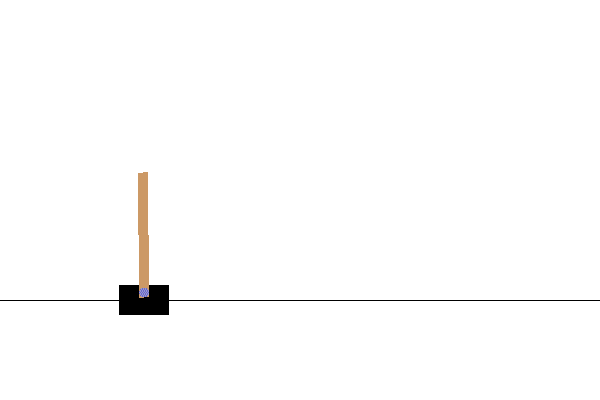

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## Next steps

This tutorial demonstrated how to implement the actor-critic method using Tensorflow.

As a next step, you could try training a model on a different environment in OpenAI Gym. 

For additional information regarding actor-critic methods and the Cartpole-v0 problem, you may refer to the following resources:

- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)
- [Actor Critic Lecture (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cartpole learning control problem \[Barto, et al. 1983\]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) 

For more reinforcement learning examples in TensorFlow, you can check the following resources:
- [Reinforcement learning code examples (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents reinforcement learning library](https://www.tensorflow.org/agents)
